In [1]:
'''Load Libs'''
import numpy as np
import pandas as pd
import os.path
from pathlib import Path
from collections import Counter
import random
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from time import time
import matplotlib.pyplot as plt

In [2]:
'''Load Data And Identify Classes'''
PathTrain =  os.getcwd() + "/data/train.csv"
PathTest =  os.getcwd() + "/data/test.csv"
DFTrain = pd.read_csv(PathTrain, header=None)
DFTest = pd.read_csv(PathTest, header=None)
totalClasses = len(Counter(DFTrain.iloc[:,-1]))

In [3]:
DTrain = DFTrain.iloc[:,:-1].to_numpy()
LabelsTrain = np.array(DFTrain.iloc[:,-1])
DTest = DFTest.iloc[:,:-1].to_numpy()
LabelsTest = np.array(DFTest.iloc[:,-1])

In [4]:
'''One Hot Encoding for Train and Test Labels'''
oneHotTrainLables = np.zeros((len(DFTrain), totalClasses))

for i in range(len(DFTrain)):
    oneHotTrainLables[i][DFTrain.iloc[i, -1]] = 1

In [5]:
train_accuracy_list = np.zeros(5)
test_accuracy_list = np.zeros(5)
train_accuracy_adaptive_lr = np.zeros(5)
test_accuracy_adaptive_lr = np.zeros(5)
time_fixed_lr = np.zeros(5)
time_adaptive_lr = np.zeros(5)

In [6]:
def sigmoid(z):
    #Sigmoid Function
    return 1/(1+np.exp(-z))

def ReLU(z):
    #Rectified Linear Unit
    return np.maximum(0,z)

def delSigmoid(z):
    #Derivative of Sigmoid
    #oj = sigmoid(z)  This was a mistake
    return np.multiply(z, (1-z))

def delReLU(z):
    #Derivative of ReLU
    z = np.matrix(z)
    z[z > 0] = 1
    z[z <= 0] = 0    
    return z
    
    
class Layer:    
    '''
    Class: Layer
    
    Params: 
    perceptron_units = Number of perceptrons in the layer
    n_inputs = Number of inputs to the layer
    activation_function = Function to introduce Non Linearity
    layer_type = this is to keep track of whether the Layer is Hidden/Output
    stn_dev = standard deviation of weights with mean = 0
    
    Returns: A Layer Object
    '''
    def __init__(self, perceptron_units, n_inputs, activation_func, layer_type, stn_dev):
        self.type = layer_type
        self.activation = activation_func
        self.perceptron_units = perceptron_units
        self.inputs = None
        self.output = None
        self.weights = np.random.normal(0,stn_dev, (n_inputs) * perceptron_units).reshape(n_inputs, perceptron_units)
        self.bias = np.random.normal(0,stn_dev, perceptron_units)
        self.delta = None
        
    def __repr__(self):
        representation = (self.type, self.perceptron_units, self.weights.shape, self.bias.shape, self.activation)
        return "<%s Layer | Num_Perceptrons_Units = %d, Weights = %s, Bias = %s, Activation = %s>" % representation

    

class NeuralNetwork:
    '''
    Class: Neural Network
    
    HyperParameters:
    list_hidden_layers = takes a list of number of perceptrons in each hidden layer
    op_layer_activation = Non Linearity function for output layer. We have used Sigmoid. but can be varied
    hidden_layers_activation = Non Linearity function for output layer. Experimentation done with ReLU and Sigmoid
    weights_sd = standard deviation of weights on layers. with mean = 0
    
    '''
    
    def __init__(self, list_hidden_layers, op_layers_activation, hidden_layers_activation, weights_sd):
        np.random.seed(525)
        self.total_layers = len(list_hidden_layers) + 1
        self.nodes_hidden_layers = list_hidden_layers
        self.layers = []
        
        for i in range(len(list_hidden_layers)):
            if i == 0:
                layer = Layer(list_hidden_layers[i], n, hidden_layers_activation, "Hidden", weights_sd)
                self.layers.append(layer)
            else:
                layer = Layer(list_hidden_layers[i], list_hidden_layers[i-1], hidden_layers_activation, "Hidden", weights_sd)                
                self.layers.append(layer)
        
        layer = Layer(r, list_hidden_layers[-1], op_layers_activation, "Output", weights_sd)
        self.layers.append(layer)
        
        
    def __repr__(self):
        layers = self.layers
        rep = ""
        print("Neural Network:")
        for i in range(len(layers)):
            rep += "Layer %d: %s\n" % (i, layers[i])
        return rep
    
    def forwardFeed(self, ip_data):
        '''
        Forward pass of input data to the output through all the layers
        '''
        layer = self.layers[0]
        layer.inputs = np.matrix(ip_data)
        #print("FF", layer.inputs.shape, np.matrix(layer.weights).shape, layer.bias.shape)
        layer.netj = np.matmul(layer.inputs, np.matrix(layer.weights)) + layer.bias
        layer.output = self.activation(layer.netj, layer.activation)
        for i in range(1, len(self.layers), 1):
            layer = self.layers[i]
            last_layer = self.layers[i-1]
            layer.inputs = last_layer.output
            layer.netj = np.matmul(layer.inputs, np.matrix(layer.weights)) + layer.bias
            layer.output = self.activation(layer.netj, layer.activation)
    
    def backwardPropagation(self, labels):
        '''
        Back propagation algorithm implementation
        '''
        output_layer = self.layers[-1]
        error = labels - output_layer.output
        delOj = self.delActivation(output_layer.output, output_layer.activation)
        output_layer.delta = -1*np.multiply(error, delOj)
        
        for i in reversed(range(self.total_layers-1)):
            current_layer = self.layers[i]
            next_layer = self.layers[i + 1]
            
            error = np.matmul(next_layer.delta, next_layer.weights.T)
            delOj = self.delActivation(current_layer.output, current_layer.activation)
            current_layer.delta = np.multiply(error, delOj)
            
    def activation(self, x, activation):
        '''
        call Non Linearity function based on layer activation param
        '''
        if activation == "Sigmoid":
            return sigmoid(x)
        elif activation == "ReLU":
            return ReLU(x)
    
    def delActivation(self, x, activation):
        '''
        call Derivation of Non Linearity function based on layer activation param
        '''
        if activation == "Sigmoid":            
            return delSigmoid(x)
        
        elif activation == "ReLU":
            return delReLU(x)
        
    def updateParams(self, lr, bSize):
        '''
        update the weights and bias term of all the layers
        '''
        layers = self.layers
        for layer in layers:
            #print(layer.inputs.shape, layer.delta.shape)
            gradient = np.matmul(layer.inputs.T, layer.delta)
            layer.weights = layer.weights - (lr/bSize)*gradient
            layer.bias = layer.bias - (lr/bSize)*np.sum(layer.delta, 0)
    
            
    def meanSquaredError(self, Y, avg=True):        
        '''
        Mean Squared Error Cost computation
        '''
        div = len(Y)
        
        op_layer_labels = self.layers[-1].output
        error = Y - op_layer_labels
        error = np.square(error)
        error = np.sum(error)/(2*div)
        return error
    
    
    def fit(self, X, Labels, eta = 0.1, batch_size=100, max_epoch = 10000, epsilon=1e-06, adaptive=False):
        '''
        Train Model
        '''
        lr = eta
        data = X
        labels = Labels
        
        epoch = 0
        self.forwardFeed(data)
        error_prev = self.meanSquaredError(labels)        
        epoch_error_list = [error_prev]
        t0 = time()
        while epoch < max_epoch:
            t1 = time()
            epoch += 1
            
            data, labels = shuffle(data, labels)
            
            if adaptive:
                lr = eta/np.sqrt(epoch)
                
            for batch_start in range(0, len(data), batch_size):
                batch_end = batch_start + batch_size
                Xb = data[batch_start : batch_end]
                Yb = labels[batch_start : batch_end]
                
                self.forwardFeed(Xb)
                self.backwardPropagation(Yb)
                
                self.updateParams(lr, batch_size)
                
            t2 = time()   
            self.forwardFeed(data)
            error = self.meanSquaredError(labels)
            deltaError = error - error_prev
            epoch_error_list.append(np.abs(deltaError))            
            print("$$ Epoch: {} | Error = {} | DeltaError = {} | LR = {} | Epoch Train Time = {}Sec"
                  .format(epoch, round(error,6), round(deltaError,20), round(lr,5), round(t2-t1,2)))
            avg_deltaError = np.mean(epoch_error_list[-10:])
            if np.abs(avg_deltaError) < epsilon[1] or error < epsilon[0]:
                break
            error_prev = error
        
        t4 = time()
        print("\n%% Total Epochs ={} | Epsilon = {} | Total Learning Time = {}Min"
              .format(epoch, epsilon, round((t4-t0)/60,2)))
        return round((t4-t0)/60,2)
        
    def predict(self, data, labels):
        '''
        Model Prediction
        '''
        self.forwardFeed(data)
        outputs = self.layers[-1].output
        prediction = []
        for x in outputs:
            prediction.append(np.argmax(x))
        print(len(prediction), labels.shape)
        accu_score = accuracy_score(labels, prediction)
        #print("Accuracy Score: ", 100*accu_score)
        return 100*accu_score


def plotAccuracies(lr_type="fixed"):
    fig = plt.figure(0)
    num_perceptrons = [1,5,10,50,100]
    
    if lr_type == "fixed":
        train_accu = train_accuracy_list
        test_accu = test_accuracy_list
    elif lr_type == "adaptive":
        train_accu = train_accuracy_adaptive_lr
        test_accu = test_accuracy_adaptive_lr
    
    plt.plot(num_perceptrons, train_accu, c="tab:green", marker="o", label="Train Accuracy")
    plt.plot(num_perceptrons, test_accu, c="tab:orange", marker="x", label="Test Accuracy")
    plt.title("Train & Test Accuracies with {} learning rate".format(lr_type))
    plt.xlabel("# Perceptrons in Hidden Layer")
    plt.ylabel("% Accuracies")
    plt.legend()
    plt.show()
    fig.savefig("plots/accuracies_{}_lr.png".format(lr_type), dpi= 300, pad_inches=0.1, format="png")
    
def plotAccuraciesComparision(data_type = "Train"):
    fig = plt.figure(0)
    num_perceptrons = [1,5,10,50,100]
    
    if data_type == "Train":
        accu_fixed = train_accuracy_list
        accu_adaptive = train_accuracy_adaptive_lr
    elif data_type == "Test":
        accu_fixed = test_accuracy_list
        accu_adaptive = test_accuracy_adaptive_lr
    
    plt.plot(num_perceptrons, accu_fixed, c="tab:green", marker="o", label="Fixed Learning Rate")
    plt.plot(num_perceptrons, accu_adaptive, c="tab:orange", marker="x", label="Adaptive Learning Rate")
    plt.title("{} Accuracies with Fixed & Adaptive learning rate".format(data_type))
    plt.xlabel("# Perceptrons in Hidden Layer")
    plt.ylabel("% Accuracies")
    plt.legend()
    plt.show()
    fig.savefig("plots/comparision_{}_accuracies_fixed_adaptive_lr.png".format(data_type.lower()), dpi= 300,
                pad_inches=0.1, format="png")
    
def plotTrainingTime():
    fig = plt.figure(0)
    num_perceptrons = [1,5,10,50,100]
        
    plt.plot(num_perceptrons, time_fixed_lr, c="tab:green", marker="o", label="Fixed Learning Rate")
    plt.plot(num_perceptrons, time_adaptive_lr, c="tab:orange", marker="x", label="Adaptive Learning Rate")
    plt.title("Model Train Time for Fixed and Adaptive Learning Rates")
    plt.xlabel("# Perceptrons in Hidden Layer")
    plt.ylabel("Train Time (Mins)")
    plt.legend()
    plt.show()
    fig.savefig("plots/time_fixed_adaptive_lr.png", dpi= 300, pad_inches=0.1, format="png")
    
    fig1 = plt.figure(1)
        
    plt.plot(num_perceptrons, time_fixed_lr, marker="o", label="Fixed Learning Rate")
    plt.title("Model Train Time for Fixed Learning Rate")
    plt.xlabel("# Perceptrons in Hidden Layer")
    plt.ylabel("Train Time (Mins)")
    plt.legend()
    plt.show()
    fig1.savefig("plots/time_fixed_lr.png", dpi= 300, pad_inches=0.1, format="png")
    
    fig2 = plt.figure(2)
        
    plt.plot(num_perceptrons, time_adaptive_lr, marker="o", label="Adaptive Learning Rate")
    plt.title("Model Train Time for Adaptive Learning Rate")
    plt.xlabel("# Perceptrons in Hidden Layer")
    plt.ylabel("Train Time (Mins)")
    plt.legend()
    plt.show()
    fig2.savefig("plots/time_adaptive_lr.png", dpi= 300, pad_inches=0.1, format="png")

In [7]:
'''Global Params'''
M = 100 #MiniBatch Size
n = len(DTrain[0])
r = totalClasses

In [21]:
'''Global Params'''
nodesInHiddenLayers = [100]
print("@@@@@@@@@@---------Q1_b---------@@@@@@@@@@")
print("######------HiddenLayer = {}-----######\n".format(nodesInHiddenLayers))
neu_net = NeuralNetwork(nodesInHiddenLayers, "Sigmoid", "Sigmoid", 0.05)
print(neu_net)
train_time = neu_net.fit(DTrain, oneHotTrainLables, eta=0.1, max_epoch=10000, epsilon=[0.02, 1e-06])

AccuTrain = neu_net.predict(DTrain, LabelsTrain)
AccuTest = neu_net.predict(DTest, LabelsTest)
train_accuracy_list[4] = AccuTrain
test_accuracy_list[4] = AccuTest
time_fixed_lr[4] = train_time
print("Train Accuracy = {}%".format(round(AccuTrain,3)))
print("Test Accuracy = {}%".format(round(AccuTest,3)))

@@@@@@@@@@---------Q1_b---------@@@@@@@@@@
######------HiddenLayer = [100]-----######

Neural Network:
Layer 0: <Hidden Layer | Num_Perceptrons_Units = 100, Weights = (784, 100), Bias = (100,), Activation = Sigmoid>
Layer 1: <Output Layer | Num_Perceptrons_Units = 26, Weights = (100, 26), Bias = (26,), Activation = Sigmoid>

$$ Epoch: 1 | Error = 0.478199 | DeltaError = -2.7207288711072817 | LR = 0.1 | Epoch Train Time = 0.42Sec
$$ Epoch: 2 | Error = 0.474653 | DeltaError = -0.0035463093961940473 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 3 | Error = 0.469816 | DeltaError = -0.004836823914199095 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 4 | Error = 0.461416 | DeltaError = -0.00839973757563478 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ Epoch: 5 | Error = 0.448981 | DeltaError = -0.012435490291572593 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 6 | Error = 0.433878 | DeltaError = -0.015102611005465616 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 7 | Error = 0.416

$$ Epoch: 74 | Error = 0.104117 | DeltaError = -0.003095789289813522 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 75 | Error = 0.104375 | DeltaError = 0.0002578435631432896 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 76 | Error = 0.103228 | DeltaError = -0.001147364815710733 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 77 | Error = 0.10445 | DeltaError = 0.001222641241134012 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 78 | Error = 0.102813 | DeltaError = -0.0016373019810873024 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 79 | Error = 0.100749 | DeltaError = -0.002063917518991029 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 80 | Error = 0.102801 | DeltaError = 0.002051411806740913 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 81 | Error = 0.101292 | DeltaError = -0.0015084820094083825 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 82 | Error = 0.099753 | DeltaError = -0.0015391253362607993 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 83 | Erro

$$ Epoch: 149 | Error = 0.074144 | DeltaError = -0.0009914366087020593 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 150 | Error = 0.075859 | DeltaError = 0.0017154026865699307 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 151 | Error = 0.074727 | DeltaError = -0.0011321223431993016 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 152 | Error = 0.072596 | DeltaError = -0.0021310599275084774 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 153 | Error = 0.073714 | DeltaError = 0.0011181869173156889 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ Epoch: 154 | Error = 0.072811 | DeltaError = -0.0009030426818869979 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 155 | Error = 0.072142 | DeltaError = -0.0006688271187213768 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 156 | Error = 0.074043 | DeltaError = 0.0019010020417765117 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ Epoch: 157 | Error = 0.072984 | DeltaError = -0.0010593320508895943 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ E

$$ Epoch: 224 | Error = 0.05732 | DeltaError = -0.0011589579753819718 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 225 | Error = 0.058391 | DeltaError = 0.001071159693985524 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ Epoch: 226 | Error = 0.05988 | DeltaError = 0.0014890194706504503 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 227 | Error = 0.059663 | DeltaError = -0.00021707412594177547 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ Epoch: 228 | Error = 0.059306 | DeltaError = -0.0003569524344183353 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ Epoch: 229 | Error = 0.05793 | DeltaError = -0.0013757052234161654 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 230 | Error = 0.057237 | DeltaError = -0.0006934328253962035 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 231 | Error = 0.055557 | DeltaError = -0.001680224625763241 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 232 | Error = 0.056919 | DeltaError = 0.0013623201463451723 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch

$$ Epoch: 299 | Error = 0.047443 | DeltaError = -0.0001277178279694563 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 300 | Error = 0.048361 | DeltaError = 0.0009186108043856694 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 301 | Error = 0.047312 | DeltaError = -0.0010486254706816162 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ Epoch: 302 | Error = 0.047007 | DeltaError = -0.00030569164818267797 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 303 | Error = 0.047099 | DeltaError = 9.238318096407155e-05 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ Epoch: 304 | Error = 0.048648 | DeltaError = 0.001549260483745922 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 305 | Error = 0.045866 | DeltaError = -0.002782087722900256 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 306 | Error = 0.045902 | DeltaError = 3.61401815100193e-05 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 307 | Error = 0.045248 | DeltaError = -0.0006547570066768246 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ Epoc

$$ Epoch: 374 | Error = 0.039468 | DeltaError = -0.0003070317852363613 | LR = 0.1 | Epoch Train Time = 0.45Sec
$$ Epoch: 375 | Error = 0.038366 | DeltaError = -0.001102453367482381 | LR = 0.1 | Epoch Train Time = 0.48Sec
$$ Epoch: 376 | Error = 0.038789 | DeltaError = 0.0004236419856664883 | LR = 0.1 | Epoch Train Time = 0.47Sec
$$ Epoch: 377 | Error = 0.039506 | DeltaError = 0.0007162432809221173 | LR = 0.1 | Epoch Train Time = 0.42Sec
$$ Epoch: 378 | Error = 0.038144 | DeltaError = -0.001361245623839151 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ Epoch: 379 | Error = 0.039249 | DeltaError = 0.001104904384062813 | LR = 0.1 | Epoch Train Time = 0.4Sec
$$ Epoch: 380 | Error = 0.039923 | DeltaError = 0.0006736173328519279 | LR = 0.1 | Epoch Train Time = 0.52Sec
$$ Epoch: 381 | Error = 0.037658 | DeltaError = -0.0022650937940816226 | LR = 0.1 | Epoch Train Time = 0.49Sec
$$ Epoch: 382 | Error = 0.038452 | DeltaError = 0.0007941921774046664 | LR = 0.1 | Epoch Train Time = 0.55Sec
$$ Epoch: 

$$ Epoch: 449 | Error = 0.032188 | DeltaError = 0.0001288425886582789 | LR = 0.1 | Epoch Train Time = 0.44Sec
$$ Epoch: 450 | Error = 0.031882 | DeltaError = -0.0003063814373580401 | LR = 0.1 | Epoch Train Time = 0.54Sec
$$ Epoch: 451 | Error = 0.030879 | DeltaError = -0.0010027263307053717 | LR = 0.1 | Epoch Train Time = 0.44Sec
$$ Epoch: 452 | Error = 0.03084 | DeltaError = -3.882023042027158e-05 | LR = 0.1 | Epoch Train Time = 0.4Sec
$$ Epoch: 453 | Error = 0.031842 | DeltaError = 0.001002184545949164 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 454 | Error = 0.031114 | DeltaError = -0.0007283090509937334 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 455 | Error = 0.030824 | DeltaError = -0.0002895159808686369 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 456 | Error = 0.031685 | DeltaError = 0.0008603889674055517 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 457 | Error = 0.033132 | DeltaError = 0.0014475892636910057 | LR = 0.1 | Epoch Train Time = 0.41Sec
$$ Epoch

$$ Epoch: 524 | Error = 0.02532 | DeltaError = 0.0001779280672517987 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 525 | Error = 0.025076 | DeltaError = -0.00024430953771228947 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 526 | Error = 0.025582 | DeltaError = 0.0005057174120974561 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 527 | Error = 0.025203 | DeltaError = -0.00037911703186509216 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 528 | Error = 0.02638 | DeltaError = 0.0011771266235057545 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 529 | Error = 0.025458 | DeltaError = -0.000922192934118108 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 530 | Error = 0.025799 | DeltaError = 0.0003412397857315702 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 531 | Error = 0.026188 | DeltaError = 0.0003891865791360652 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 532 | Error = 0.025257 | DeltaError = -0.0009308709527026046 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoc

$$ Epoch: 599 | Error = 0.022463 | DeltaError = -5.308202075324578e-05 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 600 | Error = 0.022558 | DeltaError = 9.507904385160082e-05 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 601 | Error = 0.022445 | DeltaError = -0.00011244667015564148 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 602 | Error = 0.02241 | DeltaError = -3.54277996363235e-05 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ Epoch: 603 | Error = 0.02248 | DeltaError = 6.987401974359667e-05 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 604 | Error = 0.022383 | DeltaError = -9.675135445316035e-05 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 605 | Error = 0.022352 | DeltaError = -3.072705927042313e-05 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 606 | Error = 0.022377 | DeltaError = 2.469639274275612e-05 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 607 | Error = 0.022376 | DeltaError = -1.4084722953292e-06 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch

$$ Epoch: 674 | Error = 0.021414 | DeltaError = -7.85268861980618e-06 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 675 | Error = 0.021401 | DeltaError = -1.24893095765459e-05 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 676 | Error = 0.02139 | DeltaError = -1.125527798731887e-05 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 677 | Error = 0.021379 | DeltaError = -1.153074384228903e-05 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 678 | Error = 0.021379 | DeltaError = 9.696972262177e-07 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 679 | Error = 0.02136 | DeltaError = -1.945646337111681e-05 | LR = 0.1 | Epoch Train Time = 0.41Sec
$$ Epoch: 680 | Error = 0.021355 | DeltaError = -4.74683354663788e-06 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 681 | Error = 0.02134 | DeltaError = -1.499476456811449e-05 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 682 | Error = 0.021332 | DeltaError = -8.05368298992942e-06 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ Epoch: 68

$$ Epoch: 749 | Error = 0.020697 | DeltaError = -1.081107661361422e-05 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 750 | Error = 0.020687 | DeltaError = -1.001563596647256e-05 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 751 | Error = 0.02068 | DeltaError = -7.60486553787187e-06 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 752 | Error = 0.020693 | DeltaError = 1.304327566450936e-05 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 753 | Error = 0.020677 | DeltaError = -1.563573845892938e-05 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 754 | Error = 0.020662 | DeltaError = -1.46135459444599e-05 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 755 | Error = 0.020661 | DeltaError = -1.85688219585256e-06 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 756 | Error = 0.020641 | DeltaError = -1.999544538743014e-05 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 757 | Error = 0.02063 | DeltaError = -1.033043869048608e-05 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ Epoc

$$ Epoch: 824 | Error = 0.020108 | DeltaError = -1.072597921995474e-05 | LR = 0.1 | Epoch Train Time = 0.45Sec
$$ Epoch: 825 | Error = 0.020099 | DeltaError = -8.8717166669243e-06 | LR = 0.1 | Epoch Train Time = 0.42Sec
$$ Epoch: 826 | Error = 0.02009 | DeltaError = -8.98864712856398e-06 | LR = 0.1 | Epoch Train Time = 0.44Sec
$$ Epoch: 827 | Error = 0.020082 | DeltaError = -7.98176894393696e-06 | LR = 0.1 | Epoch Train Time = 0.44Sec
$$ Epoch: 828 | Error = 0.020075 | DeltaError = -6.98408036313436e-06 | LR = 0.1 | Epoch Train Time = 0.42Sec
$$ Epoch: 829 | Error = 0.020069 | DeltaError = -6.13498049471806e-06 | LR = 0.1 | Epoch Train Time = 0.44Sec
$$ Epoch: 830 | Error = 0.020065 | DeltaError = -4.60201636918317e-06 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 831 | Error = 0.020055 | DeltaError = -9.47353760895678e-06 | LR = 0.1 | Epoch Train Time = 0.4Sec
$$ Epoch: 832 | Error = 0.020051 | DeltaError = -4.09427781489918e-06 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 83

In [10]:
nodesInHiddenLayers = [50]
print("@@@@@@@@@@---------Q1_b---------@@@@@@@@@@")
print("######------HiddenLayer = {}-----######\n".format(nodesInHiddenLayers))
neu_net = NeuralNetwork(nodesInHiddenLayers, "Sigmoid", "Sigmoid", 0.05)
print(neu_net)
train_time = neu_net.fit(DTrain, oneHotTrainLables, eta=0.1, max_epoch=10000, epsilon=[0.02, 1e-06])

AccuTrain = neu_net.predict(DTrain, LabelsTrain)
AccuTest = neu_net.predict(DTest, LabelsTest)
train_accuracy_list[3] = AccuTrain
test_accuracy_list[3] = AccuTest
time_fixed_lr[3] = train_time
print("Train Accuracy = {}%".format(round(AccuTrain,3)))
print("Test Accuracy = {}%".format(round(AccuTest,3)))

@@@@@@@@@@---------Q1_b---------@@@@@@@@@@
######------HiddenLayer = [50]-----######

Neural Network:
Layer 0: <Hidden Layer | Num_Perceptrons_Units = 50, Weights = (784, 50), Bias = (50,), Activation = Sigmoid>
Layer 1: <Output Layer | Num_Perceptrons_Units = 26, Weights = (50, 26), Bias = (26,), Activation = Sigmoid>

$$ Epoch: 1 | Error = 0.481455 | DeltaError = -2.740455479339737 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 2 | Error = 0.479445 | DeltaError = -0.0020103329537937698 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3 | Error = 0.478572 | DeltaError = -0.0008726248324462115 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 4 | Error = 0.477681 | DeltaError = -0.0008909989973915344 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 5 | Error = 0.476496 | DeltaError = -0.0011852729143372875 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 6 | Error = 0.47509 | DeltaError = -0.001406377097571243 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 7 | Error = 0.473269 

$$ Epoch: 74 | Error = 0.170746 | DeltaError = -0.002768737348226663 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 75 | Error = 0.170675 | DeltaError = -7.078289729695042e-05 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 76 | Error = 0.171666 | DeltaError = 0.000990453257383117 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 77 | Error = 0.165823 | DeltaError = -0.005843127945574899 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 78 | Error = 0.164727 | DeltaError = -0.0010960194075354535 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 79 | Error = 0.167366 | DeltaError = 0.002639417669988209 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 80 | Error = 0.164831 | DeltaError = -0.002534839088142199 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 81 | Error = 0.162902 | DeltaError = -0.0019290755373349289 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 82 | Error = 0.164023 | DeltaError = 0.0011202686131694117 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 83 | Error =

$$ Epoch: 149 | Error = 0.129717 | DeltaError = 0.0014823949279978153 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 150 | Error = 0.126191 | DeltaError = -0.0035260715252797563 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 151 | Error = 0.124688 | DeltaError = -0.001502829574500139 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 152 | Error = 0.12196 | DeltaError = -0.0027278900058578526 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 153 | Error = 0.121874 | DeltaError = -8.690732592775419e-05 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 154 | Error = 0.12268 | DeltaError = 0.0008063919928776864 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 155 | Error = 0.127369 | DeltaError = 0.00468885779372917 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 156 | Error = 0.122339 | DeltaError = -0.005029370935058189 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 157 | Error = 0.119904 | DeltaError = -0.0024356361225399414 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 15

$$ Epoch: 224 | Error = 0.103768 | DeltaError = -0.003827688843817969 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 225 | Error = 0.111839 | DeltaError = 0.008071710713511898 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 226 | Error = 0.10571 | DeltaError = -0.006129668208507397 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 227 | Error = 0.107242 | DeltaError = 0.0015319002189950748 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 228 | Error = 0.106461 | DeltaError = -0.0007802565191353112 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 229 | Error = 0.105695 | DeltaError = -0.0007669666034688521 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 230 | Error = 0.104677 | DeltaError = -0.0010174965505261868 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 231 | Error = 0.104827 | DeltaError = 0.00015039024610494223 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 232 | Error = 0.108865 | DeltaError = 0.004037220710084138 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 23

$$ Epoch: 299 | Error = 0.09575 | DeltaError = 0.0014224695207940563 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 300 | Error = 0.096809 | DeltaError = 0.0010585392148635409 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 301 | Error = 0.095119 | DeltaError = -0.0016895269632850596 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 302 | Error = 0.097665 | DeltaError = 0.002546019984658865 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 303 | Error = 0.097652 | DeltaError = -1.319001175335843e-05 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 304 | Error = 0.099349 | DeltaError = 0.0016972568941825002 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 305 | Error = 0.096223 | DeltaError = -0.0031267083899457204 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 306 | Error = 0.097858 | DeltaError = 0.001635324843606678 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 307 | Error = 0.097008 | DeltaError = -0.0008501183182146599 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch:

$$ Epoch: 374 | Error = 0.089588 | DeltaError = -1.685242698275247e-05 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 375 | Error = 0.088945 | DeltaError = -0.0006436653310796236 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 376 | Error = 0.088311 | DeltaError = -0.000633794490239814 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 377 | Error = 0.090307 | DeltaError = 0.001995672911330626 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 378 | Error = 0.090801 | DeltaError = 0.0004946520927330417 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 379 | Error = 0.089048 | DeltaError = -0.0017535714234568067 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 380 | Error = 0.08665 | DeltaError = -0.0023974572227640906 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 381 | Error = 0.088225 | DeltaError = 0.0015748332805137488 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 382 | Error = 0.091103 | DeltaError = 0.00287837927793598 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3

$$ Epoch: 449 | Error = 0.080598 | DeltaError = -0.0034463339412229843 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 450 | Error = 0.084798 | DeltaError = 0.004200183914267394 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 451 | Error = 0.081803 | DeltaError = -0.0029956496780533665 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 452 | Error = 0.083479 | DeltaError = 0.0016765232502001098 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 453 | Error = 0.083596 | DeltaError = 0.00011679370010755918 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 454 | Error = 0.085298 | DeltaError = 0.001702181254833568 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 455 | Error = 0.086451 | DeltaError = 0.0011523930746505234 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 456 | Error = 0.082102 | DeltaError = -0.00434848636840926 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 457 | Error = 0.086216 | DeltaError = 0.004114108433064062 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 458 |

$$ Epoch: 524 | Error = 0.07557 | DeltaError = -0.00319582588346054 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 525 | Error = 0.074382 | DeltaError = -0.001188863991391162 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 526 | Error = 0.076346 | DeltaError = 0.001964148171584759 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 527 | Error = 0.077045 | DeltaError = 0.0006993065379959224 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 528 | Error = 0.080302 | DeltaError = 0.003257036562931692 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 529 | Error = 0.07596 | DeltaError = -0.004342369846691604 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 530 | Error = 0.076501 | DeltaError = 0.0005416246482258524 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 531 | Error = 0.077896 | DeltaError = 0.0013943519387002445 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 532 | Error = 0.075355 | DeltaError = -0.002541209912452047 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 533 | Er

$$ Epoch: 599 | Error = 0.071458 | DeltaError = -0.0012511512917523088 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 600 | Error = 0.074908 | DeltaError = 0.0034493063353058517 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 601 | Error = 0.07885 | DeltaError = 0.003942382704988187 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 602 | Error = 0.072451 | DeltaError = -0.006398519858572343 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 603 | Error = 0.071315 | DeltaError = -0.0011363661942624947 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 604 | Error = 0.074114 | DeltaError = 0.002799255401616435 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 605 | Error = 0.071814 | DeltaError = -0.002299836801845534 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 606 | Error = 0.074074 | DeltaError = 0.0022595876214171196 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 607 | Error = 0.072905 | DeltaError = -0.0011688412643533486 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 608

$$ Epoch: 674 | Error = 0.065797 | DeltaError = -0.0008575700409787224 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 675 | Error = 0.064602 | DeltaError = -0.0011958870569422353 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 676 | Error = 0.070708 | DeltaError = 0.0061068213387166365 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 677 | Error = 0.06874 | DeltaError = -0.0019682137418399054 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 678 | Error = 0.06907 | DeltaError = 0.00032983720437923525 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 679 | Error = 0.074083 | DeltaError = 0.005012721965868355 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 680 | Error = 0.069056 | DeltaError = -0.005026494972429296 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 681 | Error = 0.070403 | DeltaError = 0.0013468698463691836 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 682 | Error = 0.068643 | DeltaError = -0.0017596796625908157 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 6

$$ Epoch: 749 | Error = 0.06534 | DeltaError = 0.0010127444409770286 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 750 | Error = 0.066104 | DeltaError = 0.0007640731652214378 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 751 | Error = 0.065402 | DeltaError = -0.0007015984778618312 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 752 | Error = 0.065506 | DeltaError = 0.00010445659923671859 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 753 | Error = 0.0681 | DeltaError = 0.0025937782305522072 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 754 | Error = 0.06484 | DeltaError = -0.0032604082265067368 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 755 | Error = 0.064749 | DeltaError = -9.099836318771092e-05 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 756 | Error = 0.063219 | DeltaError = -0.0015296765905228463 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 757 | Error = 0.063492 | DeltaError = 0.0002732309537682859 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 758 

$$ Epoch: 824 | Error = 0.060985 | DeltaError = -0.0016390129722141725 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 825 | Error = 0.061365 | DeltaError = 0.00037969964348855833 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ Epoch: 826 | Error = 0.061486 | DeltaError = 0.00012163132620728045 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 827 | Error = 0.065893 | DeltaError = 0.00440682864882197 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 828 | Error = 0.063075 | DeltaError = -0.0028180585397085817 | LR = 0.1 | Epoch Train Time = 0.42Sec
$$ Epoch: 829 | Error = 0.061677 | DeltaError = -0.0013976038558955184 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 830 | Error = 0.061595 | DeltaError = -8.289238708419217e-05 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 831 | Error = 0.062811 | DeltaError = 0.001216870771531632 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 832 | Error = 0.062079 | DeltaError = -0.0007326321556461665 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epo

$$ Epoch: 899 | Error = 0.061044 | DeltaError = 0.0018566980250190185 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 900 | Error = 0.059211 | DeltaError = -0.0018330964211856551 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 901 | Error = 0.059151 | DeltaError = -6.012068466020037e-05 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 902 | Error = 0.059112 | DeltaError = -3.929246199135816e-05 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 903 | Error = 0.059335 | DeltaError = 0.0002231514716891994 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 904 | Error = 0.062747 | DeltaError = 0.0034121876501159443 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 905 | Error = 0.057574 | DeltaError = -0.005173694052383 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 906 | Error = 0.055853 | DeltaError = -0.0017203531883937804 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 907 | Error = 0.059134 | DeltaError = 0.0032812062393469403 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 

$$ Epoch: 974 | Error = 0.055914 | DeltaError = 0.0004955673245241321 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 975 | Error = 0.057266 | DeltaError = 0.001351880976094226 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 976 | Error = 0.056367 | DeltaError = -0.0008994203992386263 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 977 | Error = 0.059601 | DeltaError = 0.0032345367010080256 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 978 | Error = 0.055639 | DeltaError = -0.003962776264948405 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 979 | Error = 0.058106 | DeltaError = 0.0024669230941698553 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 980 | Error = 0.05784 | DeltaError = -0.00026513327360083716 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 981 | Error = 0.055192 | DeltaError = -0.0026487894008392285 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 982 | Error = 0.057442 | DeltaError = 0.0022507714313365138 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch:

$$ Epoch: 1049 | Error = 0.05189 | DeltaError = -0.003115676938862111 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 1050 | Error = 0.051793 | DeltaError = -9.659156938780777e-05 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 1051 | Error = 0.05575 | DeltaError = 0.003956687277155112 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 1052 | Error = 0.055379 | DeltaError = -0.00037113617511123914 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1053 | Error = 0.052003 | DeltaError = -0.0033755276138788953 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 1054 | Error = 0.052481 | DeltaError = 0.0004781175980298133 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1055 | Error = 0.051725 | DeltaError = -0.0007561029421160882 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 1056 | Error = 0.05244 | DeltaError = 0.0007151161337362599 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1057 | Error = 0.051389 | DeltaError = -0.0010510627660669791 | LR = 0.1 | Epoch Train Time = 0.32Sec


$$ Epoch: 1123 | Error = 0.057165 | DeltaError = 0.003253846586874353 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1124 | Error = 0.054578 | DeltaError = -0.0025867444331958006 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 1125 | Error = 0.053502 | DeltaError = -0.001075608866774276 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 1126 | Error = 0.051993 | DeltaError = -0.0015095583405449267 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 1127 | Error = 0.052284 | DeltaError = 0.00029097641618044956 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1128 | Error = 0.050798 | DeltaError = -0.0014851284100700218 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 1129 | Error = 0.048747 | DeltaError = -0.0020512202823345996 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1130 | Error = 0.050675 | DeltaError = 0.001927381260953771 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 1131 | Error = 0.055317 | DeltaError = 0.004642566848213195 | LR = 0.1 | Epoch Train Time = 0.31Sec
$

$$ Epoch: 1197 | Error = 0.052418 | DeltaError = 0.001429091476063571 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 1198 | Error = 0.051664 | DeltaError = -0.000754527302087464 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 1199 | Error = 0.051214 | DeltaError = -0.00044974645021120247 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 1200 | Error = 0.048523 | DeltaError = -0.00269133864013206 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 1201 | Error = 0.048743 | DeltaError = 0.0002199765005924878 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1202 | Error = 0.05082 | DeltaError = 0.002077727314773972 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 1203 | Error = 0.050724 | DeltaError = -9.605491167836988e-05 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 1204 | Error = 0.050686 | DeltaError = -3.810312235746904e-05 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1205 | Error = 0.05022 | DeltaError = -0.0004656266978033188 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ 

$$ Epoch: 1271 | Error = 0.047393 | DeltaError = -2.6934345409152e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1272 | Error = 0.045851 | DeltaError = -0.001541387272722336 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 1273 | Error = 0.048156 | DeltaError = 0.0023047727437761414 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 1274 | Error = 0.047583 | DeltaError = -0.0005731576585155315 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1275 | Error = 0.04696 | DeltaError = -0.0006230933657709534 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 1276 | Error = 0.046442 | DeltaError = -0.000518439147836898 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1277 | Error = 0.047557 | DeltaError = 0.0011158583828374813 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 1278 | Error = 0.046911 | DeltaError = -0.0006461502544373096 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 1279 | Error = 0.048458 | DeltaError = 0.001547032742163279 | LR = 0.1 | Epoch Train Time = 0.32Sec
$

$$ Epoch: 1345 | Error = 0.043934 | DeltaError = 4.606175375884008e-05 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 1346 | Error = 0.044914 | DeltaError = 0.0009803768675584051 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 1347 | Error = 0.045179 | DeltaError = 0.0002647192512456875 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 1348 | Error = 0.0453 | DeltaError = 0.0001215258884546891 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1349 | Error = 0.045438 | DeltaError = 0.00013791651664631782 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 1350 | Error = 0.046209 | DeltaError = 0.000771144797034988 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1351 | Error = 0.045593 | DeltaError = -0.0006168785244318256 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 1352 | Error = 0.044314 | DeltaError = -0.0012785304294556724 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 1353 | Error = 0.045707 | DeltaError = 0.00139258949326454 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Ep

$$ Epoch: 1419 | Error = 0.044598 | DeltaError = -0.0011370059611717706 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1420 | Error = 0.043646 | DeltaError = -0.0009516707112606493 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1421 | Error = 0.044951 | DeltaError = 0.0013046108968331402 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 1422 | Error = 0.044554 | DeltaError = -0.0003961104024308784 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 1423 | Error = 0.043 | DeltaError = -0.0015540735049814137 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 1424 | Error = 0.043248 | DeltaError = 0.00024777617775755684 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1425 | Error = 0.041959 | DeltaError = -0.0012888774554710158 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 1426 | Error = 0.041996 | DeltaError = 3.624378028819347e-05 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1427 | Error = 0.043458 | DeltaError = 0.0014625819527844044 | LR = 0.1 | Epoch Train Time = 0.31Sec


$$ Epoch: 1493 | Error = 0.042359 | DeltaError = -6.284132261657333e-05 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 1494 | Error = 0.044521 | DeltaError = 0.0021618324928421515 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 1495 | Error = 0.043836 | DeltaError = -0.0006845907281075939 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1496 | Error = 0.041722 | DeltaError = -0.0021136543687989076 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 1497 | Error = 0.042187 | DeltaError = 0.00046421491042169394 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 1498 | Error = 0.04154 | DeltaError = -0.0006466692661752232 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1499 | Error = 0.04337 | DeltaError = 0.0018299708284905264 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 1500 | Error = 0.042439 | DeltaError = -0.0009310414953531063 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1501 | Error = 0.044479 | DeltaError = 0.002040009795229787 | LR = 0.1 | Epoch Train Time = 0.32Sec
$

$$ Epoch: 1567 | Error = 0.042451 | DeltaError = 0.0019904830933920314 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1568 | Error = 0.039862 | DeltaError = -0.0025896264537982744 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 1569 | Error = 0.040036 | DeltaError = 0.00017433985830851706 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1570 | Error = 0.042219 | DeltaError = 0.002182867050587449 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 1571 | Error = 0.040967 | DeltaError = -0.001252459059441137 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 1572 | Error = 0.041629 | DeltaError = 0.0006626638004299801 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 1573 | Error = 0.04082 | DeltaError = -0.0008089705273567269 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 1574 | Error = 0.042124 | DeltaError = 0.001303949987084524 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 1575 | Error = 0.040461 | DeltaError = -0.001663001091667046 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$

$$ Epoch: 1641 | Error = 0.038919 | DeltaError = -0.0007289936669875111 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1642 | Error = 0.041968 | DeltaError = 0.0030484774718717096 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 1643 | Error = 0.041396 | DeltaError = -0.0005720971233535779 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 1644 | Error = 0.041206 | DeltaError = -0.0001898082813186208 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1645 | Error = 0.039745 | DeltaError = -0.0014613483086739763 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1646 | Error = 0.040141 | DeltaError = 0.000396430554880381 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 1647 | Error = 0.04007 | DeltaError = -7.069954886043672e-05 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1648 | Error = 0.038684 | DeltaError = -0.001386286924778074 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 1649 | Error = 0.039274 | DeltaError = 0.0005902628160439211 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$

$$ Epoch: 1715 | Error = 0.039063 | DeltaError = -0.00019704400110276407 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 1716 | Error = 0.038306 | DeltaError = -0.0007564737038292733 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1717 | Error = 0.037995 | DeltaError = -0.0003112332299520515 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1718 | Error = 0.038571 | DeltaError = 0.0005765641464495833 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 1719 | Error = 0.038963 | DeltaError = 0.0003911530969799501 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 1720 | Error = 0.038008 | DeltaError = -0.0009544793404363677 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1721 | Error = 0.040398 | DeltaError = 0.0023900695258199794 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1722 | Error = 0.03855 | DeltaError = -0.0018479032870284823 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 1723 | Error = 0.037594 | DeltaError = -0.0009561949092084382 | LR = 0.1 | Epoch Train Time = 0.29Se

$$ Epoch: 1789 | Error = 0.03707 | DeltaError = -0.0002164159908328994 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 1790 | Error = 0.038912 | DeltaError = 0.001841520195555682 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1791 | Error = 0.039957 | DeltaError = 0.0010451710455341712 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 1792 | Error = 0.037259 | DeltaError = -0.002697983265352054 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 1793 | Error = 0.037063 | DeltaError = -0.00019588563332838957 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 1794 | Error = 0.038547 | DeltaError = 0.0014836038982839264 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1795 | Error = 0.036961 | DeltaError = -0.0015857084947892492 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 1796 | Error = 0.037129 | DeltaError = 0.00016848954876352157 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1797 | Error = 0.037287 | DeltaError = 0.00015716795056475164 | LR = 0.1 | Epoch Train Time = 0.29Se

$$ Epoch: 1863 | Error = 0.03615 | DeltaError = -3.892735047272139e-05 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 1864 | Error = 0.036432 | DeltaError = 0.0002820807655312396 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1865 | Error = 0.036736 | DeltaError = 0.000303688453672582 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 1866 | Error = 0.035515 | DeltaError = -0.0012215152214790498 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1867 | Error = 0.036199 | DeltaError = 0.000684069600840248 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 1868 | Error = 0.035955 | DeltaError = -0.00024353425455290317 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1869 | Error = 0.035421 | DeltaError = -0.0005338928711304813 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 1870 | Error = 0.035982 | DeltaError = 0.0005612366545230674 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 1871 | Error = 0.037115 | DeltaError = 0.0011323836790825687 | LR = 0.1 | Epoch Train Time = 0.31Sec


$$ Epoch: 1937 | Error = 0.034761 | DeltaError = 7.29110258665816e-05 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 1938 | Error = 0.035298 | DeltaError = 0.0005370043645107209 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1939 | Error = 0.03477 | DeltaError = -0.0005273479563416561 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1940 | Error = 0.034998 | DeltaError = 0.00022784930499745307 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 1941 | Error = 0.034955 | DeltaError = -4.310881925951443e-05 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 1942 | Error = 0.034986 | DeltaError = 3.066997211521178e-05 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1943 | Error = 0.034568 | DeltaError = -0.00041773236682256937 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1944 | Error = 0.034642 | DeltaError = 7.398566193480421e-05 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1945 | Error = 0.03529 | DeltaError = 0.0006477572953635796 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Ep

$$ Epoch: 2011 | Error = 0.034112 | DeltaError = -0.00026562736492820316 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 2012 | Error = 0.034211 | DeltaError = 9.910748964073875e-05 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2013 | Error = 0.034042 | DeltaError = -0.00016867712501813376 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 2014 | Error = 0.034054 | DeltaError = 1.133293368715815e-05 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2015 | Error = 0.03426 | DeltaError = 0.00020611278623201837 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2016 | Error = 0.033918 | DeltaError = -0.0003417942895277762 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2017 | Error = 0.033914 | DeltaError = -4.16555208689745e-06 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 2018 | Error = 0.034047 | DeltaError = 0.00013354630422515723 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2019 | Error = 0.033933 | DeltaError = -0.00011386083859133562 | LR = 0.1 | Epoch Train Time = 0.31

$$ Epoch: 2085 | Error = 0.03349 | DeltaError = -2.870030932573126e-05 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2086 | Error = 0.03383 | DeltaError = 0.0003400785459118649 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 2087 | Error = 0.03356 | DeltaError = -0.0002703265120390652 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2088 | Error = 0.033405 | DeltaError = -0.00015469964300420663 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2089 | Error = 0.033399 | DeltaError = -5.82407276995128e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 2090 | Error = 0.033588 | DeltaError = 0.0001884779132072384 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2091 | Error = 0.033405 | DeltaError = -0.00018312881948482493 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2092 | Error = 0.033425 | DeltaError = 2.059828252298085e-05 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2093 | Error = 0.033391 | DeltaError = -3.44463889572072e-05 | LR = 0.1 | Epoch Train Time = 0.28Sec


$$ Epoch: 2159 | Error = 0.033059 | DeltaError = -1.34451688735826e-05 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2160 | Error = 0.033094 | DeltaError = 3.550511499474801e-05 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 2161 | Error = 0.033097 | DeltaError = 3.18165627801598e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2162 | Error = 0.033185 | DeltaError = 8.789900498074738e-05 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 2163 | Error = 0.033162 | DeltaError = -2.308645256168112e-05 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2164 | Error = 0.033037 | DeltaError = -0.00012525443935250402 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2165 | Error = 0.033074 | DeltaError = 3.68600891237636e-05 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2166 | Error = 0.033204 | DeltaError = 0.00013027605107123613 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2167 | Error = 0.033092 | DeltaError = -0.00011216188164728246 | LR = 0.1 | Epoch Train Time = 0.29Sec

$$ Epoch: 2233 | Error = 0.032817 | DeltaError = 3.86993505217814e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2234 | Error = 0.032843 | DeltaError = 2.608946296758785e-05 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 2235 | Error = 0.032818 | DeltaError = -2.511218636255114e-05 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 2236 | Error = 0.032802 | DeltaError = -1.615160618775174e-05 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 2237 | Error = 0.032805 | DeltaError = 3.08898531451579e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2238 | Error = 0.032809 | DeltaError = 4.34355842438006e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2239 | Error = 0.032806 | DeltaError = -2.91389497967393e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 2240 | Error = 0.032784 | DeltaError = -2.284795562919328e-05 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2241 | Error = 0.032825 | DeltaError = 4.154574908529774e-05 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ E

$$ Epoch: 2307 | Error = 0.03251 | DeltaError = -1.308329916934608e-05 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2308 | Error = 0.032531 | DeltaError = 2.124519662463631e-05 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2309 | Error = 0.032508 | DeltaError = -2.282647178471902e-05 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2310 | Error = 0.03251 | DeltaError = 1.58570759205973e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2311 | Error = 0.032511 | DeltaError = 1.6461551262531e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2312 | Error = 0.0325 | DeltaError = -1.123507882939967e-05 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2313 | Error = 0.032495 | DeltaError = -4.75425622622344e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2314 | Error = 0.032486 | DeltaError = -8.83738884265017e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2315 | Error = 0.032485 | DeltaError = -1.4488010222774e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch:

$$ Epoch: 2382 | Error = 0.032307 | DeltaError = 8.61441184511064e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2383 | Error = 0.032291 | DeltaError = -1.652700163371629e-05 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 2384 | Error = 0.032289 | DeltaError = -1.51426257430365e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2385 | Error = 0.032287 | DeltaError = -2.09481129843231e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2386 | Error = 0.032284 | DeltaError = -3.51965691040151e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 2387 | Error = 0.032281 | DeltaError = -2.13089383677839e-06 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 2388 | Error = 0.032279 | DeltaError = -2.01341540255473e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 2389 | Error = 0.032276 | DeltaError = -3.00523285598486e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2390 | Error = 0.032281 | DeltaError = 4.15392856981806e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$

$$ Epoch: 2457 | Error = 0.032103 | DeltaError = -2.45258592759118e-06 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 2458 | Error = 0.0321 | DeltaError = -3.08037949334206e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2459 | Error = 0.032097 | DeltaError = -2.79692088565181e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2460 | Error = 0.032097 | DeltaError = -5.1728029409892e-07 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2461 | Error = 0.032093 | DeltaError = -3.95160266215833e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 2462 | Error = 0.032091 | DeltaError = -1.5450142438686e-06 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 2463 | Error = 0.03209 | DeltaError = -1.35864654727397e-06 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 2464 | Error = 0.032088 | DeltaError = -1.61140847272645e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 2465 | Error = 0.03212 | DeltaError = 3.158173468987418e-05 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch:

$$ Epoch: 2532 | Error = 0.031919 | DeltaError = -1.94889998430398e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2533 | Error = 0.031916 | DeltaError = -3.26591221139899e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2534 | Error = 0.031914 | DeltaError = -1.47433042909512e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2535 | Error = 0.031912 | DeltaError = -1.84193243900344e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2536 | Error = 0.031909 | DeltaError = -3.12662707225436e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 2537 | Error = 0.031907 | DeltaError = -1.91064204665969e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2538 | Error = 0.031905 | DeltaError = -2.63330627843505e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2539 | Error = 0.031902 | DeltaError = -2.88830718510324e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2540 | Error = 0.0319 | DeltaError = -2.30954885546697e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Ep

$$ Epoch: 2607 | Error = 0.031755 | DeltaError = -6.5556541246209e-07 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 2608 | Error = 0.031753 | DeltaError = -2.76243133165432e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2609 | Error = 0.03175 | DeltaError = -2.57097339518425e-06 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 2610 | Error = 0.031747 | DeltaError = -2.63688143518209e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2611 | Error = 0.031745 | DeltaError = -2.11594434928325e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2612 | Error = 0.031744 | DeltaError = -1.47431767202194e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2613 | Error = 0.031743 | DeltaError = -8.6544476063377e-07 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2614 | Error = 0.03174 | DeltaError = -2.84428936189046e-06 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 2615 | Error = 0.031737 | DeltaError = -3.54947208887346e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoc

$$ Epoch: 2682 | Error = 0.031606 | DeltaError = -1.85914487219746e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2683 | Error = 0.031603 | DeltaError = -3.09102399837641e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 2684 | Error = 0.031604 | DeltaError = 6.2847285505624e-07 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 2685 | Error = 0.031597 | DeltaError = -6.59614403841768e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 2686 | Error = 0.03161 | DeltaError = 1.247301050791988e-05 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2687 | Error = 0.031786 | DeltaError = 0.0001766605472567767 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 2688 | Error = 0.031673 | DeltaError = -0.00011301731562075867 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 2689 | Error = 0.031664 | DeltaError = -9.79035504468373e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2690 | Error = 0.03172 | DeltaError = 5.61799438629218e-05 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ E

$$ Epoch: 2757 | Error = 0.03146 | DeltaError = -1.67562442537905e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2758 | Error = 0.031456 | DeltaError = -3.84534723730373e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 2759 | Error = 0.031454 | DeltaError = -2.05059846043049e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2760 | Error = 0.031452 | DeltaError = -2.77696883160122e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2761 | Error = 0.03145 | DeltaError = -1.84303658031654e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 2762 | Error = 0.031449 | DeltaError = -1.08727814950721e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2763 | Error = 0.031446 | DeltaError = -2.2647124505587e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2764 | Error = 0.031445 | DeltaError = -1.45990194029555e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2765 | Error = 0.031442 | DeltaError = -2.75759756999949e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch:

$$ Epoch: 2832 | Error = 0.031345 | DeltaError = 3.889516131138498e-05 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2833 | Error = 0.031304 | DeltaError = -4.161173984139344e-05 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2834 | Error = 0.031302 | DeltaError = -1.9466141224847e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2835 | Error = 0.031308 | DeltaError = 5.7760877065563e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 2836 | Error = 0.031302 | DeltaError = -5.67170141798495e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2837 | Error = 0.031299 | DeltaError = -2.84910658955584e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2838 | Error = 0.031298 | DeltaError = -1.0512530302445e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2839 | Error = 0.031296 | DeltaError = -2.13433571762817e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2840 | Error = 0.031294 | DeltaError = -1.76952520754975e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoc

$$ Epoch: 2907 | Error = 0.031172 | DeltaError = -1.325276641424636e-05 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2908 | Error = 0.03117 | DeltaError = -2.33762142940602e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2909 | Error = 0.031168 | DeltaError = -2.04603960634805e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 2910 | Error = 0.031185 | DeltaError = 1.641894245552056e-05 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2911 | Error = 0.031169 | DeltaError = -1.584082182078464e-05 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2912 | Error = 0.031161 | DeltaError = -7.26064384301561e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2913 | Error = 0.03116 | DeltaError = -1.27341079194515e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2914 | Error = 0.031154 | DeltaError = -5.91692641892932e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 2915 | Error = 0.031162 | DeltaError = 8.17569809577132e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$

$$ Epoch: 2982 | Error = 0.031019 | DeltaError = -2.12368514541234e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2983 | Error = 0.031017 | DeltaError = -1.82577847250565e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 2984 | Error = 0.031014 | DeltaError = -2.91155721650338e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 2985 | Error = 0.031013 | DeltaError = -7.0449150051111e-07 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2986 | Error = 0.031012 | DeltaError = -1.02655943544708e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 2987 | Error = 0.03101 | DeltaError = -1.73306442815754e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 2988 | Error = 0.03101 | DeltaError = -5.6572442212049e-07 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2989 | Error = 0.031006 | DeltaError = -3.30372289194733e-06 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 2990 | Error = 0.031004 | DeltaError = -2.30381743086816e-06 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Ep

$$ Epoch: 3057 | Error = 0.030898 | DeltaError = -9.9192132011275e-07 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 3058 | Error = 0.030895 | DeltaError = -3.02856343779509e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3059 | Error = 0.030893 | DeltaError = -1.90443807926433e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 3060 | Error = 0.030893 | DeltaError = -2.155105777446e-07 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3061 | Error = 0.030891 | DeltaError = -1.49023494864717e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 3062 | Error = 0.03089 | DeltaError = -1.51247776893071e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3063 | Error = 0.030888 | DeltaError = -1.92027436081085e-06 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 3064 | Error = 0.030887 | DeltaError = -6.2303378272482e-07 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3065 | Error = 0.030885 | DeltaError = -2.13156226523681e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoc

$$ Epoch: 3132 | Error = 0.03078 | DeltaError = -2.85105501411642e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3133 | Error = 0.03078 | DeltaError = -4.220815871224e-07 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 3134 | Error = 0.030779 | DeltaError = -1.16870387369822e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3135 | Error = 0.030777 | DeltaError = -1.74906726210094e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 3136 | Error = 0.030776 | DeltaError = -6.9441867489237e-07 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 3137 | Error = 0.030773 | DeltaError = -2.90363368230309e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3138 | Error = 0.030772 | DeltaError = -1.1150764594979e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 3139 | Error = 0.030772 | DeltaError = -5.1654202345292e-07 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 3140 | Error = 0.030769 | DeltaError = -2.43599046302959e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3

$$ Epoch: 3207 | Error = 0.030673 | DeltaError = -1.55799304361881e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 3208 | Error = 0.030671 | DeltaError = -1.53629493853877e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3209 | Error = 0.03067 | DeltaError = -9.7848316859064e-07 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 3210 | Error = 0.03067 | DeltaError = -6.3581843257055e-07 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3211 | Error = 0.030668 | DeltaError = -1.24150298001086e-06 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ Epoch: 3212 | Error = 0.030666 | DeltaError = -2.31756392683399e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3213 | Error = 0.030664 | DeltaError = -1.97345101842286e-06 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 3214 | Error = 0.030663 | DeltaError = -1.37869238555841e-06 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 3215 | Error = 0.030662 | DeltaError = -9.7161619437222e-07 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch

$$ Epoch: 3282 | Error = 0.030561 | DeltaError = -1.5991100399057e-06 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 3283 | Error = 0.030561 | DeltaError = -7.4194816514911e-07 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3284 | Error = 0.030559 | DeltaError = -1.58899139940036e-06 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 3285 | Error = 0.030556 | DeltaError = -2.55925360325912e-06 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 3286 | Error = 0.030556 | DeltaError = -8.0823636650074e-07 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 3287 | Error = 0.030554 | DeltaError = -1.67658056920636e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 3288 | Error = 0.030553 | DeltaError = -1.17848613950811e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 3289 | Error = 0.030552 | DeltaError = -9.713556741002e-07 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 3290 | Error = 0.030551 | DeltaError = -1.02670034570623e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epo

$$ Epoch: 3357 | Error = 0.030461 | DeltaError = -8.6021391026633e-07 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 3358 | Error = 0.03046 | DeltaError = -1.37496817713412e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3359 | Error = 0.030459 | DeltaError = -1.0058556348079e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3360 | Error = 0.030457 | DeltaError = -1.74809718504754e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 3361 | Error = 0.030455 | DeltaError = -1.82036853771383e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3362 | Error = 0.030455 | DeltaError = 2.3224607700531e-07 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3363 | Error = 0.030454 | DeltaError = -1.79966227480469e-06 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 3364 | Error = 0.030451 | DeltaError = -2.1830249151665e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 3365 | Error = 0.03045 | DeltaError = -1.22416638564243e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 33

$$ Epoch: 3432 | Error = 0.030368 | DeltaError = 1.94877716611086e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 3433 | Error = 0.030511 | DeltaError = 0.00014227286276188855 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 3434 | Error = 0.03041 | DeltaError = -0.000100138631875097 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 3435 | Error = 0.030399 | DeltaError = -1.15835116750243e-05 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3436 | Error = 0.030396 | DeltaError = -2.68066237179773e-06 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 3437 | Error = 0.030393 | DeltaError = -3.03760239838899e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3438 | Error = 0.030392 | DeltaError = -1.35472506056569e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3439 | Error = 0.030391 | DeltaError = -1.17065131464977e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3440 | Error = 0.030388 | DeltaError = -2.4402678999412e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epo

$$ Epoch: 3507 | Error = 0.030232 | DeltaError = -1.6508014661458e-06 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 3508 | Error = 0.03023 | DeltaError = -1.64899739178367e-06 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 3509 | Error = 0.030223 | DeltaError = -7.6292754002602e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3510 | Error = 0.030212 | DeltaError = -1.062824968460496e-05 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 3511 | Error = 0.030209 | DeltaError = -3.23288440016653e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3512 | Error = 0.03021 | DeltaError = 1.35056116751589e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3513 | Error = 0.030212 | DeltaError = 2.17842245922237e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3514 | Error = 0.03021 | DeltaError = -2.1287849297294e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3515 | Error = 0.030207 | DeltaError = -3.07635731761069e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 

$$ Epoch: 3582 | Error = 0.030115 | DeltaError = -9.0167631307952e-07 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 3583 | Error = 0.030113 | DeltaError = -1.7234103765959e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3584 | Error = 0.030112 | DeltaError = -1.56655756206048e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 3585 | Error = 0.030111 | DeltaError = -9.2944774079604e-07 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 3586 | Error = 0.03011 | DeltaError = -9.5481486349705e-07 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3587 | Error = 0.030108 | DeltaError = -1.95029906119304e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3588 | Error = 0.030107 | DeltaError = -9.1584027495789e-07 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3589 | Error = 0.030105 | DeltaError = -1.36845238329214e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 3590 | Error = 0.030104 | DeltaError = -1.33133224012455e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch:

$$ Epoch: 3657 | Error = 0.030023 | DeltaError = -1.14260083250786e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3658 | Error = 0.030022 | DeltaError = -1.08623455598658e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3659 | Error = 0.030007 | DeltaError = -1.487892962939025e-05 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3660 | Error = 0.030147 | DeltaError = 0.000139960506772438 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3661 | Error = 0.030075 | DeltaError = -7.16320420604162e-05 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3662 | Error = 0.030019 | DeltaError = -5.635874118203529e-05 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 3663 | Error = 0.030017 | DeltaError = -1.92103138144106e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3664 | Error = 0.029995 | DeltaError = -2.221668407223834e-05 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3665 | Error = 0.029987 | DeltaError = -7.51441804868261e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec


$$ Epoch: 3732 | Error = 0.029912 | DeltaError = 9.8276141078171e-07 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 3733 | Error = 0.029911 | DeltaError = -1.15715257914192e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 3734 | Error = 0.029909 | DeltaError = -1.62434621632512e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3735 | Error = 0.029907 | DeltaError = -1.73068522730385e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3736 | Error = 0.029906 | DeltaError = -1.64048479314033e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3737 | Error = 0.029904 | DeltaError = -1.51350010375514e-06 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 3738 | Error = 0.029904 | DeltaError = -5.5319820387034e-07 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ Epoch: 3739 | Error = 0.029902 | DeltaError = -1.18708973075032e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 3740 | Error = 0.029903 | DeltaError = 7.5310370386411e-07 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoc

$$ Epoch: 3807 | Error = 0.029795 | DeltaError = -1.29215418685075e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 3808 | Error = 0.029794 | DeltaError = -4.9312089654349e-07 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3809 | Error = 0.029793 | DeltaError = -1.6543889101682e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3810 | Error = 0.029792 | DeltaError = -1.02235869962539e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 3811 | Error = 0.02979 | DeltaError = -1.13476511527655e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3812 | Error = 0.029789 | DeltaError = -1.35154013393771e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 3813 | Error = 0.029789 | DeltaError = 3.356233296177e-07 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3814 | Error = 0.029787 | DeltaError = -2.35833715616848e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 3815 | Error = 0.029786 | DeltaError = -7.9647862563995e-07 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 

$$ Epoch: 3882 | Error = 0.029707 | DeltaError = -6.5156125921006e-07 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3883 | Error = 0.029705 | DeltaError = -1.74059585202752e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3884 | Error = 0.029704 | DeltaError = -1.0484128526167e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3885 | Error = 0.029703 | DeltaError = -7.9905395573843e-07 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 3886 | Error = 0.029702 | DeltaError = -1.47095021400812e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3887 | Error = 0.029701 | DeltaError = -7.9656228253386e-07 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 3888 | Error = 0.029701 | DeltaError = 2.035997769094e-07 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3889 | Error = 0.029699 | DeltaError = -2.50912866835151e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 3890 | Error = 0.029697 | DeltaError = -1.24088468245881e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3

In [11]:
'''Global Params'''
nodesInHiddenLayers = [10]
print("@@@@@@@@@@---------Q1_b---------@@@@@@@@@@")
print("######------HiddenLayer = {}-----######\n".format(nodesInHiddenLayers))
neu_net = NeuralNetwork(nodesInHiddenLayers, "Sigmoid", "Sigmoid", 0.05)
print(neu_net)
train_time = neu_net.fit(DTrain, oneHotTrainLables, eta=0.1, max_epoch=10000, epsilon=[0.02, 1e-08])

AccuTrain = neu_net.predict(DTrain, LabelsTrain)
AccuTest = neu_net.predict(DTest, LabelsTest)
train_accuracy_list[2] = AccuTrain
test_accuracy_list[2] = AccuTest
time_fixed_lr[2] = train_time
print("Train Accuracy = {}%".format(round(AccuTrain,3)))
print("Test Accuracy = {}%".format(round(AccuTest,3)))

@@@@@@@@@@---------Q1_b---------@@@@@@@@@@
######------HiddenLayer = [10]-----######

Neural Network:
Layer 0: <Hidden Layer | Num_Perceptrons_Units = 10, Weights = (784, 10), Bias = (10,), Activation = Sigmoid>
Layer 1: <Output Layer | Num_Perceptrons_Units = 26, Weights = (10, 26), Bias = (26,), Activation = Sigmoid>

$$ Epoch: 1 | Error = 0.511287 | DeltaError = -2.7125176852582773 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2 | Error = 0.489744 | DeltaError = -0.02154294680807467 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3 | Error = 0.4847 | DeltaError = -0.005043925048648812 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4 | Error = 0.482802 | DeltaError = -0.001898656638069707 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 5 | Error = 0.481918 | DeltaError = -0.0008838090930705644 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 6 | Error = 0.481456 | DeltaError = -0.0004615326213090465 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 7 | Error = 0.481196 | De

$$ Epoch: 74 | Error = 0.478476 | DeltaError = -0.00010490554014552787 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 75 | Error = 0.478395 | DeltaError = -8.181981313531983e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 76 | Error = 0.478328 | DeltaError = -6.679645095825082e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 77 | Error = 0.478215 | DeltaError = -0.00011319937145953805 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 78 | Error = 0.478177 | DeltaError = -3.750699928667389e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 79 | Error = 0.47804 | DeltaError = -0.00013697629088765817 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 80 | Error = 0.477961 | DeltaError = -7.857324154386669e-05 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 81 | Error = 0.477875 | DeltaError = -8.599122174668405e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 82 | Error = 0.477784 | DeltaError = -9.154205952094374e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 83 |

$$ Epoch: 149 | Error = 0.472266 | DeltaError = -0.00010752412744335917 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 150 | Error = 0.472232 | DeltaError = -3.461320300951476e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 151 | Error = 0.472517 | DeltaError = 0.0002851549728338787 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 152 | Error = 0.472083 | DeltaError = -0.000433741844475366 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 153 | Error = 0.472051 | DeltaError = -3.220986417251659e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 154 | Error = 0.471982 | DeltaError = -6.901291457761527e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 155 | Error = 0.472023 | DeltaError = 4.122609631962426e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 156 | Error = 0.471926 | DeltaError = -9.6993472894491e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 157 | Error = 0.471873 | DeltaError = -5.276884489302525e-05 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoc

$$ Epoch: 224 | Error = 0.470332 | DeltaError = 0.0008918570076407728 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 225 | Error = 0.469518 | DeltaError = -0.0008143458888534294 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 226 | Error = 0.46946 | DeltaError = -5.790448189912922e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 227 | Error = 0.46933 | DeltaError = -0.00012974435692841846 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 228 | Error = 0.469357 | DeltaError = 2.70720568238958e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 229 | Error = 0.469226 | DeltaError = -0.00013133541760451672 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 230 | Error = 0.469208 | DeltaError = -1.81198579377595e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 231 | Error = 0.469756 | DeltaError = 0.0005480995734803984 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 232 | Error = 0.469397 | DeltaError = -0.00035911890064466157 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Ep

$$ Epoch: 299 | Error = 0.468124 | DeltaError = 2.530251236049219e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 300 | Error = 0.468056 | DeltaError = -6.769622428831612e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 301 | Error = 0.468212 | DeltaError = 0.0001556955643718383 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 302 | Error = 0.468544 | DeltaError = 0.0003319399190634398 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 303 | Error = 0.468054 | DeltaError = -0.0004901373231327999 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 304 | Error = 0.468105 | DeltaError = 5.166184673549568e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 305 | Error = 0.468067 | DeltaError = -3.86617304780068e-05 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 306 | Error = 0.468606 | DeltaError = 0.0005397468100630243 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 307 | Error = 0.46804 | DeltaError = -0.0005667477324963199 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3

$$ Epoch: 374 | Error = 0.467447 | DeltaError = 8.305872708075368e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 375 | Error = 0.467511 | DeltaError = 6.325589178129976e-05 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 376 | Error = 0.467576 | DeltaError = 6.54632662889787e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 377 | Error = 0.467803 | DeltaError = 0.00022699883943078092 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 378 | Error = 0.467879 | DeltaError = 7.602949967006056e-05 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 379 | Error = 0.467511 | DeltaError = -0.0003680165869581753 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 380 | Error = 0.467954 | DeltaError = 0.0004429239117081374 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 381 | Error = 0.467658 | DeltaError = -0.00029585246505942076 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 382 | Error = 0.46739 | DeltaError = -0.00026859316625033047 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch

$$ Epoch: 449 | Error = 0.467134 | DeltaError = 7.557523598966664e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 450 | Error = 0.467052 | DeltaError = -8.200334205926696e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 451 | Error = 0.46701 | DeltaError = -4.260175826209522e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 452 | Error = 0.467037 | DeltaError = 2.701284061790154e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 453 | Error = 0.466915 | DeltaError = -0.00012123578016898227 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 454 | Error = 0.466945 | DeltaError = 2.969908555289224e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 455 | Error = 0.466981 | DeltaError = 3.634215666237228e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 456 | Error = 0.467002 | DeltaError = 2.108461137578788e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 457 | Error = 0.468165 | DeltaError = 0.0011623811159695019 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 

$$ Epoch: 524 | Error = 0.466715 | DeltaError = 5.447337169922628e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 525 | Error = 0.466754 | DeltaError = 3.896667801267517e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 526 | Error = 0.467292 | DeltaError = 0.0005383195516588946 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 527 | Error = 0.46668 | DeltaError = -0.0006125241747787502 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 528 | Error = 0.466708 | DeltaError = 2.861458026598429e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 529 | Error = 0.46665 | DeltaError = -5.800761025787082e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 530 | Error = 0.466843 | DeltaError = 0.00019236121594023992 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 531 | Error = 0.466885 | DeltaError = 4.241047775588314e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 532 | Error = 0.466785 | DeltaError = -0.00010005381053851405 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 5

$$ Epoch: 599 | Error = 0.466473 | DeltaError = 5.55955478365178e-06 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 600 | Error = 0.466481 | DeltaError = 8.65703645402949e-06 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 601 | Error = 0.466528 | DeltaError = 4.668329742563149e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 602 | Error = 0.466404 | DeltaError = -0.00012354717212575972 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 603 | Error = 0.466955 | DeltaError = 0.0005502657967390578 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 604 | Error = 0.466485 | DeltaError = -0.00046970840694654514 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 605 | Error = 0.466788 | DeltaError = 0.00030333043768715484 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 606 | Error = 0.466625 | DeltaError = -0.000163339728506795 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 607 | Error = 0.466477 | DeltaError = -0.00014781359216003986 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch

$$ Epoch: 674 | Error = 0.466264 | DeltaError = 2.240102806672084e-05 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 675 | Error = 0.466251 | DeltaError = -1.30753338404288e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 676 | Error = 0.466295 | DeltaError = 4.370800337089032e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 677 | Error = 0.466316 | DeltaError = 2.103781340917488e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 678 | Error = 0.466286 | DeltaError = -3.026316234161497e-05 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 679 | Error = 0.466233 | DeltaError = -5.304732360372766e-05 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 680 | Error = 0.46632 | DeltaError = 8.739038494320894e-05 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 681 | Error = 0.466246 | DeltaError = -7.353904450008164e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 682 | Error = 0.466312 | DeltaError = 6.569200720152324e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 6

$$ Epoch: 749 | Error = 0.466349 | DeltaError = 9.776347012546704e-05 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 750 | Error = 0.466486 | DeltaError = 0.000136416750094015 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 751 | Error = 0.466233 | DeltaError = -0.0002527462901652511 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 752 | Error = 0.466371 | DeltaError = 0.00013782693580532968 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 753 | Error = 0.466251 | DeltaError = -0.00011932632192351857 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 754 | Error = 0.466164 | DeltaError = -8.71232496288954e-05 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 755 | Error = 0.466294 | DeltaError = 0.00012979812689312142 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 756 | Error = 0.466235 | DeltaError = -5.935557771563627e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 757 | Error = 0.46624 | DeltaError = 5.7057370798641e-06 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 

$$ Epoch: 824 | Error = 0.466464 | DeltaError = 0.0003488318750231034 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 825 | Error = 0.466151 | DeltaError = -0.0003128269317491661 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 826 | Error = 0.466198 | DeltaError = 4.711345725111338e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 827 | Error = 0.466292 | DeltaError = 9.406675978007593e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 828 | Error = 0.46615 | DeltaError = -0.00014147645730161473 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 829 | Error = 0.466078 | DeltaError = -7.217143311388785e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 830 | Error = 0.466049 | DeltaError = -2.893415102384056e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 831 | Error = 0.465975 | DeltaError = -7.417471031545553e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 832 | Error = 0.466084 | DeltaError = 0.0001089751360791591 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoc

$$ Epoch: 899 | Error = 0.466073 | DeltaError = -7.025622876810633e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 900 | Error = 0.466127 | DeltaError = 5.410402681887971e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 901 | Error = 0.465944 | DeltaError = -0.0001835504622961781 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 902 | Error = 0.465934 | DeltaError = -1.004957107980653e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 903 | Error = 0.46595 | DeltaError = 1.613428822333507e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 904 | Error = 0.465932 | DeltaError = -1.780636536613534e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 905 | Error = 0.466129 | DeltaError = 0.00019693194612518947 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 906 | Error = 0.466229 | DeltaError = 0.00010053875162135963 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 907 | Error = 0.466361 | DeltaError = 0.0001317739916477101 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epo

$$ Epoch: 974 | Error = 0.465941 | DeltaError = -0.00015020709090812767 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 975 | Error = 0.465846 | DeltaError = -9.465167647892958e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 976 | Error = 0.465826 | DeltaError = -2.009678562014949e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 977 | Error = 0.465803 | DeltaError = -2.277349586904398e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 978 | Error = 0.465951 | DeltaError = 0.00014740694803205834 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 979 | Error = 0.465885 | DeltaError = -6.551137229082737e-05 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 980 | Error = 0.465894 | DeltaError = 8.6070828333451e-06 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 981 | Error = 0.466487 | DeltaError = 0.0005935567462843072 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 982 | Error = 0.465882 | DeltaError = -0.000605733185711832 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epo

$$ Epoch: 1048 | Error = 0.466139 | DeltaError = 0.00034220450828692517 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 1049 | Error = 0.465857 | DeltaError = -0.00028223808455901667 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1050 | Error = 0.465858 | DeltaError = 4.3896504087204e-07 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1051 | Error = 0.465817 | DeltaError = -4.076798867591602e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1052 | Error = 0.465812 | DeltaError = -5.10317093366242e-06 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 1053 | Error = 0.465751 | DeltaError = -6.0600703172764e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1054 | Error = 0.465875 | DeltaError = 0.00012392598786853393 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1055 | Error = 0.46584 | DeltaError = -3.485306803080457e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1056 | Error = 0.465719 | DeltaError = -0.00012069525947805416 | LR = 0.1 | Epoch Train Time = 0.2Sec


$$ Epoch: 1122 | Error = 0.465798 | DeltaError = 8.576859297870776e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1123 | Error = 0.465645 | DeltaError = -0.00015349635492328817 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1124 | Error = 0.465759 | DeltaError = 0.00011458351310744685 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1125 | Error = 0.466042 | DeltaError = 0.00028293793502826015 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 1126 | Error = 0.465821 | DeltaError = -0.00022152193591506997 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 1127 | Error = 0.465798 | DeltaError = -2.24326548818321e-05 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 1128 | Error = 0.465682 | DeltaError = -0.00011612999015597758 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1129 | Error = 0.465707 | DeltaError = 2.457568395669574e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1130 | Error = 0.465849 | DeltaError = 0.0001424725205639854 | LR = 0.1 | Epoch Train Time = 0.2

$$ Epoch: 1196 | Error = 0.465725 | DeltaError = -0.00012291415120929683 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1197 | Error = 0.465778 | DeltaError = 5.34295055983347e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1198 | Error = 0.466361 | DeltaError = 0.0005828198567547904 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 1199 | Error = 0.465985 | DeltaError = -0.00037676027854610666 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1200 | Error = 0.465646 | DeltaError = -0.0003385208849835397 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1201 | Error = 0.465639 | DeltaError = -7.16821835761161e-06 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 1202 | Error = 0.465637 | DeltaError = -2.16432508121089e-06 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1203 | Error = 0.465853 | DeltaError = 0.00021630675593559137 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1204 | Error = 0.465677 | DeltaError = -0.00017603318134945534 | LR = 0.1 | Epoch Train Time = 0.

$$ Epoch: 1270 | Error = 0.465971 | DeltaError = 0.00025215183920968 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 1271 | Error = 0.465619 | DeltaError = -0.00035196804327430886 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1272 | Error = 0.465795 | DeltaError = 0.00017633320870796831 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1273 | Error = 0.465571 | DeltaError = -0.00022429780995830703 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 1274 | Error = 0.465912 | DeltaError = 0.0003411270067043559 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1275 | Error = 0.465552 | DeltaError = -0.00036066311591825834 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1276 | Error = 0.465675 | DeltaError = 0.00012381193333838025 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1277 | Error = 0.465725 | DeltaError = 4.9421368339575e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1278 | Error = 0.465721 | DeltaError = -3.7680469020529e-06 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$

$$ Epoch: 1344 | Error = 0.465567 | DeltaError = -8.872148778216182e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 1345 | Error = 0.465525 | DeltaError = -4.141771987853371e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1346 | Error = 0.46557 | DeltaError = 4.488426311433092e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1347 | Error = 0.465623 | DeltaError = 5.281548359420407e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1348 | Error = 0.465597 | DeltaError = -2.59735116694415e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1349 | Error = 0.465665 | DeltaError = 6.751370087043629e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1350 | Error = 0.465608 | DeltaError = -5.695879481731891e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1351 | Error = 0.465781 | DeltaError = 0.0001735418221056051 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1352 | Error = 0.465651 | DeltaError = -0.00012987902743111235 | LR = 0.1 | Epoch Train Time = 0.2Sec


$$ Epoch: 1418 | Error = 0.465698 | DeltaError = 0.00017198651136596244 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1419 | Error = 0.465772 | DeltaError = 7.383844963054775e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1420 | Error = 0.465463 | DeltaError = -0.0003088968127769598 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1421 | Error = 0.465493 | DeltaError = 2.94070479582853e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1422 | Error = 0.46563 | DeltaError = 0.00013724405110809856 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 1423 | Error = 0.465835 | DeltaError = 0.0002056113961032557 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1424 | Error = 0.46549 | DeltaError = -0.0003450650482024753 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1425 | Error = 0.465653 | DeltaError = 0.0001625738305872093 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1426 | Error = 0.46563 | DeltaError = -2.28386034914485e-05 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ E

$$ Epoch: 1492 | Error = 0.465483 | DeltaError = 5.393204739850832e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1493 | Error = 0.465545 | DeltaError = 6.208395909163e-05 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 1494 | Error = 0.465368 | DeltaError = -0.00017648979560541678 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 1495 | Error = 0.465439 | DeltaError = 7.099335836113774e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1496 | Error = 0.465699 | DeltaError = 0.0002592322735226471 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1497 | Error = 0.465489 | DeltaError = -0.0002096538318124286 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 1498 | Error = 0.465471 | DeltaError = -1.799555958126309e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1499 | Error = 0.465432 | DeltaError = -3.902495389512816e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1500 | Error = 0.465477 | DeltaError = 4.502870131534164e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec


$$ Epoch: 1566 | Error = 0.465406 | DeltaError = -7.106546515317502e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 1567 | Error = 0.465637 | DeltaError = 0.00023108426381523997 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1568 | Error = 0.465404 | DeltaError = -0.00023255977780289872 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1569 | Error = 0.465601 | DeltaError = 0.00019680983581937816 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1570 | Error = 0.465381 | DeltaError = -0.0002197941560739269 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 1571 | Error = 0.465451 | DeltaError = 6.927629545755432e-05 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 1572 | Error = 0.465614 | DeltaError = 0.0001636130455057172 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 1573 | Error = 0.465671 | DeltaError = 5.631378641446361e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1574 | Error = 0.465347 | DeltaError = -0.0003238096136311541 | LR = 0.1 | Epoch Train Time = 0.21

$$ Epoch: 1640 | Error = 0.465334 | DeltaError = -3.797380912168302e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1641 | Error = 0.465367 | DeltaError = 3.2954348414993e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1642 | Error = 0.465392 | DeltaError = 2.492409537596662e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1643 | Error = 0.465289 | DeltaError = -0.0001031159793242753 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 1644 | Error = 0.465456 | DeltaError = 0.00016764773311417347 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1645 | Error = 0.465351 | DeltaError = -0.0001055417842054096 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1646 | Error = 0.465309 | DeltaError = -4.210060507964242e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1647 | Error = 0.465341 | DeltaError = 3.220097410139288e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1648 | Error = 0.465345 | DeltaError = 4.07035032157221e-06 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$

$$ Epoch: 1714 | Error = 0.465509 | DeltaError = -9.734008924922044e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 1715 | Error = 0.465304 | DeltaError = -0.00020494799948972409 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1716 | Error = 0.465608 | DeltaError = 0.0003045079389677463 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1717 | Error = 0.465708 | DeltaError = 9.98738399882737e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1718 | Error = 0.465518 | DeltaError = -0.00018986677968363397 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 1719 | Error = 0.465327 | DeltaError = -0.00019136496932503633 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1720 | Error = 0.465383 | DeltaError = 5.623934669235497e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1721 | Error = 0.465331 | DeltaError = -5.271065901119032e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 1722 | Error = 0.465454 | DeltaError = 0.00012377341164199196 | LR = 0.1 | Epoch Train Time = 0

$$ Epoch: 1788 | Error = 0.46537 | DeltaError = 6.776771920508073e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1789 | Error = 0.465567 | DeltaError = 0.00019722065315685988 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1790 | Error = 0.465247 | DeltaError = -0.0003196148685027933 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1791 | Error = 0.465233 | DeltaError = -1.467996433585084e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 1792 | Error = 0.465258 | DeltaError = 2.512243236041378e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1793 | Error = 0.465269 | DeltaError = 1.106870942191307e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1794 | Error = 0.465287 | DeltaError = 1.856770028979548e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1795 | Error = 0.465314 | DeltaError = 2.656610401102766e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1796 | Error = 0.465472 | DeltaError = 0.0001579894719185293 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$

$$ Epoch: 1862 | Error = 0.465302 | DeltaError = 5.894724856181366e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1863 | Error = 0.465288 | DeltaError = -1.448125206954254e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1864 | Error = 0.465259 | DeltaError = -2.869082415291046e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1865 | Error = 0.465276 | DeltaError = 1.722907695528297e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 1866 | Error = 0.465254 | DeltaError = -2.23512251192326e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1867 | Error = 0.465289 | DeltaError = 3.555747535349818e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 1868 | Error = 0.465296 | DeltaError = 6.45157819229025e-06 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 1869 | Error = 0.465294 | DeltaError = -1.79039757913779e-06 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 1870 | Error = 0.465271 | DeltaError = -2.341594608445962e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$

$$ Epoch: 1936 | Error = 0.46529 | DeltaError = -0.00019195705123098428 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1937 | Error = 0.465212 | DeltaError = -7.778131597241389e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1938 | Error = 0.465322 | DeltaError = 0.00011041761920932423 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 1939 | Error = 0.465377 | DeltaError = 5.488399246439402e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1940 | Error = 0.465189 | DeltaError = -0.00018846660821980607 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1941 | Error = 0.465182 | DeltaError = -7.05514278520614e-06 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1942 | Error = 0.465203 | DeltaError = 2.167690514637277e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1943 | Error = 0.465303 | DeltaError = 9.962107254818386e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 1944 | Error = 0.465333 | DeltaError = 2.972084668395602e-05 | LR = 0.1 | Epoch Train Time = 0.18Se

$$ Epoch: 2010 | Error = 0.465155 | DeltaError = -2.200669105850706e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2011 | Error = 0.465157 | DeltaError = 1.61621840932824e-06 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2012 | Error = 0.46516 | DeltaError = 2.73937603612051e-06 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2013 | Error = 0.465148 | DeltaError = -1.140923378589731e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 2014 | Error = 0.465168 | DeltaError = 1.952085941625548e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2015 | Error = 0.465265 | DeltaError = 9.732922507771358e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2016 | Error = 0.465146 | DeltaError = -0.00011898086471429092 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 2017 | Error = 0.465203 | DeltaError = 5.661435583853569e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2018 | Error = 0.465199 | DeltaError = -3.89041235665522e-06 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$

$$ Epoch: 2084 | Error = 0.465155 | DeltaError = -7.693675668191124e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2085 | Error = 0.465216 | DeltaError = 6.125255513778072e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 2086 | Error = 0.465265 | DeltaError = 4.894276945072162e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2087 | Error = 0.465248 | DeltaError = -1.736353987513706e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2088 | Error = 0.465163 | DeltaError = -8.51765002435334e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2089 | Error = 0.46521 | DeltaError = 4.703050441151602e-05 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 2090 | Error = 0.46589 | DeltaError = 0.0006801734371475465 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2091 | Error = 0.465184 | DeltaError = -0.000705566877418573 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2092 | Error = 0.46522 | DeltaError = 3.534270939048456e-05 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Ep

$$ Epoch: 2158 | Error = 0.465274 | DeltaError = 0.00016596054733292176 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 2159 | Error = 0.465166 | DeltaError = -0.00010820753527857052 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2160 | Error = 0.465522 | DeltaError = 0.00035611480564617937 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2161 | Error = 0.465999 | DeltaError = 0.00047672069886128826 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2162 | Error = 0.465164 | DeltaError = -0.0008352385780890925 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2163 | Error = 0.465127 | DeltaError = -3.661812011634958e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2164 | Error = 0.465105 | DeltaError = -2.22215086289057e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2165 | Error = 0.465132 | DeltaError = 2.725917111051634e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2166 | Error = 0.465155 | DeltaError = 2.338857585421072e-05 | LR = 0.1 | Epoch Train Time = 0.19Se

$$ Epoch: 2232 | Error = 0.459051 | DeltaError = -0.00016687109040774972 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 2233 | Error = 0.458687 | DeltaError = -0.0003637954052271852 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2234 | Error = 0.458662 | DeltaError = -2.482111824336774e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 2235 | Error = 0.459147 | DeltaError = 0.0004846731741229848 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2236 | Error = 0.458899 | DeltaError = -0.0002481926260268774 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 2237 | Error = 0.458364 | DeltaError = -0.0005343408593945775 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2238 | Error = 0.457833 | DeltaError = -0.000531443931741149 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2239 | Error = 0.458281 | DeltaError = 0.0004481572324302463 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2240 | Error = 0.458358 | DeltaError = 7.711811883232e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec

$$ Epoch: 2306 | Error = 0.454594 | DeltaError = 0.003418649680305641 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2307 | Error = 0.451039 | DeltaError = -0.0035546422456883553 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 2308 | Error = 0.451201 | DeltaError = 0.00016128236230933402 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2309 | Error = 0.453794 | DeltaError = 0.0025931635802415864 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 2310 | Error = 0.452574 | DeltaError = -0.0012195422700274627 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2311 | Error = 0.450938 | DeltaError = -0.0016364594378857622 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2312 | Error = 0.451312 | DeltaError = 0.00037391017381838143 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2313 | Error = 0.450897 | DeltaError = -0.0004149091053713416 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 2314 | Error = 0.451562 | DeltaError = 0.0006651369847138766 | LR = 0.1 | Epoch Train Time = 0.2Se

$$ Epoch: 2380 | Error = 0.450961 | DeltaError = 0.0008441686694031225 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 2381 | Error = 0.449658 | DeltaError = -0.001303607883428426 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2382 | Error = 0.452136 | DeltaError = 0.0024781341435757276 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2383 | Error = 0.449875 | DeltaError = -0.0022607933471843755 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 2384 | Error = 0.450143 | DeltaError = 0.00026756931599747347 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2385 | Error = 0.448582 | DeltaError = -0.0015602051797486416 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2386 | Error = 0.451071 | DeltaError = 0.0024889437971111206 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 2387 | Error = 0.451323 | DeltaError = 0.0002513537696046675 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 2388 | Error = 0.450473 | DeltaError = -0.000850087129778132 | LR = 0.1 | Epoch Train Time = 0.19Sec

$$ Epoch: 2454 | Error = 0.447908 | DeltaError = -0.002716731740117828 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2455 | Error = 0.447667 | DeltaError = -0.0002406753745000656 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 2456 | Error = 0.447655 | DeltaError = -1.19026904213948e-05 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 2457 | Error = 0.448288 | DeltaError = 0.0006322659354673354 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2458 | Error = 0.447634 | DeltaError = -0.0006538875003195277 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2459 | Error = 0.447475 | DeltaError = -0.00015862216146189656 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2460 | Error = 0.448423 | DeltaError = 0.0009482230705051276 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2461 | Error = 0.448628 | DeltaError = 0.0002048992685713125 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2462 | Error = 0.447477 | DeltaError = -0.0011515927431555717 | LR = 0.1 | Epoch Train Time = 0.18S

$$ Epoch: 2528 | Error = 0.447315 | DeltaError = -0.000987474457733284 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2529 | Error = 0.447355 | DeltaError = 3.977701012736201e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2530 | Error = 0.447395 | DeltaError = 4.005772129112018e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2531 | Error = 0.448959 | DeltaError = 0.0015634240782624877 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 2532 | Error = 0.447146 | DeltaError = -0.0018127096232806172 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2533 | Error = 0.447196 | DeltaError = 4.993685215320953e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 2534 | Error = 0.447653 | DeltaError = 0.00045695569313136675 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2535 | Error = 0.447615 | DeltaError = -3.795653108390473e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 2536 | Error = 0.446904 | DeltaError = -0.0007104633397216342 | LR = 0.1 | Epoch Train Time = 0.2Sec
$

$$ Epoch: 2602 | Error = 0.447832 | DeltaError = 0.00017517834231323137 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2603 | Error = 0.448371 | DeltaError = 0.0005386443134065 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2604 | Error = 0.447902 | DeltaError = -0.0004694343634925046 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2605 | Error = 0.449416 | DeltaError = 0.0015143151091759344 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 2606 | Error = 0.448161 | DeltaError = -0.0012553698327086305 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2607 | Error = 0.447587 | DeltaError = -0.0005737695660209541 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2608 | Error = 0.447937 | DeltaError = 0.0003503794445746111 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2609 | Error = 0.449588 | DeltaError = 0.0016511925729851273 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 2610 | Error = 0.44727 | DeltaError = -0.0023184602390816655 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Ep

$$ Epoch: 2676 | Error = 0.446242 | DeltaError = -0.00040104436029908547 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2677 | Error = 0.446137 | DeltaError = -0.00010510390793816438 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 2678 | Error = 0.447365 | DeltaError = 0.0012277690790192253 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 2679 | Error = 0.446496 | DeltaError = -0.0008691612898529265 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 2680 | Error = 0.446336 | DeltaError = -0.00016005254963036286 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 2681 | Error = 0.450474 | DeltaError = 0.004138382441758293 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2682 | Error = 0.446402 | DeltaError = -0.004071775902587393 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2683 | Error = 0.446659 | DeltaError = 0.0002565435834012697 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2684 | Error = 0.447116 | DeltaError = 0.00045727396647055046 | LR = 0.1 | Epoch Train Time = 0.19S

$$ Epoch: 2750 | Error = 0.446067 | DeltaError = 0.00027959997744547715 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 2751 | Error = 0.44585 | DeltaError = -0.000216465205156835 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2752 | Error = 0.446312 | DeltaError = 0.00046180391792222114 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2753 | Error = 0.446055 | DeltaError = -0.00025743517971538177 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 2754 | Error = 0.446469 | DeltaError = 0.00041456694973257546 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2755 | Error = 0.448251 | DeltaError = 0.0017822109896846738 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 2756 | Error = 0.446514 | DeltaError = -0.0017374177551524594 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2757 | Error = 0.445937 | DeltaError = -0.0005767528922062115 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2758 | Error = 0.446488 | DeltaError = 0.0005511497667090026 | LR = 0.1 | Epoch Train Time = 0.2Sec


$$ Epoch: 2824 | Error = 0.446194 | DeltaError = -6.622366752156994e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 2825 | Error = 0.446358 | DeltaError = 0.00016477841260370552 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 2826 | Error = 0.44632 | DeltaError = -3.809858919273656e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 2827 | Error = 0.446447 | DeltaError = 0.00012717022253611043 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2828 | Error = 0.446211 | DeltaError = -0.00023681020737181813 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2829 | Error = 0.447127 | DeltaError = 0.0009159544971123479 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2830 | Error = 0.446149 | DeltaError = -0.0009771566938566179 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2831 | Error = 0.446142 | DeltaError = -7.0207183478499e-06 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2832 | Error = 0.445717 | DeltaError = -0.0004257999374960853 | LR = 0.1 | Epoch Train Time = 0.19S

$$ Epoch: 2898 | Error = 0.445995 | DeltaError = -0.0010371549533978452 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2899 | Error = 0.446487 | DeltaError = 0.0004928264104124835 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 2900 | Error = 0.44557 | DeltaError = -0.0009173392615243192 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2901 | Error = 0.44579 | DeltaError = 0.0002195459958617696 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2902 | Error = 0.447157 | DeltaError = 0.0013673400833253968 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2903 | Error = 0.446055 | DeltaError = -0.0011021675488399052 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 2904 | Error = 0.452538 | DeltaError = 0.006483510489637022 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 2905 | Error = 0.446977 | DeltaError = -0.00556160776799991 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2906 | Error = 0.445738 | DeltaError = -0.001239059708896706 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ E

$$ Epoch: 2972 | Error = 0.445298 | DeltaError = 0.00022033009037070173 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 2973 | Error = 0.445563 | DeltaError = 0.0002650852699369599 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 2974 | Error = 0.445561 | DeltaError = -2.50688210695627e-06 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2975 | Error = 0.445189 | DeltaError = -0.0003716820384304654 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2976 | Error = 0.447313 | DeltaError = 0.0021237847844475244 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2977 | Error = 0.446425 | DeltaError = -0.0008876975320195046 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 2978 | Error = 0.445304 | DeltaError = -0.0011212363256146163 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2979 | Error = 0.445083 | DeltaError = -0.00022094221842650083 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 2980 | Error = 0.445392 | DeltaError = 0.00030892966804968447 | LR = 0.1 | Epoch Train Time = 0.2

$$ Epoch: 3046 | Error = 0.446941 | DeltaError = 0.0021782083003259456 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 3047 | Error = 0.444777 | DeltaError = -0.002164498744175569 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 3048 | Error = 0.444825 | DeltaError = 4.813062603648e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3049 | Error = 0.44486 | DeltaError = 3.495147953852528e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3050 | Error = 0.444625 | DeltaError = -0.00023484197846540544 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 3051 | Error = 0.444183 | DeltaError = -0.0004416186227719221 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 3052 | Error = 0.444941 | DeltaError = 0.000757270635696583 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 3053 | Error = 0.443842 | DeltaError = -0.0010990681612002562 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3054 | Error = 0.444698 | DeltaError = 0.0008562264543436338 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ E

$$ Epoch: 3120 | Error = 0.437325 | DeltaError = 0.0016567779715891962 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 3121 | Error = 0.442718 | DeltaError = 0.005392871696064616 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3122 | Error = 0.435061 | DeltaError = -0.007657325848612949 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 3123 | Error = 0.43494 | DeltaError = -0.00012029133062291252 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 3124 | Error = 0.435285 | DeltaError = 0.00034472977488991807 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3125 | Error = 0.439278 | DeltaError = 0.003993128385369693 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3126 | Error = 0.439111 | DeltaError = -0.0001672775022651396 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 3127 | Error = 0.435145 | DeltaError = -0.003965856927738487 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 3128 | Error = 0.435157 | DeltaError = 1.175963643995637e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$

$$ Epoch: 3194 | Error = 0.432863 | DeltaError = -0.00021438462167966413 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3195 | Error = 0.433639 | DeltaError = 0.0007753692067391516 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 3196 | Error = 0.43266 | DeltaError = -0.0009790382868569147 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3197 | Error = 0.433166 | DeltaError = 0.0005059708870947532 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3198 | Error = 0.433073 | DeltaError = -9.2970689023808e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 3199 | Error = 0.432941 | DeltaError = -0.00013140975729003523 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3200 | Error = 0.433272 | DeltaError = 0.00033049529967948965 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3201 | Error = 0.435154 | DeltaError = 0.0018817589290870407 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3202 | Error = 0.43308 | DeltaError = -0.00207371613563212 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$

$$ Epoch: 3268 | Error = 0.434238 | DeltaError = 0.002182682725382523 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3269 | Error = 0.431807 | DeltaError = -0.0024312177636705568 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3270 | Error = 0.431339 | DeltaError = -0.000468209216689941 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 3271 | Error = 0.431282 | DeltaError = -5.693478940022034e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 3272 | Error = 0.430949 | DeltaError = -0.0003330155383461375 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3273 | Error = 0.431753 | DeltaError = 0.0008038920446529209 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 3274 | Error = 0.432154 | DeltaError = 0.00040179388773148306 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3275 | Error = 0.43165 | DeltaError = -0.0005040226626624178 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3276 | Error = 0.431097 | DeltaError = -0.0005536811211228065 | LR = 0.1 | Epoch Train Time = 0.18Sec

$$ Epoch: 3342 | Error = 0.430797 | DeltaError = 0.00015464175500740085 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 3343 | Error = 0.430814 | DeltaError = 1.718631335395626e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3344 | Error = 0.432219 | DeltaError = 0.0014050322914315738 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 3345 | Error = 0.430951 | DeltaError = -0.0012688627039258438 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 3346 | Error = 0.431163 | DeltaError = 0.00021249579046106473 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3347 | Error = 0.431104 | DeltaError = -5.862710891330059e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3348 | Error = 0.430149 | DeltaError = -0.0009557338246316549 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3349 | Error = 0.430796 | DeltaError = 0.0006471902297107701 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3350 | Error = 0.430721 | DeltaError = -7.447588063952404e-05 | LR = 0.1 | Epoch Train Time = 0.2Se

$$ Epoch: 3416 | Error = 0.430693 | DeltaError = 0.0001948234691402373 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 3417 | Error = 0.432376 | DeltaError = 0.0016834765570414854 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 3418 | Error = 0.431016 | DeltaError = -0.001360425926844988 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3419 | Error = 0.431115 | DeltaError = 9.925933114263152e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3420 | Error = 0.431004 | DeltaError = -0.00011105091041491157 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3421 | Error = 0.430576 | DeltaError = -0.00042807351277357464 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3422 | Error = 0.431764 | DeltaError = 0.0011884152565173611 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3423 | Error = 0.431624 | DeltaError = -0.00014049696094270425 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 3424 | Error = 0.430461 | DeltaError = -0.00116282838734455 | LR = 0.1 | Epoch Train Time = 0.2Sec
$

$$ Epoch: 3490 | Error = 0.43205 | DeltaError = 0.0008825129529026476 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3491 | Error = 0.432377 | DeltaError = 0.0003276031274204727 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 3492 | Error = 0.431372 | DeltaError = -0.0010052731916396773 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 3493 | Error = 0.431291 | DeltaError = -8.092995749547915e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3494 | Error = 0.431618 | DeltaError = 0.00032712771532189544 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 3495 | Error = 0.430797 | DeltaError = -0.0008213820912601477 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 3496 | Error = 0.430748 | DeltaError = -4.832475558735894e-05 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3497 | Error = 0.430992 | DeltaError = 0.00024339791658600785 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3498 | Error = 0.432018 | DeltaError = 0.0010261885785460834 | LR = 0.1 | Epoch Train Time = 0.21Se

$$ Epoch: 3564 | Error = 0.433451 | DeltaError = 0.0018427503704871449 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3565 | Error = 0.431594 | DeltaError = -0.0018576621258835078 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3566 | Error = 0.431881 | DeltaError = 0.00028713218851850186 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3567 | Error = 0.43367 | DeltaError = 0.001788750163729258 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3568 | Error = 0.431694 | DeltaError = -0.001975430768641817 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3569 | Error = 0.431798 | DeltaError = 0.0001038775965223615 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 3570 | Error = 0.43154 | DeltaError = -0.00025780001583614043 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3571 | Error = 0.43144 | DeltaError = -0.0001003926308367209 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3572 | Error = 0.4311 | DeltaError = -0.00033990671423084207 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Ep

$$ Epoch: 3638 | Error = 0.430444 | DeltaError = -0.00019823992991169215 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 3639 | Error = 0.430407 | DeltaError = -3.69070060889376e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3640 | Error = 0.430979 | DeltaError = 0.0005716696128317267 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 3641 | Error = 0.430578 | DeltaError = -0.00040090346160859275 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 3642 | Error = 0.432472 | DeltaError = 0.0018943375669602802 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3643 | Error = 0.432603 | DeltaError = 0.0001305997001069814 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 3644 | Error = 0.431702 | DeltaError = -0.0009006288488001557 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3645 | Error = 0.432415 | DeltaError = 0.0007127745954727538 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3646 | Error = 0.431887 | DeltaError = -0.0005281353891991025 | LR = 0.1 | Epoch Train Time = 0.2Sec

$$ Epoch: 3712 | Error = 0.433198 | DeltaError = 0.002749293803941011 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 3713 | Error = 0.430472 | DeltaError = -0.002726645733447941 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 3714 | Error = 0.430326 | DeltaError = -0.00014577088750250544 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 3715 | Error = 0.430665 | DeltaError = 0.00033927004997308385 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 3716 | Error = 0.430493 | DeltaError = -0.00017202516238551402 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3717 | Error = 0.432463 | DeltaError = 0.001969939681173427 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 3718 | Error = 0.430637 | DeltaError = -0.0018264671080889805 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 3719 | Error = 0.430494 | DeltaError = -0.00014285361140142783 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 3720 | Error = 0.430845 | DeltaError = 0.0003508077507373697 | LR = 0.1 | Epoch Train Time = 0.1

$$ Epoch: 3786 | Error = 0.430615 | DeltaError = 0.000225173701740633 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3787 | Error = 0.432381 | DeltaError = 0.0017656477949411498 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3788 | Error = 0.430527 | DeltaError = -0.0018543255085609613 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 3789 | Error = 0.430825 | DeltaError = 0.0002981223358025642 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3790 | Error = 0.430485 | DeltaError = -0.0003399100092723595 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 3791 | Error = 0.430502 | DeltaError = 1.745732579039316e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3792 | Error = 0.430241 | DeltaError = -0.0002617609004418875 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3793 | Error = 0.430915 | DeltaError = 0.0006749049603812507 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 3794 | Error = 0.430174 | DeltaError = -0.0007411571075955359 | LR = 0.1 | Epoch Train Time = 0.2Sec
$

$$ Epoch: 3860 | Error = 0.430669 | DeltaError = 0.0008335462795471816 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 3861 | Error = 0.430065 | DeltaError = -0.0006041528747611213 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3862 | Error = 0.430803 | DeltaError = 0.0007374987463716343 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 3863 | Error = 0.432471 | DeltaError = 0.0016686557342322497 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3864 | Error = 0.433242 | DeltaError = 0.0007709931485474497 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3865 | Error = 0.430966 | DeltaError = -0.0022761322471264722 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3866 | Error = 0.433391 | DeltaError = 0.002424861442298476 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3867 | Error = 0.431876 | DeltaError = -0.0015151228053456036 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 3868 | Error = 0.431031 | DeltaError = -0.0008453327475754779 | LR = 0.1 | Epoch Train Time = 0.21Sec


$$ Epoch: 3934 | Error = 0.429651 | DeltaError = -0.00015903710112352698 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3935 | Error = 0.429905 | DeltaError = 0.00025461956272415653 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3936 | Error = 0.43151 | DeltaError = 0.0016052069276030756 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3937 | Error = 0.430112 | DeltaError = -0.001398654389049847 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 3938 | Error = 0.43108 | DeltaError = 0.0009679308613075865 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 3939 | Error = 0.430838 | DeltaError = -0.00024176887549515191 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3940 | Error = 0.42994 | DeltaError = -0.0008977243953324776 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 3941 | Error = 0.430944 | DeltaError = 0.0010035773150341432 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 3942 | Error = 0.430331 | DeltaError = -0.0006126638727961264 | LR = 0.1 | Epoch Train Time = 0.19Sec

$$ Epoch: 4008 | Error = 0.429895 | DeltaError = -8.220920122026243e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4009 | Error = 0.430121 | DeltaError = 0.00022551230644279885 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 4010 | Error = 0.43048 | DeltaError = 0.00035910035944641816 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4011 | Error = 0.432198 | DeltaError = 0.0017178140172112166 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 4012 | Error = 0.430651 | DeltaError = -0.0015467334610977932 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4013 | Error = 0.4305 | DeltaError = -0.00015052394000436564 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4014 | Error = 0.430079 | DeltaError = -0.00042164989541310094 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4015 | Error = 0.429992 | DeltaError = -8.669154005436219e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4016 | Error = 0.42983 | DeltaError = -0.0001624877602388608 | LR = 0.1 | Epoch Train Time = 0.18Sec

$$ Epoch: 4082 | Error = 0.431511 | DeltaError = 0.0020829084798067443 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 4083 | Error = 0.430535 | DeltaError = -0.0009759533771401262 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 4084 | Error = 0.432655 | DeltaError = 0.0021203065777651298 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4085 | Error = 0.431505 | DeltaError = -0.001150037136727955 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4086 | Error = 0.432251 | DeltaError = 0.0007460975361895384 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 4087 | Error = 0.429809 | DeltaError = -0.002441713329735695 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 4088 | Error = 0.429796 | DeltaError = -1.34907466167733e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4089 | Error = 0.429756 | DeltaError = -3.953875840784216e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4090 | Error = 0.430121 | DeltaError = 0.0003648998303089068 | LR = 0.1 | Epoch Train Time = 0.19Sec


$$ Epoch: 4156 | Error = 0.429812 | DeltaError = -0.0014307935202740873 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 4157 | Error = 0.429577 | DeltaError = -0.00023538866151512347 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4158 | Error = 0.429395 | DeltaError = -0.00018207244814427703 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 4159 | Error = 0.4288 | DeltaError = -0.0005951811756107483 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4160 | Error = 0.430732 | DeltaError = 0.0019326700365150942 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 4161 | Error = 0.430637 | DeltaError = -9.534558505086554e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4162 | Error = 0.429033 | DeltaError = -0.0016036230158613107 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4163 | Error = 0.429495 | DeltaError = 0.0004615413378361022 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4164 | Error = 0.429192 | DeltaError = -0.00030280135184895807 | LR = 0.1 | Epoch Train Time = 0.1

$$ Epoch: 4230 | Error = 0.430761 | DeltaError = 9.901257940397867e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 4231 | Error = 0.430609 | DeltaError = -0.0001521067137079668 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 4232 | Error = 0.432877 | DeltaError = 0.0022675865715877097 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4233 | Error = 0.430215 | DeltaError = -0.002661665926954937 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 4234 | Error = 0.430423 | DeltaError = 0.00020799446362923524 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4235 | Error = 0.43116 | DeltaError = 0.0007369781625027328 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4236 | Error = 0.430211 | DeltaError = -0.0009488840615806682 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 4237 | Error = 0.429713 | DeltaError = -0.0004980840993076274 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 4238 | Error = 0.430954 | DeltaError = 0.0012408811692966593 | LR = 0.1 | Epoch Train Time = 0.21Sec

$$ Epoch: 4304 | Error = 0.4302 | DeltaError = -0.0028142764532375075 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 4305 | Error = 0.42981 | DeltaError = -0.0003902770906955011 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 4306 | Error = 0.429971 | DeltaError = 0.00016165454247113464 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 4307 | Error = 0.434438 | DeltaError = 0.004467243022699741 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4308 | Error = 0.430871 | DeltaError = -0.003567601213536498 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4309 | Error = 0.431511 | DeltaError = 0.0006399051898886565 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4310 | Error = 0.430472 | DeltaError = -0.0010385219768083154 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4311 | Error = 0.430569 | DeltaError = 9.70756080666546e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4312 | Error = 0.430625 | DeltaError = 5.519767461137359e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Ep

$$ Epoch: 4378 | Error = 0.429311 | DeltaError = -0.0007755881400383635 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 4379 | Error = 0.431462 | DeltaError = 0.002150298308191967 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4380 | Error = 0.430355 | DeltaError = -0.0011062850336076568 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4381 | Error = 0.430473 | DeltaError = 0.0001171340232980489 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4382 | Error = 0.430596 | DeltaError = 0.00012348083832020018 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 4383 | Error = 0.430191 | DeltaError = -0.0004050948610144211 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 4384 | Error = 0.429678 | DeltaError = -0.0005126698034176869 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 4385 | Error = 0.430419 | DeltaError = 0.0007410597589347924 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4386 | Error = 0.430329 | DeltaError = -9.048102250430734e-05 | LR = 0.1 | Epoch Train Time = 0.2Se

$$ Epoch: 4452 | Error = 0.430027 | DeltaError = 0.0007636942337980179 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4453 | Error = 0.429512 | DeltaError = -0.0005150334732328954 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4454 | Error = 0.429477 | DeltaError = -3.478132719059168e-05 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 4455 | Error = 0.429934 | DeltaError = 0.00045752290462319767 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4456 | Error = 0.42956 | DeltaError = -0.00037485107986046096 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4457 | Error = 0.429426 | DeltaError = -0.0001339246199946742 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4458 | Error = 0.432553 | DeltaError = 0.003127777036145973 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4459 | Error = 0.429647 | DeltaError = -0.00290649156941325 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4460 | Error = 0.429184 | DeltaError = -0.0004625386741757831 | LR = 0.1 | Epoch Train Time = 0.19Sec


$$ Epoch: 4526 | Error = 0.429184 | DeltaError = -0.001019741656104023 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 4527 | Error = 0.429641 | DeltaError = 0.0004567575130177692 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 4528 | Error = 0.429298 | DeltaError = -0.00034319811235122843 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4529 | Error = 0.429449 | DeltaError = 0.0001508281436328751 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4530 | Error = 0.429222 | DeltaError = -0.00022639418687742108 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4531 | Error = 0.429099 | DeltaError = -0.00012275192660266 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4532 | Error = 0.429863 | DeltaError = 0.0007637810929889688 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 4533 | Error = 0.429122 | DeltaError = -0.0007408915246518987 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 4534 | Error = 0.429265 | DeltaError = 0.00014228777106423118 | LR = 0.1 | Epoch Train Time = 0.25S

$$ Epoch: 4600 | Error = 0.429493 | DeltaError = -0.0016590509622598781 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4601 | Error = 0.429843 | DeltaError = 0.0003505443775672079 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4602 | Error = 0.430212 | DeltaError = 0.0003689602596412267 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4603 | Error = 0.429717 | DeltaError = -0.0004949564247017091 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 4604 | Error = 0.429385 | DeltaError = -0.00033239127970746685 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4605 | Error = 0.42896 | DeltaError = -0.0004247218619453652 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4606 | Error = 0.42988 | DeltaError = 0.0009203925647259248 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4607 | Error = 0.430731 | DeltaError = 0.000850567988667561 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4608 | Error = 0.431045 | DeltaError = 0.00031426086227270833 | LR = 0.1 | Epoch Train Time = 0.18Sec
$

$$ Epoch: 4674 | Error = 0.429073 | DeltaError = -0.00010580159026379876 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 4675 | Error = 0.429398 | DeltaError = 0.000324955547878758 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 4676 | Error = 0.429153 | DeltaError = -0.00024533330047432633 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 4677 | Error = 0.429166 | DeltaError = 1.331457982389761e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 4678 | Error = 0.429773 | DeltaError = 0.0006063830345979238 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4679 | Error = 0.429614 | DeltaError = -0.00015876374869772114 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4680 | Error = 0.429077 | DeltaError = -0.0005368231975151905 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 4681 | Error = 0.430493 | DeltaError = 0.0014162506025758859 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 4682 | Error = 0.429084 | DeltaError = -0.001408869083951103 | LR = 0.1 | Epoch Train Time = 0.18S

$$ Epoch: 4748 | Error = 0.428977 | DeltaError = -0.0001654060585178918 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4749 | Error = 0.430159 | DeltaError = 0.0011824513613804544 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4750 | Error = 0.429957 | DeltaError = -0.00020220442525775703 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 4751 | Error = 0.428867 | DeltaError = -0.0010896780126857797 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4752 | Error = 0.428957 | DeltaError = 8.905417102128554e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4753 | Error = 0.428712 | DeltaError = -0.00024431587999246274 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 4754 | Error = 0.428807 | DeltaError = 9.43318767680501e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4755 | Error = 0.428721 | DeltaError = -8.508948572266695e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4756 | Error = 0.428579 | DeltaError = -0.00014280367837032903 | LR = 0.1 | Epoch Train Time = 0.2Sec

$$ Epoch: 4822 | Error = 0.429038 | DeltaError = 4.811038981866744e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4823 | Error = 0.429438 | DeltaError = 0.0004001501292787424 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4824 | Error = 0.429265 | DeltaError = -0.0001726479231184963 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 4825 | Error = 0.430269 | DeltaError = 0.0010035245761632616 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 4826 | Error = 0.429521 | DeltaError = -0.0007474847566304454 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 4827 | Error = 0.429454 | DeltaError = -6.740855268910773e-05 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 4828 | Error = 0.429807 | DeltaError = 0.00035353162241352765 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4829 | Error = 0.429254 | DeltaError = -0.0005537639246381842 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4830 | Error = 0.429973 | DeltaError = 0.0007195073823813014 | LR = 0.1 | Epoch Train Time = 0.19Se

$$ Epoch: 4896 | Error = 0.430676 | DeltaError = 0.0015140613650030388 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4897 | Error = 0.429371 | DeltaError = -0.0013053433478033005 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 4898 | Error = 0.42892 | DeltaError = -0.00045024585776454185 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4899 | Error = 0.43033 | DeltaError = 0.0014095789325960228 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 4900 | Error = 0.429993 | DeltaError = -0.0003365327480513436 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4901 | Error = 0.429004 | DeltaError = -0.0009897493304576455 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 4902 | Error = 0.429073 | DeltaError = 6.973518211178531e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4903 | Error = 0.428779 | DeltaError = -0.00029395234189916186 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 4904 | Error = 0.428985 | DeltaError = 0.000205569878504952 | LR = 0.1 | Epoch Train Time = 0.18Se

$$ Epoch: 4970 | Error = 0.428797 | DeltaError = -0.0014864172655951746 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4971 | Error = 0.430298 | DeltaError = 0.0015010702381041963 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4972 | Error = 0.428972 | DeltaError = -0.001325885268407545 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4973 | Error = 0.428809 | DeltaError = -0.0001627141624577222 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 4974 | Error = 0.429305 | DeltaError = 0.0004956336276613627 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4975 | Error = 0.429036 | DeltaError = -0.00026899420478493363 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4976 | Error = 0.428905 | DeltaError = -0.00013117151361830004 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4977 | Error = 0.429376 | DeltaError = 0.0004710044024098248 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 4978 | Error = 0.428883 | DeltaError = -0.0004927088627503795 | LR = 0.1 | Epoch Train Time = 0.1

$$ Epoch: 5044 | Error = 0.429948 | DeltaError = 2.674372876265707e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 5045 | Error = 0.429246 | DeltaError = -0.0007025746435375124 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 5046 | Error = 0.429104 | DeltaError = -0.0001421649750023013 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 5047 | Error = 0.42883 | DeltaError = -0.00027399616294115914 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 5048 | Error = 0.429433 | DeltaError = 0.0006029383707006342 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 5049 | Error = 0.428904 | DeltaError = -0.0005286098176292553 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 5050 | Error = 0.429228 | DeltaError = 0.0003240040630304586 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 5051 | Error = 0.428968 | DeltaError = -0.00026045100193833326 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 5052 | Error = 0.429475 | DeltaError = 0.000507663414400894 | LR = 0.1 | Epoch Train Time = 0.22

$$ Epoch: 5118 | Error = 0.429468 | DeltaError = -0.00010756288499863542 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 5119 | Error = 0.428678 | DeltaError = -0.000790445517779681 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5120 | Error = 0.43006 | DeltaError = 0.0013819354556845465 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 5121 | Error = 0.428857 | DeltaError = -0.0012024847266302596 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 5122 | Error = 0.42912 | DeltaError = 0.00026247183006777863 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5123 | Error = 0.429683 | DeltaError = 0.0005630148505010868 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5124 | Error = 0.430043 | DeltaError = 0.0003599270981282099 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5125 | Error = 0.428951 | DeltaError = -0.0010911428027066683 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 5126 | Error = 0.429087 | DeltaError = 0.000135605479913814 | LR = 0.1 | Epoch Train Time = 0.19Sec


$$ Epoch: 5192 | Error = 0.429558 | DeltaError = -0.00032706344229810336 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 5193 | Error = 0.429066 | DeltaError = -0.0004927738446310337 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5194 | Error = 0.429046 | DeltaError = -1.987507471085115e-05 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 5195 | Error = 0.428709 | DeltaError = -0.00033717728958160276 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 5196 | Error = 0.428929 | DeltaError = 0.00021995005104852303 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 5197 | Error = 0.42899 | DeltaError = 6.113573480620582e-05 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 5198 | Error = 0.428611 | DeltaError = -0.000378303534051494 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 5199 | Error = 0.428649 | DeltaError = 3.774839585746204e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 5200 | Error = 0.42959 | DeltaError = 0.0009412087072006581 | LR = 0.1 | Epoch Train Time = 0.21S

$$ Epoch: 5266 | Error = 0.428482 | DeltaError = -0.00022044598736309373 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 5267 | Error = 0.428565 | DeltaError = 8.259096270724076e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 5268 | Error = 0.428427 | DeltaError = -0.0001382080819611331 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5269 | Error = 0.428502 | DeltaError = 7.499212763417695e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 5270 | Error = 0.42849 | DeltaError = -1.210494976394694e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 5271 | Error = 0.428735 | DeltaError = 0.00024524053137026103 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 5272 | Error = 0.429377 | DeltaError = 0.0006421411273940247 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 5273 | Error = 0.42833 | DeltaError = -0.0010467514814769818 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 5274 | Error = 0.428702 | DeltaError = 0.0003721749496999327 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ E

$$ Epoch: 5340 | Error = 0.429174 | DeltaError = 0.0003542744721090618 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5341 | Error = 0.428868 | DeltaError = -0.00030547916106232753 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 5342 | Error = 0.428783 | DeltaError = -8.525696770517177e-05 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 5343 | Error = 0.428624 | DeltaError = -0.00015901698428794075 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5344 | Error = 0.428325 | DeltaError = -0.0002989003061018569 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 5345 | Error = 0.428522 | DeltaError = 0.00019745749450567063 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 5346 | Error = 0.4285 | DeltaError = -2.239185264862886e-05 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 5347 | Error = 0.428268 | DeltaError = -0.0002323695131608572 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 5348 | Error = 0.428597 | DeltaError = 0.00032954400087370495 | LR = 0.1 | Epoch Train Time = 0

$$ Epoch: 5414 | Error = 0.430223 | DeltaError = 0.0011816229582028437 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 5415 | Error = 0.430612 | DeltaError = 0.0003885667500667101 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 5416 | Error = 0.428722 | DeltaError = -0.00188979528167571 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 5417 | Error = 0.428354 | DeltaError = -0.0003679366296232556 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5418 | Error = 0.428265 | DeltaError = -8.84921148631701e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 5419 | Error = 0.428685 | DeltaError = 0.0004196465782222436 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5420 | Error = 0.42813 | DeltaError = -0.0005553391245540218 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 5421 | Error = 0.428264 | DeltaError = 0.00013399363358806982 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5422 | Error = 0.428352 | DeltaError = 8.797880491467902e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$

$$ Epoch: 5488 | Error = 0.427988 | DeltaError = -0.0013104455107199597 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 5489 | Error = 0.428058 | DeltaError = 6.982487010442906e-05 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 5490 | Error = 0.429189 | DeltaError = 0.0011305701331865148 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 5491 | Error = 0.428889 | DeltaError = -0.0002993203143220047 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5492 | Error = 0.429201 | DeltaError = 0.000311279158479949 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 5493 | Error = 0.428494 | DeltaError = -0.0007066793462966459 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 5494 | Error = 0.428344 | DeltaError = -0.0001497011667276893 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 5495 | Error = 0.427971 | DeltaError = -0.00037346478360178453 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 5496 | Error = 0.428 | DeltaError = 2.89107695330415e-05 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ 

$$ Epoch: 5562 | Error = 0.428375 | DeltaError = -1.15027163056225e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 5563 | Error = 0.428332 | DeltaError = -4.36152410364099e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 5564 | Error = 0.428221 | DeltaError = -0.00011093736876238713 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 5565 | Error = 0.429436 | DeltaError = 0.0012155256038485218 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 5566 | Error = 0.428388 | DeltaError = -0.001048669632538135 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5567 | Error = 0.428305 | DeltaError = -8.284129909919002e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 5568 | Error = 0.428435 | DeltaError = 0.00013032197105938836 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 5569 | Error = 0.428195 | DeltaError = -0.0002405705662439361 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 5570 | Error = 0.433401 | DeltaError = 0.00520633115284469 | LR = 0.1 | Epoch Train Time = 0.19Sec
$

$$ Epoch: 5636 | Error = 0.428454 | DeltaError = 4.47127548448556e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 5637 | Error = 0.428802 | DeltaError = 0.0003479542498470156 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 5638 | Error = 0.428265 | DeltaError = -0.0005369677713755183 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5639 | Error = 0.429111 | DeltaError = 0.0008460614733834526 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 5640 | Error = 0.428466 | DeltaError = -0.0006450311501276507 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5641 | Error = 0.430596 | DeltaError = 0.0021298418018650955 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 5642 | Error = 0.429541 | DeltaError = -0.001055572190448495 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 5643 | Error = 0.428841 | DeltaError = -0.0006992811662888676 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 5644 | Error = 0.428695 | DeltaError = -0.0001460581023908225 | LR = 0.1 | Epoch Train Time = 0.21Sec


$$ Epoch: 5710 | Error = 0.428648 | DeltaError = -0.0001402203993204898 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 5711 | Error = 0.430828 | DeltaError = 0.0021802395366541383 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 5712 | Error = 0.430795 | DeltaError = -3.30729389361184e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 5713 | Error = 0.429717 | DeltaError = -0.0010783542804033153 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 5714 | Error = 0.429531 | DeltaError = -0.0001853921503326972 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 5715 | Error = 0.429015 | DeltaError = -0.0005165289737135148 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 5716 | Error = 0.429018 | DeltaError = 2.74929975657701e-06 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 5717 | Error = 0.429416 | DeltaError = 0.0003988454108584949 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 5718 | Error = 0.428891 | DeltaError = -0.0005250154949207331 | LR = 0.1 | Epoch Train Time = 0.2Sec
$

$$ Epoch: 5784 | Error = 0.428678 | DeltaError = -4.711439254373451e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5785 | Error = 0.430602 | DeltaError = 0.001923925919038616 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 5786 | Error = 0.429019 | DeltaError = -0.001582729049521392 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 5787 | Error = 0.429343 | DeltaError = 0.00032374571234966565 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5788 | Error = 0.428738 | DeltaError = -0.0006056851327378432 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5789 | Error = 0.428424 | DeltaError = -0.00031303827472356494 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 5790 | Error = 0.428692 | DeltaError = 0.00026741105560190714 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 5791 | Error = 0.428364 | DeltaError = -0.0003281143773416484 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 5792 | Error = 0.42845 | DeltaError = 8.600008072784382e-05 | LR = 0.1 | Epoch Train Time = 0.21S

$$ Epoch: 5858 | Error = 0.420885 | DeltaError = 0.0005108292810489523 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 5859 | Error = 0.420748 | DeltaError = -0.00013611764671161986 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5860 | Error = 0.420586 | DeltaError = -0.00016216607923291715 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 5861 | Error = 0.421822 | DeltaError = 0.0012356259527201985 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 5862 | Error = 0.41995 | DeltaError = -0.0018720505190143455 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 5863 | Error = 0.41972 | DeltaError = -0.0002295716053786201 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 5864 | Error = 0.419522 | DeltaError = -0.0001978642239015005 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 5865 | Error = 0.420192 | DeltaError = 0.0006692143871249723 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 5866 | Error = 0.420442 | DeltaError = 0.00025073272885961506 | LR = 0.1 | Epoch Train Time = 0.2Sec

$$ Epoch: 5932 | Error = 0.416458 | DeltaError = -0.0007210189305560944 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 5933 | Error = 0.414668 | DeltaError = -0.0017904731788537243 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5934 | Error = 0.415982 | DeltaError = 0.001313643837501155 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 5935 | Error = 0.414944 | DeltaError = -0.0010373644403511295 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 5936 | Error = 0.415285 | DeltaError = 0.0003405687802047752 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5937 | Error = 0.416109 | DeltaError = 0.0008238864426952097 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 5938 | Error = 0.414288 | DeltaError = -0.0018207743998318038 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5939 | Error = 0.413914 | DeltaError = -0.00037399053607806154 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 5940 | Error = 0.41297 | DeltaError = -0.0009437264698523573 | LR = 0.1 | Epoch Train Time = 0.21Se

$$ Epoch: 6006 | Error = 0.403711 | DeltaError = 0.0007406501596078918 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6007 | Error = 0.404045 | DeltaError = 0.00033355897458697825 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 6008 | Error = 0.403725 | DeltaError = -0.0003194737275316606 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 6009 | Error = 0.410133 | DeltaError = 0.006407805622123064 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6010 | Error = 0.406949 | DeltaError = -0.0031838777820339392 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 6011 | Error = 0.40567 | DeltaError = -0.0012789078568686274 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 6012 | Error = 0.404098 | DeltaError = -0.001572753046756026 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6013 | Error = 0.404303 | DeltaError = 0.00020584284391450547 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 6014 | Error = 0.402604 | DeltaError = -0.001699175906841044 | LR = 0.1 | Epoch Train Time = 0.18Sec


$$ Epoch: 6080 | Error = 0.399366 | DeltaError = -0.0010495134431688924 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 6081 | Error = 0.39997 | DeltaError = 0.0006041331573156672 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6082 | Error = 0.400588 | DeltaError = 0.0006179737963910581 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 6083 | Error = 0.398499 | DeltaError = -0.0020894687686328073 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 6084 | Error = 0.398291 | DeltaError = -0.00020730630729987043 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6085 | Error = 0.39754 | DeltaError = -0.0007510972291152607 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 6086 | Error = 0.399899 | DeltaError = 0.0023586218169130424 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 6087 | Error = 0.402679 | DeltaError = 0.0027799435519837434 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 6088 | Error = 0.397495 | DeltaError = -0.005183677398794717 | LR = 0.1 | Epoch Train Time = 0.21Sec

$$ Epoch: 6154 | Error = 0.396709 | DeltaError = 0.0012158085289994403 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 6155 | Error = 0.393122 | DeltaError = -0.0035875873973913452 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6156 | Error = 0.392662 | DeltaError = -0.00046006898704070714 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 6157 | Error = 0.394551 | DeltaError = 0.0018896352267172012 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 6158 | Error = 0.396016 | DeltaError = 0.001464524223674879 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6159 | Error = 0.394151 | DeltaError = -0.0018650012156686822 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 6160 | Error = 0.393804 | DeltaError = -0.0003463098130958575 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 6161 | Error = 0.392998 | DeltaError = -0.0008065461463124257 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 6162 | Error = 0.399075 | DeltaError = 0.006077376698846615 | LR = 0.1 | Epoch Train Time = 0.2Sec
$

$$ Epoch: 6228 | Error = 0.389249 | DeltaError = 0.0009660533560665319 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 6229 | Error = 0.390175 | DeltaError = 0.0009257029559842644 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6230 | Error = 0.394284 | DeltaError = 0.004108944915294899 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6231 | Error = 0.392243 | DeltaError = -0.0020407010666886882 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6232 | Error = 0.392222 | DeltaError = -2.051821809256893e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 6233 | Error = 0.389628 | DeltaError = -0.002594677201308959 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6234 | Error = 0.390859 | DeltaError = 0.0012314484991834962 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 6235 | Error = 0.393742 | DeltaError = 0.002882733886963418 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 6236 | Error = 0.391065 | DeltaError = -0.0026768252558804773 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$

$$ Epoch: 6302 | Error = 0.38639 | DeltaError = -0.00036633839773170246 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6303 | Error = 0.387295 | DeltaError = 0.0009049512193457508 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6304 | Error = 0.386899 | DeltaError = -0.000396137059949786 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 6305 | Error = 0.388556 | DeltaError = 0.0016566067306009735 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6306 | Error = 0.387851 | DeltaError = -0.0007043974627606309 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6307 | Error = 0.38629 | DeltaError = -0.001561177106608247 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 6308 | Error = 0.386486 | DeltaError = 0.00019578122733543424 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6309 | Error = 0.386006 | DeltaError = -0.00047993206844837433 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 6310 | Error = 0.384865 | DeltaError = -0.0011411911135933983 | LR = 0.1 | Epoch Train Time = 0.23Se

$$ Epoch: 6376 | Error = 0.382022 | DeltaError = -0.00237864649708297 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 6377 | Error = 0.379868 | DeltaError = -0.002154308581696851 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 6378 | Error = 0.381097 | DeltaError = 0.0012291949699163585 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 6379 | Error = 0.380704 | DeltaError = -0.0003930715335093149 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 6380 | Error = 0.39229 | DeltaError = 0.011585978602853264 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 6381 | Error = 0.384508 | DeltaError = -0.007781872016685732 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 6382 | Error = 0.380508 | DeltaError = -0.004000051157509954 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 6383 | Error = 0.381975 | DeltaError = 0.00146693354319688 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 6384 | Error = 0.387937 | DeltaError = 0.005962195416242377 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch

$$ Epoch: 6451 | Error = 0.379683 | DeltaError = -0.001315968331633055 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6452 | Error = 0.378888 | DeltaError = -0.0007953643118886468 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6453 | Error = 0.37556 | DeltaError = -0.003328145478876166 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 6454 | Error = 0.378799 | DeltaError = 0.00323943717883296 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6455 | Error = 0.387865 | DeltaError = 0.009066356059062919 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6456 | Error = 0.377985 | DeltaError = -0.009880558541535522 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 6457 | Error = 0.381113 | DeltaError = 0.0031280662496195877 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6458 | Error = 0.384754 | DeltaError = 0.0036414952839677332 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6459 | Error = 0.3783 | DeltaError = -0.00645391400230083 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoc

$$ Epoch: 6525 | Error = 0.376323 | DeltaError = -0.000736315438641777 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 6526 | Error = 0.381429 | DeltaError = 0.00510562476965859 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6527 | Error = 0.380638 | DeltaError = -0.0007911131089223256 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6528 | Error = 0.375651 | DeltaError = -0.004986269076840855 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6529 | Error = 0.376875 | DeltaError = 0.0012238673322090277 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 6530 | Error = 0.375105 | DeltaError = -0.0017704753607541424 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 6531 | Error = 0.378155 | DeltaError = 0.0030505112061568473 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6532 | Error = 0.381164 | DeltaError = 0.0030084475526475085 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 6533 | Error = 0.379654 | DeltaError = -0.0015101437218581482 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$

$$ Epoch: 6599 | Error = 0.374677 | DeltaError = 0.001673635736194501 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 6600 | Error = 0.374802 | DeltaError = 0.00012413743152928092 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 6601 | Error = 0.373029 | DeltaError = -0.0017727624677760234 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 6602 | Error = 0.374989 | DeltaError = 0.0019605749382913262 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 6603 | Error = 0.376061 | DeltaError = 0.001071349580337444 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 6604 | Error = 0.37225 | DeltaError = -0.0038108323017073675 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 6605 | Error = 0.375817 | DeltaError = 0.00356747219765513 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 6606 | Error = 0.376067 | DeltaError = 0.0002500820985206764 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 6607 | Error = 0.377606 | DeltaError = 0.0015388828268754762 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch

$$ Epoch: 6674 | Error = 0.376297 | DeltaError = 0.0022849928626691995 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6675 | Error = 0.374699 | DeltaError = -0.0015983643489655974 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 6676 | Error = 0.371788 | DeltaError = -0.0029103414151492313 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 6677 | Error = 0.37218 | DeltaError = 0.00039165927485951274 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6678 | Error = 0.371665 | DeltaError = -0.0005152029829212368 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6679 | Error = 0.372352 | DeltaError = 0.0006873651108955658 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 6680 | Error = 0.370781 | DeltaError = -0.0015716390717501751 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 6681 | Error = 0.370828 | DeltaError = 4.7873473031812e-05 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 6682 | Error = 0.37077 | DeltaError = -5.847900009803286e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$

$$ Epoch: 6748 | Error = 0.371235 | DeltaError = 0.00039251072024854006 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 6749 | Error = 0.378484 | DeltaError = 0.00724897464014368 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6750 | Error = 0.377216 | DeltaError = -0.001268423421591558 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 6751 | Error = 0.376681 | DeltaError = -0.0005351268933222464 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 6752 | Error = 0.374147 | DeltaError = -0.0025334363353087253 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 6753 | Error = 0.374857 | DeltaError = 0.0007098773605919706 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 6754 | Error = 0.37092 | DeltaError = -0.003937487614553925 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 6755 | Error = 0.371458 | DeltaError = 0.0005388085650616659 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 6756 | Error = 0.374567 | DeltaError = 0.003108478967727923 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Ep

$$ Epoch: 6822 | Error = 0.371873 | DeltaError = -0.003533327005006082 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6823 | Error = 0.370783 | DeltaError = -0.0010895565370698246 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6824 | Error = 0.369506 | DeltaError = -0.001276681065194074 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6825 | Error = 0.372088 | DeltaError = 0.0025812454394825157 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6826 | Error = 0.371641 | DeltaError = -0.00044680234410948705 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 6827 | Error = 0.374717 | DeltaError = 0.0030761331176548117 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6828 | Error = 0.375558 | DeltaError = 0.0008414069418486992 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6829 | Error = 0.374346 | DeltaError = -0.001212815633704123 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 6830 | Error = 0.36934 | DeltaError = -0.005005088605636976 | LR = 0.1 | Epoch Train Time = 0.19Sec
$

$$ Epoch: 6897 | Error = 0.369546 | DeltaError = -0.0012484041914501143 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 6898 | Error = 0.372926 | DeltaError = 0.00337978352348256 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 6899 | Error = 0.382741 | DeltaError = 0.009815091647082608 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 6900 | Error = 0.379579 | DeltaError = -0.0031612756387525147 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 6901 | Error = 0.375752 | DeltaError = -0.003827837066094963 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 6902 | Error = 0.372228 | DeltaError = -0.0035232376584299896 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 6903 | Error = 0.370337 | DeltaError = -0.001890998104923436 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 6904 | Error = 0.370197 | DeltaError = -0.00013980589278939082 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 6905 | Error = 0.371161 | DeltaError = 0.0009633982916287808 | LR = 0.1 | Epoch Train Time = 0.21Sec
$

$$ Epoch: 6971 | Error = 0.371632 | DeltaError = -0.002138023032144276 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 6972 | Error = 0.371985 | DeltaError = 0.000352222639257882 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 6973 | Error = 0.37005 | DeltaError = -0.0019348745618693044 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 6974 | Error = 0.37184 | DeltaError = 0.0017901538632590366 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 6975 | Error = 0.367456 | DeltaError = -0.004384048899402859 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 6976 | Error = 0.373009 | DeltaError = 0.005552729910082821 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 6977 | Error = 0.38228 | DeltaError = 0.009270947615512448 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 6978 | Error = 0.373663 | DeltaError = -0.008616379193710444 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 6979 | Error = 0.372296 | DeltaError = -0.0013668174960826396 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch

$$ Epoch: 7046 | Error = 0.374028 | DeltaError = 0.005041577990007595 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 7047 | Error = 0.370175 | DeltaError = -0.003853332749578775 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 7048 | Error = 0.371018 | DeltaError = 0.0008435077441024673 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 7049 | Error = 0.370401 | DeltaError = -0.0006170164390183475 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 7050 | Error = 0.369788 | DeltaError = -0.0006134888369916935 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 7051 | Error = 0.371322 | DeltaError = 0.0015341944098982707 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 7052 | Error = 0.373122 | DeltaError = 0.0018000755066501783 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 7053 | Error = 0.376211 | DeltaError = 0.0030888669167087324 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 7054 | Error = 0.372031 | DeltaError = -0.004180076765608831 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ 

$$ Epoch: 7121 | Error = 0.36881 | DeltaError = 0.0009205188071050863 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 7122 | Error = 0.372649 | DeltaError = 0.0038388571078918914 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 7123 | Error = 0.369645 | DeltaError = -0.0030042853421373694 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 7124 | Error = 0.370543 | DeltaError = 0.0008978615404226509 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 7125 | Error = 0.367227 | DeltaError = -0.0033156055242259397 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 7126 | Error = 0.36674 | DeltaError = -0.00048752435313897946 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 7127 | Error = 0.368813 | DeltaError = 0.002073247054396765 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 7128 | Error = 0.373479 | DeltaError = 0.004665797060687538 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 7129 | Error = 0.369144 | DeltaError = -0.004335021407992967 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ E

$$ Epoch: 7195 | Error = 0.369451 | DeltaError = 0.0005492602432060067 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 7196 | Error = 0.368761 | DeltaError = -0.0006902520830259218 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 7197 | Error = 0.368167 | DeltaError = -0.0005933265858601988 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 7198 | Error = 0.368434 | DeltaError = 0.00026657372444288674 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 7199 | Error = 0.368876 | DeltaError = 0.00044212367097457017 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 7200 | Error = 0.368704 | DeltaError = -0.00017161880620747416 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 7201 | Error = 0.367344 | DeltaError = -0.00136047788182031 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 7202 | Error = 0.367425 | DeltaError = 8.060110314955793e-05 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 7203 | Error = 0.367046 | DeltaError = -0.0003788137100276812 | LR = 0.1 | Epoch Train Time = 0.21

$$ Epoch: 7269 | Error = 0.370865 | DeltaError = 0.002800008931114595 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 7270 | Error = 0.367146 | DeltaError = -0.00371831458755667 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 7271 | Error = 0.367795 | DeltaError = 0.0006489239749795095 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 7272 | Error = 0.371042 | DeltaError = 0.0032468099629802123 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 7273 | Error = 0.366464 | DeltaError = -0.0045785285217962435 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 7274 | Error = 0.367287 | DeltaError = 0.0008233683322370623 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 7275 | Error = 0.366134 | DeltaError = -0.0011527483028863084 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 7276 | Error = 0.366148 | DeltaError = 1.354480229287525e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 7277 | Error = 0.370228 | DeltaError = 0.004079885257553373 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ 

$$ Epoch: 7343 | Error = 0.374194 | DeltaError = 0.002747654547359424 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 7344 | Error = 0.371171 | DeltaError = -0.003023553414096602 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 7345 | Error = 0.370174 | DeltaError = -0.0009965679847480091 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 7346 | Error = 0.370539 | DeltaError = 0.00036500286596535814 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 7347 | Error = 0.368336 | DeltaError = -0.0022030115586761934 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 7348 | Error = 0.367691 | DeltaError = -0.0006445064751860463 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 7349 | Error = 0.365611 | DeltaError = -0.0020803141363511246 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 7350 | Error = 0.367166 | DeltaError = 0.0015544950268178703 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 7351 | Error = 0.367693 | DeltaError = 0.000527579889523011 | LR = 0.1 | Epoch Train Time = 0.2Sec

$$ Epoch: 7417 | Error = 0.366635 | DeltaError = -0.0015860145539687842 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 7418 | Error = 0.365755 | DeltaError = -0.000880639137807504 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 7419 | Error = 0.364582 | DeltaError = -0.0011725012079169539 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 7420 | Error = 0.364497 | DeltaError = -8.478737233058586e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 7421 | Error = 0.363955 | DeltaError = -0.0005425053043284223 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 7422 | Error = 0.363912 | DeltaError = -4.329479872844378e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 7423 | Error = 0.364173 | DeltaError = 0.0002616304271011449 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 7424 | Error = 0.365185 | DeltaError = 0.001011874203797114 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 7425 | Error = 0.3632 | DeltaError = -0.0019851874510690704 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$

$$ Epoch: 7491 | Error = 0.366936 | DeltaError = -0.0003386321775047385 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 7492 | Error = 0.366609 | DeltaError = -0.0003260835925306682 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 7493 | Error = 0.368182 | DeltaError = 0.001572304073105657 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 7494 | Error = 0.369648 | DeltaError = 0.0014659696046387949 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 7495 | Error = 0.366487 | DeltaError = -0.0031603536634211 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 7496 | Error = 0.364878 | DeltaError = -0.0016092121952269167 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 7497 | Error = 0.364756 | DeltaError = -0.0001225664818989558 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 7498 | Error = 0.366765 | DeltaError = 0.0020092518495694045 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 7499 | Error = 0.365044 | DeltaError = -0.0017207814961663903 | LR = 0.1 | Epoch Train Time = 0.2Sec
$

$$ Epoch: 7565 | Error = 0.365289 | DeltaError = -4.507665854830423e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 7566 | Error = 0.363574 | DeltaError = -0.0017155500416666247 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 7567 | Error = 0.366425 | DeltaError = 0.002851793317045326 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 7568 | Error = 0.36683 | DeltaError = 0.00040422234363846066 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 7569 | Error = 0.366788 | DeltaError = -4.160700214894675e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 7570 | Error = 0.366203 | DeltaError = -0.0005853689179157184 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 7571 | Error = 0.364465 | DeltaError = -0.0017378379509503383 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 7572 | Error = 0.365139 | DeltaError = 0.000674520599009798 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 7573 | Error = 0.366446 | DeltaError = 0.001307071200572163 | LR = 0.1 | Epoch Train Time = 0.21Sec
$

$$ Epoch: 7639 | Error = 0.364725 | DeltaError = 0.0007068933048630655 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 7640 | Error = 0.363835 | DeltaError = -0.0008902301612481177 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 7641 | Error = 0.364456 | DeltaError = 0.0006211821012946928 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 7642 | Error = 0.363951 | DeltaError = -0.000505286101349145 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 7643 | Error = 0.363031 | DeltaError = -0.0009195420262880227 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 7644 | Error = 0.367341 | DeltaError = 0.004309698693557851 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 7645 | Error = 0.365995 | DeltaError = -0.0013457187439551155 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 7646 | Error = 0.364713 | DeltaError = -0.0012818962424981373 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 7647 | Error = 0.365584 | DeltaError = 0.0008704782101043307 | LR = 0.1 | Epoch Train Time = 0.21Sec
$

$$ Epoch: 7713 | Error = 0.365993 | DeltaError = 0.0012026035999763152 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 7714 | Error = 0.36342 | DeltaError = -0.0025734609892062443 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 7715 | Error = 0.363084 | DeltaError = -0.0003360906172342193 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 7716 | Error = 0.367962 | DeltaError = 0.004877828015207586 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 7717 | Error = 0.364822 | DeltaError = -0.003139674549356597 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 7718 | Error = 0.3648 | DeltaError = -2.245526753158478e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 7719 | Error = 0.364624 | DeltaError = -0.0001755039080418297 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 7720 | Error = 0.363679 | DeltaError = -0.0009452763859270631 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 7721 | Error = 0.36493 | DeltaError = 0.0012514440741399624 | LR = 0.1 | Epoch Train Time = 0.18Sec
$

$$ Epoch: 7787 | Error = 0.36291 | DeltaError = -0.0011132106051221502 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 7788 | Error = 0.366969 | DeltaError = 0.004058698130306959 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 7789 | Error = 0.373374 | DeltaError = 0.006405107615387539 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 7790 | Error = 0.369957 | DeltaError = -0.0034168212867325964 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 7791 | Error = 0.366624 | DeltaError = -0.00333384691483879 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 7792 | Error = 0.366416 | DeltaError = -0.00020718946316594655 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 7793 | Error = 0.367796 | DeltaError = 0.00137919873610437 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 7794 | Error = 0.369154 | DeltaError = 0.0013579973562144465 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 7795 | Error = 0.367813 | DeltaError = -0.0013405052665031447 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ E

$$ Epoch: 7862 | Error = 0.367348 | DeltaError = -0.0015101679522559475 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 7863 | Error = 0.366904 | DeltaError = -0.0004447338174722315 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 7864 | Error = 0.369764 | DeltaError = 0.002859948275718005 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 7865 | Error = 0.370906 | DeltaError = 0.0011421802372684198 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 7866 | Error = 0.369882 | DeltaError = -0.00102334569660667 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 7867 | Error = 0.367742 | DeltaError = -0.0021406950610973197 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 7868 | Error = 0.365763 | DeltaError = -0.001978508963177361 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 7869 | Error = 0.367917 | DeltaError = 0.002153626013657095 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 7870 | Error = 0.363767 | DeltaError = -0.004149557048904795 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$

$$ Epoch: 7936 | Error = 0.363598 | DeltaError = -0.0018845308870878428 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 7937 | Error = 0.36806 | DeltaError = 0.004462371058717218 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 7938 | Error = 0.364699 | DeltaError = -0.0033609908925849585 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 7939 | Error = 0.36288 | DeltaError = -0.0018190684416766745 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 7940 | Error = 0.363446 | DeltaError = 0.0005658584856027549 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 7941 | Error = 0.36625 | DeltaError = 0.002804196243335777 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 7942 | Error = 0.36562 | DeltaError = -0.0006303673806584142 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 7943 | Error = 0.366234 | DeltaError = 0.0006140737817894037 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 7944 | Error = 0.363998 | DeltaError = -0.002235540298749228 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch:

$$ Epoch: 8010 | Error = 0.365113 | DeltaError = -0.002984538261278369 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 8011 | Error = 0.36401 | DeltaError = -0.001103150345633741 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 8012 | Error = 0.364157 | DeltaError = 0.00014666674813168523 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 8013 | Error = 0.364944 | DeltaError = 0.0007866238671953575 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 8014 | Error = 0.368605 | DeltaError = 0.003661265801355562 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 8015 | Error = 0.368324 | DeltaError = -0.00028130360576211766 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 8016 | Error = 0.367888 | DeltaError = -0.0004354205530254785 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 8017 | Error = 0.364045 | DeltaError = -0.0038434252867668444 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 8018 | Error = 0.363353 | DeltaError = -0.0006921472552003372 | LR = 0.1 | Epoch Train Time = 0.22Sec
$

$$ Epoch: 8084 | Error = 0.363072 | DeltaError = 0.001038675531897959 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 8085 | Error = 0.361633 | DeltaError = -0.0014388489765591594 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 8086 | Error = 0.364457 | DeltaError = 0.0028238951765870435 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 8087 | Error = 0.362751 | DeltaError = -0.0017059853845911577 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 8088 | Error = 0.361779 | DeltaError = -0.0009716600516370688 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 8089 | Error = 0.363132 | DeltaError = 0.0013528742603051702 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 8090 | Error = 0.362366 | DeltaError = -0.0007657870380039511 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 8091 | Error = 0.361611 | DeltaError = -0.0007551237670549439 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 8092 | Error = 0.36158 | DeltaError = -3.067938045092644e-05 | LR = 0.1 | Epoch Train Time = 0.21S

$$ Epoch: 8158 | Error = 0.364258 | DeltaError = 0.0002773845842660161 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 8159 | Error = 0.363602 | DeltaError = -0.000656323954145499 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 8160 | Error = 0.364918 | DeltaError = 0.0013154100266594138 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 8161 | Error = 0.363978 | DeltaError = -0.0009392083051566469 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 8162 | Error = 0.36767 | DeltaError = 0.003691927272242545 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 8163 | Error = 0.367001 | DeltaError = -0.0006692737013521133 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 8164 | Error = 0.367965 | DeltaError = 0.0009636114628333026 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 8165 | Error = 0.366655 | DeltaError = -0.001309707181338271 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 8166 | Error = 0.363428 | DeltaError = -0.0032268594643601323 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ E

$$ Epoch: 8233 | Error = 0.364647 | DeltaError = -0.0023385971711244458 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 8234 | Error = 0.365731 | DeltaError = 0.0010839416212855002 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 8235 | Error = 0.365503 | DeltaError = -0.00022778674076473493 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 8236 | Error = 0.366029 | DeltaError = 0.0005262411322141669 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 8237 | Error = 0.364011 | DeltaError = -0.002018173775906129 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 8238 | Error = 0.365548 | DeltaError = 0.0015372723766699514 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 8239 | Error = 0.363958 | DeltaError = -0.0015901307107382134 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 8240 | Error = 0.36411 | DeltaError = 0.00015212617651894078 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 8241 | Error = 0.369009 | DeltaError = 0.004898945705869573 | LR = 0.1 | Epoch Train Time = 0.18Sec

$$ Epoch: 8307 | Error = 0.36245 | DeltaError = -0.0006420655609557513 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 8308 | Error = 0.36276 | DeltaError = 0.0003105224784157312 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 8309 | Error = 0.363878 | DeltaError = 0.001117053278150315 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 8310 | Error = 0.367115 | DeltaError = 0.0032377523285686 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 8311 | Error = 0.366736 | DeltaError = -0.0003793677831772091 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 8312 | Error = 0.365449 | DeltaError = -0.0012869660075606193 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 8313 | Error = 0.36358 | DeltaError = -0.001869246825648485 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 8314 | Error = 0.362571 | DeltaError = -0.0010084086052665753 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 8315 | Error = 0.362285 | DeltaError = -0.00028607431229865643 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$

$$ Epoch: 8381 | Error = 0.364249 | DeltaError = -0.0036308155392757446 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 8382 | Error = 0.366457 | DeltaError = 0.0022075997737415753 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 8383 | Error = 0.364552 | DeltaError = -0.0019048806979817257 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 8384 | Error = 0.365121 | DeltaError = 0.0005687714569013735 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 8385 | Error = 0.364458 | DeltaError = -0.0006624659557456503 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 8386 | Error = 0.364258 | DeltaError = -0.00019989826481869863 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 8387 | Error = 0.36376 | DeltaError = -0.0004986323709196827 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 8388 | Error = 0.364323 | DeltaError = 0.0005635467580228926 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 8389 | Error = 0.364408 | DeltaError = 8.448728943782902e-05 | LR = 0.1 | Epoch Train Time = 0.21S

$$ Epoch: 8455 | Error = 0.363172 | DeltaError = 0.0006444776864595325 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 8456 | Error = 0.363645 | DeltaError = 0.00047320021176444627 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 8457 | Error = 0.363656 | DeltaError = 1.111187973978911e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 8458 | Error = 0.364623 | DeltaError = 0.0009662829891261548 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 8459 | Error = 0.363419 | DeltaError = -0.0012033908582380626 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 8460 | Error = 0.363416 | DeltaError = -3.44340437863355e-06 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 8461 | Error = 0.36265 | DeltaError = -0.0007656800721770884 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 8462 | Error = 0.362662 | DeltaError = 1.225953990896533e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 8463 | Error = 0.36448 | DeltaError = 0.0018179882981676498 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ 

$$ Epoch: 8529 | Error = 0.361166 | DeltaError = -0.0008847686618995709 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 8530 | Error = 0.360717 | DeltaError = -0.00044896866860760776 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 8531 | Error = 0.362732 | DeltaError = 0.002015014284104666 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 8532 | Error = 0.361175 | DeltaError = -0.0015573874564529524 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 8533 | Error = 0.360736 | DeltaError = -0.00043924565283370853 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 8534 | Error = 0.361041 | DeltaError = 0.00030534315918540056 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 8535 | Error = 0.365257 | DeltaError = 0.004216128737812408 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 8536 | Error = 0.365313 | DeltaError = 5.555846419114108e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 8537 | Error = 0.364235 | DeltaError = -0.0010776177730080772 | LR = 0.1 | Epoch Train Time = 0.2Sec

$$ Epoch: 8603 | Error = 0.365149 | DeltaError = 0.00017480293971250394 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 8604 | Error = 0.361515 | DeltaError = -0.003634754103685689 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 8605 | Error = 0.369563 | DeltaError = 0.008048066310133106 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 8606 | Error = 0.362638 | DeltaError = -0.00692487907119993 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 8607 | Error = 0.362597 | DeltaError = -4.120905487170478e-05 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 8608 | Error = 0.363179 | DeltaError = 0.0005823068965345457 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 8609 | Error = 0.362209 | DeltaError = -0.0009700864438681456 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 8610 | Error = 0.363956 | DeltaError = 0.0017465999837989465 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 8611 | Error = 0.364334 | DeltaError = 0.00037843067971560235 | LR = 0.1 | Epoch Train Time = 0.22Sec

$$ Epoch: 8677 | Error = 0.363489 | DeltaError = 0.0015792904354831607 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 8678 | Error = 0.362383 | DeltaError = -0.0011055433987928187 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 8679 | Error = 0.364133 | DeltaError = 0.0017499883504009661 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 8680 | Error = 0.364331 | DeltaError = 0.00019828353503631435 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 8681 | Error = 0.363301 | DeltaError = -0.0010299499895486952 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 8682 | Error = 0.361861 | DeltaError = -0.0014398934286818377 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 8683 | Error = 0.363878 | DeltaError = 0.0020169324731325045 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 8684 | Error = 0.360264 | DeltaError = -0.0036141879935123744 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 8685 | Error = 0.360502 | DeltaError = 0.00023809644890032675 | LR = 0.1 | Epoch Train Time = 0.19S

$$ Epoch: 8751 | Error = 0.361156 | DeltaError = 0.00032529685413412723 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 8752 | Error = 0.36189 | DeltaError = 0.0007337222929186261 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 8753 | Error = 0.361083 | DeltaError = -0.0008064844004186389 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 8754 | Error = 0.362096 | DeltaError = 0.001012473247780421 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 8755 | Error = 0.364151 | DeltaError = 0.002055858374026276 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 8756 | Error = 0.365299 | DeltaError = 0.0011471483354393297 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 8757 | Error = 0.36547 | DeltaError = 0.00017179063738875788 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 8758 | Error = 0.365249 | DeltaError = -0.00022185127262974724 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 8759 | Error = 0.367111 | DeltaError = 0.0018626052751015143 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ 

$$ Epoch: 8825 | Error = 0.363661 | DeltaError = 0.00030391302492321914 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 8826 | Error = 0.365816 | DeltaError = 0.0021544909430020187 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 8827 | Error = 0.363785 | DeltaError = -0.002030516976724739 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 8828 | Error = 0.361393 | DeltaError = -0.002391989403457806 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 8829 | Error = 0.361158 | DeltaError = -0.00023552006925947613 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 8830 | Error = 0.364354 | DeltaError = 0.003196384620436976 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 8831 | Error = 0.363629 | DeltaError = -0.0007255814829121855 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 8832 | Error = 0.363177 | DeltaError = -0.0004519381947096224 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 8833 | Error = 0.360999 | DeltaError = -0.002177739328987627 | LR = 0.1 | Epoch Train Time = 0.19Sec


$$ Epoch: 8899 | Error = 0.362322 | DeltaError = 0.00016594364298461173 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 8900 | Error = 0.362892 | DeltaError = 0.0005693318901968114 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 8901 | Error = 0.362997 | DeltaError = 0.00010518007630805348 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 8902 | Error = 0.360294 | DeltaError = -0.0027031707466855792 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 8903 | Error = 0.360031 | DeltaError = -0.00026220905697965646 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 8904 | Error = 0.360879 | DeltaError = 0.0008474248770579118 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 8905 | Error = 0.360942 | DeltaError = 6.336207318968778e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 8906 | Error = 0.360329 | DeltaError = -0.0006135661287222649 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 8907 | Error = 0.360734 | DeltaError = 0.00040481183059826176 | LR = 0.1 | Epoch Train Time = 0.23S

$$ Epoch: 8973 | Error = 0.364585 | DeltaError = -0.003237086652180254 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 8974 | Error = 0.364352 | DeltaError = -0.00023221918990384835 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 8975 | Error = 0.364913 | DeltaError = 0.0005605898266138887 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 8976 | Error = 0.361595 | DeltaError = -0.003317456603885716 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 8977 | Error = 0.360903 | DeltaError = -0.0006925970218928934 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 8978 | Error = 0.362767 | DeltaError = 0.0018643759775980873 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 8979 | Error = 0.363995 | DeltaError = 0.0012282329716445384 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 8980 | Error = 0.36082 | DeltaError = -0.003175763379230701 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 8981 | Error = 0.363346 | DeltaError = 0.0025259085086531408 | LR = 0.1 | Epoch Train Time = 0.23Sec


$$ Epoch: 9047 | Error = 0.361722 | DeltaError = -0.00324884518508195 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 9048 | Error = 0.362887 | DeltaError = 0.001164703871226469 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 9049 | Error = 0.360971 | DeltaError = -0.0019163352314504058 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 9050 | Error = 0.360925 | DeltaError = -4.610051399683845e-05 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ Epoch: 9051 | Error = 0.364471 | DeltaError = 0.003545949635564982 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 9052 | Error = 0.365123 | DeltaError = 0.0006522858327738801 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 9053 | Error = 0.364269 | DeltaError = -0.0008537345561391296 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 9054 | Error = 0.360881 | DeltaError = -0.0033887335850005256 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 9055 | Error = 0.360825 | DeltaError = -5.588737490158646e-05 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$

$$ Epoch: 9121 | Error = 0.360507 | DeltaError = -0.0003754753073242356 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 9122 | Error = 0.360401 | DeltaError = -0.00010659303693499877 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 9123 | Error = 0.360708 | DeltaError = 0.00030768352302468216 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 9124 | Error = 0.360409 | DeltaError = -0.00029910625128304336 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 9125 | Error = 0.3605 | DeltaError = 9.04078080975479e-05 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 9126 | Error = 0.360031 | DeltaError = -0.00046900829802792865 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 9127 | Error = 0.360058 | DeltaError = 2.701864722298719e-05 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 9128 | Error = 0.359799 | DeltaError = -0.00025840763955825574 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 9129 | Error = 0.364185 | DeltaError = 0.004386094989215217 | LR = 0.1 | Epoch Train Time = 0.3

$$ Epoch: 9195 | Error = 0.358994 | DeltaError = -0.001433873977561284 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 9196 | Error = 0.359128 | DeltaError = 0.00013345764239725 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 9197 | Error = 0.361311 | DeltaError = 0.0021830429146695307 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 9198 | Error = 0.359751 | DeltaError = -0.0015595368677369104 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 9199 | Error = 0.359366 | DeltaError = -0.00038520528644636626 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 9200 | Error = 0.359031 | DeltaError = -0.0003348585707148022 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 9201 | Error = 0.359812 | DeltaError = 0.0007814057002715756 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 9202 | Error = 0.359034 | DeltaError = -0.0007786975447696132 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 9203 | Error = 0.359269 | DeltaError = 0.00023575517834856227 | LR = 0.1 | Epoch Train Time = 0.23Sec


$$ Epoch: 9269 | Error = 0.360472 | DeltaError = -0.003918222056377985 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 9270 | Error = 0.360396 | DeltaError = -7.553169324830966e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 9271 | Error = 0.360673 | DeltaError = 0.00027708449234076227 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 9272 | Error = 0.360729 | DeltaError = 5.608617999458554e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 9273 | Error = 0.360807 | DeltaError = 7.794510732406223e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 9274 | Error = 0.360835 | DeltaError = 2.76577631728725e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 9275 | Error = 0.359944 | DeltaError = -0.000890631915658191 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 9276 | Error = 0.359947 | DeltaError = 3.10554938665053e-06 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 9277 | Error = 0.362119 | DeltaError = 0.002172117794291606 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$

$$ Epoch: 9343 | Error = 0.36303 | DeltaError = 0.0015172191966162374 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 9344 | Error = 0.361929 | DeltaError = -0.0011017501762140003 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 9345 | Error = 0.36483 | DeltaError = 0.0029008977551845954 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 9346 | Error = 0.361039 | DeltaError = -0.00379022551108954 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 9347 | Error = 0.360441 | DeltaError = -0.0005982453516736319 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 9348 | Error = 0.36081 | DeltaError = 0.0003692235272269029 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 9349 | Error = 0.363311 | DeltaError = 0.002500351069565865 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 9350 | Error = 0.361949 | DeltaError = -0.001361516323436729 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 9351 | Error = 0.362089 | DeltaError = 0.00013978868202813022 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Ep

$$ Epoch: 9417 | Error = 0.359965 | DeltaError = 0.0009618108574415141 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 9418 | Error = 0.360754 | DeltaError = 0.0007883384270276905 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 9419 | Error = 0.36146 | DeltaError = 0.0007068377431297956 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 9420 | Error = 0.361447 | DeltaError = -1.361563532853438e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 9421 | Error = 0.359994 | DeltaError = -0.0014525024087414518 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 9422 | Error = 0.363169 | DeltaError = 0.0031751766096780876 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 9423 | Error = 0.360444 | DeltaError = -0.0027257095542380094 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 9424 | Error = 0.360247 | DeltaError = -0.0001969733596387524 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 9425 | Error = 0.360173 | DeltaError = -7.341715101383262e-05 | LR = 0.1 | Epoch Train Time = 0.23Sec


$$ Epoch: 9491 | Error = 0.360341 | DeltaError = -0.0017798697619804682 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 9492 | Error = 0.362084 | DeltaError = 0.0017433276276691 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 9493 | Error = 0.36269 | DeltaError = 0.0006056415808976534 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 9494 | Error = 0.362375 | DeltaError = -0.00031455653213025014 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 9495 | Error = 0.363522 | DeltaError = 0.0011473671077637526 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 9496 | Error = 0.360226 | DeltaError = -0.003296209673565753 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 9497 | Error = 0.359135 | DeltaError = -0.001091031528935582 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 9498 | Error = 0.358975 | DeltaError = -0.00015979973876567577 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 9499 | Error = 0.358938 | DeltaError = -3.711252706511958e-05 | LR = 0.1 | Epoch Train Time = 0.27Sec

$$ Epoch: 9565 | Error = 0.358337 | DeltaError = -0.0001670419400673917 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 9566 | Error = 0.361682 | DeltaError = 0.003344519587093808 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 9567 | Error = 0.361982 | DeltaError = 0.00030017150401567827 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 9568 | Error = 0.363636 | DeltaError = 0.0016534768248886444 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 9569 | Error = 0.360894 | DeltaError = -0.002741214637401568 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 9570 | Error = 0.360022 | DeltaError = -0.0008727683741985848 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 9571 | Error = 0.360193 | DeltaError = 0.00017088280332366867 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 9572 | Error = 0.359758 | DeltaError = -0.00043410258519749334 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 9573 | Error = 0.359602 | DeltaError = -0.00015603684000059515 | LR = 0.1 | Epoch Train Time = 0.

$$ Epoch: 9639 | Error = 0.358043 | DeltaError = 3.53242623302164e-06 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 9640 | Error = 0.358782 | DeltaError = 0.0007389172552367262 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 9641 | Error = 0.358288 | DeltaError = -0.000494002691351414 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 9642 | Error = 0.358772 | DeltaError = 0.00048378799561160646 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 9643 | Error = 0.358477 | DeltaError = -0.0002946537004843153 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 9644 | Error = 0.3589 | DeltaError = 0.0004227977888304202 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 9645 | Error = 0.358693 | DeltaError = -0.00020742377999194428 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 9646 | Error = 0.358634 | DeltaError = -5.848201061503522e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 9647 | Error = 0.358187 | DeltaError = -0.0004475110761054113 | LR = 0.1 | Epoch Train Time = 0.2Sec
$

$$ Epoch: 9713 | Error = 0.358156 | DeltaError = -0.00017933606889969367 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 9714 | Error = 0.358269 | DeltaError = 0.00011350601629217528 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 9715 | Error = 0.358305 | DeltaError = 3.588695368678118e-05 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 9716 | Error = 0.357655 | DeltaError = -0.0006498373553055492 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 9717 | Error = 0.358384 | DeltaError = 0.000728998537553871 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 9718 | Error = 0.357722 | DeltaError = -0.0006620607242293075 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 9719 | Error = 0.357738 | DeltaError = 1.560518223447938e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 9720 | Error = 0.357733 | DeltaError = -4.77245842922525e-06 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 9721 | Error = 0.357875 | DeltaError = 0.00014236645247528434 | LR = 0.1 | Epoch Train Time = 0.2Sec

$$ Epoch: 9787 | Error = 0.358912 | DeltaError = 0.0005989781795222582 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 9788 | Error = 0.358858 | DeltaError = -5.322979298355568e-05 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 9789 | Error = 0.360241 | DeltaError = 0.001382771052105547 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 9790 | Error = 0.358739 | DeltaError = -0.001502250209244771 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 9791 | Error = 0.358192 | DeltaError = -0.0005464984056370858 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 9792 | Error = 0.358221 | DeltaError = 2.900726536747556e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 9793 | Error = 0.358857 | DeltaError = 0.000635315142626991 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 9794 | Error = 0.359317 | DeltaError = 0.0004605758699777751 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 9795 | Error = 0.358846 | DeltaError = -0.00047167237776374327 | LR = 0.1 | Epoch Train Time = 0.22Sec


$$ Epoch: 9861 | Error = 0.360634 | DeltaError = -0.000414240441635072 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 9862 | Error = 0.361112 | DeltaError = 0.0004783810438738767 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 9863 | Error = 0.358575 | DeltaError = -0.0025368997427279716 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 9864 | Error = 0.35866 | DeltaError = 8.481031233326108e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 9865 | Error = 0.357578 | DeltaError = -0.0010823483815021184 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 9866 | Error = 0.357537 | DeltaError = -4.051850728969964e-05 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 9867 | Error = 0.358238 | DeltaError = 0.0007004464037824176 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 9868 | Error = 0.359283 | DeltaError = 0.0010454075480395564 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 9869 | Error = 0.359176 | DeltaError = -0.00010732223475190537 | LR = 0.1 | Epoch Train Time = 0.21Sec

$$ Epoch: 9935 | Error = 0.359236 | DeltaError = 4.064711106510632e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 9936 | Error = 0.361378 | DeltaError = 0.002141940238490958 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 9937 | Error = 0.359346 | DeltaError = -0.0020320823898106743 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 9938 | Error = 0.359985 | DeltaError = 0.0006383196806015734 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 9939 | Error = 0.359464 | DeltaError = -0.0005209122694487811 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 9940 | Error = 0.358163 | DeltaError = -0.0013004904892247038 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 9941 | Error = 0.363958 | DeltaError = 0.005794822925962896 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 9942 | Error = 0.361394 | DeltaError = -0.0025637763272358116 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 9943 | Error = 0.357864 | DeltaError = -0.0035301334776710047 | LR = 0.1 | Epoch Train Time = 0.19Sec
$

In [12]:
'''Global Params'''
nodesInHiddenLayers = [5]
print("@@@@@@@@@@---------Q1_b---------@@@@@@@@@@")
print("######------HiddenLayer = {}-----######\n".format(nodesInHiddenLayers))
neu_net = NeuralNetwork(nodesInHiddenLayers, "Sigmoid", "Sigmoid", 0.05)
print(neu_net)
train_time = neu_net.fit(DTrain, oneHotTrainLables, eta=0.1, max_epoch=10000, epsilon=[0.02, 1e-06])

AccuTrain = neu_net.predict(DTrain, LabelsTrain)
AccuTest = neu_net.predict(DTest, LabelsTest)
train_accuracy_list[1] = AccuTrain
test_accuracy_list[1] = AccuTest
time_fixed_lr[1] = train_time
print("Train Accuracy = {}%".format(round(AccuTrain,3)))
print("Test Accuracy = {}%".format(round(AccuTest,3)))

@@@@@@@@@@---------Q1_b---------@@@@@@@@@@
######------HiddenLayer = [5]-----######

Neural Network:
Layer 0: <Hidden Layer | Num_Perceptrons_Units = 5, Weights = (784, 5), Bias = (5,), Activation = Sigmoid>
Layer 1: <Output Layer | Num_Perceptrons_Units = 26, Weights = (5, 26), Bias = (26,), Activation = Sigmoid>

$$ Epoch: 1 | Error = 0.549966 | DeltaError = -2.6756489830024686 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 2 | Error = 0.503433 | DeltaError = -0.04653324105457013 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 3 | Error = 0.491802 | DeltaError = -0.01163103744397459 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4 | Error = 0.487093 | DeltaError = -0.004708718651842914 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 5 | Error = 0.484735 | DeltaError = -0.0023582063711204415 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 6 | Error = 0.483402 | DeltaError = -0.0013330571702553362 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 7 | Error = 0.482587 | Delt

In [13]:
'''Global Params'''
nodesInHiddenLayers = [1]
print("@@@@@@@@@@---------Q1_b---------@@@@@@@@@@")
print("######------HiddenLayer = {}-----######\n".format(nodesInHiddenLayers))
neu_net = NeuralNetwork(nodesInHiddenLayers, "Sigmoid", "Sigmoid", 0.05)
print(neu_net)
train_time = neu_net.fit(DTrain, oneHotTrainLables, eta=0.1, max_epoch=10000, epsilon=[0.02, 1e-06])

AccuTrain = neu_net.predict(DTrain, LabelsTrain)
AccuTest = neu_net.predict(DTest, LabelsTest)
train_accuracy_list[0] = AccuTrain
test_accuracy_list[0] = AccuTest
time_fixed_lr[0] = train_time
print("Train Accuracy = {}%".format(round(AccuTrain,3)))
print("Test Accuracy = {}%".format(round(AccuTest,3)))

@@@@@@@@@@---------Q1_b---------@@@@@@@@@@
######------HiddenLayer = [1]-----######

Neural Network:
Layer 0: <Hidden Layer | Num_Perceptrons_Units = 1, Weights = (784, 1), Bias = (1,), Activation = Sigmoid>
Layer 1: <Output Layer | Num_Perceptrons_Units = 26, Weights = (1, 26), Bias = (26,), Activation = Sigmoid>

$$ Epoch: 1 | Error = 0.803943 | DeltaError = -2.4351340096928817 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 2 | Error = 0.605204 | DeltaError = -0.19873903246504743 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 3 | Error = 0.549011 | DeltaError = -0.0561930372989633 | LR = 0.1 | Epoch Train Time = 0.16Sec
$$ Epoch: 4 | Error = 0.524467 | DeltaError = -0.024543925102537778 | LR = 0.1 | Epoch Train Time = 0.16Sec
$$ Epoch: 5 | Error = 0.511283 | DeltaError = -0.013183720765338247 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 6 | Error = 0.503289 | DeltaError = -0.007993790634439724 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 7 | Error = 0.49804 | DeltaErr

$$ Epoch: 74 | Error = 0.480787 | DeltaError = -1.39149882427692e-06 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 75 | Error = 0.480786 | DeltaError = -1.28771501223257e-06 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 76 | Error = 0.480784 | DeltaError = -1.19197141335015e-06 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 77 | Error = 0.480783 | DeltaError = -1.10356577454063e-06 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 78 | Error = 0.480782 | DeltaError = -1.0219490171326e-06 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 79 | Error = 0.480781 | DeltaError = -9.4655402660404e-07 | LR = 0.1 | Epoch Train Time = 0.16Sec
$$ Epoch: 80 | Error = 0.480781 | DeltaError = -8.769642735329e-07 | LR = 0.1 | Epoch Train Time = 0.15Sec
$$ Epoch: 81 | Error = 0.48078 | DeltaError = -8.1258525208572e-07 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 82 | Error = 0.480779 | DeltaError = -7.5310400765582e-07 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 83 | Error = 0.4

In [8]:
'''Global Params'''
nodesInHiddenLayers = [100]
print("@@@@@@@@@@---------Q1_c---------@@@@@@@@@@")
print("@@@@------Adaptive Learning Rate------@@@@")
print("######------HiddenLayer = {}-----######\n".format(nodesInHiddenLayers))
neu_net = NeuralNetwork(nodesInHiddenLayers, "Sigmoid", "Sigmoid", 0.05)
print(neu_net)
train_time = neu_net.fit(DTrain, oneHotTrainLables, eta=0.5, max_epoch=10000, epsilon=[0.02, 1e-06], adaptive=True)

AccuTrain = neu_net.predict(DTrain, LabelsTrain)
AccuTest = neu_net.predict(DTest, LabelsTest)
train_accuracy_adaptive_lr[4] = AccuTrain
test_accuracy_adaptive_lr[4] = AccuTest
time_adaptive_lr[4] = train_time
print("Train Accuracy = {}%".format(round(AccuTrain,3)))
print("Test Accuracy = {}%".format(round(AccuTest,3)))

@@@@@@@@@@---------Q1_c---------@@@@@@@@@@
@@@@------Adaptive Learning Rate------@@@@
######------HiddenLayer = [100]-----######

Neural Network:
Layer 0: <Hidden Layer | Num_Perceptrons_Units = 100, Weights = (784, 100), Bias = (100,), Activation = Sigmoid>
Layer 1: <Output Layer | Num_Perceptrons_Units = 26, Weights = (100, 26), Bias = (26,), Activation = Sigmoid>

$$ Epoch: 1 | Error = 0.451982 | DeltaError = -2.74694647237665 | LR = 0.5 | Epoch Train Time = 0.53Sec
$$ Epoch: 2 | Error = 0.400167 | DeltaError = -0.05181425249909788 | LR = 0.35355 | Epoch Train Time = 0.46Sec
$$ Epoch: 3 | Error = 0.356568 | DeltaError = -0.04359979822539817 | LR = 0.28868 | Epoch Train Time = 0.49Sec
$$ Epoch: 4 | Error = 0.322276 | DeltaError = -0.03429160738561016 | LR = 0.25 | Epoch Train Time = 0.39Sec
$$ Epoch: 5 | Error = 0.296628 | DeltaError = -0.02564785175542117 | LR = 0.22361 | Epoch Train Time = 0.36Sec
$$ Epoch: 6 | Error = 0.275596 | DeltaError = -0.021032365821567478 | LR = 0.20412 | 

$$ Epoch: 71 | Error = 0.096442 | DeltaError = -0.0008989939703266668 | LR = 0.05934 | Epoch Train Time = 0.36Sec
$$ Epoch: 72 | Error = 0.095329 | DeltaError = -0.0011122152215483488 | LR = 0.05893 | Epoch Train Time = 0.34Sec
$$ Epoch: 73 | Error = 0.094808 | DeltaError = -0.0005212355552707965 | LR = 0.05852 | Epoch Train Time = 0.35Sec
$$ Epoch: 74 | Error = 0.094066 | DeltaError = -0.0007425755580747762 | LR = 0.05812 | Epoch Train Time = 0.31Sec
$$ Epoch: 75 | Error = 0.095058 | DeltaError = 0.0009920951486747098 | LR = 0.05774 | Epoch Train Time = 0.31Sec
$$ Epoch: 76 | Error = 0.093385 | DeltaError = -0.0016725967446957204 | LR = 0.05735 | Epoch Train Time = 0.25Sec
$$ Epoch: 77 | Error = 0.093732 | DeltaError = 0.00034674208409898877 | LR = 0.05698 | Epoch Train Time = 0.31Sec
$$ Epoch: 78 | Error = 0.093162 | DeltaError = -0.0005698237909653597 | LR = 0.05661 | Epoch Train Time = 0.3Sec
$$ Epoch: 79 | Error = 0.091873 | DeltaError = -0.0012887252621349848 | LR = 0.05625 | Epo

$$ Epoch: 143 | Error = 0.069222 | DeltaError = 0.001254380685331083 | LR = 0.04181 | Epoch Train Time = 0.35Sec
$$ Epoch: 144 | Error = 0.067308 | DeltaError = -0.0019145626136296556 | LR = 0.04167 | Epoch Train Time = 0.33Sec
$$ Epoch: 145 | Error = 0.066814 | DeltaError = -0.0004937560448287637 | LR = 0.04152 | Epoch Train Time = 0.37Sec
$$ Epoch: 146 | Error = 0.068082 | DeltaError = 0.0012679671237989382 | LR = 0.04138 | Epoch Train Time = 0.42Sec
$$ Epoch: 147 | Error = 0.066923 | DeltaError = -0.0011593820006295386 | LR = 0.04124 | Epoch Train Time = 0.59Sec
$$ Epoch: 148 | Error = 0.066233 | DeltaError = -0.0006897490406456985 | LR = 0.0411 | Epoch Train Time = 0.6Sec
$$ Epoch: 149 | Error = 0.066408 | DeltaError = 0.0001755858226000634 | LR = 0.04096 | Epoch Train Time = 0.58Sec
$$ Epoch: 150 | Error = 0.067084 | DeltaError = 0.0006757943522372467 | LR = 0.04082 | Epoch Train Time = 0.44Sec
$$ Epoch: 151 | Error = 0.066532 | DeltaError = -0.0005518980957110037 | LR = 0.04069 |

$$ Epoch: 215 | Error = 0.057249 | DeltaError = -0.00040583921025390274 | LR = 0.0341 | Epoch Train Time = 0.37Sec
$$ Epoch: 216 | Error = 0.057087 | DeltaError = -0.00016190101431352855 | LR = 0.03402 | Epoch Train Time = 0.3Sec
$$ Epoch: 217 | Error = 0.057072 | DeltaError = -1.496133302395647e-05 | LR = 0.03394 | Epoch Train Time = 0.33Sec
$$ Epoch: 218 | Error = 0.057074 | DeltaError = 2.45031318588801e-06 | LR = 0.03386 | Epoch Train Time = 0.34Sec
$$ Epoch: 219 | Error = 0.056924 | DeltaError = -0.00015024502563931036 | LR = 0.03379 | Epoch Train Time = 0.32Sec
$$ Epoch: 220 | Error = 0.056856 | DeltaError = -6.77583613072838e-05 | LR = 0.03371 | Epoch Train Time = 0.33Sec
$$ Epoch: 221 | Error = 0.056788 | DeltaError = -6.844557713944072e-05 | LR = 0.03363 | Epoch Train Time = 0.33Sec
$$ Epoch: 222 | Error = 0.056724 | DeltaError = -6.343521640680971e-05 | LR = 0.03356 | Epoch Train Time = 0.34Sec
$$ Epoch: 223 | Error = 0.056675 | DeltaError = -4.957930085758983e-05 | LR = 0.03

$$ Epoch: 287 | Error = 0.054094 | DeltaError = -3.382350637191889e-05 | LR = 0.02951 | Epoch Train Time = 0.33Sec
$$ Epoch: 288 | Error = 0.054064 | DeltaError = -3.048540263267396e-05 | LR = 0.02946 | Epoch Train Time = 0.33Sec
$$ Epoch: 289 | Error = 0.054031 | DeltaError = -3.324621015121654e-05 | LR = 0.02941 | Epoch Train Time = 0.32Sec
$$ Epoch: 290 | Error = 0.054001 | DeltaError = -2.912820436130198e-05 | LR = 0.02936 | Epoch Train Time = 0.27Sec
$$ Epoch: 291 | Error = 0.053974 | DeltaError = -2.73486561921596e-05 | LR = 0.02931 | Epoch Train Time = 0.3Sec
$$ Epoch: 292 | Error = 0.053942 | DeltaError = -3.22157281715113e-05 | LR = 0.02926 | Epoch Train Time = 0.32Sec
$$ Epoch: 293 | Error = 0.053909 | DeltaError = -3.316221729123686e-05 | LR = 0.02921 | Epoch Train Time = 0.3Sec
$$ Epoch: 294 | Error = 0.053877 | DeltaError = -3.212601992962777e-05 | LR = 0.02916 | Epoch Train Time = 0.3Sec
$$ Epoch: 295 | Error = 0.053846 | DeltaError = -3.022793808957202e-05 | LR = 0.02911

$$ Epoch: 359 | Error = 0.052174 | DeltaError = -2.703098350934074e-05 | LR = 0.02639 | Epoch Train Time = 0.3Sec
$$ Epoch: 360 | Error = 0.052151 | DeltaError = -2.324011481912719e-05 | LR = 0.02635 | Epoch Train Time = 0.3Sec
$$ Epoch: 361 | Error = 0.052147 | DeltaError = -4.07024623976654e-06 | LR = 0.02632 | Epoch Train Time = 0.33Sec
$$ Epoch: 362 | Error = 0.052105 | DeltaError = -4.200399907530044e-05 | LR = 0.02628 | Epoch Train Time = 0.35Sec
$$ Epoch: 363 | Error = 0.052085 | DeltaError = -2.004713876239961e-05 | LR = 0.02624 | Epoch Train Time = 0.28Sec
$$ Epoch: 364 | Error = 0.052063 | DeltaError = -2.236340171318796e-05 | LR = 0.02621 | Epoch Train Time = 0.36Sec
$$ Epoch: 365 | Error = 0.05204 | DeltaError = -2.208054515426966e-05 | LR = 0.02617 | Epoch Train Time = 0.31Sec
$$ Epoch: 366 | Error = 0.052024 | DeltaError = -1.661205678872568e-05 | LR = 0.02614 | Epoch Train Time = 0.29Sec
$$ Epoch: 367 | Error = 0.051994 | DeltaError = -2.990461099504349e-05 | LR = 0.0261

$$ Epoch: 431 | Error = 0.050741 | DeltaError = -1.046023230397153e-05 | LR = 0.02408 | Epoch Train Time = 0.25Sec
$$ Epoch: 432 | Error = 0.050715 | DeltaError = -2.618571085750976e-05 | LR = 0.02406 | Epoch Train Time = 0.24Sec
$$ Epoch: 433 | Error = 0.050695 | DeltaError = -1.988726255957446e-05 | LR = 0.02403 | Epoch Train Time = 0.27Sec
$$ Epoch: 434 | Error = 0.050677 | DeltaError = -1.827605528274823e-05 | LR = 0.024 | Epoch Train Time = 0.26Sec
$$ Epoch: 435 | Error = 0.05066 | DeltaError = -1.690489040084842e-05 | LR = 0.02397 | Epoch Train Time = 0.28Sec
$$ Epoch: 436 | Error = 0.050643 | DeltaError = -1.673142862720217e-05 | LR = 0.02395 | Epoch Train Time = 0.25Sec
$$ Epoch: 437 | Error = 0.050627 | DeltaError = -1.662140793877442e-05 | LR = 0.02392 | Epoch Train Time = 0.26Sec
$$ Epoch: 438 | Error = 0.050609 | DeltaError = -1.809095306157943e-05 | LR = 0.02389 | Epoch Train Time = 0.25Sec
$$ Epoch: 439 | Error = 0.050592 | DeltaError = -1.665213850047392e-05 | LR = 0.023

$$ Epoch: 503 | Error = 0.049589 | DeltaError = -1.361802397840256e-05 | LR = 0.02229 | Epoch Train Time = 0.27Sec
$$ Epoch: 504 | Error = 0.049576 | DeltaError = -1.316453568230708e-05 | LR = 0.02227 | Epoch Train Time = 0.3Sec
$$ Epoch: 505 | Error = 0.049561 | DeltaError = -1.502128686719367e-05 | LR = 0.02225 | Epoch Train Time = 0.24Sec
$$ Epoch: 506 | Error = 0.049544 | DeltaError = -1.720225762410349e-05 | LR = 0.02223 | Epoch Train Time = 0.28Sec
$$ Epoch: 507 | Error = 0.049538 | DeltaError = -5.25215780147748e-06 | LR = 0.02221 | Epoch Train Time = 0.26Sec
$$ Epoch: 508 | Error = 0.049514 | DeltaError = -2.407345009522444e-05 | LR = 0.02218 | Epoch Train Time = 0.28Sec
$$ Epoch: 509 | Error = 0.049499 | DeltaError = -1.4950127634486e-05 | LR = 0.02216 | Epoch Train Time = 0.26Sec
$$ Epoch: 510 | Error = 0.049486 | DeltaError = -1.318763421529617e-05 | LR = 0.02214 | Epoch Train Time = 0.26Sec
$$ Epoch: 511 | Error = 0.049471 | DeltaError = -1.473248483682688e-05 | LR = 0.0221

$$ Epoch: 575 | Error = 0.048634 | DeltaError = -1.35035650105711e-05 | LR = 0.02085 | Epoch Train Time = 0.29Sec
$$ Epoch: 576 | Error = 0.048623 | DeltaError = -1.146248402000144e-05 | LR = 0.02083 | Epoch Train Time = 0.29Sec
$$ Epoch: 577 | Error = 0.048611 | DeltaError = -1.230864516274521e-05 | LR = 0.02082 | Epoch Train Time = 0.28Sec
$$ Epoch: 578 | Error = 0.048599 | DeltaError = -1.109727719951492e-05 | LR = 0.0208 | Epoch Train Time = 0.28Sec
$$ Epoch: 579 | Error = 0.04859 | DeltaError = -9.89504216775128e-06 | LR = 0.02078 | Epoch Train Time = 0.26Sec
$$ Epoch: 580 | Error = 0.048576 | DeltaError = -1.307424311436378e-05 | LR = 0.02076 | Epoch Train Time = 0.27Sec
$$ Epoch: 581 | Error = 0.048564 | DeltaError = -1.286951299425687e-05 | LR = 0.02074 | Epoch Train Time = 0.28Sec
$$ Epoch: 582 | Error = 0.048553 | DeltaError = -1.022911627514972e-05 | LR = 0.02073 | Epoch Train Time = 0.26Sec
$$ Epoch: 583 | Error = 0.048542 | DeltaError = -1.135031249737545e-05 | LR = 0.0207

$$ Epoch: 647 | Error = 0.047811 | DeltaError = -9.66348454296828e-06 | LR = 0.01966 | Epoch Train Time = 0.31Sec
$$ Epoch: 648 | Error = 0.047798 | DeltaError = -1.35116390582446e-05 | LR = 0.01964 | Epoch Train Time = 0.31Sec
$$ Epoch: 649 | Error = 0.047791 | DeltaError = -7.25992863892522e-06 | LR = 0.01963 | Epoch Train Time = 0.3Sec
$$ Epoch: 650 | Error = 0.047779 | DeltaError = -1.131155338594814e-05 | LR = 0.01961 | Epoch Train Time = 0.29Sec
$$ Epoch: 651 | Error = 0.047768 | DeltaError = -1.151175799038451e-05 | LR = 0.0196 | Epoch Train Time = 0.28Sec
$$ Epoch: 652 | Error = 0.047758 | DeltaError = -9.8658509867719e-06 | LR = 0.01958 | Epoch Train Time = 0.38Sec
$$ Epoch: 653 | Error = 0.047747 | DeltaError = -1.077202907373564e-05 | LR = 0.01957 | Epoch Train Time = 0.31Sec
$$ Epoch: 654 | Error = 0.047737 | DeltaError = -9.88268157648548e-06 | LR = 0.01955 | Epoch Train Time = 0.35Sec
$$ Epoch: 655 | Error = 0.047728 | DeltaError = -9.38684008732621e-06 | LR = 0.01954 | E

$$ Epoch: 719 | Error = 0.047118 | DeltaError = -8.1756769900812e-06 | LR = 0.01865 | Epoch Train Time = 0.26Sec
$$ Epoch: 720 | Error = 0.047109 | DeltaError = -8.11287669471444e-06 | LR = 0.01863 | Epoch Train Time = 0.28Sec
$$ Epoch: 721 | Error = 0.047099 | DeltaError = -1.047351420511294e-05 | LR = 0.01862 | Epoch Train Time = 0.27Sec
$$ Epoch: 722 | Error = 0.047091 | DeltaError = -8.31919887268884e-06 | LR = 0.01861 | Epoch Train Time = 0.26Sec
$$ Epoch: 723 | Error = 0.047082 | DeltaError = -8.77148369145264e-06 | LR = 0.0186 | Epoch Train Time = 0.28Sec
$$ Epoch: 724 | Error = 0.047075 | DeltaError = -6.49684756962726e-06 | LR = 0.01858 | Epoch Train Time = 0.27Sec
$$ Epoch: 725 | Error = 0.047066 | DeltaError = -9.64144131893746e-06 | LR = 0.01857 | Epoch Train Time = 0.28Sec
$$ Epoch: 726 | Error = 0.047058 | DeltaError = -7.84917190423118e-06 | LR = 0.01856 | Epoch Train Time = 0.29Sec
$$ Epoch: 727 | Error = 0.047048 | DeltaError = -1.03332274266621e-05 | LR = 0.01854 | Ep

$$ Epoch: 792 | Error = 0.046501 | DeltaError = -7.69905545464772e-06 | LR = 0.01777 | Epoch Train Time = 0.32Sec
$$ Epoch: 793 | Error = 0.046496 | DeltaError = -5.64392234399247e-06 | LR = 0.01776 | Epoch Train Time = 0.33Sec
$$ Epoch: 794 | Error = 0.046487 | DeltaError = -9.14903018506968e-06 | LR = 0.01774 | Epoch Train Time = 0.36Sec
$$ Epoch: 795 | Error = 0.046479 | DeltaError = -7.59436086036902e-06 | LR = 0.01773 | Epoch Train Time = 0.3Sec
$$ Epoch: 796 | Error = 0.046472 | DeltaError = -7.15847966144267e-06 | LR = 0.01772 | Epoch Train Time = 0.35Sec
$$ Epoch: 797 | Error = 0.046463 | DeltaError = -8.60262920370641e-06 | LR = 0.01771 | Epoch Train Time = 0.32Sec
$$ Epoch: 798 | Error = 0.046456 | DeltaError = -7.60546934999024e-06 | LR = 0.0177 | Epoch Train Time = 0.33Sec
$$ Epoch: 799 | Error = 0.046449 | DeltaError = -7.17650598558439e-06 | LR = 0.01769 | Epoch Train Time = 0.3Sec
$$ Epoch: 800 | Error = 0.046441 | DeltaError = -7.83442554391778e-06 | LR = 0.01768 | Epoc

$$ Epoch: 865 | Error = 0.04595 | DeltaError = -6.82638471403985e-06 | LR = 0.017 | Epoch Train Time = 0.61Sec
$$ Epoch: 866 | Error = 0.045944 | DeltaError = -6.10722604481306e-06 | LR = 0.01699 | Epoch Train Time = 0.5Sec
$$ Epoch: 867 | Error = 0.045937 | DeltaError = -7.12365111264768e-06 | LR = 0.01698 | Epoch Train Time = 0.58Sec
$$ Epoch: 868 | Error = 0.045929 | DeltaError = -7.8692723797999e-06 | LR = 0.01697 | Epoch Train Time = 0.38Sec
$$ Epoch: 869 | Error = 0.045922 | DeltaError = -6.64202650083046e-06 | LR = 0.01696 | Epoch Train Time = 0.5Sec
$$ Epoch: 870 | Error = 0.045916 | DeltaError = -6.24443432342692e-06 | LR = 0.01695 | Epoch Train Time = 0.58Sec
$$ Epoch: 871 | Error = 0.045908 | DeltaError = -7.55739015449036e-06 | LR = 0.01694 | Epoch Train Time = 0.43Sec
$$ Epoch: 872 | Error = 0.045901 | DeltaError = -6.91747054322456e-06 | LR = 0.01693 | Epoch Train Time = 0.45Sec
$$ Epoch: 873 | Error = 0.045895 | DeltaError = -6.72203704098206e-06 | LR = 0.01692 | Epoch T

$$ Epoch: 938 | Error = 0.045452 | DeltaError = -8.20106554202948e-06 | LR = 0.01633 | Epoch Train Time = 0.35Sec
$$ Epoch: 939 | Error = 0.045448 | DeltaError = -3.81280925062372e-06 | LR = 0.01632 | Epoch Train Time = 0.44Sec
$$ Epoch: 940 | Error = 0.04544 | DeltaError = -8.47517853670016e-06 | LR = 0.01631 | Epoch Train Time = 0.58Sec
$$ Epoch: 941 | Error = 0.045434 | DeltaError = -5.60631127502487e-06 | LR = 0.0163 | Epoch Train Time = 0.69Sec
$$ Epoch: 942 | Error = 0.045427 | DeltaError = -7.27417730801011e-06 | LR = 0.01629 | Epoch Train Time = 0.58Sec
$$ Epoch: 943 | Error = 0.045421 | DeltaError = -5.79740175932902e-06 | LR = 0.01628 | Epoch Train Time = 0.46Sec
$$ Epoch: 944 | Error = 0.045414 | DeltaError = -7.66818137850484e-06 | LR = 0.01627 | Epoch Train Time = 0.48Sec
$$ Epoch: 945 | Error = 0.045408 | DeltaError = -5.91391115174755e-06 | LR = 0.01627 | Epoch Train Time = 0.55Sec
$$ Epoch: 946 | Error = 0.045403 | DeltaError = -5.11094803638812e-06 | LR = 0.01626 | Epo

$$ Epoch: 1011 | Error = 0.045003 | DeltaError = -5.77880711030016e-06 | LR = 0.01573 | Epoch Train Time = 0.29Sec
$$ Epoch: 1012 | Error = 0.044997 | DeltaError = -5.29913171408436e-06 | LR = 0.01572 | Epoch Train Time = 0.33Sec
$$ Epoch: 1013 | Error = 0.044991 | DeltaError = -6.10847946629772e-06 | LR = 0.01571 | Epoch Train Time = 0.38Sec
$$ Epoch: 1014 | Error = 0.044984 | DeltaError = -7.02762142019975e-06 | LR = 0.0157 | Epoch Train Time = 0.34Sec
$$ Epoch: 1015 | Error = 0.044979 | DeltaError = -4.96032695881943e-06 | LR = 0.01569 | Epoch Train Time = 0.29Sec
$$ Epoch: 1016 | Error = 0.044973 | DeltaError = -6.19627790146571e-06 | LR = 0.01569 | Epoch Train Time = 0.34Sec
$$ Epoch: 1017 | Error = 0.044969 | DeltaError = -4.3726565372923e-06 | LR = 0.01568 | Epoch Train Time = 0.32Sec
$$ Epoch: 1018 | Error = 0.044963 | DeltaError = -5.80743267731415e-06 | LR = 0.01567 | Epoch Train Time = 0.33Sec
$$ Epoch: 1019 | Error = 0.044957 | DeltaError = -5.93735939222878e-06 | LR = 0.01

$$ Epoch: 1083 | Error = 0.044605 | DeltaError = -6.53050442192549e-06 | LR = 0.01519 | Epoch Train Time = 0.48Sec
$$ Epoch: 1084 | Error = 0.0446 | DeltaError = -5.38191356578427e-06 | LR = 0.01519 | Epoch Train Time = 0.41Sec
$$ Epoch: 1085 | Error = 0.044595 | DeltaError = -4.86989200135929e-06 | LR = 0.01518 | Epoch Train Time = 0.36Sec
$$ Epoch: 1086 | Error = 0.044589 | DeltaError = -5.32560031459711e-06 | LR = 0.01517 | Epoch Train Time = 0.39Sec
$$ Epoch: 1087 | Error = 0.044586 | DeltaError = -3.863411939517e-06 | LR = 0.01517 | Epoch Train Time = 0.33Sec
$$ Epoch: 1088 | Error = 0.044579 | DeltaError = -6.53626197685136e-06 | LR = 0.01516 | Epoch Train Time = 0.32Sec
$$ Epoch: 1089 | Error = 0.044575 | DeltaError = -3.76852106757225e-06 | LR = 0.01515 | Epoch Train Time = 0.32Sec
$$ Epoch: 1090 | Error = 0.044569 | DeltaError = -5.79228492174344e-06 | LR = 0.01514 | Epoch Train Time = 0.32Sec
$$ Epoch: 1091 | Error = 0.044563 | DeltaError = -6.32631992390775e-06 | LR = 0.0151

$$ Epoch: 1155 | Error = 0.044235 | DeltaError = -4.90772708342663e-06 | LR = 0.01471 | Epoch Train Time = 0.33Sec
$$ Epoch: 1156 | Error = 0.04423 | DeltaError = -4.26268081202275e-06 | LR = 0.01471 | Epoch Train Time = 0.36Sec
$$ Epoch: 1157 | Error = 0.044225 | DeltaError = -5.06645950511253e-06 | LR = 0.0147 | Epoch Train Time = 0.33Sec
$$ Epoch: 1158 | Error = 0.04422 | DeltaError = -5.00552001052312e-06 | LR = 0.01469 | Epoch Train Time = 0.34Sec
$$ Epoch: 1159 | Error = 0.044216 | DeltaError = -4.85609134509568e-06 | LR = 0.01469 | Epoch Train Time = 0.35Sec
$$ Epoch: 1160 | Error = 0.04421 | DeltaError = -5.65290105201954e-06 | LR = 0.01468 | Epoch Train Time = 0.31Sec
$$ Epoch: 1161 | Error = 0.044203 | DeltaError = -7.22347704495974e-06 | LR = 0.01467 | Epoch Train Time = 0.35Sec
$$ Epoch: 1162 | Error = 0.044199 | DeltaError = -4.09257267225405e-06 | LR = 0.01467 | Epoch Train Time = 0.38Sec
$$ Epoch: 1163 | Error = 0.044193 | DeltaError = -5.2230846982193e-06 | LR = 0.01466

$$ Epoch: 1227 | Error = 0.043893 | DeltaError = -4.32534168071791e-06 | LR = 0.01427 | Epoch Train Time = 0.35Sec
$$ Epoch: 1228 | Error = 0.043889 | DeltaError = -4.5283185176534e-06 | LR = 0.01427 | Epoch Train Time = 0.34Sec
$$ Epoch: 1229 | Error = 0.043884 | DeltaError = -4.4257793792718e-06 | LR = 0.01426 | Epoch Train Time = 0.35Sec
$$ Epoch: 1230 | Error = 0.04388 | DeltaError = -3.9861376330691e-06 | LR = 0.01426 | Epoch Train Time = 0.32Sec
$$ Epoch: 1231 | Error = 0.043876 | DeltaError = -4.52370474094549e-06 | LR = 0.01425 | Epoch Train Time = 0.4Sec
$$ Epoch: 1232 | Error = 0.04387 | DeltaError = -5.83588988099792e-06 | LR = 0.01425 | Epoch Train Time = 0.4Sec
$$ Epoch: 1233 | Error = 0.043864 | DeltaError = -5.83105526158478e-06 | LR = 0.01424 | Epoch Train Time = 0.37Sec
$$ Epoch: 1234 | Error = 0.043861 | DeltaError = -3.11220088570346e-06 | LR = 0.01423 | Epoch Train Time = 0.36Sec
$$ Epoch: 1235 | Error = 0.043855 | DeltaError = -5.81374639731236e-06 | LR = 0.01423 |

$$ Epoch: 1299 | Error = 0.043578 | DeltaError = -4.63507582396105e-06 | LR = 0.01387 | Epoch Train Time = 0.36Sec
$$ Epoch: 1300 | Error = 0.043573 | DeltaError = -5.0208121957912e-06 | LR = 0.01387 | Epoch Train Time = 0.37Sec
$$ Epoch: 1301 | Error = 0.043569 | DeltaError = -3.73052880984354e-06 | LR = 0.01386 | Epoch Train Time = 0.33Sec
$$ Epoch: 1302 | Error = 0.043565 | DeltaError = -4.52534762570428e-06 | LR = 0.01386 | Epoch Train Time = 0.35Sec
$$ Epoch: 1303 | Error = 0.04356 | DeltaError = -4.67040251634493e-06 | LR = 0.01385 | Epoch Train Time = 0.34Sec
$$ Epoch: 1304 | Error = 0.043556 | DeltaError = -3.71236794319274e-06 | LR = 0.01385 | Epoch Train Time = 0.37Sec
$$ Epoch: 1305 | Error = 0.043552 | DeltaError = -4.63958615908033e-06 | LR = 0.01384 | Epoch Train Time = 0.33Sec
$$ Epoch: 1306 | Error = 0.043546 | DeltaError = -5.26768781420467e-06 | LR = 0.01384 | Epoch Train Time = 0.35Sec
$$ Epoch: 1307 | Error = 0.043542 | DeltaError = -4.80056745759405e-06 | LR = 0.01

$$ Epoch: 1371 | Error = 0.043267 | DeltaError = -4.02507515295802e-06 | LR = 0.0135 | Epoch Train Time = 0.35Sec
$$ Epoch: 1372 | Error = 0.043263 | DeltaError = -3.95575755919586e-06 | LR = 0.0135 | Epoch Train Time = 0.33Sec
$$ Epoch: 1373 | Error = 0.04326 | DeltaError = -3.41806850855109e-06 | LR = 0.01349 | Epoch Train Time = 0.33Sec
$$ Epoch: 1374 | Error = 0.043256 | DeltaError = -3.87054350396016e-06 | LR = 0.01349 | Epoch Train Time = 0.34Sec
$$ Epoch: 1375 | Error = 0.043252 | DeltaError = -3.49068550248993e-06 | LR = 0.01348 | Epoch Train Time = 0.36Sec
$$ Epoch: 1376 | Error = 0.043248 | DeltaError = -4.59410069637151e-06 | LR = 0.01348 | Epoch Train Time = 0.32Sec
$$ Epoch: 1377 | Error = 0.043243 | DeltaError = -4.33454934625072e-06 | LR = 0.01347 | Epoch Train Time = 0.36Sec
$$ Epoch: 1378 | Error = 0.043239 | DeltaError = -4.47794540867075e-06 | LR = 0.01347 | Epoch Train Time = 0.33Sec
$$ Epoch: 1379 | Error = 0.043235 | DeltaError = -3.88600045891918e-06 | LR = 0.013

$$ Epoch: 1443 | Error = 0.042991 | DeltaError = -3.98125109059982e-06 | LR = 0.01316 | Epoch Train Time = 0.37Sec
$$ Epoch: 1444 | Error = 0.042987 | DeltaError = -3.38095131855592e-06 | LR = 0.01316 | Epoch Train Time = 0.35Sec
$$ Epoch: 1445 | Error = 0.042984 | DeltaError = -3.43813419872302e-06 | LR = 0.01315 | Epoch Train Time = 0.32Sec
$$ Epoch: 1446 | Error = 0.04298 | DeltaError = -3.98948245018682e-06 | LR = 0.01315 | Epoch Train Time = 0.34Sec
$$ Epoch: 1447 | Error = 0.042977 | DeltaError = -2.48725082752088e-06 | LR = 0.01314 | Epoch Train Time = 0.33Sec
$$ Epoch: 1448 | Error = 0.042973 | DeltaError = -4.65936968273989e-06 | LR = 0.01314 | Epoch Train Time = 0.38Sec
$$ Epoch: 1449 | Error = 0.042969 | DeltaError = -3.86402491577009e-06 | LR = 0.01314 | Epoch Train Time = 0.35Sec
$$ Epoch: 1450 | Error = 0.042965 | DeltaError = -3.36163342710277e-06 | LR = 0.01313 | Epoch Train Time = 0.34Sec
$$ Epoch: 1451 | Error = 0.042961 | DeltaError = -4.18676079525643e-06 | LR = 0.0

$$ Epoch: 1515 | Error = 0.042734 | DeltaError = -2.28488291607876e-06 | LR = 0.01285 | Epoch Train Time = 0.35Sec
$$ Epoch: 1516 | Error = 0.042728 | DeltaError = -5.59750354520855e-06 | LR = 0.01284 | Epoch Train Time = 0.36Sec
$$ Epoch: 1517 | Error = 0.042726 | DeltaError = -2.01945700670919e-06 | LR = 0.01284 | Epoch Train Time = 0.31Sec
$$ Epoch: 1518 | Error = 0.042722 | DeltaError = -4.0100533031176e-06 | LR = 0.01283 | Epoch Train Time = 0.36Sec
$$ Epoch: 1519 | Error = 0.042719 | DeltaError = -3.20461302764224e-06 | LR = 0.01283 | Epoch Train Time = 0.33Sec
$$ Epoch: 1520 | Error = 0.042716 | DeltaError = -2.3523061592895e-06 | LR = 0.01282 | Epoch Train Time = 0.33Sec
$$ Epoch: 1521 | Error = 0.042712 | DeltaError = -4.60145254042171e-06 | LR = 0.01282 | Epoch Train Time = 0.32Sec
$$ Epoch: 1522 | Error = 0.042709 | DeltaError = -2.55196834764854e-06 | LR = 0.01282 | Epoch Train Time = 0.35Sec
$$ Epoch: 1523 | Error = 0.042709 | DeltaError = -7.2010827325414e-07 | LR = 0.012

$$ Epoch: 1587 | Error = 0.042474 | DeltaError = -2.45837137755056e-06 | LR = 0.01255 | Epoch Train Time = 0.33Sec
$$ Epoch: 1588 | Error = 0.042472 | DeltaError = -1.61740183754477e-06 | LR = 0.01255 | Epoch Train Time = 0.31Sec
$$ Epoch: 1589 | Error = 0.042468 | DeltaError = -4.38442352635598e-06 | LR = 0.01254 | Epoch Train Time = 0.36Sec
$$ Epoch: 1590 | Error = 0.042464 | DeltaError = -3.68293631380218e-06 | LR = 0.01254 | Epoch Train Time = 0.32Sec
$$ Epoch: 1591 | Error = 0.042461 | DeltaError = -3.6507874546024e-06 | LR = 0.01254 | Epoch Train Time = 0.35Sec
$$ Epoch: 1592 | Error = 0.042458 | DeltaError = -2.70545097787872e-06 | LR = 0.01253 | Epoch Train Time = 0.32Sec
$$ Epoch: 1593 | Error = 0.042456 | DeltaError = -1.64920514238859e-06 | LR = 0.01253 | Epoch Train Time = 0.36Sec
$$ Epoch: 1594 | Error = 0.042452 | DeltaError = -4.4316208980752e-06 | LR = 0.01252 | Epoch Train Time = 0.3Sec
$$ Epoch: 1595 | Error = 0.042448 | DeltaError = -4.24710835295744e-06 | LR = 0.012

$$ Epoch: 1659 | Error = 0.042242 | DeltaError = -3.97708829043275e-06 | LR = 0.01228 | Epoch Train Time = 0.34Sec
$$ Epoch: 1660 | Error = 0.042239 | DeltaError = -2.88147276669704e-06 | LR = 0.01227 | Epoch Train Time = 0.35Sec
$$ Epoch: 1661 | Error = 0.042236 | DeltaError = -3.35878972275438e-06 | LR = 0.01227 | Epoch Train Time = 0.33Sec
$$ Epoch: 1662 | Error = 0.042232 | DeltaError = -3.3833877006173e-06 | LR = 0.01226 | Epoch Train Time = 0.33Sec
$$ Epoch: 1663 | Error = 0.04223 | DeltaError = -2.68178159772148e-06 | LR = 0.01226 | Epoch Train Time = 0.32Sec
$$ Epoch: 1664 | Error = 0.042227 | DeltaError = -2.69997686462575e-06 | LR = 0.01226 | Epoch Train Time = 0.32Sec
$$ Epoch: 1665 | Error = 0.042225 | DeltaError = -2.19778663449605e-06 | LR = 0.01225 | Epoch Train Time = 0.35Sec
$$ Epoch: 1666 | Error = 0.042221 | DeltaError = -4.06929126988559e-06 | LR = 0.01225 | Epoch Train Time = 0.35Sec
$$ Epoch: 1667 | Error = 0.042218 | DeltaError = -2.9950407484311e-06 | LR = 0.012

$$ Epoch: 1731 | Error = 0.042024 | DeltaError = -2.50733625557081e-06 | LR = 0.01202 | Epoch Train Time = 0.34Sec
$$ Epoch: 1732 | Error = 0.042021 | DeltaError = -2.71024090955918e-06 | LR = 0.01201 | Epoch Train Time = 0.37Sec
$$ Epoch: 1733 | Error = 0.042018 | DeltaError = -2.9789930192578e-06 | LR = 0.01201 | Epoch Train Time = 0.33Sec
$$ Epoch: 1734 | Error = 0.042016 | DeltaError = -2.46684760363269e-06 | LR = 0.01201 | Epoch Train Time = 0.33Sec
$$ Epoch: 1735 | Error = 0.042012 | DeltaError = -3.09858479469183e-06 | LR = 0.012 | Epoch Train Time = 0.32Sec
$$ Epoch: 1736 | Error = 0.042009 | DeltaError = -3.05886585521414e-06 | LR = 0.012 | Epoch Train Time = 0.38Sec
$$ Epoch: 1737 | Error = 0.042007 | DeltaError = -2.88553537603625e-06 | LR = 0.012 | Epoch Train Time = 0.34Sec
$$ Epoch: 1738 | Error = 0.042003 | DeltaError = -3.06350432140862e-06 | LR = 0.01199 | Epoch Train Time = 0.36Sec
$$ Epoch: 1739 | Error = 0.042002 | DeltaError = -1.16752066619402e-06 | LR = 0.01199 |

$$ Epoch: 1803 | Error = 0.041823 | DeltaError = -2.90849439762292e-06 | LR = 0.01178 | Epoch Train Time = 0.36Sec
$$ Epoch: 1804 | Error = 0.041819 | DeltaError = -4.10309871184261e-06 | LR = 0.01177 | Epoch Train Time = 0.36Sec
$$ Epoch: 1805 | Error = 0.041815 | DeltaError = -3.25449224714003e-06 | LR = 0.01177 | Epoch Train Time = 0.36Sec
$$ Epoch: 1806 | Error = 0.041812 | DeltaError = -3.28729125563532e-06 | LR = 0.01177 | Epoch Train Time = 0.33Sec
$$ Epoch: 1807 | Error = 0.041806 | DeltaError = -6.11667865436927e-06 | LR = 0.01176 | Epoch Train Time = 0.33Sec
$$ Epoch: 1808 | Error = 0.041806 | DeltaError = -2.9030809430702e-07 | LR = 0.01176 | Epoch Train Time = 0.33Sec
$$ Epoch: 1809 | Error = 0.041803 | DeltaError = -2.44357985490495e-06 | LR = 0.01176 | Epoch Train Time = 0.32Sec
$$ Epoch: 1810 | Error = 0.041799 | DeltaError = -3.78349018282514e-06 | LR = 0.01175 | Epoch Train Time = 0.33Sec
$$ Epoch: 1811 | Error = 0.041796 | DeltaError = -3.81307840677247e-06 | LR = 0.0

$$ Epoch: 1875 | Error = 0.041624 | DeltaError = -2.03458783541027e-06 | LR = 0.01155 | Epoch Train Time = 0.35Sec
$$ Epoch: 1876 | Error = 0.041623 | DeltaError = -1.92531072853996e-06 | LR = 0.01154 | Epoch Train Time = 0.37Sec
$$ Epoch: 1877 | Error = 0.041619 | DeltaError = -3.70386431207403e-06 | LR = 0.01154 | Epoch Train Time = 0.36Sec
$$ Epoch: 1878 | Error = 0.041616 | DeltaError = -2.41190597240898e-06 | LR = 0.01154 | Epoch Train Time = 0.34Sec
$$ Epoch: 1879 | Error = 0.041613 | DeltaError = -2.97155745918737e-06 | LR = 0.01153 | Epoch Train Time = 0.35Sec
$$ Epoch: 1880 | Error = 0.041612 | DeltaError = -1.52835442460836e-06 | LR = 0.01153 | Epoch Train Time = 0.32Sec
$$ Epoch: 1881 | Error = 0.041608 | DeltaError = -3.77307323334158e-06 | LR = 0.01153 | Epoch Train Time = 0.35Sec
$$ Epoch: 1882 | Error = 0.041606 | DeltaError = -1.76961848277063e-06 | LR = 0.01153 | Epoch Train Time = 0.36Sec
$$ Epoch: 1883 | Error = 0.041604 | DeltaError = -2.72901773841483e-06 | LR = 0.

$$ Epoch: 1947 | Error = 0.041441 | DeltaError = -3.23586606625764e-06 | LR = 0.01133 | Epoch Train Time = 0.33Sec
$$ Epoch: 1948 | Error = 0.041441 | DeltaError = -1.8440087858063e-07 | LR = 0.01133 | Epoch Train Time = 0.35Sec
$$ Epoch: 1949 | Error = 0.041436 | DeltaError = -4.75072057101039e-06 | LR = 0.01133 | Epoch Train Time = 0.33Sec
$$ Epoch: 1950 | Error = 0.041434 | DeltaError = -1.71899047323593e-06 | LR = 0.01132 | Epoch Train Time = 0.32Sec
$$ Epoch: 1951 | Error = 0.041432 | DeltaError = -1.9537360911176e-06 | LR = 0.01132 | Epoch Train Time = 0.35Sec
$$ Epoch: 1952 | Error = 0.041429 | DeltaError = -3.5654931037285e-06 | LR = 0.01132 | Epoch Train Time = 0.35Sec
$$ Epoch: 1953 | Error = 0.041426 | DeltaError = -2.5017976242811e-06 | LR = 0.01131 | Epoch Train Time = 0.34Sec
$$ Epoch: 1954 | Error = 0.041424 | DeltaError = -2.45722935266618e-06 | LR = 0.01131 | Epoch Train Time = 0.38Sec
$$ Epoch: 1955 | Error = 0.041421 | DeltaError = -2.38898457367853e-06 | LR = 0.0113

$$ Epoch: 2019 | Error = 0.041258 | DeltaError = -1.9630339510579e-06 | LR = 0.01113 | Epoch Train Time = 0.32Sec
$$ Epoch: 2020 | Error = 0.041255 | DeltaError = -2.51163799586812e-06 | LR = 0.01112 | Epoch Train Time = 0.32Sec
$$ Epoch: 2021 | Error = 0.041252 | DeltaError = -3.00444224517887e-06 | LR = 0.01112 | Epoch Train Time = 0.36Sec
$$ Epoch: 2022 | Error = 0.041251 | DeltaError = -1.34375584955049e-06 | LR = 0.01112 | Epoch Train Time = 0.36Sec
$$ Epoch: 2023 | Error = 0.041248 | DeltaError = -3.26936204776696e-06 | LR = 0.01112 | Epoch Train Time = 0.33Sec
$$ Epoch: 2024 | Error = 0.041246 | DeltaError = -1.45977684230109e-06 | LR = 0.01111 | Epoch Train Time = 0.35Sec
$$ Epoch: 2025 | Error = 0.041245 | DeltaError = -1.23376842102452e-06 | LR = 0.01111 | Epoch Train Time = 0.33Sec
$$ Epoch: 2026 | Error = 0.041241 | DeltaError = -3.68481577893431e-06 | LR = 0.01111 | Epoch Train Time = 0.32Sec
$$ Epoch: 2027 | Error = 0.041238 | DeltaError = -3.19847775521326e-06 | LR = 0.0

$$ Epoch: 2091 | Error = 0.041081 | DeltaError = -2.03441535415877e-06 | LR = 0.01093 | Epoch Train Time = 0.36Sec
$$ Epoch: 2092 | Error = 0.04108 | DeltaError = -1.2011555334604e-06 | LR = 0.01093 | Epoch Train Time = 0.35Sec
$$ Epoch: 2093 | Error = 0.041078 | DeltaError = -2.27949808776634e-06 | LR = 0.01093 | Epoch Train Time = 0.32Sec
$$ Epoch: 2094 | Error = 0.041074 | DeltaError = -3.33084813535639e-06 | LR = 0.01093 | Epoch Train Time = 0.35Sec
$$ Epoch: 2095 | Error = 0.041073 | DeltaError = -1.24736253064028e-06 | LR = 0.01092 | Epoch Train Time = 0.32Sec
$$ Epoch: 2096 | Error = 0.041071 | DeltaError = -2.19459166186237e-06 | LR = 0.01092 | Epoch Train Time = 0.36Sec
$$ Epoch: 2097 | Error = 0.041069 | DeltaError = -2.12909746590689e-06 | LR = 0.01092 | Epoch Train Time = 0.35Sec
$$ Epoch: 2098 | Error = 0.041066 | DeltaError = -2.75802693287808e-06 | LR = 0.01092 | Epoch Train Time = 0.35Sec
$$ Epoch: 2099 | Error = 0.041064 | DeltaError = -1.59291754815022e-06 | LR = 0.01

$$ Epoch: 2163 | Error = 0.0409 | DeltaError = -2.58027617531381e-06 | LR = 0.01075 | Epoch Train Time = 0.33Sec
$$ Epoch: 2164 | Error = 0.040898 | DeltaError = -1.88739524739634e-06 | LR = 0.01075 | Epoch Train Time = 0.36Sec
$$ Epoch: 2165 | Error = 0.040897 | DeltaError = -6.2431948852359e-07 | LR = 0.01075 | Epoch Train Time = 0.36Sec
$$ Epoch: 2166 | Error = 0.040892 | DeltaError = -4.84441529517016e-06 | LR = 0.01074 | Epoch Train Time = 0.34Sec
$$ Epoch: 2167 | Error = 0.04089 | DeltaError = -2.8366384731901e-06 | LR = 0.01074 | Epoch Train Time = 0.34Sec
$$ Epoch: 2168 | Error = 0.040888 | DeltaError = -1.25019259549636e-06 | LR = 0.01074 | Epoch Train Time = 0.32Sec
$$ Epoch: 2169 | Error = 0.040887 | DeltaError = -1.66265623977729e-06 | LR = 0.01074 | Epoch Train Time = 0.35Sec
$$ Epoch: 2170 | Error = 0.040883 | DeltaError = -3.65157066876953e-06 | LR = 0.01073 | Epoch Train Time = 0.33Sec
$$ Epoch: 2171 | Error = 0.040882 | DeltaError = -1.13378116686769e-06 | LR = 0.01073

$$ Epoch: 2235 | Error = 0.040737 | DeltaError = -3.47550216708847e-06 | LR = 0.01058 | Epoch Train Time = 0.31Sec
$$ Epoch: 2236 | Error = 0.040733 | DeltaError = -3.55923400143648e-06 | LR = 0.01057 | Epoch Train Time = 0.31Sec
$$ Epoch: 2237 | Error = 0.040731 | DeltaError = -2.75063040410667e-06 | LR = 0.01057 | Epoch Train Time = 0.37Sec
$$ Epoch: 2238 | Error = 0.040729 | DeltaError = -1.86313681416195e-06 | LR = 0.01057 | Epoch Train Time = 0.31Sec
$$ Epoch: 2239 | Error = 0.040726 | DeltaError = -3.0512465953314e-06 | LR = 0.01057 | Epoch Train Time = 0.33Sec
$$ Epoch: 2240 | Error = 0.040723 | DeltaError = -2.50000245211046e-06 | LR = 0.01056 | Epoch Train Time = 0.35Sec
$$ Epoch: 2241 | Error = 0.040721 | DeltaError = -1.91465229110177e-06 | LR = 0.01056 | Epoch Train Time = 0.34Sec
$$ Epoch: 2242 | Error = 0.04072 | DeltaError = -1.21267663545643e-06 | LR = 0.01056 | Epoch Train Time = 0.35Sec
$$ Epoch: 2243 | Error = 0.040716 | DeltaError = -3.97384158660336e-06 | LR = 0.01

$$ Epoch: 2307 | Error = 0.040578 | DeltaError = -3.21346743410028e-06 | LR = 0.01041 | Epoch Train Time = 0.36Sec
$$ Epoch: 2308 | Error = 0.040577 | DeltaError = -1.23599044812156e-06 | LR = 0.01041 | Epoch Train Time = 0.33Sec
$$ Epoch: 2309 | Error = 0.040574 | DeltaError = -3.22139161233748e-06 | LR = 0.01041 | Epoch Train Time = 0.36Sec
$$ Epoch: 2310 | Error = 0.040572 | DeltaError = -2.04891893650777e-06 | LR = 0.0104 | Epoch Train Time = 0.32Sec
$$ Epoch: 2311 | Error = 0.040571 | DeltaError = -1.4436136897694e-07 | LR = 0.0104 | Epoch Train Time = 0.33Sec
$$ Epoch: 2312 | Error = 0.040568 | DeltaError = -3.6538077019671e-06 | LR = 0.0104 | Epoch Train Time = 0.36Sec
$$ Epoch: 2313 | Error = 0.040565 | DeltaError = -2.43363568919186e-06 | LR = 0.0104 | Epoch Train Time = 0.33Sec
$$ Epoch: 2314 | Error = 0.040563 | DeltaError = -2.30949280349835e-06 | LR = 0.01039 | Epoch Train Time = 0.35Sec
$$ Epoch: 2315 | Error = 0.040562 | DeltaError = -1.43336718260584e-06 | LR = 0.01039 

$$ Epoch: 2379 | Error = 0.040428 | DeltaError = -1.49984072544962e-06 | LR = 0.01025 | Epoch Train Time = 0.34Sec
$$ Epoch: 2380 | Error = 0.040423 | DeltaError = -4.66585815642878e-06 | LR = 0.01025 | Epoch Train Time = 0.32Sec
$$ Epoch: 2381 | Error = 0.040421 | DeltaError = -1.98587121533894e-06 | LR = 0.01025 | Epoch Train Time = 0.31Sec
$$ Epoch: 2382 | Error = 0.040419 | DeltaError = -2.36052189550584e-06 | LR = 0.01024 | Epoch Train Time = 0.34Sec
$$ Epoch: 2383 | Error = 0.040417 | DeltaError = -1.51252957385911e-06 | LR = 0.01024 | Epoch Train Time = 0.33Sec
$$ Epoch: 2384 | Error = 0.040415 | DeltaError = -2.15123667152151e-06 | LR = 0.01024 | Epoch Train Time = 0.34Sec
$$ Epoch: 2385 | Error = 0.040413 | DeltaError = -2.502624450125e-06 | LR = 0.01024 | Epoch Train Time = 0.35Sec
$$ Epoch: 2386 | Error = 0.040412 | DeltaError = -3.780958061847e-07 | LR = 0.01024 | Epoch Train Time = 0.34Sec
$$ Epoch: 2387 | Error = 0.040411 | DeltaError = -1.24529534493295e-06 | LR = 0.0102

$$ Epoch: 2451 | Error = 0.040285 | DeltaError = -1.32396063678986e-06 | LR = 0.0101 | Epoch Train Time = 0.32Sec
$$ Epoch: 2452 | Error = 0.040283 | DeltaError = -1.54288174966655e-06 | LR = 0.0101 | Epoch Train Time = 0.35Sec
$$ Epoch: 2453 | Error = 0.040281 | DeltaError = -2.52186115526354e-06 | LR = 0.0101 | Epoch Train Time = 0.34Sec
$$ Epoch: 2454 | Error = 0.040279 | DeltaError = -2.26257866946938e-06 | LR = 0.01009 | Epoch Train Time = 0.31Sec
$$ Epoch: 2455 | Error = 0.040277 | DeltaError = -1.40564567495394e-06 | LR = 0.01009 | Epoch Train Time = 0.33Sec
$$ Epoch: 2456 | Error = 0.040275 | DeltaError = -2.27918934634502e-06 | LR = 0.01009 | Epoch Train Time = 0.35Sec
$$ Epoch: 2457 | Error = 0.040273 | DeltaError = -1.89611961288333e-06 | LR = 0.01009 | Epoch Train Time = 0.34Sec
$$ Epoch: 2458 | Error = 0.040272 | DeltaError = -1.11099406772258e-06 | LR = 0.01009 | Epoch Train Time = 0.35Sec
$$ Epoch: 2459 | Error = 0.040269 | DeltaError = -2.64578022063366e-06 | LR = 0.010

$$ Epoch: 2523 | Error = 0.040142 | DeltaError = -9.6539350315228e-07 | LR = 0.00995 | Epoch Train Time = 0.33Sec
$$ Epoch: 2524 | Error = 0.040139 | DeltaError = -3.06299167100038e-06 | LR = 0.00995 | Epoch Train Time = 0.35Sec
$$ Epoch: 2525 | Error = 0.040138 | DeltaError = -3.3360193289061e-07 | LR = 0.00995 | Epoch Train Time = 0.34Sec
$$ Epoch: 2526 | Error = 0.040137 | DeltaError = -1.13612520132034e-06 | LR = 0.00995 | Epoch Train Time = 0.32Sec
$$ Epoch: 2527 | Error = 0.040136 | DeltaError = -1.41570254089118e-06 | LR = 0.00995 | Epoch Train Time = 0.35Sec
$$ Epoch: 2528 | Error = 0.040133 | DeltaError = -2.64199684237715e-06 | LR = 0.00994 | Epoch Train Time = 0.33Sec
$$ Epoch: 2529 | Error = 0.040131 | DeltaError = -2.28943148757738e-06 | LR = 0.00994 | Epoch Train Time = 0.32Sec
$$ Epoch: 2530 | Error = 0.040129 | DeltaError = -1.63574482833773e-06 | LR = 0.00994 | Epoch Train Time = 0.35Sec
$$ Epoch: 2531 | Error = 0.040127 | DeltaError = -1.92788307963598e-06 | LR = 0.00

$$ Epoch: 2595 | Error = 0.040001 | DeltaError = -3.22879275422433e-06 | LR = 0.00982 | Epoch Train Time = 0.33Sec
$$ Epoch: 2596 | Error = 0.039999 | DeltaError = -1.82158368283725e-06 | LR = 0.00981 | Epoch Train Time = 0.34Sec
$$ Epoch: 2597 | Error = 0.039997 | DeltaError = -1.97606581871235e-06 | LR = 0.00981 | Epoch Train Time = 0.35Sec
$$ Epoch: 2598 | Error = 0.039997 | DeltaError = -7.4914544885563e-07 | LR = 0.00981 | Epoch Train Time = 0.31Sec
$$ Epoch: 2599 | Error = 0.039996 | DeltaError = -3.9913426189836e-07 | LR = 0.00981 | Epoch Train Time = 0.34Sec
$$ Epoch: 2600 | Error = 0.039993 | DeltaError = -3.44724600164631e-06 | LR = 0.00981 | Epoch Train Time = 0.36Sec
$$ Epoch: 2601 | Error = 0.039991 | DeltaError = -1.46629939552778e-06 | LR = 0.0098 | Epoch Train Time = 0.31Sec
$$ Epoch: 2602 | Error = 0.039989 | DeltaError = -2.04308173479273e-06 | LR = 0.0098 | Epoch Train Time = 0.34Sec
$$ Epoch: 2603 | Error = 0.039988 | DeltaError = -1.71444675777649e-06 | LR = 0.0098

$$ Epoch: 2667 | Error = 0.039866 | DeltaError = -2.48288386174578e-06 | LR = 0.00968 | Epoch Train Time = 0.32Sec
$$ Epoch: 2668 | Error = 0.039863 | DeltaError = -2.30631489520072e-06 | LR = 0.00968 | Epoch Train Time = 0.31Sec
$$ Epoch: 2669 | Error = 0.03986 | DeltaError = -3.43533414281366e-06 | LR = 0.00968 | Epoch Train Time = 0.33Sec
$$ Epoch: 2670 | Error = 0.039856 | DeltaError = -4.43917403639832e-06 | LR = 0.00968 | Epoch Train Time = 0.32Sec
$$ Epoch: 2671 | Error = 0.039853 | DeltaError = -3.00251407955171e-06 | LR = 0.00967 | Epoch Train Time = 0.35Sec
$$ Epoch: 2672 | Error = 0.039851 | DeltaError = -1.520206929298e-06 | LR = 0.00967 | Epoch Train Time = 0.34Sec
$$ Epoch: 2673 | Error = 0.039849 | DeltaError = -2.33186524226797e-06 | LR = 0.00967 | Epoch Train Time = 0.33Sec
$$ Epoch: 2674 | Error = 0.039847 | DeltaError = -1.98014778540062e-06 | LR = 0.00967 | Epoch Train Time = 0.35Sec
$$ Epoch: 2675 | Error = 0.039845 | DeltaError = -2.13169550569714e-06 | LR = 0.009

$$ Epoch: 2739 | Error = 0.039739 | DeltaError = -1.69486491827936e-06 | LR = 0.00955 | Epoch Train Time = 0.32Sec
$$ Epoch: 2740 | Error = 0.039739 | DeltaError = -1.7101356197813e-07 | LR = 0.00955 | Epoch Train Time = 0.36Sec
$$ Epoch: 2741 | Error = 0.039736 | DeltaError = -3.29321615887002e-06 | LR = 0.00955 | Epoch Train Time = 0.32Sec
$$ Epoch: 2742 | Error = 0.039734 | DeltaError = -1.88357262630862e-06 | LR = 0.00955 | Epoch Train Time = 0.33Sec
$$ Epoch: 2743 | Error = 0.039733 | DeltaError = -1.03147554791905e-06 | LR = 0.00955 | Epoch Train Time = 0.33Sec
$$ Epoch: 2744 | Error = 0.03973 | DeltaError = -2.82738862263099e-06 | LR = 0.00955 | Epoch Train Time = 0.33Sec
$$ Epoch: 2745 | Error = 0.03973 | DeltaError = 3.5560749946095e-07 | LR = 0.00954 | Epoch Train Time = 0.33Sec
$$ Epoch: 2746 | Error = 0.039728 | DeltaError = -2.37878692439103e-06 | LR = 0.00954 | Epoch Train Time = 0.35Sec
$$ Epoch: 2747 | Error = 0.039726 | DeltaError = -2.12972140423845e-06 | LR = 0.00954

$$ Epoch: 2811 | Error = 0.03962 | DeltaError = -2.18496533460621e-06 | LR = 0.00943 | Epoch Train Time = 0.35Sec
$$ Epoch: 2812 | Error = 0.039619 | DeltaError = -1.44337297471736e-06 | LR = 0.00943 | Epoch Train Time = 0.35Sec
$$ Epoch: 2813 | Error = 0.039618 | DeltaError = -7.4238844352537e-07 | LR = 0.00943 | Epoch Train Time = 0.34Sec
$$ Epoch: 2814 | Error = 0.039616 | DeltaError = -1.7831569865262e-06 | LR = 0.00943 | Epoch Train Time = 0.33Sec
$$ Epoch: 2815 | Error = 0.039614 | DeltaError = -2.15774084484643e-06 | LR = 0.00942 | Epoch Train Time = 0.43Sec
$$ Epoch: 2816 | Error = 0.039611 | DeltaError = -2.97794993953104e-06 | LR = 0.00942 | Epoch Train Time = 0.4Sec
$$ Epoch: 2817 | Error = 0.03961 | DeltaError = -9.3950780694768e-07 | LR = 0.00942 | Epoch Train Time = 0.42Sec
$$ Epoch: 2818 | Error = 0.039609 | DeltaError = -9.3658762748139e-07 | LR = 0.00942 | Epoch Train Time = 0.42Sec
$$ Epoch: 2819 | Error = 0.039606 | DeltaError = -2.94130729102532e-06 | LR = 0.00942 |

$$ Epoch: 2883 | Error = 0.039496 | DeltaError = -1.68502951456567e-06 | LR = 0.00931 | Epoch Train Time = 0.4Sec
$$ Epoch: 2884 | Error = 0.039495 | DeltaError = -9.5668125535409e-07 | LR = 0.00931 | Epoch Train Time = 0.39Sec
$$ Epoch: 2885 | Error = 0.039494 | DeltaError = -1.67975775321877e-06 | LR = 0.00931 | Epoch Train Time = 0.39Sec
$$ Epoch: 2886 | Error = 0.039492 | DeltaError = -2.25673539423765e-06 | LR = 0.00931 | Epoch Train Time = 0.37Sec
$$ Epoch: 2887 | Error = 0.039491 | DeltaError = -6.7971454584953e-07 | LR = 0.00931 | Epoch Train Time = 0.32Sec
$$ Epoch: 2888 | Error = 0.039489 | DeltaError = -1.8221563986634e-06 | LR = 0.0093 | Epoch Train Time = 0.35Sec
$$ Epoch: 2889 | Error = 0.039487 | DeltaError = -1.84608287818328e-06 | LR = 0.0093 | Epoch Train Time = 0.35Sec
$$ Epoch: 2890 | Error = 0.039485 | DeltaError = -1.98309119996132e-06 | LR = 0.0093 | Epoch Train Time = 0.31Sec
$$ Epoch: 2891 | Error = 0.039484 | DeltaError = -9.8203282281745e-07 | LR = 0.0093 | E

$$ Epoch: 2955 | Error = 0.039384 | DeltaError = -1.41781180659079e-06 | LR = 0.0092 | Epoch Train Time = 0.32Sec
$$ Epoch: 2956 | Error = 0.039384 | DeltaError = 3.9682172877503e-07 | LR = 0.0092 | Epoch Train Time = 0.33Sec
$$ Epoch: 2957 | Error = 0.039381 | DeltaError = -3.72902436170802e-06 | LR = 0.00919 | Epoch Train Time = 0.32Sec
$$ Epoch: 2958 | Error = 0.039379 | DeltaError = -1.61463233304404e-06 | LR = 0.00919 | Epoch Train Time = 0.35Sec
$$ Epoch: 2959 | Error = 0.039377 | DeltaError = -1.96011772722604e-06 | LR = 0.00919 | Epoch Train Time = 0.33Sec
$$ Epoch: 2960 | Error = 0.039376 | DeltaError = -8.2317664883147e-07 | LR = 0.00919 | Epoch Train Time = 0.33Sec
$$ Epoch: 2961 | Error = 0.039374 | DeltaError = -2.38584014054105e-06 | LR = 0.00919 | Epoch Train Time = 0.35Sec
$$ Epoch: 2962 | Error = 0.039373 | DeltaError = -1.14593923994377e-06 | LR = 0.00919 | Epoch Train Time = 0.34Sec
$$ Epoch: 2963 | Error = 0.039371 | DeltaError = -1.8577427636432e-06 | LR = 0.00919 

$$ Epoch: 3027 | Error = 0.039272 | DeltaError = -2.83948829181424e-06 | LR = 0.00909 | Epoch Train Time = 0.32Sec
$$ Epoch: 3028 | Error = 0.039271 | DeltaError = -1.03702788815246e-06 | LR = 0.00909 | Epoch Train Time = 0.35Sec
$$ Epoch: 3029 | Error = 0.039269 | DeltaError = -1.8492235007439e-06 | LR = 0.00908 | Epoch Train Time = 0.33Sec
$$ Epoch: 3030 | Error = 0.039268 | DeltaError = -1.27332093163152e-06 | LR = 0.00908 | Epoch Train Time = 0.35Sec
$$ Epoch: 3031 | Error = 0.039266 | DeltaError = -1.71886639574459e-06 | LR = 0.00908 | Epoch Train Time = 0.33Sec
$$ Epoch: 3032 | Error = 0.039265 | DeltaError = -1.57984308658127e-06 | LR = 0.00908 | Epoch Train Time = 0.32Sec
$$ Epoch: 3033 | Error = 0.039264 | DeltaError = -5.7064118375028e-07 | LR = 0.00908 | Epoch Train Time = 1.66Sec
$$ Epoch: 3034 | Error = 0.039261 | DeltaError = -2.95986298166212e-06 | LR = 0.00908 | Epoch Train Time = 1.85Sec
$$ Epoch: 3035 | Error = 0.03926 | DeltaError = -1.49729517168184e-06 | LR = 0.009

$$ Epoch: 3099 | Error = 0.039161 | DeltaError = -2.49093010030316e-06 | LR = 0.00898 | Epoch Train Time = 0.34Sec
$$ Epoch: 3100 | Error = 0.039159 | DeltaError = -1.77336766013503e-06 | LR = 0.00898 | Epoch Train Time = 0.36Sec
$$ Epoch: 3101 | Error = 0.039156 | DeltaError = -2.89295547006158e-06 | LR = 0.00898 | Epoch Train Time = 0.36Sec
$$ Epoch: 3102 | Error = 0.039154 | DeltaError = -1.9411432653077e-06 | LR = 0.00898 | Epoch Train Time = 0.35Sec
$$ Epoch: 3103 | Error = 0.039153 | DeltaError = -1.22636211245808e-06 | LR = 0.00898 | Epoch Train Time = 0.36Sec
$$ Epoch: 3104 | Error = 0.039152 | DeltaError = -9.4125398335948e-07 | LR = 0.00897 | Epoch Train Time = 0.33Sec
$$ Epoch: 3105 | Error = 0.03915 | DeltaError = -1.54555639839127e-06 | LR = 0.00897 | Epoch Train Time = 0.32Sec
$$ Epoch: 3106 | Error = 0.039149 | DeltaError = -1.49890303553779e-06 | LR = 0.00897 | Epoch Train Time = 0.35Sec
$$ Epoch: 3107 | Error = 0.039148 | DeltaError = -7.7296511889757e-07 | LR = 0.0089

$$ Epoch: 3171 | Error = 0.039055 | DeltaError = -4.5890546124944e-07 | LR = 0.00888 | Epoch Train Time = 0.37Sec
$$ Epoch: 3172 | Error = 0.039052 | DeltaError = -3.23853333215884e-06 | LR = 0.00888 | Epoch Train Time = 0.35Sec
$$ Epoch: 3173 | Error = 0.03905 | DeltaError = -1.18762774719422e-06 | LR = 0.00888 | Epoch Train Time = 0.34Sec
$$ Epoch: 3174 | Error = 0.039049 | DeltaError = -1.15327901708401e-06 | LR = 0.00887 | Epoch Train Time = 0.33Sec
$$ Epoch: 3175 | Error = 0.039049 | DeltaError = -6.0517617007233e-07 | LR = 0.00887 | Epoch Train Time = 0.36Sec
$$ Epoch: 3176 | Error = 0.039047 | DeltaError = -1.44427033622885e-06 | LR = 0.00887 | Epoch Train Time = 0.34Sec
$$ Epoch: 3177 | Error = 0.039045 | DeltaError = -2.31392071674275e-06 | LR = 0.00887 | Epoch Train Time = 0.33Sec
$$ Epoch: 3178 | Error = 0.039043 | DeltaError = -1.66333646495209e-06 | LR = 0.00887 | Epoch Train Time = 0.35Sec
$$ Epoch: 3179 | Error = 0.039042 | DeltaError = -7.124218555643e-07 | LR = 0.00887

$$ Epoch: 3243 | Error = 0.038952 | DeltaError = -1.97480931920374e-06 | LR = 0.00878 | Epoch Train Time = 0.35Sec
$$ Epoch: 3244 | Error = 0.038952 | DeltaError = 8.703777126806e-08 | LR = 0.00878 | Epoch Train Time = 0.34Sec
$$ Epoch: 3245 | Error = 0.038949 | DeltaError = -2.37589858243653e-06 | LR = 0.00878 | Epoch Train Time = 0.31Sec
$$ Epoch: 3246 | Error = 0.038947 | DeltaError = -2.36707943256781e-06 | LR = 0.00878 | Epoch Train Time = 0.33Sec
$$ Epoch: 3247 | Error = 0.038946 | DeltaError = -8.7012120524033e-07 | LR = 0.00877 | Epoch Train Time = 0.34Sec
$$ Epoch: 3248 | Error = 0.038946 | DeltaError = -5.610212476248e-07 | LR = 0.00877 | Epoch Train Time = 0.35Sec
$$ Epoch: 3249 | Error = 0.038945 | DeltaError = -1.16457350018972e-06 | LR = 0.00877 | Epoch Train Time = 0.36Sec
$$ Epoch: 3250 | Error = 0.038943 | DeltaError = -1.90377529724062e-06 | LR = 0.00877 | Epoch Train Time = 0.34Sec
$$ Epoch: 3251 | Error = 0.038942 | DeltaError = -5.4673030963626e-07 | LR = 0.00877 |

$$ Epoch: 3315 | Error = 0.038854 | DeltaError = -1.23697696557262e-06 | LR = 0.00868 | Epoch Train Time = 0.36Sec
$$ Epoch: 3316 | Error = 0.038854 | DeltaError = -5.6559982297699e-07 | LR = 0.00868 | Epoch Train Time = 0.34Sec
$$ Epoch: 3317 | Error = 0.038852 | DeltaError = -1.7667530329557e-06 | LR = 0.00868 | Epoch Train Time = 0.35Sec
$$ Epoch: 3318 | Error = 0.038851 | DeltaError = -1.00297065443872e-06 | LR = 0.00868 | Epoch Train Time = 0.36Sec
$$ Epoch: 3319 | Error = 0.038848 | DeltaError = -2.3006468337361e-06 | LR = 0.00868 | Epoch Train Time = 0.36Sec
$$ Epoch: 3320 | Error = 0.038848 | DeltaError = -4.7620100666196e-07 | LR = 0.00868 | Epoch Train Time = 0.35Sec
$$ Epoch: 3321 | Error = 0.038847 | DeltaError = -8.8237972546701e-07 | LR = 0.00868 | Epoch Train Time = 0.33Sec
$$ Epoch: 3322 | Error = 0.038845 | DeltaError = -1.96481353350458e-06 | LR = 0.00868 | Epoch Train Time = 0.35Sec
$$ Epoch: 3323 | Error = 0.038843 | DeltaError = -1.78939661261979e-06 | LR = 0.00867

$$ Epoch: 3387 | Error = 0.038759 | DeltaError = -1.28932133812432e-06 | LR = 0.00859 | Epoch Train Time = 0.35Sec
$$ Epoch: 3388 | Error = 0.038757 | DeltaError = -1.38052321704829e-06 | LR = 0.00859 | Epoch Train Time = 0.34Sec
$$ Epoch: 3389 | Error = 0.038757 | DeltaError = -6.6541814931764e-07 | LR = 0.00859 | Epoch Train Time = 0.34Sec
$$ Epoch: 3390 | Error = 0.038755 | DeltaError = -2.12380803941981e-06 | LR = 0.00859 | Epoch Train Time = 0.33Sec
$$ Epoch: 3391 | Error = 0.038754 | DeltaError = -5.0372070733995e-07 | LR = 0.00859 | Epoch Train Time = 0.32Sec
$$ Epoch: 3392 | Error = 0.038753 | DeltaError = -9.9585278328512e-07 | LR = 0.00859 | Epoch Train Time = 0.34Sec
$$ Epoch: 3393 | Error = 0.038751 | DeltaError = -2.18557216260379e-06 | LR = 0.00858 | Epoch Train Time = 0.37Sec
$$ Epoch: 3394 | Error = 0.03875 | DeltaError = -1.19999995785297e-06 | LR = 0.00858 | Epoch Train Time = 0.32Sec
$$ Epoch: 3395 | Error = 0.038749 | DeltaError = -6.6882038090438e-07 | LR = 0.00858

$$ Epoch: 3459 | Error = 0.038668 | DeltaError = -8.3448690633287e-07 | LR = 0.0085 | Epoch Train Time = 0.37Sec
$$ Epoch: 3460 | Error = 0.038666 | DeltaError = -1.80093597608455e-06 | LR = 0.0085 | Epoch Train Time = 0.33Sec
$$ Epoch: 3461 | Error = 0.038665 | DeltaError = -1.23339278227524e-06 | LR = 0.0085 | Epoch Train Time = 0.33Sec
$$ Epoch: 3462 | Error = 0.038663 | DeltaError = -1.93668998704072e-06 | LR = 0.0085 | Epoch Train Time = 0.33Sec
$$ Epoch: 3463 | Error = 0.038662 | DeltaError = -6.3196878701682e-07 | LR = 0.0085 | Epoch Train Time = 0.33Sec
$$ Epoch: 3464 | Error = 0.038662 | DeltaError = -1.2133396341124e-07 | LR = 0.0085 | Epoch Train Time = 0.32Sec
$$ Epoch: 3465 | Error = 0.038659 | DeltaError = -2.5572479379482e-06 | LR = 0.00849 | Epoch Train Time = 0.35Sec
$$ Epoch: 3466 | Error = 0.038661 | DeltaError = 1.48481328864081e-06 | LR = 0.00849 | Epoch Train Time = 0.31Sec
$$ Epoch: 3467 | Error = 0.038657 | DeltaError = -3.5127810123492e-06 | LR = 0.00849 | Epoc

$$ Epoch: 3531 | Error = 0.038578 | DeltaError = -1.48835556676441e-06 | LR = 0.00841 | Epoch Train Time = 0.35Sec
$$ Epoch: 3532 | Error = 0.038578 | DeltaError = -4.7674977390888e-07 | LR = 0.00841 | Epoch Train Time = 0.32Sec
$$ Epoch: 3533 | Error = 0.038576 | DeltaError = -2.02078360469343e-06 | LR = 0.00841 | Epoch Train Time = 0.35Sec
$$ Epoch: 3534 | Error = 0.038574 | DeltaError = -1.38341229045241e-06 | LR = 0.00841 | Epoch Train Time = 0.33Sec
$$ Epoch: 3535 | Error = 0.038575 | DeltaError = 3.2202799853109e-07 | LR = 0.00841 | Epoch Train Time = 0.35Sec
$$ Epoch: 3536 | Error = 0.038574 | DeltaError = -1.12419846605427e-06 | LR = 0.00841 | Epoch Train Time = 0.34Sec
$$ Epoch: 3537 | Error = 0.038571 | DeltaError = -2.50576378582612e-06 | LR = 0.00841 | Epoch Train Time = 0.34Sec
$$ Epoch: 3538 | Error = 0.038569 | DeltaError = -1.7418813436712e-06 | LR = 0.00841 | Epoch Train Time = 0.33Sec
$$ Epoch: 3539 | Error = 0.038568 | DeltaError = -1.38908618439043e-06 | LR = 0.0084

$$ Epoch: 3603 | Error = 0.038487 | DeltaError = -2.11793374798458e-06 | LR = 0.00833 | Epoch Train Time = 0.33Sec
$$ Epoch: 3604 | Error = 0.038487 | DeltaError = -3.9083941461016e-07 | LR = 0.00833 | Epoch Train Time = 0.35Sec
$$ Epoch: 3605 | Error = 0.038487 | DeltaError = 1.4669874562334e-07 | LR = 0.00833 | Epoch Train Time = 0.34Sec
$$ Epoch: 3606 | Error = 0.038485 | DeltaError = -1.9254126524329e-06 | LR = 0.00833 | Epoch Train Time = 0.34Sec
$$ Epoch: 3607 | Error = 0.038484 | DeltaError = -9.5051654187828e-07 | LR = 0.00833 | Epoch Train Time = 0.34Sec
$$ Epoch: 3608 | Error = 0.038482 | DeltaError = -1.41953714403314e-06 | LR = 0.00832 | Epoch Train Time = 0.36Sec
$$ Epoch: 3609 | Error = 0.038481 | DeltaError = -1.90485518444111e-06 | LR = 0.00832 | Epoch Train Time = 0.34Sec
$$ Epoch: 3610 | Error = 0.03848 | DeltaError = -3.6874577860613e-07 | LR = 0.00832 | Epoch Train Time = 0.35Sec
$$ Epoch: 3611 | Error = 0.038481 | DeltaError = 3.7185386311811e-07 | LR = 0.00832 | E

$$ Epoch: 3675 | Error = 0.038404 | DeltaError = -1.47535627666867e-06 | LR = 0.00825 | Epoch Train Time = 0.4Sec
$$ Epoch: 3676 | Error = 0.038403 | DeltaError = -1.54906071259814e-06 | LR = 0.00825 | Epoch Train Time = 0.37Sec
$$ Epoch: 3677 | Error = 0.038401 | DeltaError = -2.31891415795882e-06 | LR = 0.00825 | Epoch Train Time = 0.33Sec
$$ Epoch: 3678 | Error = 0.0384 | DeltaError = -4.627859382586e-07 | LR = 0.00824 | Epoch Train Time = 0.37Sec
$$ Epoch: 3679 | Error = 0.038399 | DeltaError = -7.5367051247804e-07 | LR = 0.00824 | Epoch Train Time = 0.38Sec
$$ Epoch: 3680 | Error = 0.038399 | DeltaError = -7.0406092203545e-07 | LR = 0.00824 | Epoch Train Time = 0.34Sec
$$ Epoch: 3681 | Error = 0.038397 | DeltaError = -1.67627958291838e-06 | LR = 0.00824 | Epoch Train Time = 0.33Sec
$$ Epoch: 3682 | Error = 0.038396 | DeltaError = -1.10099570738847e-06 | LR = 0.00824 | Epoch Train Time = 0.33Sec
$$ Epoch: 3683 | Error = 0.038396 | DeltaError = -1.6131817154319e-07 | LR = 0.00824 | 

In [14]:
'''Global Params'''
nodesInHiddenLayers = [50]
print("@@@@@@@@@@---------Q1_c---------@@@@@@@@@@")
print("@@@@------Adaptive Learning Rate------@@@@")
print("######------HiddenLayer = {}-----######\n".format(nodesInHiddenLayers))
neu_net = NeuralNetwork(nodesInHiddenLayers, "Sigmoid", "Sigmoid", 0.05)
print(neu_net)
train_time = neu_net.fit(DTrain, oneHotTrainLables, eta=0.5, max_epoch=10000, epsilon=[0.02, 1e-06], adaptive=True)

AccuTrain = neu_net.predict(DTrain, LabelsTrain)
AccuTest = neu_net.predict(DTest, LabelsTest)
train_accuracy_adaptive_lr[3] = AccuTrain
test_accuracy_adaptive_lr[3] = AccuTest
time_adaptive_lr[3] = train_time
print("Train Accuracy = {}%".format(round(AccuTrain,3)))
print("Test Accuracy = {}%".format(round(AccuTest,3)))

@@@@@@@@@@---------Q1_c---------@@@@@@@@@@
@@@@------Adaptive Learning Rate------@@@@
######------HiddenLayer = [50]-----######

Neural Network:
Layer 0: <Hidden Layer | Num_Perceptrons_Units = 50, Weights = (784, 50), Bias = (50,), Activation = Sigmoid>
Layer 1: <Output Layer | Num_Perceptrons_Units = 26, Weights = (50, 26), Bias = (26,), Activation = Sigmoid>

$$ Epoch: 1 | Error = 0.478113 | DeltaError = -2.74379804363832 | LR = 0.5 | Epoch Train Time = 0.33Sec
$$ Epoch: 2 | Error = 0.473389 | DeltaError = -0.00472310352456079 | LR = 0.35355 | Epoch Train Time = 0.28Sec
$$ Epoch: 3 | Error = 0.465775 | DeltaError = -0.00761412386807403 | LR = 0.28868 | Epoch Train Time = 0.27Sec
$$ Epoch: 4 | Error = 0.455208 | DeltaError = -0.01056769109898642 | LR = 0.25 | Epoch Train Time = 0.3Sec
$$ Epoch: 5 | Error = 0.442807 | DeltaError = -0.012400831870277683 | LR = 0.22361 | Epoch Train Time = 0.27Sec
$$ Epoch: 6 | Error = 0.431073 | DeltaError = -0.01173380361762788 | LR = 0.20412 | Epoch 

$$ Epoch: 71 | Error = 0.179986 | DeltaError = 0.0009035032277177334 | LR = 0.05934 | Epoch Train Time = 0.33Sec
$$ Epoch: 72 | Error = 0.174835 | DeltaError = -0.005151747385956917 | LR = 0.05893 | Epoch Train Time = 0.3Sec
$$ Epoch: 73 | Error = 0.176449 | DeltaError = 0.001614704758130664 | LR = 0.05852 | Epoch Train Time = 0.37Sec
$$ Epoch: 74 | Error = 0.175372 | DeltaError = -0.001076854234053043 | LR = 0.05812 | Epoch Train Time = 0.35Sec
$$ Epoch: 75 | Error = 0.174467 | DeltaError = -0.0009058843120105797 | LR = 0.05774 | Epoch Train Time = 0.36Sec
$$ Epoch: 76 | Error = 0.17259 | DeltaError = -0.0018770595868897455 | LR = 0.05735 | Epoch Train Time = 0.31Sec
$$ Epoch: 77 | Error = 0.171817 | DeltaError = -0.0007726777734327339 | LR = 0.05698 | Epoch Train Time = 0.29Sec
$$ Epoch: 78 | Error = 0.170716 | DeltaError = -0.0011009751264492718 | LR = 0.05661 | Epoch Train Time = 0.31Sec
$$ Epoch: 79 | Error = 0.171782 | DeltaError = 0.0010664679256597864 | LR = 0.05625 | Epoch Tra

$$ Epoch: 144 | Error = 0.133277 | DeltaError = 0.000701491873287885 | LR = 0.04167 | Epoch Train Time = 0.34Sec
$$ Epoch: 145 | Error = 0.133471 | DeltaError = 0.0001946670137057405 | LR = 0.04152 | Epoch Train Time = 0.34Sec
$$ Epoch: 146 | Error = 0.136009 | DeltaError = 0.0025378243631319075 | LR = 0.04138 | Epoch Train Time = 0.34Sec
$$ Epoch: 147 | Error = 0.131977 | DeltaError = -0.004031667184021426 | LR = 0.04124 | Epoch Train Time = 0.3Sec
$$ Epoch: 148 | Error = 0.130401 | DeltaError = -0.00157630854980359 | LR = 0.0411 | Epoch Train Time = 0.35Sec
$$ Epoch: 149 | Error = 0.132585 | DeltaError = 0.0021836674714125204 | LR = 0.04096 | Epoch Train Time = 0.35Sec
$$ Epoch: 150 | Error = 0.130524 | DeltaError = -0.0020612064542829267 | LR = 0.04082 | Epoch Train Time = 0.31Sec
$$ Epoch: 151 | Error = 0.130206 | DeltaError = -0.000317551360398044 | LR = 0.04069 | Epoch Train Time = 0.27Sec
$$ Epoch: 152 | Error = 0.130673 | DeltaError = 0.00046656095911154494 | LR = 0.04056 | Epo

$$ Epoch: 216 | Error = 0.115304 | DeltaError = 0.0026242893630097075 | LR = 0.03402 | Epoch Train Time = 0.31Sec
$$ Epoch: 217 | Error = 0.112638 | DeltaError = -0.0026666667886210277 | LR = 0.03394 | Epoch Train Time = 0.25Sec
$$ Epoch: 218 | Error = 0.111208 | DeltaError = -0.0014292820222939484 | LR = 0.03386 | Epoch Train Time = 0.3Sec
$$ Epoch: 219 | Error = 0.11303 | DeltaError = 0.001821815201774796 | LR = 0.03379 | Epoch Train Time = 0.29Sec
$$ Epoch: 220 | Error = 0.113987 | DeltaError = 0.0009569584675071935 | LR = 0.03371 | Epoch Train Time = 0.25Sec
$$ Epoch: 221 | Error = 0.111761 | DeltaError = -0.0022263885189838795 | LR = 0.03363 | Epoch Train Time = 0.29Sec
$$ Epoch: 222 | Error = 0.110673 | DeltaError = -0.001087823656080275 | LR = 0.03356 | Epoch Train Time = 0.26Sec
$$ Epoch: 223 | Error = 0.111361 | DeltaError = 0.0006879659730464893 | LR = 0.03348 | Epoch Train Time = 0.29Sec
$$ Epoch: 224 | Error = 0.11093 | DeltaError = -0.0004305170525337326 | LR = 0.03341 | E

$$ Epoch: 288 | Error = 0.098803 | DeltaError = -0.002267605979108925 | LR = 0.02946 | Epoch Train Time = 0.27Sec
$$ Epoch: 289 | Error = 0.099283 | DeltaError = 0.00047998517846790933 | LR = 0.02941 | Epoch Train Time = 0.27Sec
$$ Epoch: 290 | Error = 0.100778 | DeltaError = 0.0014953607651844723 | LR = 0.02936 | Epoch Train Time = 0.25Sec
$$ Epoch: 291 | Error = 0.09866 | DeltaError = -0.0021179416257935124 | LR = 0.02931 | Epoch Train Time = 0.27Sec
$$ Epoch: 292 | Error = 0.098631 | DeltaError = -2.987386757388744e-05 | LR = 0.02926 | Epoch Train Time = 0.27Sec
$$ Epoch: 293 | Error = 0.098859 | DeltaError = 0.00022798972435467135 | LR = 0.02921 | Epoch Train Time = 0.28Sec
$$ Epoch: 294 | Error = 0.100804 | DeltaError = 0.0019452762997550915 | LR = 0.02916 | Epoch Train Time = 0.26Sec
$$ Epoch: 295 | Error = 0.097675 | DeltaError = -0.0031283508429971185 | LR = 0.02911 | Epoch Train Time = 0.25Sec
$$ Epoch: 296 | Error = 0.09917 | DeltaError = 0.0014940268776157948 | LR = 0.02906 

$$ Epoch: 360 | Error = 0.090268 | DeltaError = -0.0017241010337292195 | LR = 0.02635 | Epoch Train Time = 0.3Sec
$$ Epoch: 361 | Error = 0.089742 | DeltaError = -0.0005256793525478115 | LR = 0.02632 | Epoch Train Time = 0.25Sec
$$ Epoch: 362 | Error = 0.09037 | DeltaError = 0.0006283763203519949 | LR = 0.02628 | Epoch Train Time = 0.28Sec
$$ Epoch: 363 | Error = 0.090133 | DeltaError = -0.00023751543873645753 | LR = 0.02624 | Epoch Train Time = 0.28Sec
$$ Epoch: 364 | Error = 0.090265 | DeltaError = 0.0001316852594433343 | LR = 0.02621 | Epoch Train Time = 0.27Sec
$$ Epoch: 365 | Error = 0.08943 | DeltaError = -0.0008346298096852252 | LR = 0.02617 | Epoch Train Time = 0.29Sec
$$ Epoch: 366 | Error = 0.089643 | DeltaError = 0.00021347558298392963 | LR = 0.02614 | Epoch Train Time = 0.28Sec
$$ Epoch: 367 | Error = 0.090039 | DeltaError = 0.000395905015807968 | LR = 0.0261 | Epoch Train Time = 0.27Sec
$$ Epoch: 368 | Error = 0.090582 | DeltaError = 0.0005428004908996642 | LR = 0.02606 | 

$$ Epoch: 432 | Error = 0.084687 | DeltaError = -2.25422011107534e-06 | LR = 0.02406 | Epoch Train Time = 0.26Sec
$$ Epoch: 433 | Error = 0.085217 | DeltaError = 0.0005297889650913573 | LR = 0.02403 | Epoch Train Time = 0.28Sec
$$ Epoch: 434 | Error = 0.084294 | DeltaError = -0.0009224860503171117 | LR = 0.024 | Epoch Train Time = 0.27Sec
$$ Epoch: 435 | Error = 0.083982 | DeltaError = -0.00031273561026680385 | LR = 0.02397 | Epoch Train Time = 0.26Sec
$$ Epoch: 436 | Error = 0.084163 | DeltaError = 0.00018146536026580895 | LR = 0.02395 | Epoch Train Time = 0.24Sec
$$ Epoch: 437 | Error = 0.084037 | DeltaError = -0.00012580185745897365 | LR = 0.02392 | Epoch Train Time = 0.26Sec
$$ Epoch: 438 | Error = 0.084254 | DeltaError = 0.0002170162180326063 | LR = 0.02389 | Epoch Train Time = 0.29Sec
$$ Epoch: 439 | Error = 0.084012 | DeltaError = -0.0002423429388875853 | LR = 0.02386 | Epoch Train Time = 0.3Sec
$$ Epoch: 440 | Error = 0.083757 | DeltaError = -0.000254443733310461 | LR = 0.02384

$$ Epoch: 504 | Error = 0.081202 | DeltaError = -0.00013922734762214506 | LR = 0.02227 | Epoch Train Time = 0.26Sec
$$ Epoch: 505 | Error = 0.081178 | DeltaError = -2.382529490511931e-05 | LR = 0.02225 | Epoch Train Time = 0.26Sec
$$ Epoch: 506 | Error = 0.081353 | DeltaError = 0.00017546991175547422 | LR = 0.02223 | Epoch Train Time = 0.28Sec
$$ Epoch: 507 | Error = 0.08108 | DeltaError = -0.0002731681154659882 | LR = 0.02221 | Epoch Train Time = 0.25Sec
$$ Epoch: 508 | Error = 0.081067 | DeltaError = -1.297951281352405e-05 | LR = 0.02218 | Epoch Train Time = 0.27Sec
$$ Epoch: 509 | Error = 0.081014 | DeltaError = -5.345655951802253e-05 | LR = 0.02216 | Epoch Train Time = 0.29Sec
$$ Epoch: 510 | Error = 0.080984 | DeltaError = -2.962453593328973e-05 | LR = 0.02214 | Epoch Train Time = 0.27Sec
$$ Epoch: 511 | Error = 0.081166 | DeltaError = 0.00018213253887518213 | LR = 0.02212 | Epoch Train Time = 0.25Sec
$$ Epoch: 512 | Error = 0.080976 | DeltaError = -0.000190394476160316 | LR = 0.0

$$ Epoch: 576 | Error = 0.07947 | DeltaError = -1.684261790353692e-05 | LR = 0.02083 | Epoch Train Time = 0.3Sec
$$ Epoch: 577 | Error = 0.07944 | DeltaError = -3.04582518200619e-05 | LR = 0.02082 | Epoch Train Time = 0.25Sec
$$ Epoch: 578 | Error = 0.079422 | DeltaError = -1.813913461098937e-05 | LR = 0.0208 | Epoch Train Time = 0.28Sec
$$ Epoch: 579 | Error = 0.079418 | DeltaError = -3.76965163827181e-06 | LR = 0.02078 | Epoch Train Time = 0.26Sec
$$ Epoch: 580 | Error = 0.079381 | DeltaError = -3.708019776822724e-05 | LR = 0.02076 | Epoch Train Time = 0.26Sec
$$ Epoch: 581 | Error = 0.079389 | DeltaError = 8.32760355490292e-06 | LR = 0.02074 | Epoch Train Time = 0.27Sec
$$ Epoch: 582 | Error = 0.079352 | DeltaError = -3.689913364961217e-05 | LR = 0.02073 | Epoch Train Time = 0.27Sec
$$ Epoch: 583 | Error = 0.079331 | DeltaError = -2.115027700287653e-05 | LR = 0.02071 | Epoch Train Time = 0.27Sec
$$ Epoch: 584 | Error = 0.079311 | DeltaError = -2.057937722374503e-05 | LR = 0.02069 | 

$$ Epoch: 648 | Error = 0.078123 | DeltaError = -1.170096269467735e-05 | LR = 0.01964 | Epoch Train Time = 0.26Sec
$$ Epoch: 649 | Error = 0.078115 | DeltaError = -8.06446490106416e-06 | LR = 0.01963 | Epoch Train Time = 0.28Sec
$$ Epoch: 650 | Error = 0.078084 | DeltaError = -3.1246864804782e-05 | LR = 0.01961 | Epoch Train Time = 0.28Sec
$$ Epoch: 651 | Error = 0.078065 | DeltaError = -1.832702070179992e-05 | LR = 0.0196 | Epoch Train Time = 0.28Sec
$$ Epoch: 652 | Error = 0.078047 | DeltaError = -1.84570864129735e-05 | LR = 0.01958 | Epoch Train Time = 0.28Sec
$$ Epoch: 653 | Error = 0.078026 | DeltaError = -2.138193188803983e-05 | LR = 0.01957 | Epoch Train Time = 0.3Sec
$$ Epoch: 654 | Error = 0.078023 | DeltaError = -2.73681126203296e-06 | LR = 0.01955 | Epoch Train Time = 0.26Sec
$$ Epoch: 655 | Error = 0.078005 | DeltaError = -1.807537248667279e-05 | LR = 0.01954 | Epoch Train Time = 0.26Sec
$$ Epoch: 656 | Error = 0.077985 | DeltaError = -2.008401851640029e-05 | LR = 0.01952 |

$$ Epoch: 720 | Error = 0.077025 | DeltaError = -6.45796659107245e-06 | LR = 0.01863 | Epoch Train Time = 0.3Sec
$$ Epoch: 721 | Error = 0.077003 | DeltaError = -2.217090053950599e-05 | LR = 0.01862 | Epoch Train Time = 0.26Sec
$$ Epoch: 722 | Error = 0.076992 | DeltaError = -1.160663876577372e-05 | LR = 0.01861 | Epoch Train Time = 0.29Sec
$$ Epoch: 723 | Error = 0.076982 | DeltaError = -9.5963567565277e-06 | LR = 0.0186 | Epoch Train Time = 0.27Sec
$$ Epoch: 724 | Error = 0.076961 | DeltaError = -2.117221199175734e-05 | LR = 0.01858 | Epoch Train Time = 0.38Sec
$$ Epoch: 725 | Error = 0.07696 | DeltaError = -1.06200322545769e-06 | LR = 0.01857 | Epoch Train Time = 0.3Sec
$$ Epoch: 726 | Error = 0.07694 | DeltaError = -1.932530646546471e-05 | LR = 0.01856 | Epoch Train Time = 0.27Sec
$$ Epoch: 727 | Error = 0.076923 | DeltaError = -1.73364481310806e-05 | LR = 0.01854 | Epoch Train Time = 0.35Sec
$$ Epoch: 728 | Error = 0.076908 | DeltaError = -1.514501097739374e-05 | LR = 0.01853 | Ep

$$ Epoch: 792 | Error = 0.076097 | DeltaError = -2.452894412584284e-05 | LR = 0.01777 | Epoch Train Time = 0.27Sec
$$ Epoch: 793 | Error = 0.076087 | DeltaError = -1.05732863601854e-05 | LR = 0.01776 | Epoch Train Time = 0.28Sec
$$ Epoch: 794 | Error = 0.076083 | DeltaError = -3.5022380563271e-06 | LR = 0.01774 | Epoch Train Time = 0.28Sec
$$ Epoch: 795 | Error = 0.076058 | DeltaError = -2.46871173187474e-05 | LR = 0.01773 | Epoch Train Time = 0.28Sec
$$ Epoch: 796 | Error = 0.076048 | DeltaError = -1.083682126332142e-05 | LR = 0.01772 | Epoch Train Time = 0.27Sec
$$ Epoch: 797 | Error = 0.076047 | DeltaError = -8.128052896017e-07 | LR = 0.01771 | Epoch Train Time = 0.26Sec
$$ Epoch: 798 | Error = 0.07604 | DeltaError = -6.38252188669974e-06 | LR = 0.0177 | Epoch Train Time = 0.28Sec
$$ Epoch: 799 | Error = 0.076009 | DeltaError = -3.136176315593486e-05 | LR = 0.01769 | Epoch Train Time = 0.26Sec
$$ Epoch: 800 | Error = 0.076015 | DeltaError = 5.75207156826296e-06 | LR = 0.01768 | Epoc

$$ Epoch: 864 | Error = 0.075308 | DeltaError = 3.9974669929776e-07 | LR = 0.01701 | Epoch Train Time = 0.26Sec
$$ Epoch: 865 | Error = 0.075297 | DeltaError = -1.196363016214841e-05 | LR = 0.017 | Epoch Train Time = 0.27Sec
$$ Epoch: 866 | Error = 0.075283 | DeltaError = -1.30099904468578e-05 | LR = 0.01699 | Epoch Train Time = 0.27Sec
$$ Epoch: 867 | Error = 0.075269 | DeltaError = -1.44166381780414e-05 | LR = 0.01698 | Epoch Train Time = 0.27Sec
$$ Epoch: 868 | Error = 0.075256 | DeltaError = -1.31698650636114e-05 | LR = 0.01697 | Epoch Train Time = 0.28Sec
$$ Epoch: 869 | Error = 0.075258 | DeltaError = 1.70980832722711e-06 | LR = 0.01696 | Epoch Train Time = 0.27Sec
$$ Epoch: 870 | Error = 0.075244 | DeltaError = -1.355030196850682e-05 | LR = 0.01695 | Epoch Train Time = 0.24Sec
$$ Epoch: 871 | Error = 0.075225 | DeltaError = -1.899224275038469e-05 | LR = 0.01694 | Epoch Train Time = 0.29Sec
$$ Epoch: 872 | Error = 0.075219 | DeltaError = -6.43741247015328e-06 | LR = 0.01693 | Epo

$$ Epoch: 936 | Error = 0.074601 | DeltaError = -4.71539501478713e-06 | LR = 0.01634 | Epoch Train Time = 0.27Sec
$$ Epoch: 937 | Error = 0.074598 | DeltaError = -3.34639153715122e-06 | LR = 0.01633 | Epoch Train Time = 0.26Sec
$$ Epoch: 938 | Error = 0.074583 | DeltaError = -1.469302545917262e-05 | LR = 0.01633 | Epoch Train Time = 0.27Sec
$$ Epoch: 939 | Error = 0.074565 | DeltaError = -1.775022440524132e-05 | LR = 0.01632 | Epoch Train Time = 0.25Sec
$$ Epoch: 940 | Error = 0.074559 | DeltaError = -6.7179743570428e-06 | LR = 0.01631 | Epoch Train Time = 0.26Sec
$$ Epoch: 941 | Error = 0.074543 | DeltaError = -1.587141334860598e-05 | LR = 0.0163 | Epoch Train Time = 0.29Sec
$$ Epoch: 942 | Error = 0.074536 | DeltaError = -6.4308631729515e-06 | LR = 0.01629 | Epoch Train Time = 0.26Sec
$$ Epoch: 943 | Error = 0.074527 | DeltaError = -8.89240520726697e-06 | LR = 0.01628 | Epoch Train Time = 0.27Sec
$$ Epoch: 944 | Error = 0.074535 | DeltaError = 7.39084494083553e-06 | LR = 0.01627 | Ep

$$ Epoch: 1008 | Error = 0.073971 | DeltaError = -2.379245537613428e-05 | LR = 0.01575 | Epoch Train Time = 0.26Sec
$$ Epoch: 1009 | Error = 0.073983 | DeltaError = 1.246293975561141e-05 | LR = 0.01574 | Epoch Train Time = 0.26Sec
$$ Epoch: 1010 | Error = 0.07396 | DeltaError = -2.373814688187703e-05 | LR = 0.01573 | Epoch Train Time = 0.27Sec
$$ Epoch: 1011 | Error = 0.073956 | DeltaError = -3.17614509698361e-06 | LR = 0.01573 | Epoch Train Time = 0.25Sec
$$ Epoch: 1012 | Error = 0.073944 | DeltaError = -1.238180338097861e-05 | LR = 0.01572 | Epoch Train Time = 0.28Sec
$$ Epoch: 1013 | Error = 0.073939 | DeltaError = -4.63397942550292e-06 | LR = 0.01571 | Epoch Train Time = 0.25Sec
$$ Epoch: 1014 | Error = 0.073926 | DeltaError = -1.337618619123848e-05 | LR = 0.0157 | Epoch Train Time = 0.28Sec
$$ Epoch: 1015 | Error = 0.073916 | DeltaError = -1.033493970181709e-05 | LR = 0.01569 | Epoch Train Time = 0.27Sec
$$ Epoch: 1016 | Error = 0.073909 | DeltaError = -6.88630956968694e-06 | LR =

$$ Epoch: 1080 | Error = 0.073429 | DeltaError = -5.78587498670236e-06 | LR = 0.01521 | Epoch Train Time = 0.25Sec
$$ Epoch: 1081 | Error = 0.073414 | DeltaError = -1.444818998914965e-05 | LR = 0.01521 | Epoch Train Time = 0.28Sec
$$ Epoch: 1082 | Error = 0.073407 | DeltaError = -7.18750002458302e-06 | LR = 0.0152 | Epoch Train Time = 0.29Sec
$$ Epoch: 1083 | Error = 0.073397 | DeltaError = -1.027119659260944e-05 | LR = 0.01519 | Epoch Train Time = 0.26Sec
$$ Epoch: 1084 | Error = 0.073417 | DeltaError = 2.028245277969909e-05 | LR = 0.01519 | Epoch Train Time = 0.27Sec
$$ Epoch: 1085 | Error = 0.073392 | DeltaError = -2.490616246662858e-05 | LR = 0.01518 | Epoch Train Time = 0.26Sec
$$ Epoch: 1086 | Error = 0.073377 | DeltaError = -1.489934595341746e-05 | LR = 0.01517 | Epoch Train Time = 0.29Sec
$$ Epoch: 1087 | Error = 0.073382 | DeltaError = 4.79851060136705e-06 | LR = 0.01517 | Epoch Train Time = 0.28Sec
$$ Epoch: 1088 | Error = 0.073365 | DeltaError = -1.735831043669922e-05 | LR =

$$ Epoch: 1152 | Error = 0.07291 | DeltaError = -5.01933185764747e-06 | LR = 0.01473 | Epoch Train Time = 0.29Sec
$$ Epoch: 1153 | Error = 0.072903 | DeltaError = -7.03754662330358e-06 | LR = 0.01473 | Epoch Train Time = 0.24Sec
$$ Epoch: 1154 | Error = 0.072894 | DeltaError = -9.52449397809141e-06 | LR = 0.01472 | Epoch Train Time = 0.28Sec
$$ Epoch: 1155 | Error = 0.072894 | DeltaError = 5.9335486890522e-07 | LR = 0.01471 | Epoch Train Time = 0.28Sec
$$ Epoch: 1156 | Error = 0.072883 | DeltaError = -1.118924102067043e-05 | LR = 0.01471 | Epoch Train Time = 0.26Sec
$$ Epoch: 1157 | Error = 0.072879 | DeltaError = -4.16101411983283e-06 | LR = 0.0147 | Epoch Train Time = 0.28Sec
$$ Epoch: 1158 | Error = 0.072872 | DeltaError = -6.4465861212698e-06 | LR = 0.01469 | Epoch Train Time = 0.27Sec
$$ Epoch: 1159 | Error = 0.072863 | DeltaError = -9.75855982526808e-06 | LR = 0.01469 | Epoch Train Time = 0.28Sec
$$ Epoch: 1160 | Error = 0.072858 | DeltaError = -4.26265719238872e-06 | LR = 0.0146

$$ Epoch: 1224 | Error = 0.072454 | DeltaError = -1.018815725148392e-05 | LR = 0.01429 | Epoch Train Time = 0.26Sec
$$ Epoch: 1225 | Error = 0.072446 | DeltaError = -8.00218983613987e-06 | LR = 0.01429 | Epoch Train Time = 0.25Sec
$$ Epoch: 1226 | Error = 0.07245 | DeltaError = 3.91405173065518e-06 | LR = 0.01428 | Epoch Train Time = 0.29Sec
$$ Epoch: 1227 | Error = 0.072447 | DeltaError = -3.47255596057361e-06 | LR = 0.01427 | Epoch Train Time = 0.28Sec
$$ Epoch: 1228 | Error = 0.072432 | DeltaError = -1.431505749237283e-05 | LR = 0.01427 | Epoch Train Time = 0.24Sec
$$ Epoch: 1229 | Error = 0.072431 | DeltaError = -1.20405759918008e-06 | LR = 0.01426 | Epoch Train Time = 0.29Sec
$$ Epoch: 1230 | Error = 0.072424 | DeltaError = -7.64974876117652e-06 | LR = 0.01426 | Epoch Train Time = 0.25Sec
$$ Epoch: 1231 | Error = 0.072413 | DeltaError = -1.076539705240076e-05 | LR = 0.01425 | Epoch Train Time = 0.27Sec
$$ Epoch: 1232 | Error = 0.072414 | DeltaError = 1.08547649194102e-06 | LR = 0.

$$ Epoch: 1296 | Error = 0.072024 | DeltaError = -5.82606678176112e-06 | LR = 0.01389 | Epoch Train Time = 0.27Sec
$$ Epoch: 1297 | Error = 0.072027 | DeltaError = 3.71493589658434e-06 | LR = 0.01388 | Epoch Train Time = 0.26Sec
$$ Epoch: 1298 | Error = 0.072023 | DeltaError = -4.15049889107566e-06 | LR = 0.01388 | Epoch Train Time = 0.27Sec
$$ Epoch: 1299 | Error = 0.072039 | DeltaError = 1.607652600596476e-05 | LR = 0.01387 | Epoch Train Time = 0.26Sec
$$ Epoch: 1300 | Error = 0.072068 | DeltaError = 2.889501807626371e-05 | LR = 0.01387 | Epoch Train Time = 0.27Sec
$$ Epoch: 1301 | Error = 0.072001 | DeltaError = -6.717714267329145e-05 | LR = 0.01386 | Epoch Train Time = 0.25Sec
$$ Epoch: 1302 | Error = 0.072009 | DeltaError = 7.88948728677741e-06 | LR = 0.01386 | Epoch Train Time = 0.29Sec
$$ Epoch: 1303 | Error = 0.071999 | DeltaError = -9.7852742804716e-06 | LR = 0.01385 | Epoch Train Time = 0.39Sec
$$ Epoch: 1304 | Error = 0.071982 | DeltaError = -1.727783582781972e-05 | LR = 0.0

$$ Epoch: 1368 | Error = 0.07164 | DeltaError = -1.090325049517282e-05 | LR = 0.01352 | Epoch Train Time = 0.27Sec
$$ Epoch: 1369 | Error = 0.071634 | DeltaError = -5.87265564083728e-06 | LR = 0.01351 | Epoch Train Time = 0.27Sec
$$ Epoch: 1370 | Error = 0.071641 | DeltaError = 6.54658052326451e-06 | LR = 0.01351 | Epoch Train Time = 0.27Sec
$$ Epoch: 1371 | Error = 0.071636 | DeltaError = -4.78410208033797e-06 | LR = 0.0135 | Epoch Train Time = 0.25Sec
$$ Epoch: 1372 | Error = 0.071618 | DeltaError = -1.813376027820501e-05 | LR = 0.0135 | Epoch Train Time = 0.28Sec
$$ Epoch: 1373 | Error = 0.071621 | DeltaError = 3.15653166782504e-06 | LR = 0.01349 | Epoch Train Time = 0.27Sec
$$ Epoch: 1374 | Error = 0.071606 | DeltaError = -1.507381611388914e-05 | LR = 0.01349 | Epoch Train Time = 0.26Sec
$$ Epoch: 1375 | Error = 0.0716 | DeltaError = -5.95575267248183e-06 | LR = 0.01348 | Epoch Train Time = 0.29Sec
$$ Epoch: 1376 | Error = 0.071601 | DeltaError = 1.10729014095312e-06 | LR = 0.01348

$$ Epoch: 1440 | Error = 0.071281 | DeltaError = -9.35602328666629e-06 | LR = 0.01318 | Epoch Train Time = 0.27Sec
$$ Epoch: 1441 | Error = 0.071279 | DeltaError = -1.40269266631077e-06 | LR = 0.01317 | Epoch Train Time = 0.28Sec
$$ Epoch: 1442 | Error = 0.071284 | DeltaError = 4.22682042433564e-06 | LR = 0.01317 | Epoch Train Time = 0.26Sec
$$ Epoch: 1443 | Error = 0.071276 | DeltaError = -7.57514024160577e-06 | LR = 0.01316 | Epoch Train Time = 0.27Sec
$$ Epoch: 1444 | Error = 0.071287 | DeltaError = 1.081993364707157e-05 | LR = 0.01316 | Epoch Train Time = 0.28Sec
$$ Epoch: 1445 | Error = 0.07126 | DeltaError = -2.726062431705756e-05 | LR = 0.01315 | Epoch Train Time = 0.28Sec
$$ Epoch: 1446 | Error = 0.071254 | DeltaError = -5.74966238474362e-06 | LR = 0.01315 | Epoch Train Time = 0.25Sec
$$ Epoch: 1447 | Error = 0.071257 | DeltaError = 3.0117481716746e-06 | LR = 0.01314 | Epoch Train Time = 0.26Sec
$$ Epoch: 1448 | Error = 0.071244 | DeltaError = -1.261795672728716e-05 | LR = 0.01

$$ Epoch: 1512 | Error = 0.070951 | DeltaError = -1.51991895712411e-06 | LR = 0.01286 | Epoch Train Time = 0.26Sec
$$ Epoch: 1513 | Error = 0.070948 | DeltaError = -3.17815556467871e-06 | LR = 0.01285 | Epoch Train Time = 0.28Sec
$$ Epoch: 1514 | Error = 0.070931 | DeltaError = -1.702762082411713e-05 | LR = 0.01285 | Epoch Train Time = 0.27Sec
$$ Epoch: 1515 | Error = 0.070936 | DeltaError = 5.0383361967915e-06 | LR = 0.01285 | Epoch Train Time = 0.26Sec
$$ Epoch: 1516 | Error = 0.070935 | DeltaError = -3.3872518441502e-07 | LR = 0.01284 | Epoch Train Time = 0.28Sec
$$ Epoch: 1517 | Error = 0.070927 | DeltaError = -8.3133402503377e-06 | LR = 0.01284 | Epoch Train Time = 0.29Sec
$$ Epoch: 1518 | Error = 0.070921 | DeltaError = -6.19584374174364e-06 | LR = 0.01283 | Epoch Train Time = 0.27Sec
$$ Epoch: 1519 | Error = 0.07092 | DeltaError = -1.03205906229475e-06 | LR = 0.01283 | Epoch Train Time = 0.26Sec
$$ Epoch: 1520 | Error = 0.070909 | DeltaError = -1.099772740892346e-05 | LR = 0.012

$$ Epoch: 1584 | Error = 0.070617 | DeltaError = -2.0707805414244e-05 | LR = 0.01256 | Epoch Train Time = 0.26Sec
$$ Epoch: 1585 | Error = 0.070618 | DeltaError = 1.51145045465539e-06 | LR = 0.01256 | Epoch Train Time = 0.28Sec
$$ Epoch: 1586 | Error = 0.070619 | DeltaError = 5.1391732591721e-07 | LR = 0.01256 | Epoch Train Time = 0.28Sec
$$ Epoch: 1587 | Error = 0.070611 | DeltaError = -7.30636749500524e-06 | LR = 0.01255 | Epoch Train Time = 0.28Sec
$$ Epoch: 1588 | Error = 0.070609 | DeltaError = -2.57756938722153e-06 | LR = 0.01255 | Epoch Train Time = 0.26Sec
$$ Epoch: 1589 | Error = 0.070595 | DeltaError = -1.351747552627569e-05 | LR = 0.01254 | Epoch Train Time = 0.25Sec
$$ Epoch: 1590 | Error = 0.070606 | DeltaError = 1.040415639526338e-05 | LR = 0.01254 | Epoch Train Time = 0.27Sec
$$ Epoch: 1591 | Error = 0.070597 | DeltaError = -8.55548864577005e-06 | LR = 0.01254 | Epoch Train Time = 0.27Sec
$$ Epoch: 1592 | Error = 0.070587 | DeltaError = -9.99378630373027e-06 | LR = 0.012

$$ Epoch: 1656 | Error = 0.070334 | DeltaError = 6.02376237460178e-06 | LR = 0.01229 | Epoch Train Time = 0.27Sec
$$ Epoch: 1657 | Error = 0.07032 | DeltaError = -1.459131458103613e-05 | LR = 0.01228 | Epoch Train Time = 0.28Sec
$$ Epoch: 1658 | Error = 0.070334 | DeltaError = 1.382840025583587e-05 | LR = 0.01228 | Epoch Train Time = 0.27Sec
$$ Epoch: 1659 | Error = 0.07032 | DeltaError = -1.376336117013544e-05 | LR = 0.01228 | Epoch Train Time = 0.31Sec
$$ Epoch: 1660 | Error = 0.07031 | DeltaError = -9.84259256335551e-06 | LR = 0.01227 | Epoch Train Time = 0.25Sec
$$ Epoch: 1661 | Error = 0.070305 | DeltaError = -5.38748418237034e-06 | LR = 0.01227 | Epoch Train Time = 0.29Sec
$$ Epoch: 1662 | Error = 0.070317 | DeltaError = 1.26739538064552e-05 | LR = 0.01226 | Epoch Train Time = 0.28Sec
$$ Epoch: 1663 | Error = 0.070298 | DeltaError = -1.927667073868544e-05 | LR = 0.01226 | Epoch Train Time = 0.26Sec
$$ Epoch: 1664 | Error = 0.070292 | DeltaError = -6.02373313766946e-06 | LR = 0.01

$$ Epoch: 1728 | Error = 0.070053 | DeltaError = -1.443457439430362e-05 | LR = 0.01203 | Epoch Train Time = 0.27Sec
$$ Epoch: 1729 | Error = 0.070055 | DeltaError = 1.32823761500589e-06 | LR = 0.01202 | Epoch Train Time = 0.27Sec
$$ Epoch: 1730 | Error = 0.070047 | DeltaError = -7.23385533310528e-06 | LR = 0.01202 | Epoch Train Time = 0.27Sec
$$ Epoch: 1731 | Error = 0.070044 | DeltaError = -3.68596993591264e-06 | LR = 0.01202 | Epoch Train Time = 0.25Sec
$$ Epoch: 1732 | Error = 0.070037 | DeltaError = -7.1415099955896e-06 | LR = 0.01201 | Epoch Train Time = 0.27Sec
$$ Epoch: 1733 | Error = 0.070037 | DeltaError = 2.315107852646e-08 | LR = 0.01201 | Epoch Train Time = 0.28Sec
$$ Epoch: 1734 | Error = 0.070032 | DeltaError = -4.59124033415359e-06 | LR = 0.01201 | Epoch Train Time = 0.27Sec
$$ Epoch: 1735 | Error = 0.070031 | DeltaError = -1.11842180522403e-06 | LR = 0.012 | Epoch Train Time = 0.27Sec
$$ Epoch: 1736 | Error = 0.070024 | DeltaError = -7.46865073518454e-06 | LR = 0.012 | 

$$ Epoch: 1800 | Error = 0.069785 | DeltaError = -2.233493807755893e-05 | LR = 0.01179 | Epoch Train Time = 0.27Sec
$$ Epoch: 1801 | Error = 0.06979 | DeltaError = 4.59040355861584e-06 | LR = 0.01178 | Epoch Train Time = 0.27Sec
$$ Epoch: 1802 | Error = 0.069783 | DeltaError = -6.80542228877201e-06 | LR = 0.01178 | Epoch Train Time = 0.25Sec
$$ Epoch: 1803 | Error = 0.069783 | DeltaError = -1.520254874765e-08 | LR = 0.01178 | Epoch Train Time = 0.28Sec
$$ Epoch: 1804 | Error = 0.069783 | DeltaError = -1.2343649069546e-07 | LR = 0.01177 | Epoch Train Time = 0.25Sec
$$ Epoch: 1805 | Error = 0.069773 | DeltaError = -9.62331223001989e-06 | LR = 0.01177 | Epoch Train Time = 0.27Sec
$$ Epoch: 1806 | Error = 0.069769 | DeltaError = -4.67938129189438e-06 | LR = 0.01177 | Epoch Train Time = 0.26Sec
$$ Epoch: 1807 | Error = 0.069771 | DeltaError = 1.89782591747401e-06 | LR = 0.01176 | Epoch Train Time = 0.25Sec
$$ Epoch: 1808 | Error = 0.069767 | DeltaError = -3.61824464976956e-06 | LR = 0.01176

$$ Epoch: 1872 | Error = 0.069545 | DeltaError = -8.83720799114973e-06 | LR = 0.01156 | Epoch Train Time = 0.28Sec
$$ Epoch: 1873 | Error = 0.069546 | DeltaError = 9.282555889778e-07 | LR = 0.01155 | Epoch Train Time = 0.26Sec
$$ Epoch: 1874 | Error = 0.069544 | DeltaError = -2.05392352488343e-06 | LR = 0.01155 | Epoch Train Time = 0.26Sec
$$ Epoch: 1875 | Error = 0.069548 | DeltaError = 4.40213389364674e-06 | LR = 0.01155 | Epoch Train Time = 0.26Sec
$$ Epoch: 1876 | Error = 0.06954 | DeltaError = -7.84039785109436e-06 | LR = 0.01154 | Epoch Train Time = 0.27Sec
$$ Epoch: 1877 | Error = 0.069535 | DeltaError = -4.66570206615613e-06 | LR = 0.01154 | Epoch Train Time = 0.28Sec
$$ Epoch: 1878 | Error = 0.069529 | DeltaError = -6.34620705601552e-06 | LR = 0.01154 | Epoch Train Time = 0.3Sec
$$ Epoch: 1879 | Error = 0.06953 | DeltaError = 6.7484956176034e-07 | LR = 0.01153 | Epoch Train Time = 0.26Sec
$$ Epoch: 1880 | Error = 0.069531 | DeltaError = 1.41679622316093e-06 | LR = 0.01153 | Ep

$$ Epoch: 1944 | Error = 0.069319 | DeltaError = -3.65263921625614e-06 | LR = 0.01134 | Epoch Train Time = 0.28Sec
$$ Epoch: 1945 | Error = 0.069321 | DeltaError = 2.03833129804043e-06 | LR = 0.01134 | Epoch Train Time = 0.24Sec
$$ Epoch: 1946 | Error = 0.069321 | DeltaError = 1.1779805912659e-07 | LR = 0.01133 | Epoch Train Time = 0.25Sec
$$ Epoch: 1947 | Error = 0.069318 | DeltaError = -3.10254919627662e-06 | LR = 0.01133 | Epoch Train Time = 0.25Sec
$$ Epoch: 1948 | Error = 0.069311 | DeltaError = -7.07305085884124e-06 | LR = 0.01133 | Epoch Train Time = 0.28Sec
$$ Epoch: 1949 | Error = 0.069304 | DeltaError = -7.39335136988595e-06 | LR = 0.01133 | Epoch Train Time = 0.25Sec
$$ Epoch: 1950 | Error = 0.069303 | DeltaError = -4.4991562543617e-07 | LR = 0.01132 | Epoch Train Time = 0.29Sec
$$ Epoch: 1951 | Error = 0.06931 | DeltaError = 7.03745054241034e-06 | LR = 0.01132 | Epoch Train Time = 0.27Sec
$$ Epoch: 1952 | Error = 0.069316 | DeltaError = 5.07845303915344e-06 | LR = 0.01132 |

$$ Epoch: 2016 | Error = 0.069103 | DeltaError = -4.57488804951611e-06 | LR = 0.01114 | Epoch Train Time = 0.28Sec
$$ Epoch: 2017 | Error = 0.069101 | DeltaError = -1.67654412037976e-06 | LR = 0.01113 | Epoch Train Time = 0.26Sec
$$ Epoch: 2018 | Error = 0.069097 | DeltaError = -4.4483457526806e-06 | LR = 0.01113 | Epoch Train Time = 0.3Sec
$$ Epoch: 2019 | Error = 0.069101 | DeltaError = 4.24039513319263e-06 | LR = 0.01113 | Epoch Train Time = 0.26Sec
$$ Epoch: 2020 | Error = 0.0691 | DeltaError = -7.3039453676871e-07 | LR = 0.01112 | Epoch Train Time = 0.26Sec
$$ Epoch: 2021 | Error = 0.069093 | DeltaError = -6.86680303844944e-06 | LR = 0.01112 | Epoch Train Time = 0.26Sec
$$ Epoch: 2022 | Error = 0.069086 | DeltaError = -7.06876578865368e-06 | LR = 0.01112 | Epoch Train Time = 0.26Sec
$$ Epoch: 2023 | Error = 0.069091 | DeltaError = 4.32187022210428e-06 | LR = 0.01112 | Epoch Train Time = 0.25Sec
$$ Epoch: 2024 | Error = 0.06908 | DeltaError = -1.074796335646944e-05 | LR = 0.01111 |

$$ Epoch: 2088 | Error = 0.068903 | DeltaError = -1.059609439320319e-05 | LR = 0.01094 | Epoch Train Time = 0.28Sec
$$ Epoch: 2089 | Error = 0.0689 | DeltaError = -3.26642156533996e-06 | LR = 0.01094 | Epoch Train Time = 0.27Sec
$$ Epoch: 2090 | Error = 0.068902 | DeltaError = 2.14589406201393e-06 | LR = 0.01094 | Epoch Train Time = 0.25Sec
$$ Epoch: 2091 | Error = 0.068888 | DeltaError = -1.36891443118653e-05 | LR = 0.01093 | Epoch Train Time = 0.27Sec
$$ Epoch: 2092 | Error = 0.06889 | DeltaError = 1.57379422685566e-06 | LR = 0.01093 | Epoch Train Time = 0.26Sec
$$ Epoch: 2093 | Error = 0.068897 | DeltaError = 7.18033395560869e-06 | LR = 0.01093 | Epoch Train Time = 0.29Sec
$$ Epoch: 2094 | Error = 0.068886 | DeltaError = -1.047643335436166e-05 | LR = 0.01093 | Epoch Train Time = 0.29Sec
$$ Epoch: 2095 | Error = 0.068885 | DeltaError = -1.86163160965924e-06 | LR = 0.01092 | Epoch Train Time = 0.29Sec
$$ Epoch: 2096 | Error = 0.068883 | DeltaError = -1.54897815089761e-06 | LR = 0.0109

$$ Epoch: 2160 | Error = 0.068697 | DeltaError = -6.44284415977914e-06 | LR = 0.01076 | Epoch Train Time = 0.25Sec
$$ Epoch: 2161 | Error = 0.068701 | DeltaError = 4.43404608251041e-06 | LR = 0.01076 | Epoch Train Time = 0.3Sec
$$ Epoch: 2162 | Error = 0.068699 | DeltaError = -2.13723513950437e-06 | LR = 0.01075 | Epoch Train Time = 0.27Sec
$$ Epoch: 2163 | Error = 0.068694 | DeltaError = -4.54776141567414e-06 | LR = 0.01075 | Epoch Train Time = 0.27Sec
$$ Epoch: 2164 | Error = 0.068691 | DeltaError = -3.49880254749135e-06 | LR = 0.01075 | Epoch Train Time = 0.27Sec
$$ Epoch: 2165 | Error = 0.068685 | DeltaError = -6.00547194493095e-06 | LR = 0.01075 | Epoch Train Time = 0.28Sec
$$ Epoch: 2166 | Error = 0.068678 | DeltaError = -6.87623968624596e-06 | LR = 0.01074 | Epoch Train Time = 0.28Sec
$$ Epoch: 2167 | Error = 0.068676 | DeltaError = -2.30157496348971e-06 | LR = 0.01074 | Epoch Train Time = 0.29Sec
$$ Epoch: 2168 | Error = 0.068677 | DeltaError = 1.1266757459355e-06 | LR = 0.0107

$$ Epoch: 2232 | Error = 0.068507 | DeltaError = -6.74658679200579e-06 | LR = 0.01058 | Epoch Train Time = 0.25Sec
$$ Epoch: 2233 | Error = 0.068504 | DeltaError = -2.95108692162371e-06 | LR = 0.01058 | Epoch Train Time = 0.27Sec
$$ Epoch: 2234 | Error = 0.068519 | DeltaError = 1.489444954351493e-05 | LR = 0.01058 | Epoch Train Time = 0.29Sec
$$ Epoch: 2235 | Error = 0.068503 | DeltaError = -1.540912306326192e-05 | LR = 0.01058 | Epoch Train Time = 0.29Sec
$$ Epoch: 2236 | Error = 0.068501 | DeltaError = -2.93109283676374e-06 | LR = 0.01057 | Epoch Train Time = 0.26Sec
$$ Epoch: 2237 | Error = 0.068501 | DeltaError = 6.7312044872703e-07 | LR = 0.01057 | Epoch Train Time = 0.27Sec
$$ Epoch: 2238 | Error = 0.068489 | DeltaError = -1.238755925574153e-05 | LR = 0.01057 | Epoch Train Time = 0.29Sec
$$ Epoch: 2239 | Error = 0.06849 | DeltaError = 9.6830316982655e-07 | LR = 0.01057 | Epoch Train Time = 0.27Sec
$$ Epoch: 2240 | Error = 0.068493 | DeltaError = 3.53715799708554e-06 | LR = 0.0105

$$ Epoch: 2304 | Error = 0.068334 | DeltaError = -6.1157135377854e-06 | LR = 0.01042 | Epoch Train Time = 0.28Sec
$$ Epoch: 2305 | Error = 0.068331 | DeltaError = -3.18378268511499e-06 | LR = 0.01041 | Epoch Train Time = 0.26Sec
$$ Epoch: 2306 | Error = 0.068329 | DeltaError = -1.54984710598605e-06 | LR = 0.01041 | Epoch Train Time = 0.26Sec
$$ Epoch: 2307 | Error = 0.06833 | DeltaError = 5.4936910352799e-07 | LR = 0.01041 | Epoch Train Time = 0.26Sec
$$ Epoch: 2308 | Error = 0.068326 | DeltaError = -3.9400996981187e-06 | LR = 0.01041 | Epoch Train Time = 0.28Sec
$$ Epoch: 2309 | Error = 0.068324 | DeltaError = -1.27511170606998e-06 | LR = 0.01041 | Epoch Train Time = 0.28Sec
$$ Epoch: 2310 | Error = 0.068317 | DeltaError = -7.63175162192542e-06 | LR = 0.0104 | Epoch Train Time = 0.24Sec
$$ Epoch: 2311 | Error = 0.068322 | DeltaError = 5.17698484181484e-06 | LR = 0.0104 | Epoch Train Time = 0.27Sec
$$ Epoch: 2312 | Error = 0.068325 | DeltaError = 3.45028441547934e-06 | LR = 0.0104 | Ep

$$ Epoch: 2376 | Error = 0.068116 | DeltaError = -1.210276847693481e-05 | LR = 0.01026 | Epoch Train Time = 0.26Sec
$$ Epoch: 2377 | Error = 0.068114 | DeltaError = -1.39187846430466e-06 | LR = 0.01026 | Epoch Train Time = 0.28Sec
$$ Epoch: 2378 | Error = 0.068124 | DeltaError = 9.71795720926261e-06 | LR = 0.01025 | Epoch Train Time = 0.3Sec
$$ Epoch: 2379 | Error = 0.068115 | DeltaError = -8.83721373523549e-06 | LR = 0.01025 | Epoch Train Time = 0.26Sec
$$ Epoch: 2380 | Error = 0.068114 | DeltaError = -8.6099104913695e-07 | LR = 0.01025 | Epoch Train Time = 0.28Sec
$$ Epoch: 2381 | Error = 0.06811 | DeltaError = -4.24909210972046e-06 | LR = 0.01025 | Epoch Train Time = 0.25Sec
$$ Epoch: 2382 | Error = 0.068107 | DeltaError = -3.59989065802646e-06 | LR = 0.01024 | Epoch Train Time = 0.25Sec
$$ Epoch: 2383 | Error = 0.068104 | DeltaError = -2.38652451260701e-06 | LR = 0.01024 | Epoch Train Time = 0.28Sec
$$ Epoch: 2384 | Error = 0.068099 | DeltaError = -5.62625549001272e-06 | LR = 0.010

$$ Epoch: 2448 | Error = 0.067963 | DeltaError = 9.29990827158722e-06 | LR = 0.01011 | Epoch Train Time = 0.27Sec
$$ Epoch: 2449 | Error = 0.067954 | DeltaError = -8.9483549052527e-06 | LR = 0.0101 | Epoch Train Time = 0.26Sec
$$ Epoch: 2450 | Error = 0.067947 | DeltaError = -6.81101630864434e-06 | LR = 0.0101 | Epoch Train Time = 0.27Sec
$$ Epoch: 2451 | Error = 0.067943 | DeltaError = -3.85088454084304e-06 | LR = 0.0101 | Epoch Train Time = 0.27Sec
$$ Epoch: 2452 | Error = 0.067942 | DeltaError = -1.45492657536994e-06 | LR = 0.0101 | Epoch Train Time = 0.28Sec
$$ Epoch: 2453 | Error = 0.067941 | DeltaError = -1.22899516476205e-06 | LR = 0.0101 | Epoch Train Time = 0.27Sec
$$ Epoch: 2454 | Error = 0.067937 | DeltaError = -3.27364160142285e-06 | LR = 0.01009 | Epoch Train Time = 0.29Sec
$$ Epoch: 2455 | Error = 0.067935 | DeltaError = -2.2331536230491e-06 | LR = 0.01009 | Epoch Train Time = 0.27Sec
$$ Epoch: 2456 | Error = 0.067935 | DeltaError = 2.584305480724e-07 | LR = 0.01009 | Epo

$$ Epoch: 2520 | Error = 0.06781 | DeltaError = 7.82356908407556e-06 | LR = 0.00996 | Epoch Train Time = 0.26Sec
$$ Epoch: 2521 | Error = 0.067799 | DeltaError = -1.161533779225898e-05 | LR = 0.00996 | Epoch Train Time = 0.27Sec
$$ Epoch: 2522 | Error = 0.067788 | DeltaError = -1.123279808015742e-05 | LR = 0.00996 | Epoch Train Time = 0.25Sec
$$ Epoch: 2523 | Error = 0.067788 | DeltaError = 4.312381768623e-07 | LR = 0.00995 | Epoch Train Time = 0.28Sec
$$ Epoch: 2524 | Error = 0.067777 | DeltaError = -1.138776796126562e-05 | LR = 0.00995 | Epoch Train Time = 0.28Sec
$$ Epoch: 2525 | Error = 0.067795 | DeltaError = 1.820563881817228e-05 | LR = 0.00995 | Epoch Train Time = 0.29Sec
$$ Epoch: 2526 | Error = 0.067791 | DeltaError = -3.45080239490259e-06 | LR = 0.00995 | Epoch Train Time = 0.27Sec
$$ Epoch: 2527 | Error = 0.06778 | DeltaError = -1.124605030082548e-05 | LR = 0.00995 | Epoch Train Time = 0.28Sec
$$ Epoch: 2528 | Error = 0.067784 | DeltaError = 3.54188938557487e-06 | LR = 0.009

$$ Epoch: 2592 | Error = 0.067649 | DeltaError = 3.86945975437702e-06 | LR = 0.00982 | Epoch Train Time = 0.27Sec
$$ Epoch: 2593 | Error = 0.067645 | DeltaError = -3.61480366709022e-06 | LR = 0.00982 | Epoch Train Time = 0.27Sec
$$ Epoch: 2594 | Error = 0.067635 | DeltaError = -1.086228431565472e-05 | LR = 0.00982 | Epoch Train Time = 0.26Sec
$$ Epoch: 2595 | Error = 0.067643 | DeltaError = 7.92832295883061e-06 | LR = 0.00982 | Epoch Train Time = 0.29Sec
$$ Epoch: 2596 | Error = 0.067633 | DeltaError = -9.36529049719304e-06 | LR = 0.00981 | Epoch Train Time = 0.27Sec
$$ Epoch: 2597 | Error = 0.067635 | DeltaError = 1.46201171528915e-06 | LR = 0.00981 | Epoch Train Time = 0.27Sec
$$ Epoch: 2598 | Error = 0.067633 | DeltaError = -2.09189275619803e-06 | LR = 0.00981 | Epoch Train Time = 0.28Sec
$$ Epoch: 2599 | Error = 0.067627 | DeltaError = -5.56702215767646e-06 | LR = 0.00981 | Epoch Train Time = 0.28Sec
$$ Epoch: 2600 | Error = 0.067627 | DeltaError = 3.3673571135651e-07 | LR = 0.0098

$$ Epoch: 2664 | Error = 0.067509 | DeltaError = 4.3692229962089e-06 | LR = 0.00969 | Epoch Train Time = 0.28Sec
$$ Epoch: 2665 | Error = 0.067491 | DeltaError = -1.797162987898782e-05 | LR = 0.00969 | Epoch Train Time = 0.26Sec
$$ Epoch: 2666 | Error = 0.067498 | DeltaError = 7.50524063081182e-06 | LR = 0.00968 | Epoch Train Time = 0.28Sec
$$ Epoch: 2667 | Error = 0.067486 | DeltaError = -1.171479370376538e-05 | LR = 0.00968 | Epoch Train Time = 0.26Sec
$$ Epoch: 2668 | Error = 0.067484 | DeltaError = -2.25466080382153e-06 | LR = 0.00968 | Epoch Train Time = 0.27Sec
$$ Epoch: 2669 | Error = 0.067481 | DeltaError = -2.60938664005395e-06 | LR = 0.00968 | Epoch Train Time = 0.27Sec
$$ Epoch: 2670 | Error = 0.067484 | DeltaError = 2.47382159447584e-06 | LR = 0.00968 | Epoch Train Time = 0.27Sec
$$ Epoch: 2671 | Error = 0.067478 | DeltaError = -5.53571298804456e-06 | LR = 0.00967 | Epoch Train Time = 0.28Sec
$$ Epoch: 2672 | Error = 0.067485 | DeltaError = 6.9840300909868e-06 | LR = 0.0096

$$ Epoch: 2736 | Error = 0.06735 | DeltaError = -1.385676495700705e-05 | LR = 0.00956 | Epoch Train Time = 0.29Sec
$$ Epoch: 2737 | Error = 0.067348 | DeltaError = -1.81351283207176e-06 | LR = 0.00956 | Epoch Train Time = 0.28Sec
$$ Epoch: 2738 | Error = 0.067353 | DeltaError = 5.17080519557567e-06 | LR = 0.00956 | Epoch Train Time = 0.27Sec
$$ Epoch: 2739 | Error = 0.067351 | DeltaError = -1.97649051386639e-06 | LR = 0.00955 | Epoch Train Time = 0.31Sec
$$ Epoch: 2740 | Error = 0.06734 | DeltaError = -1.179303505766116e-05 | LR = 0.00955 | Epoch Train Time = 0.29Sec
$$ Epoch: 2741 | Error = 0.067343 | DeltaError = 3.59806178193423e-06 | LR = 0.00955 | Epoch Train Time = 0.26Sec
$$ Epoch: 2742 | Error = 0.06734 | DeltaError = -3.30766614234368e-06 | LR = 0.00955 | Epoch Train Time = 0.29Sec
$$ Epoch: 2743 | Error = 0.067336 | DeltaError = -4.26310084970794e-06 | LR = 0.00955 | Epoch Train Time = 0.26Sec
$$ Epoch: 2744 | Error = 0.06734 | DeltaError = 4.34884089223209e-06 | LR = 0.00955

$$ Epoch: 2808 | Error = 0.067218 | DeltaError = 1.65678472444086e-06 | LR = 0.00944 | Epoch Train Time = 0.32Sec
$$ Epoch: 2809 | Error = 0.067213 | DeltaError = -5.31754119326155e-06 | LR = 0.00943 | Epoch Train Time = 0.31Sec
$$ Epoch: 2810 | Error = 0.067217 | DeltaError = 3.86256239763572e-06 | LR = 0.00943 | Epoch Train Time = 0.28Sec
$$ Epoch: 2811 | Error = 0.067206 | DeltaError = -1.026349666012616e-05 | LR = 0.00943 | Epoch Train Time = 0.27Sec
$$ Epoch: 2812 | Error = 0.067212 | DeltaError = 5.90089063422228e-06 | LR = 0.00943 | Epoch Train Time = 0.25Sec
$$ Epoch: 2813 | Error = 0.067209 | DeltaError = -3.66300281369469e-06 | LR = 0.00943 | Epoch Train Time = 0.3Sec
$$ Epoch: 2814 | Error = 0.0672 | DeltaError = -8.49308658568138e-06 | LR = 0.00943 | Epoch Train Time = 0.26Sec
$$ Epoch: 2815 | Error = 0.0672 | DeltaError = 2.6409726930354e-07 | LR = 0.00942 | Epoch Train Time = 0.28Sec
$$ Epoch: 2816 | Error = 0.067202 | DeltaError = 1.21264186211945e-06 | LR = 0.00942 | Ep

$$ Epoch: 2880 | Error = 0.067082 | DeltaError = 1.22060849173933e-06 | LR = 0.00932 | Epoch Train Time = 0.28Sec
$$ Epoch: 2881 | Error = 0.067078 | DeltaError = -3.95273576934974e-06 | LR = 0.00932 | Epoch Train Time = 0.3Sec
$$ Epoch: 2882 | Error = 0.067087 | DeltaError = 9.34563355720064e-06 | LR = 0.00931 | Epoch Train Time = 0.29Sec
$$ Epoch: 2883 | Error = 0.06708 | DeltaError = -6.74277290289849e-06 | LR = 0.00931 | Epoch Train Time = 0.33Sec
$$ Epoch: 2884 | Error = 0.067079 | DeltaError = -8.5317856388101e-07 | LR = 0.00931 | Epoch Train Time = 0.33Sec
$$ Epoch: 2885 | Error = 0.067075 | DeltaError = -4.09848951933578e-06 | LR = 0.00931 | Epoch Train Time = 0.29Sec
$$ Epoch: 2886 | Error = 0.067073 | DeltaError = -1.89883435107452e-06 | LR = 0.00931 | Epoch Train Time = 0.26Sec
$$ Epoch: 2887 | Error = 0.067074 | DeltaError = 4.5954461362629e-07 | LR = 0.00931 | Epoch Train Time = 0.32Sec
$$ Epoch: 2888 | Error = 0.067064 | DeltaError = -1.004302792209644e-05 | LR = 0.0093 |

$$ Epoch: 2952 | Error = 0.066951 | DeltaError = -3.58507628188398e-06 | LR = 0.0092 | Epoch Train Time = 0.27Sec
$$ Epoch: 2953 | Error = 0.066957 | DeltaError = 6.64100917677213e-06 | LR = 0.0092 | Epoch Train Time = 0.28Sec
$$ Epoch: 2954 | Error = 0.066958 | DeltaError = 9.9022779240232e-07 | LR = 0.0092 | Epoch Train Time = 0.29Sec
$$ Epoch: 2955 | Error = 0.066947 | DeltaError = -1.106175054890746e-05 | LR = 0.0092 | Epoch Train Time = 0.26Sec
$$ Epoch: 2956 | Error = 0.066954 | DeltaError = 6.63110294317482e-06 | LR = 0.0092 | Epoch Train Time = 0.28Sec
$$ Epoch: 2957 | Error = 0.066941 | DeltaError = -1.268641161135398e-05 | LR = 0.00919 | Epoch Train Time = 0.28Sec
$$ Epoch: 2958 | Error = 0.066947 | DeltaError = 5.58702435182745e-06 | LR = 0.00919 | Epoch Train Time = 0.27Sec
$$ Epoch: 2959 | Error = 0.066948 | DeltaError = 1.63774609153455e-06 | LR = 0.00919 | Epoch Train Time = 0.27Sec
$$ Epoch: 2960 | Error = 0.066934 | DeltaError = -1.453995523072182e-05 | LR = 0.00919 | 

$$ Epoch: 3024 | Error = 0.066824 | DeltaError = -6.51966515231861e-06 | LR = 0.00909 | Epoch Train Time = 0.25Sec
$$ Epoch: 3025 | Error = 0.066833 | DeltaError = 9.77172939484183e-06 | LR = 0.00909 | Epoch Train Time = 0.29Sec
$$ Epoch: 3026 | Error = 0.066846 | DeltaError = 1.30439363783541e-05 | LR = 0.00909 | Epoch Train Time = 0.26Sec
$$ Epoch: 3027 | Error = 0.066816 | DeltaError = -3.031349041023035e-05 | LR = 0.00909 | Epoch Train Time = 0.27Sec
$$ Epoch: 3028 | Error = 0.066823 | DeltaError = 7.21955199468882e-06 | LR = 0.00909 | Epoch Train Time = 0.26Sec
$$ Epoch: 3029 | Error = 0.066822 | DeltaError = -7.6267432831678e-07 | LR = 0.00908 | Epoch Train Time = 0.27Sec
$$ Epoch: 3030 | Error = 0.066827 | DeltaError = 4.68718252179257e-06 | LR = 0.00908 | Epoch Train Time = 0.28Sec
$$ Epoch: 3031 | Error = 0.066823 | DeltaError = -4.63656710511517e-06 | LR = 0.00908 | Epoch Train Time = 0.25Sec
$$ Epoch: 3032 | Error = 0.066832 | DeltaError = 9.75247911909338e-06 | LR = 0.00908

$$ Epoch: 3096 | Error = 0.06671 | DeltaError = -1.14041974246526e-05 | LR = 0.00899 | Epoch Train Time = 0.27Sec
$$ Epoch: 3097 | Error = 0.06671 | DeltaError = 2.7561208711113e-07 | LR = 0.00898 | Epoch Train Time = 0.26Sec
$$ Epoch: 3098 | Error = 0.06671 | DeltaError = -8.1625751356673e-07 | LR = 0.00898 | Epoch Train Time = 0.28Sec
$$ Epoch: 3099 | Error = 0.066717 | DeltaError = 7.7847424322236e-06 | LR = 0.00898 | Epoch Train Time = 0.27Sec
$$ Epoch: 3100 | Error = 0.066707 | DeltaError = -1.043135417966301e-05 | LR = 0.00898 | Epoch Train Time = 0.29Sec
$$ Epoch: 3101 | Error = 0.066701 | DeltaError = -6.01164102874419e-06 | LR = 0.00898 | Epoch Train Time = 0.31Sec
$$ Epoch: 3102 | Error = 0.066704 | DeltaError = 3.19248876778921e-06 | LR = 0.00898 | Epoch Train Time = 0.27Sec
$$ Epoch: 3103 | Error = 0.06671 | DeltaError = 6.23523932341552e-06 | LR = 0.00898 | Epoch Train Time = 0.28Sec
$$ Epoch: 3104 | Error = 0.066716 | DeltaError = 5.77147317885884e-06 | LR = 0.00897 | Epo

$$ Epoch: 3168 | Error = 0.066594 | DeltaError = -3.87445065520853e-06 | LR = 0.00888 | Epoch Train Time = 0.27Sec
$$ Epoch: 3169 | Error = 0.066599 | DeltaError = 5.59435479915993e-06 | LR = 0.00888 | Epoch Train Time = 0.28Sec
$$ Epoch: 3170 | Error = 0.066605 | DeltaError = 5.59344058025102e-06 | LR = 0.00888 | Epoch Train Time = 0.29Sec
$$ Epoch: 3171 | Error = 0.066603 | DeltaError = -1.52827004999689e-06 | LR = 0.00888 | Epoch Train Time = 0.25Sec
$$ Epoch: 3172 | Error = 0.066589 | DeltaError = -1.429625524912437e-05 | LR = 0.00888 | Epoch Train Time = 0.25Sec
$$ Epoch: 3173 | Error = 0.066589 | DeltaError = -1.2423900548619e-07 | LR = 0.00888 | Epoch Train Time = 0.28Sec
$$ Epoch: 3174 | Error = 0.066586 | DeltaError = -3.04135126538707e-06 | LR = 0.00887 | Epoch Train Time = 0.27Sec
$$ Epoch: 3175 | Error = 0.066595 | DeltaError = 8.93941885127258e-06 | LR = 0.00887 | Epoch Train Time = 0.27Sec
$$ Epoch: 3176 | Error = 0.066591 | DeltaError = -3.31449858007038e-06 | LR = 0.008

$$ Epoch: 3240 | Error = 0.066483 | DeltaError = -2.20309659793028e-06 | LR = 0.00878 | Epoch Train Time = 0.25Sec
$$ Epoch: 3241 | Error = 0.066484 | DeltaError = 1.0949602574778e-06 | LR = 0.00878 | Epoch Train Time = 0.28Sec
$$ Epoch: 3242 | Error = 0.066474 | DeltaError = -1.005274693052782e-05 | LR = 0.00878 | Epoch Train Time = 0.28Sec
$$ Epoch: 3243 | Error = 0.066487 | DeltaError = 1.300951593125044e-05 | LR = 0.00878 | Epoch Train Time = 0.29Sec
$$ Epoch: 3244 | Error = 0.06648 | DeltaError = -7.83950830236802e-06 | LR = 0.00878 | Epoch Train Time = 0.27Sec
$$ Epoch: 3245 | Error = 0.06647 | DeltaError = -9.67724853673246e-06 | LR = 0.00878 | Epoch Train Time = 0.28Sec
$$ Epoch: 3246 | Error = 0.066476 | DeltaError = 6.49971454379228e-06 | LR = 0.00878 | Epoch Train Time = 0.28Sec
$$ Epoch: 3247 | Error = 0.066476 | DeltaError = -3.6947962339662e-07 | LR = 0.00877 | Epoch Train Time = 0.29Sec
$$ Epoch: 3248 | Error = 0.066476 | DeltaError = -3.6345279282035e-07 | LR = 0.00877 

$$ Epoch: 3312 | Error = 0.066374 | DeltaError = -1.9632670626712e-07 | LR = 0.00869 | Epoch Train Time = 0.28Sec
$$ Epoch: 3313 | Error = 0.066374 | DeltaError = -7.912015881073e-07 | LR = 0.00869 | Epoch Train Time = 0.24Sec
$$ Epoch: 3314 | Error = 0.066378 | DeltaError = 4.67618730383423e-06 | LR = 0.00869 | Epoch Train Time = 0.29Sec
$$ Epoch: 3315 | Error = 0.066372 | DeltaError = -6.39795412626931e-06 | LR = 0.00868 | Epoch Train Time = 0.28Sec
$$ Epoch: 3316 | Error = 0.066373 | DeltaError = 7.6890661357409e-07 | LR = 0.00868 | Epoch Train Time = 0.27Sec
$$ Epoch: 3317 | Error = 0.066377 | DeltaError = 4.34422151561475e-06 | LR = 0.00868 | Epoch Train Time = 0.29Sec
$$ Epoch: 3318 | Error = 0.066368 | DeltaError = -9.06349935364537e-06 | LR = 0.00868 | Epoch Train Time = 0.26Sec
$$ Epoch: 3319 | Error = 0.066368 | DeltaError = 1.4910773966925e-07 | LR = 0.00868 | Epoch Train Time = 0.29Sec
$$ Epoch: 3320 | Error = 0.066361 | DeltaError = -7.29579137516423e-06 | LR = 0.00868 | E

$$ Epoch: 3384 | Error = 0.066264 | DeltaError = -5.5908365627355e-07 | LR = 0.0086 | Epoch Train Time = 0.28Sec
$$ Epoch: 3385 | Error = 0.06627 | DeltaError = 6.10269240793049e-06 | LR = 0.00859 | Epoch Train Time = 0.26Sec
$$ Epoch: 3386 | Error = 0.066279 | DeltaError = 8.8451818347629e-06 | LR = 0.00859 | Epoch Train Time = 0.3Sec
$$ Epoch: 3387 | Error = 0.066271 | DeltaError = -8.40474955179915e-06 | LR = 0.00859 | Epoch Train Time = 0.27Sec
$$ Epoch: 3388 | Error = 0.06626 | DeltaError = -1.08927393107916e-05 | LR = 0.00859 | Epoch Train Time = 0.3Sec
$$ Epoch: 3389 | Error = 0.066258 | DeltaError = -1.70452133926857e-06 | LR = 0.00859 | Epoch Train Time = 0.27Sec
$$ Epoch: 3390 | Error = 0.066265 | DeltaError = 6.91538341993092e-06 | LR = 0.00859 | Epoch Train Time = 0.25Sec
$$ Epoch: 3391 | Error = 0.06625 | DeltaError = -1.536676463265163e-05 | LR = 0.00859 | Epoch Train Time = 0.28Sec
$$ Epoch: 3392 | Error = 0.066262 | DeltaError = 1.245885845271855e-05 | LR = 0.00859 | Ep

$$ Epoch: 3456 | Error = 0.066182 | DeltaError = 1.370015136671621e-05 | LR = 0.00851 | Epoch Train Time = 0.26Sec
$$ Epoch: 3457 | Error = 0.06617 | DeltaError = -1.177309271417626e-05 | LR = 0.0085 | Epoch Train Time = 0.28Sec
$$ Epoch: 3458 | Error = 0.066166 | DeltaError = -4.19997745827738e-06 | LR = 0.0085 | Epoch Train Time = 0.29Sec
$$ Epoch: 3459 | Error = 0.066158 | DeltaError = -7.97042599123832e-06 | LR = 0.0085 | Epoch Train Time = 0.28Sec
$$ Epoch: 3460 | Error = 0.06616 | DeltaError = 2.03622561084638e-06 | LR = 0.0085 | Epoch Train Time = 0.25Sec
$$ Epoch: 3461 | Error = 0.066161 | DeltaError = 1.36589557460376e-06 | LR = 0.0085 | Epoch Train Time = 0.26Sec
$$ Epoch: 3462 | Error = 0.066157 | DeltaError = -4.32337327072041e-06 | LR = 0.0085 | Epoch Train Time = 0.25Sec
$$ Epoch: 3463 | Error = 0.06615 | DeltaError = -6.35777484951638e-06 | LR = 0.0085 | Epoch Train Time = 0.27Sec
$$ Epoch: 3464 | Error = 0.066148 | DeltaError = -2.08134807032356e-06 | LR = 0.0085 | Epoc

$$ Epoch: 3528 | Error = 0.066071 | DeltaError = 3.79431798257224e-06 | LR = 0.00842 | Epoch Train Time = 0.28Sec
$$ Epoch: 3529 | Error = 0.066075 | DeltaError = 3.80175932521154e-06 | LR = 0.00842 | Epoch Train Time = 0.27Sec
$$ Epoch: 3530 | Error = 0.066062 | DeltaError = -1.271956939344343e-05 | LR = 0.00842 | Epoch Train Time = 0.3Sec
$$ Epoch: 3531 | Error = 0.066057 | DeltaError = -5.79892831291395e-06 | LR = 0.00841 | Epoch Train Time = 0.26Sec
$$ Epoch: 3532 | Error = 0.066065 | DeltaError = 8.36905118073439e-06 | LR = 0.00841 | Epoch Train Time = 0.28Sec
$$ Epoch: 3533 | Error = 0.066053 | DeltaError = -1.159231179630182e-05 | LR = 0.00841 | Epoch Train Time = 0.28Sec
$$ Epoch: 3534 | Error = 0.066062 | DeltaError = 8.44672333356888e-06 | LR = 0.00841 | Epoch Train Time = 0.26Sec
$$ Epoch: 3535 | Error = 0.066067 | DeltaError = 5.12182935481775e-06 | LR = 0.00841 | Epoch Train Time = 0.25Sec
$$ Epoch: 3536 | Error = 0.066056 | DeltaError = -1.099489124539721e-05 | LR = 0.008

$$ Epoch: 3600 | Error = 0.065974 | DeltaError = 4.9043522539205e-06 | LR = 0.00833 | Epoch Train Time = 0.26Sec
$$ Epoch: 3601 | Error = 0.06597 | DeltaError = -3.81364341699164e-06 | LR = 0.00833 | Epoch Train Time = 0.29Sec
$$ Epoch: 3602 | Error = 0.065971 | DeltaError = 8.8056445228524e-07 | LR = 0.00833 | Epoch Train Time = 0.27Sec
$$ Epoch: 3603 | Error = 0.065969 | DeltaError = -1.82330107498241e-06 | LR = 0.00833 | Epoch Train Time = 0.26Sec
$$ Epoch: 3604 | Error = 0.065973 | DeltaError = 3.6623425882093e-06 | LR = 0.00833 | Epoch Train Time = 0.25Sec
$$ Epoch: 3605 | Error = 0.065966 | DeltaError = -6.8429565359962e-06 | LR = 0.00833 | Epoch Train Time = 0.26Sec
$$ Epoch: 3606 | Error = 0.065966 | DeltaError = 1.1041102630782e-07 | LR = 0.00833 | Epoch Train Time = 0.27Sec
$$ Epoch: 3607 | Error = 0.065968 | DeltaError = 1.56004597923198e-06 | LR = 0.00833 | Epoch Train Time = 0.27Sec
$$ Epoch: 3608 | Error = 0.065961 | DeltaError = -6.64693394558658e-06 | LR = 0.00832 | Epo

$$ Epoch: 3672 | Error = 0.065878 | DeltaError = -1.45871153773014e-05 | LR = 0.00825 | Epoch Train Time = 0.28Sec
$$ Epoch: 3673 | Error = 0.065876 | DeltaError = -1.6974494372185e-06 | LR = 0.00825 | Epoch Train Time = 0.28Sec
$$ Epoch: 3674 | Error = 0.065872 | DeltaError = -4.03450667127436e-06 | LR = 0.00825 | Epoch Train Time = 0.26Sec
$$ Epoch: 3675 | Error = 0.065871 | DeltaError = -1.09142281430608e-06 | LR = 0.00825 | Epoch Train Time = 0.28Sec
$$ Epoch: 3676 | Error = 0.065876 | DeltaError = 5.17382287000545e-06 | LR = 0.00825 | Epoch Train Time = 0.28Sec
$$ Epoch: 3677 | Error = 0.065877 | DeltaError = 1.02763043263732e-06 | LR = 0.00825 | Epoch Train Time = 0.25Sec
$$ Epoch: 3678 | Error = 0.065871 | DeltaError = -6.44463146153018e-06 | LR = 0.00824 | Epoch Train Time = 0.28Sec
$$ Epoch: 3679 | Error = 0.065871 | DeltaError = 8.0519378974075e-07 | LR = 0.00824 | Epoch Train Time = 0.28Sec
$$ Epoch: 3680 | Error = 0.065882 | DeltaError = 1.051656344408514e-05 | LR = 0.00824

$$ Epoch: 3744 | Error = 0.065786 | DeltaError = -3.07631731349956e-06 | LR = 0.00817 | Epoch Train Time = 0.28Sec
$$ Epoch: 3745 | Error = 0.065784 | DeltaError = -2.01503274195602e-06 | LR = 0.00817 | Epoch Train Time = 0.29Sec
$$ Epoch: 3746 | Error = 0.065791 | DeltaError = 6.67355015579463e-06 | LR = 0.00817 | Epoch Train Time = 0.28Sec
$$ Epoch: 3747 | Error = 0.065778 | DeltaError = -1.26904376408915e-05 | LR = 0.00817 | Epoch Train Time = 0.26Sec
$$ Epoch: 3748 | Error = 0.06578 | DeltaError = 1.87024582559703e-06 | LR = 0.00817 | Epoch Train Time = 0.28Sec
$$ Epoch: 3749 | Error = 0.065776 | DeltaError = -3.44032412935569e-06 | LR = 0.00817 | Epoch Train Time = 0.27Sec
$$ Epoch: 3750 | Error = 0.065775 | DeltaError = -1.21260512665755e-06 | LR = 0.00816 | Epoch Train Time = 0.26Sec
$$ Epoch: 3751 | Error = 0.065768 | DeltaError = -6.62112346132282e-06 | LR = 0.00816 | Epoch Train Time = 0.29Sec
$$ Epoch: 3752 | Error = 0.065775 | DeltaError = 6.33547353350028e-06 | LR = 0.0081

$$ Epoch: 3816 | Error = 0.065699 | DeltaError = -3.2138698105588e-07 | LR = 0.00809 | Epoch Train Time = 0.29Sec
$$ Epoch: 3817 | Error = 0.065699 | DeltaError = -6.2083068678997e-07 | LR = 0.00809 | Epoch Train Time = 0.29Sec
$$ Epoch: 3818 | Error = 0.065693 | DeltaError = -5.8460664724147e-06 | LR = 0.00809 | Epoch Train Time = 0.26Sec
$$ Epoch: 3819 | Error = 0.065695 | DeltaError = 2.41982822452025e-06 | LR = 0.00809 | Epoch Train Time = 0.27Sec
$$ Epoch: 3820 | Error = 0.065689 | DeltaError = -6.21540095588346e-06 | LR = 0.00809 | Epoch Train Time = 0.29Sec
$$ Epoch: 3821 | Error = 0.065696 | DeltaError = 7.16019528591849e-06 | LR = 0.00809 | Epoch Train Time = 0.27Sec
$$ Epoch: 3822 | Error = 0.065696 | DeltaError = 3.7500199379092e-07 | LR = 0.00809 | Epoch Train Time = 0.25Sec
$$ Epoch: 3823 | Error = 0.065689 | DeltaError = -7.83461494148485e-06 | LR = 0.00809 | Epoch Train Time = 0.27Sec
$$ Epoch: 3824 | Error = 0.065684 | DeltaError = -5.0559325817795e-06 | LR = 0.00809 | 

$$ Epoch: 3888 | Error = 0.065603 | DeltaError = 3.43711562036941e-06 | LR = 0.00802 | Epoch Train Time = 0.24Sec
$$ Epoch: 3889 | Error = 0.065604 | DeltaError = 2.218753857447e-07 | LR = 0.00802 | Epoch Train Time = 0.26Sec
$$ Epoch: 3890 | Error = 0.065592 | DeltaError = -1.147835588456714e-05 | LR = 0.00802 | Epoch Train Time = 0.26Sec
$$ Epoch: 3891 | Error = 0.065596 | DeltaError = 4.03723528831501e-06 | LR = 0.00802 | Epoch Train Time = 0.28Sec
$$ Epoch: 3892 | Error = 0.065589 | DeltaError = -6.75882844404507e-06 | LR = 0.00801 | Epoch Train Time = 0.28Sec
$$ Epoch: 3893 | Error = 0.065601 | DeltaError = 1.173620026166666e-05 | LR = 0.00801 | Epoch Train Time = 0.26Sec
$$ Epoch: 3894 | Error = 0.065593 | DeltaError = -8.30409432109325e-06 | LR = 0.00801 | Epoch Train Time = 0.26Sec
$$ Epoch: 3895 | Error = 0.065592 | DeltaError = -7.0907798187247e-07 | LR = 0.00801 | Epoch Train Time = 0.26Sec
$$ Epoch: 3896 | Error = 0.065584 | DeltaError = -7.82302318874661e-06 | LR = 0.00801

$$ Epoch: 3960 | Error = 0.065518 | DeltaError = 2.361834394074e-06 | LR = 0.00795 | Epoch Train Time = 0.27Sec
$$ Epoch: 3961 | Error = 0.065525 | DeltaError = 7.08052358693034e-06 | LR = 0.00794 | Epoch Train Time = 0.3Sec
$$ Epoch: 3962 | Error = 0.065511 | DeltaError = -1.38491519888484e-05 | LR = 0.00794 | Epoch Train Time = 0.27Sec
$$ Epoch: 3963 | Error = 0.065511 | DeltaError = -1.5266532674141e-07 | LR = 0.00794 | Epoch Train Time = 0.26Sec
$$ Epoch: 3964 | Error = 0.065503 | DeltaError = -7.68936934626707e-06 | LR = 0.00794 | Epoch Train Time = 0.29Sec
$$ Epoch: 3965 | Error = 0.065511 | DeltaError = 7.99066593702713e-06 | LR = 0.00794 | Epoch Train Time = 0.27Sec
$$ Epoch: 3966 | Error = 0.065507 | DeltaError = -4.26087109801909e-06 | LR = 0.00794 | Epoch Train Time = 0.28Sec
$$ Epoch: 3967 | Error = 0.065521 | DeltaError = 1.382036406553932e-05 | LR = 0.00794 | Epoch Train Time = 0.25Sec
$$ Epoch: 3968 | Error = 0.065508 | DeltaError = -1.26311211196134e-05 | LR = 0.00794 |

$$ Epoch: 4032 | Error = 0.06543 | DeltaError = 4.7364076404266e-06 | LR = 0.00787 | Epoch Train Time = 0.46Sec
$$ Epoch: 4033 | Error = 0.06543 | DeltaError = 1.0390082605394e-07 | LR = 0.00787 | Epoch Train Time = 0.31Sec
$$ Epoch: 4034 | Error = 0.065419 | DeltaError = -1.086531324469286e-05 | LR = 0.00787 | Epoch Train Time = 0.29Sec
$$ Epoch: 4035 | Error = 0.065427 | DeltaError = 8.08877882767234e-06 | LR = 0.00787 | Epoch Train Time = 0.29Sec
$$ Epoch: 4036 | Error = 0.065422 | DeltaError = -5.47528461770919e-06 | LR = 0.00787 | Epoch Train Time = 0.28Sec
$$ Epoch: 4037 | Error = 0.065422 | DeltaError = 3.391396874719e-07 | LR = 0.00787 | Epoch Train Time = 0.28Sec
$$ Epoch: 4038 | Error = 0.065423 | DeltaError = 1.25451497445805e-06 | LR = 0.00787 | Epoch Train Time = 0.26Sec
$$ Epoch: 4039 | Error = 0.065418 | DeltaError = -5.54729447893587e-06 | LR = 0.00787 | Epoch Train Time = 0.33Sec
$$ Epoch: 4040 | Error = 0.065423 | DeltaError = 4.897945639043e-06 | LR = 0.00787 | Epoch

$$ Epoch: 4104 | Error = 0.065342 | DeltaError = -6.50751530950622e-06 | LR = 0.0078 | Epoch Train Time = 0.28Sec
$$ Epoch: 4105 | Error = 0.065339 | DeltaError = -3.5369431430482e-06 | LR = 0.0078 | Epoch Train Time = 0.27Sec
$$ Epoch: 4106 | Error = 0.065337 | DeltaError = -2.05929416982609e-06 | LR = 0.0078 | Epoch Train Time = 0.27Sec
$$ Epoch: 4107 | Error = 0.065345 | DeltaError = 7.94091497527405e-06 | LR = 0.0078 | Epoch Train Time = 0.27Sec
$$ Epoch: 4108 | Error = 0.065339 | DeltaError = -5.5019050080457e-06 | LR = 0.0078 | Epoch Train Time = 0.27Sec
$$ Epoch: 4109 | Error = 0.065335 | DeltaError = -4.09000853970887e-06 | LR = 0.0078 | Epoch Train Time = 0.27Sec
$$ Epoch: 4110 | Error = 0.065337 | DeltaError = 2.15248421328584e-06 | LR = 0.0078 | Epoch Train Time = 0.27Sec
$$ Epoch: 4111 | Error = 0.065334 | DeltaError = -2.79564325059156e-06 | LR = 0.0078 | Epoch Train Time = 0.26Sec
$$ Epoch: 4112 | Error = 0.065341 | DeltaError = 6.54111463121998e-06 | LR = 0.0078 | Epoch 

$$ Epoch: 4176 | Error = 0.065276 | DeltaError = 1.439103117456542e-05 | LR = 0.00774 | Epoch Train Time = 0.27Sec
$$ Epoch: 4177 | Error = 0.065258 | DeltaError = -1.793876918795845e-05 | LR = 0.00774 | Epoch Train Time = 0.28Sec
$$ Epoch: 4178 | Error = 0.065257 | DeltaError = -1.12630642087885e-06 | LR = 0.00774 | Epoch Train Time = 0.25Sec
$$ Epoch: 4179 | Error = 0.065265 | DeltaError = 7.82264741126804e-06 | LR = 0.00773 | Epoch Train Time = 0.28Sec
$$ Epoch: 4180 | Error = 0.065271 | DeltaError = 5.82485111233488e-06 | LR = 0.00773 | Epoch Train Time = 0.28Sec
$$ Epoch: 4181 | Error = 0.065255 | DeltaError = -1.586551260712721e-05 | LR = 0.00773 | Epoch Train Time = 0.27Sec
$$ Epoch: 4182 | Error = 0.065255 | DeltaError = 2.8719055432391e-07 | LR = 0.00773 | Epoch Train Time = 0.27Sec
$$ Epoch: 4183 | Error = 0.065261 | DeltaError = 5.872685616512e-06 | LR = 0.00773 | Epoch Train Time = 0.25Sec
$$ Epoch: 4184 | Error = 0.065248 | DeltaError = -1.332078759452848e-05 | LR = 0.0077

$$ Epoch: 4248 | Error = 0.065191 | DeltaError = 5.4006634180037e-07 | LR = 0.00767 | Epoch Train Time = 0.28Sec
$$ Epoch: 4249 | Error = 0.06518 | DeltaError = -1.125113247209264e-05 | LR = 0.00767 | Epoch Train Time = 0.27Sec
$$ Epoch: 4250 | Error = 0.065196 | DeltaError = 1.584795204903622e-05 | LR = 0.00767 | Epoch Train Time = 0.25Sec
$$ Epoch: 4251 | Error = 0.065182 | DeltaError = -1.448202008692834e-05 | LR = 0.00767 | Epoch Train Time = 0.25Sec
$$ Epoch: 4252 | Error = 0.065178 | DeltaError = -3.84794729213489e-06 | LR = 0.00767 | Epoch Train Time = 0.25Sec
$$ Epoch: 4253 | Error = 0.065178 | DeltaError = 2.6589332519089e-07 | LR = 0.00767 | Epoch Train Time = 0.27Sec
$$ Epoch: 4254 | Error = 0.065181 | DeltaError = 2.76486888310667e-06 | LR = 0.00767 | Epoch Train Time = 0.45Sec
$$ Epoch: 4255 | Error = 0.065175 | DeltaError = -5.52842603146475e-06 | LR = 0.00767 | Epoch Train Time = 0.28Sec
$$ Epoch: 4256 | Error = 0.065172 | DeltaError = -3.00019406487828e-06 | LR = 0.0076

$$ Epoch: 4320 | Error = 0.065108 | DeltaError = -7.21505575745907e-06 | LR = 0.00761 | Epoch Train Time = 0.28Sec
$$ Epoch: 4321 | Error = 0.065106 | DeltaError = -2.50071731915102e-06 | LR = 0.00761 | Epoch Train Time = 0.27Sec
$$ Epoch: 4322 | Error = 0.065116 | DeltaError = 1.039297931912375e-05 | LR = 0.00761 | Epoch Train Time = 0.27Sec
$$ Epoch: 4323 | Error = 0.065112 | DeltaError = -3.86985478520452e-06 | LR = 0.0076 | Epoch Train Time = 0.28Sec
$$ Epoch: 4324 | Error = 0.065103 | DeltaError = -9.21855013845396e-06 | LR = 0.0076 | Epoch Train Time = 0.24Sec
$$ Epoch: 4325 | Error = 0.065104 | DeltaError = 1.21191487713335e-06 | LR = 0.0076 | Epoch Train Time = 0.26Sec
$$ Epoch: 4326 | Error = 0.065098 | DeltaError = -6.5210622426648e-06 | LR = 0.0076 | Epoch Train Time = 0.29Sec
$$ Epoch: 4327 | Error = 0.065107 | DeltaError = 9.12763537914974e-06 | LR = 0.0076 | Epoch Train Time = 0.29Sec
$$ Epoch: 4328 | Error = 0.065095 | DeltaError = -1.239741181714715e-05 | LR = 0.0076 | 

$$ Epoch: 4392 | Error = 0.065039 | DeltaError = 1.02583562848479e-06 | LR = 0.00754 | Epoch Train Time = 0.25Sec
$$ Epoch: 4393 | Error = 0.065039 | DeltaError = 3.253638647394e-08 | LR = 0.00754 | Epoch Train Time = 0.26Sec
$$ Epoch: 4394 | Error = 0.065041 | DeltaError = 1.69086296616938e-06 | LR = 0.00754 | Epoch Train Time = 0.27Sec
$$ Epoch: 4395 | Error = 0.065031 | DeltaError = -9.61970367722997e-06 | LR = 0.00754 | Epoch Train Time = 0.28Sec
$$ Epoch: 4396 | Error = 0.06504 | DeltaError = 8.22766870944847e-06 | LR = 0.00754 | Epoch Train Time = 0.29Sec
$$ Epoch: 4397 | Error = 0.065032 | DeltaError = -7.24137643626222e-06 | LR = 0.00754 | Epoch Train Time = 0.26Sec
$$ Epoch: 4398 | Error = 0.065029 | DeltaError = -2.95291843815937e-06 | LR = 0.00754 | Epoch Train Time = 0.27Sec
$$ Epoch: 4399 | Error = 0.065025 | DeltaError = -4.62805165674096e-06 | LR = 0.00754 | Epoch Train Time = 0.27Sec
$$ Epoch: 4400 | Error = 0.065032 | DeltaError = 7.20852386128234e-06 | LR = 0.00754 | 

$$ Epoch: 4464 | Error = 0.064974 | DeltaError = 1.379559994908741e-05 | LR = 0.00748 | Epoch Train Time = 0.29Sec
$$ Epoch: 4465 | Error = 0.064978 | DeltaError = 3.62055926864113e-06 | LR = 0.00748 | Epoch Train Time = 0.28Sec
$$ Epoch: 4466 | Error = 0.064968 | DeltaError = -9.5021969915704e-06 | LR = 0.00748 | Epoch Train Time = 0.28Sec
$$ Epoch: 4467 | Error = 0.064967 | DeltaError = -8.6389139734855e-07 | LR = 0.00748 | Epoch Train Time = 0.27Sec
$$ Epoch: 4468 | Error = 0.064966 | DeltaError = -1.62115475631219e-06 | LR = 0.00748 | Epoch Train Time = 0.28Sec
$$ Epoch: 4469 | Error = 0.064949 | DeltaError = -1.707125375922936e-05 | LR = 0.00748 | Epoch Train Time = 0.28Sec
$$ Epoch: 4470 | Error = 0.064955 | DeltaError = 6.46270475759825e-06 | LR = 0.00748 | Epoch Train Time = 0.27Sec
$$ Epoch: 4471 | Error = 0.064958 | DeltaError = 2.7396531250834e-06 | LR = 0.00748 | Epoch Train Time = 0.28Sec
$$ Epoch: 4472 | Error = 0.064957 | DeltaError = -1.30988108727748e-06 | LR = 0.00748

$$ Epoch: 4536 | Error = 0.064891 | DeltaError = -1.76995764232524e-06 | LR = 0.00742 | Epoch Train Time = 0.27Sec
$$ Epoch: 4537 | Error = 0.064889 | DeltaError = -1.76604986794338e-06 | LR = 0.00742 | Epoch Train Time = 0.29Sec
$$ Epoch: 4538 | Error = 0.064893 | DeltaError = 3.68818448663599e-06 | LR = 0.00742 | Epoch Train Time = 0.29Sec
$$ Epoch: 4539 | Error = 0.06489 | DeltaError = -3.57568252935814e-06 | LR = 0.00742 | Epoch Train Time = 0.26Sec
$$ Epoch: 4540 | Error = 0.064888 | DeltaError = -1.6211877984923e-06 | LR = 0.00742 | Epoch Train Time = 0.26Sec
$$ Epoch: 4541 | Error = 0.064892 | DeltaError = 3.61592227002272e-06 | LR = 0.00742 | Epoch Train Time = 0.27Sec
$$ Epoch: 4542 | Error = 0.064886 | DeltaError = -5.9154104066067e-06 | LR = 0.00742 | Epoch Train Time = 0.26Sec
$$ Epoch: 4543 | Error = 0.064884 | DeltaError = -1.58957143461813e-06 | LR = 0.00742 | Epoch Train Time = 0.27Sec
$$ Epoch: 4544 | Error = 0.064882 | DeltaError = -1.63239440029161e-06 | LR = 0.00742

$$ Epoch: 4608 | Error = 0.064827 | DeltaError = 5.32768361967417e-06 | LR = 0.00737 | Epoch Train Time = 0.28Sec
$$ Epoch: 4609 | Error = 0.064823 | DeltaError = -4.11913191400437e-06 | LR = 0.00736 | Epoch Train Time = 0.28Sec
$$ Epoch: 4610 | Error = 0.064827 | DeltaError = 4.03829743564343e-06 | LR = 0.00736 | Epoch Train Time = 0.41Sec
$$ Epoch: 4611 | Error = 0.064824 | DeltaError = -2.49957518876076e-06 | LR = 0.00736 | Epoch Train Time = 0.28Sec
$$ Epoch: 4612 | Error = 0.064833 | DeltaError = 8.60630563402631e-06 | LR = 0.00736 | Epoch Train Time = 0.62Sec
$$ Epoch: 4613 | Error = 0.064834 | DeltaError = 7.4648650542908e-07 | LR = 0.00736 | Epoch Train Time = 0.36Sec
$$ Epoch: 4614 | Error = 0.064834 | DeltaError = 1.9947528996644e-07 | LR = 0.00736 | Epoch Train Time = 0.66Sec
$$ Epoch: 4615 | Error = 0.064814 | DeltaError = -1.95206753689503e-05 | LR = 0.00736 | Epoch Train Time = 0.5Sec
$$ Epoch: 4616 | Error = 0.06482 | DeltaError = 5.42062525887843e-06 | LR = 0.00736 | Ep

$$ Epoch: 4680 | Error = 0.064754 | DeltaError = -1.087990452570964e-05 | LR = 0.00731 | Epoch Train Time = 0.29Sec
$$ Epoch: 4681 | Error = 0.064754 | DeltaError = -7.1121888194081e-07 | LR = 0.00731 | Epoch Train Time = 0.25Sec
$$ Epoch: 4682 | Error = 0.064751 | DeltaError = -2.56584530419768e-06 | LR = 0.00731 | Epoch Train Time = 0.26Sec
$$ Epoch: 4683 | Error = 0.064763 | DeltaError = 1.200953639132751e-05 | LR = 0.00731 | Epoch Train Time = 0.28Sec
$$ Epoch: 4684 | Error = 0.064752 | DeltaError = -1.129248581097086e-05 | LR = 0.00731 | Epoch Train Time = 0.28Sec
$$ Epoch: 4685 | Error = 0.064759 | DeltaError = 7.37438505714338e-06 | LR = 0.0073 | Epoch Train Time = 0.28Sec
$$ Epoch: 4686 | Error = 0.064752 | DeltaError = -7.36352776015137e-06 | LR = 0.0073 | Epoch Train Time = 0.29Sec
$$ Epoch: 4687 | Error = 0.064749 | DeltaError = -2.77080107664862e-06 | LR = 0.0073 | Epoch Train Time = 0.25Sec
$$ Epoch: 4688 | Error = 0.06476 | DeltaError = 1.081198925270699e-05 | LR = 0.0073

$$ Epoch: 4752 | Error = 0.064689 | DeltaError = -1.441013869285524e-05 | LR = 0.00725 | Epoch Train Time = 0.25Sec
$$ Epoch: 4753 | Error = 0.064686 | DeltaError = -2.91993418952141e-06 | LR = 0.00725 | Epoch Train Time = 0.25Sec
$$ Epoch: 4754 | Error = 0.064696 | DeltaError = 1.050953365244744e-05 | LR = 0.00725 | Epoch Train Time = 0.28Sec
$$ Epoch: 4755 | Error = 0.064687 | DeltaError = -9.91269219419166e-06 | LR = 0.00725 | Epoch Train Time = 0.26Sec
$$ Epoch: 4756 | Error = 0.06469 | DeltaError = 3.15484556655254e-06 | LR = 0.00725 | Epoch Train Time = 0.28Sec
$$ Epoch: 4757 | Error = 0.064696 | DeltaError = 6.34438241690904e-06 | LR = 0.00725 | Epoch Train Time = 0.28Sec
$$ Epoch: 4758 | Error = 0.064692 | DeltaError = -3.6541598580353e-06 | LR = 0.00725 | Epoch Train Time = 0.27Sec
$$ Epoch: 4759 | Error = 0.064685 | DeltaError = -7.01643290385023e-06 | LR = 0.00725 | Epoch Train Time = 0.27Sec
$$ Epoch: 4760 | Error = 0.064685 | DeltaError = -4.337612270755e-07 | LR = 0.00725

$$ Epoch: 4824 | Error = 0.064635 | DeltaError = -9.9363102476491e-07 | LR = 0.0072 | Epoch Train Time = 0.29Sec
$$ Epoch: 4825 | Error = 0.064626 | DeltaError = -9.02112007911127e-06 | LR = 0.0072 | Epoch Train Time = 0.27Sec
$$ Epoch: 4826 | Error = 0.064629 | DeltaError = 3.10722692187238e-06 | LR = 0.0072 | Epoch Train Time = 0.28Sec
$$ Epoch: 4827 | Error = 0.064621 | DeltaError = -8.23419964302019e-06 | LR = 0.0072 | Epoch Train Time = 0.28Sec
$$ Epoch: 4828 | Error = 0.06463 | DeltaError = 8.94613813033629e-06 | LR = 0.0072 | Epoch Train Time = 0.25Sec
$$ Epoch: 4829 | Error = 0.064624 | DeltaError = -6.11306157821678e-06 | LR = 0.0072 | Epoch Train Time = 0.25Sec
$$ Epoch: 4830 | Error = 0.064622 | DeltaError = -2.51329092938735e-06 | LR = 0.00719 | Epoch Train Time = 0.27Sec
$$ Epoch: 4831 | Error = 0.06463 | DeltaError = 7.95836113867687e-06 | LR = 0.00719 | Epoch Train Time = 0.27Sec
$$ Epoch: 4832 | Error = 0.064618 | DeltaError = -1.126120959935028e-05 | LR = 0.00719 | Epo

$$ Epoch: 4896 | Error = 0.064559 | DeltaError = -6.89327729569422e-06 | LR = 0.00715 | Epoch Train Time = 0.28Sec
$$ Epoch: 4897 | Error = 0.064561 | DeltaError = 2.65109424051058e-06 | LR = 0.00715 | Epoch Train Time = 0.27Sec
$$ Epoch: 4898 | Error = 0.06457 | DeltaError = 8.60535009536423e-06 | LR = 0.00714 | Epoch Train Time = 0.27Sec
$$ Epoch: 4899 | Error = 0.064559 | DeltaError = -1.064525590950549e-05 | LR = 0.00714 | Epoch Train Time = 0.28Sec
$$ Epoch: 4900 | Error = 0.064558 | DeltaError = -8.6218401025573e-07 | LR = 0.00714 | Epoch Train Time = 0.25Sec
$$ Epoch: 4901 | Error = 0.06456 | DeltaError = 1.8271080114568e-06 | LR = 0.00714 | Epoch Train Time = 0.28Sec
$$ Epoch: 4902 | Error = 0.064563 | DeltaError = 2.87640219945318e-06 | LR = 0.00714 | Epoch Train Time = 0.29Sec
$$ Epoch: 4903 | Error = 0.06456 | DeltaError = -3.55473866307798e-06 | LR = 0.00714 | Epoch Train Time = 0.29Sec
$$ Epoch: 4904 | Error = 0.06455 | DeltaError = -9.92940018459954e-06 | LR = 0.00714 | E

$$ Epoch: 4968 | Error = 0.064496 | DeltaError = -4.39961875481343e-06 | LR = 0.00709 | Epoch Train Time = 0.28Sec
$$ Epoch: 4969 | Error = 0.064497 | DeltaError = 1.66079444413603e-06 | LR = 0.00709 | Epoch Train Time = 0.29Sec
$$ Epoch: 4970 | Error = 0.064499 | DeltaError = 1.580813023358e-06 | LR = 0.00709 | Epoch Train Time = 0.27Sec
$$ Epoch: 4971 | Error = 0.064498 | DeltaError = -1.31271227431229e-06 | LR = 0.00709 | Epoch Train Time = 0.25Sec
$$ Epoch: 4972 | Error = 0.064507 | DeltaError = 8.90257534187644e-06 | LR = 0.00709 | Epoch Train Time = 0.29Sec
$$ Epoch: 4973 | Error = 0.064507 | DeltaError = -8.354828802404e-08 | LR = 0.00709 | Epoch Train Time = 0.26Sec
$$ Epoch: 4974 | Error = 0.064492 | DeltaError = -1.432995883428323e-05 | LR = 0.00709 | Epoch Train Time = 0.26Sec
$$ Epoch: 4975 | Error = 0.064505 | DeltaError = 1.235456732696927e-05 | LR = 0.00709 | Epoch Train Time = 0.26Sec
$$ Epoch: 4976 | Error = 0.064492 | DeltaError = -1.262457256867577e-05 | LR = 0.00709

$$ Epoch: 5040 | Error = 0.064437 | DeltaError = -3.38542156001764e-06 | LR = 0.00704 | Epoch Train Time = 0.27Sec
$$ Epoch: 5041 | Error = 0.064434 | DeltaError = -2.65611581265479e-06 | LR = 0.00704 | Epoch Train Time = 0.25Sec
$$ Epoch: 5042 | Error = 0.064435 | DeltaError = 5.3712056218014e-07 | LR = 0.00704 | Epoch Train Time = 0.28Sec
$$ Epoch: 5043 | Error = 0.06443 | DeltaError = -5.21676907612456e-06 | LR = 0.00704 | Epoch Train Time = 0.27Sec
$$ Epoch: 5044 | Error = 0.064434 | DeltaError = 3.93325435965597e-06 | LR = 0.00704 | Epoch Train Time = 0.28Sec
$$ Epoch: 5045 | Error = 0.06444 | DeltaError = 6.76748130234994e-06 | LR = 0.00704 | Epoch Train Time = 0.28Sec
$$ Epoch: 5046 | Error = 0.064428 | DeltaError = -1.207998862749748e-05 | LR = 0.00704 | Epoch Train Time = 0.25Sec
$$ Epoch: 5047 | Error = 0.064431 | DeltaError = 2.57287381018323e-06 | LR = 0.00704 | Epoch Train Time = 0.27Sec
$$ Epoch: 5048 | Error = 0.064438 | DeltaError = 6.68139113799149e-06 | LR = 0.00704 |

$$ Epoch: 5112 | Error = 0.064375 | DeltaError = -1.39068366482309e-06 | LR = 0.00699 | Epoch Train Time = 0.26Sec
$$ Epoch: 5113 | Error = 0.06437 | DeltaError = -5.20438622222952e-06 | LR = 0.00699 | Epoch Train Time = 0.26Sec
$$ Epoch: 5114 | Error = 0.064369 | DeltaError = -1.19610150459137e-06 | LR = 0.00699 | Epoch Train Time = 0.28Sec
$$ Epoch: 5115 | Error = 0.064374 | DeltaError = 5.76463223909973e-06 | LR = 0.00699 | Epoch Train Time = 0.27Sec
$$ Epoch: 5116 | Error = 0.064381 | DeltaError = 7.04218827510261e-06 | LR = 0.00699 | Epoch Train Time = 0.27Sec
$$ Epoch: 5117 | Error = 0.064368 | DeltaError = -1.386192920285745e-05 | LR = 0.00699 | Epoch Train Time = 0.26Sec
$$ Epoch: 5118 | Error = 0.064366 | DeltaError = -1.0691954112213e-06 | LR = 0.00699 | Epoch Train Time = 0.27Sec
$$ Epoch: 5119 | Error = 0.064367 | DeltaError = 5.4122378859156e-07 | LR = 0.00699 | Epoch Train Time = 0.28Sec
$$ Epoch: 5120 | Error = 0.06438 | DeltaError = 1.260735435264226e-05 | LR = 0.00699 

$$ Epoch: 5184 | Error = 0.06432 | DeltaError = 1.9633464037883e-07 | LR = 0.00694 | Epoch Train Time = 0.28Sec
$$ Epoch: 5185 | Error = 0.064315 | DeltaError = -5.1173664437909e-06 | LR = 0.00694 | Epoch Train Time = 0.25Sec
$$ Epoch: 5186 | Error = 0.064315 | DeltaError = 8.703741358196e-08 | LR = 0.00694 | Epoch Train Time = 0.27Sec
$$ Epoch: 5187 | Error = 0.064316 | DeltaError = 3.8857539659543e-07 | LR = 0.00694 | Epoch Train Time = 0.27Sec
$$ Epoch: 5188 | Error = 0.064322 | DeltaError = 6.2520666994359e-06 | LR = 0.00694 | Epoch Train Time = 0.27Sec
$$ Epoch: 5189 | Error = 0.064309 | DeltaError = -1.286296725673541e-05 | LR = 0.00694 | Epoch Train Time = 0.28Sec
$$ Epoch: 5190 | Error = 0.064308 | DeltaError = -5.1755846648682e-07 | LR = 0.00694 | Epoch Train Time = 0.29Sec
$$ Epoch: 5191 | Error = 0.064312 | DeltaError = 3.96006575149876e-06 | LR = 0.00694 | Epoch Train Time = 0.29Sec
$$ Epoch: 5192 | Error = 0.064317 | DeltaError = 5.01341996228533e-06 | LR = 0.00694 | Epoch

$$ Epoch: 5256 | Error = 0.064268 | DeltaError = 1.234969094397742e-05 | LR = 0.0069 | Epoch Train Time = 0.27Sec
$$ Epoch: 5257 | Error = 0.064255 | DeltaError = -1.256564071161481e-05 | LR = 0.0069 | Epoch Train Time = 0.27Sec
$$ Epoch: 5258 | Error = 0.064257 | DeltaError = 1.68858081392442e-06 | LR = 0.0069 | Epoch Train Time = 0.28Sec
$$ Epoch: 5259 | Error = 0.064249 | DeltaError = -7.88179319118065e-06 | LR = 0.00689 | Epoch Train Time = 0.27Sec
$$ Epoch: 5260 | Error = 0.064259 | DeltaError = 1.022467188414866e-05 | LR = 0.00689 | Epoch Train Time = 0.27Sec
$$ Epoch: 5261 | Error = 0.064265 | DeltaError = 5.50013131464522e-06 | LR = 0.00689 | Epoch Train Time = 0.25Sec
$$ Epoch: 5262 | Error = 0.06426 | DeltaError = -4.74943971845443e-06 | LR = 0.00689 | Epoch Train Time = 0.27Sec
$$ Epoch: 5263 | Error = 0.06425 | DeltaError = -1.021008784767019e-05 | LR = 0.00689 | Epoch Train Time = 0.3Sec
$$ Epoch: 5264 | Error = 0.064253 | DeltaError = 3.4126341096341e-06 | LR = 0.00689 | 

$$ Epoch: 5328 | Error = 0.064208 | DeltaError = -2.9242972235388e-07 | LR = 0.00685 | Epoch Train Time = 0.28Sec
$$ Epoch: 5329 | Error = 0.0642 | DeltaError = -7.55507225402852e-06 | LR = 0.00685 | Epoch Train Time = 0.25Sec
$$ Epoch: 5330 | Error = 0.064204 | DeltaError = 4.14883363629437e-06 | LR = 0.00685 | Epoch Train Time = 0.28Sec
$$ Epoch: 5331 | Error = 0.064194 | DeltaError = -1.045049065083459e-05 | LR = 0.00685 | Epoch Train Time = 0.28Sec
$$ Epoch: 5332 | Error = 0.064207 | DeltaError = 1.331526487391432e-05 | LR = 0.00685 | Epoch Train Time = 0.25Sec
$$ Epoch: 5333 | Error = 0.064206 | DeltaError = -8.3295368687175e-07 | LR = 0.00685 | Epoch Train Time = 0.29Sec
$$ Epoch: 5334 | Error = 0.064203 | DeltaError = -3.67086643668357e-06 | LR = 0.00685 | Epoch Train Time = 0.25Sec
$$ Epoch: 5335 | Error = 0.064207 | DeltaError = 4.32951400074211e-06 | LR = 0.00685 | Epoch Train Time = 0.28Sec
$$ Epoch: 5336 | Error = 0.064195 | DeltaError = -1.229650918230241e-05 | LR = 0.0068

$$ Epoch: 5400 | Error = 0.064158 | DeltaError = 3.61333186184309e-06 | LR = 0.0068 | Epoch Train Time = 0.26Sec
$$ Epoch: 5401 | Error = 0.064142 | DeltaError = -1.554726686280039e-05 | LR = 0.0068 | Epoch Train Time = 0.3Sec
$$ Epoch: 5402 | Error = 0.064144 | DeltaError = 1.95722655955966e-06 | LR = 0.0068 | Epoch Train Time = 0.27Sec
$$ Epoch: 5403 | Error = 0.064141 | DeltaError = -3.42047075224672e-06 | LR = 0.0068 | Epoch Train Time = 0.25Sec
$$ Epoch: 5404 | Error = 0.06414 | DeltaError = -5.5954398556213e-07 | LR = 0.0068 | Epoch Train Time = 0.25Sec
$$ Epoch: 5405 | Error = 0.06415 | DeltaError = 9.75786930527966e-06 | LR = 0.0068 | Epoch Train Time = 0.27Sec
$$ Epoch: 5406 | Error = 0.064137 | DeltaError = -1.313216749558588e-05 | LR = 0.0068 | Epoch Train Time = 0.26Sec
$$ Epoch: 5407 | Error = 0.064147 | DeltaError = 1.038441597496498e-05 | LR = 0.0068 | Epoch Train Time = 0.26Sec
$$ Epoch: 5408 | Error = 0.064143 | DeltaError = -4.19044316744832e-06 | LR = 0.0068 | Epoch 

$$ Epoch: 5472 | Error = 0.064097 | DeltaError = 8.9293677685287e-07 | LR = 0.00676 | Epoch Train Time = 0.26Sec
$$ Epoch: 5473 | Error = 0.064091 | DeltaError = -6.18721451607629e-06 | LR = 0.00676 | Epoch Train Time = 0.27Sec
$$ Epoch: 5474 | Error = 0.064087 | DeltaError = -4.34662699914934e-06 | LR = 0.00676 | Epoch Train Time = 0.24Sec
$$ Epoch: 5475 | Error = 0.064088 | DeltaError = 1.2283034285937e-06 | LR = 0.00676 | Epoch Train Time = 0.29Sec
$$ Epoch: 5476 | Error = 0.064081 | DeltaError = -6.81282836888231e-06 | LR = 0.00676 | Epoch Train Time = 0.29Sec
$$ Epoch: 5477 | Error = 0.064084 | DeltaError = 2.45640492028965e-06 | LR = 0.00676 | Epoch Train Time = 0.26Sec
$$ Epoch: 5478 | Error = 0.064091 | DeltaError = 7.00463635971982e-06 | LR = 0.00676 | Epoch Train Time = 0.28Sec
$$ Epoch: 5479 | Error = 0.06408 | DeltaError = -1.11131234971501e-05 | LR = 0.00675 | Epoch Train Time = 0.26Sec
$$ Epoch: 5480 | Error = 0.064084 | DeltaError = 4.88137241530517e-06 | LR = 0.00675 | 

$$ Epoch: 5544 | Error = 0.064043 | DeltaError = 1.231898522133234e-05 | LR = 0.00672 | Epoch Train Time = 0.34Sec
$$ Epoch: 5545 | Error = 0.06403 | DeltaError = -1.241062976997664e-05 | LR = 0.00671 | Epoch Train Time = 0.32Sec
$$ Epoch: 5546 | Error = 0.06403 | DeltaError = -1.0595540229918e-07 | LR = 0.00671 | Epoch Train Time = 0.28Sec
$$ Epoch: 5547 | Error = 0.064026 | DeltaError = -4.39076695733787e-06 | LR = 0.00671 | Epoch Train Time = 0.37Sec
$$ Epoch: 5548 | Error = 0.064032 | DeltaError = 6.31663791327008e-06 | LR = 0.00671 | Epoch Train Time = 0.41Sec
$$ Epoch: 5549 | Error = 0.064027 | DeltaError = -5.16098780037333e-06 | LR = 0.00671 | Epoch Train Time = 0.42Sec
$$ Epoch: 5550 | Error = 0.064026 | DeltaError = -1.04027731702427e-06 | LR = 0.00671 | Epoch Train Time = 0.44Sec
$$ Epoch: 5551 | Error = 0.064025 | DeltaError = -9.5680515202479e-07 | LR = 0.00671 | Epoch Train Time = 0.4Sec
$$ Epoch: 5552 | Error = 0.06403 | DeltaError = 5.05669348277449e-06 | LR = 0.00671 |

$$ Epoch: 5616 | Error = 0.063983 | DeltaError = -3.31573160704257e-06 | LR = 0.00667 | Epoch Train Time = 0.27Sec
$$ Epoch: 5617 | Error = 0.063974 | DeltaError = -8.14286017891686e-06 | LR = 0.00667 | Epoch Train Time = 0.27Sec
$$ Epoch: 5618 | Error = 0.063976 | DeltaError = 1.66811610535778e-06 | LR = 0.00667 | Epoch Train Time = 0.28Sec
$$ Epoch: 5619 | Error = 0.063966 | DeltaError = -1.000688432684083e-05 | LR = 0.00667 | Epoch Train Time = 0.27Sec
$$ Epoch: 5620 | Error = 0.063975 | DeltaError = 8.76055197181202e-06 | LR = 0.00667 | Epoch Train Time = 0.28Sec
$$ Epoch: 5621 | Error = 0.063969 | DeltaError = -5.8896671140396e-06 | LR = 0.00667 | Epoch Train Time = 0.27Sec
$$ Epoch: 5622 | Error = 0.063967 | DeltaError = -2.02929188913847e-06 | LR = 0.00667 | Epoch Train Time = 0.26Sec
$$ Epoch: 5623 | Error = 0.063968 | DeltaError = 1.47444527266727e-06 | LR = 0.00667 | Epoch Train Time = 0.26Sec
$$ Epoch: 5624 | Error = 0.063966 | DeltaError = -2.9323579183449e-06 | LR = 0.0066

$$ Epoch: 5688 | Error = 0.063931 | DeltaError = 5.05990376040155e-06 | LR = 0.00663 | Epoch Train Time = 0.28Sec
$$ Epoch: 5689 | Error = 0.063923 | DeltaError = -7.78401992675148e-06 | LR = 0.00663 | Epoch Train Time = 0.26Sec
$$ Epoch: 5690 | Error = 0.063918 | DeltaError = -4.95833419364433e-06 | LR = 0.00663 | Epoch Train Time = 0.28Sec
$$ Epoch: 5691 | Error = 0.063919 | DeltaError = 8.2279662715068e-07 | LR = 0.00663 | Epoch Train Time = 0.25Sec
$$ Epoch: 5692 | Error = 0.06392 | DeltaError = 1.05127470365063e-06 | LR = 0.00663 | Epoch Train Time = 0.3Sec
$$ Epoch: 5693 | Error = 0.063915 | DeltaError = -4.49942428860928e-06 | LR = 0.00663 | Epoch Train Time = 0.24Sec
$$ Epoch: 5694 | Error = 0.063919 | DeltaError = 3.2048201320245e-06 | LR = 0.00663 | Epoch Train Time = 0.27Sec
$$ Epoch: 5695 | Error = 0.063916 | DeltaError = -2.69036880906626e-06 | LR = 0.00663 | Epoch Train Time = 0.28Sec
$$ Epoch: 5696 | Error = 0.063914 | DeltaError = -1.98526127141718e-06 | LR = 0.00662 | 

$$ Epoch: 5760 | Error = 0.063877 | DeltaError = 6.89279005722243e-06 | LR = 0.00659 | Epoch Train Time = 0.25Sec
$$ Epoch: 5761 | Error = 0.063882 | DeltaError = 5.27832955200813e-06 | LR = 0.00659 | Epoch Train Time = 0.29Sec
$$ Epoch: 5762 | Error = 0.06389 | DeltaError = 8.18759870714614e-06 | LR = 0.00659 | Epoch Train Time = 0.26Sec
$$ Epoch: 5763 | Error = 0.063874 | DeltaError = -1.629574522223065e-05 | LR = 0.00659 | Epoch Train Time = 0.27Sec
$$ Epoch: 5764 | Error = 0.063874 | DeltaError = -2.515939044601e-08 | LR = 0.00659 | Epoch Train Time = 0.31Sec
$$ Epoch: 5765 | Error = 0.06387 | DeltaError = -4.1585828547408e-06 | LR = 0.00659 | Epoch Train Time = 0.27Sec
$$ Epoch: 5766 | Error = 0.063866 | DeltaError = -3.49889854868446e-06 | LR = 0.00658 | Epoch Train Time = 0.27Sec
$$ Epoch: 5767 | Error = 0.063863 | DeltaError = -3.57295530738211e-06 | LR = 0.00658 | Epoch Train Time = 0.28Sec
$$ Epoch: 5768 | Error = 0.063862 | DeltaError = -7.9434938458911e-07 | LR = 0.00658 | 

$$ Epoch: 5832 | Error = 0.063826 | DeltaError = -4.77947239546639e-06 | LR = 0.00655 | Epoch Train Time = 0.27Sec
$$ Epoch: 5833 | Error = 0.063823 | DeltaError = -2.82730150895361e-06 | LR = 0.00655 | Epoch Train Time = 0.32Sec
$$ Epoch: 5834 | Error = 0.063813 | DeltaError = -9.79199030121114e-06 | LR = 0.00655 | Epoch Train Time = 0.28Sec
$$ Epoch: 5835 | Error = 0.063814 | DeltaError = 6.2321369391494e-07 | LR = 0.00655 | Epoch Train Time = 0.26Sec
$$ Epoch: 5836 | Error = 0.063814 | DeltaError = 1.2592967732483e-07 | LR = 0.00655 | Epoch Train Time = 0.3Sec
$$ Epoch: 5837 | Error = 0.063814 | DeltaError = -1.98555378389e-08 | LR = 0.00654 | Epoch Train Time = 0.26Sec
$$ Epoch: 5838 | Error = 0.063819 | DeltaError = 5.28336724130163e-06 | LR = 0.00654 | Epoch Train Time = 0.26Sec
$$ Epoch: 5839 | Error = 0.063811 | DeltaError = -8.10450879812352e-06 | LR = 0.00654 | Epoch Train Time = 0.28Sec
$$ Epoch: 5840 | Error = 0.063818 | DeltaError = 6.20664072231714e-06 | LR = 0.00654 | Ep

$$ Epoch: 5904 | Error = 0.063777 | DeltaError = 4.3801546856237e-07 | LR = 0.00651 | Epoch Train Time = 0.27Sec
$$ Epoch: 5905 | Error = 0.063769 | DeltaError = -8.53745467260802e-06 | LR = 0.00651 | Epoch Train Time = 0.27Sec
$$ Epoch: 5906 | Error = 0.06377 | DeltaError = 1.207105063461e-06 | LR = 0.00651 | Epoch Train Time = 0.27Sec
$$ Epoch: 5907 | Error = 0.063782 | DeltaError = 1.176532806507202e-05 | LR = 0.00651 | Epoch Train Time = 0.28Sec
$$ Epoch: 5908 | Error = 0.063772 | DeltaError = -9.95460311388474e-06 | LR = 0.00651 | Epoch Train Time = 0.27Sec
$$ Epoch: 5909 | Error = 0.063769 | DeltaError = -2.4790298009808e-06 | LR = 0.0065 | Epoch Train Time = 0.26Sec
$$ Epoch: 5910 | Error = 0.063783 | DeltaError = 1.372730049996329e-05 | LR = 0.0065 | Epoch Train Time = 0.26Sec
$$ Epoch: 5911 | Error = 0.063762 | DeltaError = -2.154145220162329e-05 | LR = 0.0065 | Epoch Train Time = 0.26Sec
$$ Epoch: 5912 | Error = 0.063768 | DeltaError = 6.62493325602476e-06 | LR = 0.0065 | Epo

$$ Epoch: 5976 | Error = 0.063718 | DeltaError = 3.54917463298021e-06 | LR = 0.00647 | Epoch Train Time = 0.28Sec
$$ Epoch: 5977 | Error = 0.063709 | DeltaError = -9.32446409870891e-06 | LR = 0.00647 | Epoch Train Time = 0.28Sec
$$ Epoch: 5978 | Error = 0.063724 | DeltaError = 1.563194822434832e-05 | LR = 0.00647 | Epoch Train Time = 0.26Sec
$$ Epoch: 5979 | Error = 0.063716 | DeltaError = -8.79429361980155e-06 | LR = 0.00647 | Epoch Train Time = 0.25Sec
$$ Epoch: 5980 | Error = 0.063717 | DeltaError = 1.68292468823161e-06 | LR = 0.00647 | Epoch Train Time = 0.28Sec
$$ Epoch: 5981 | Error = 0.063708 | DeltaError = -9.1376087819478e-06 | LR = 0.00647 | Epoch Train Time = 0.26Sec
$$ Epoch: 5982 | Error = 0.063706 | DeltaError = -1.94567132494328e-06 | LR = 0.00646 | Epoch Train Time = 0.29Sec
$$ Epoch: 5983 | Error = 0.063714 | DeltaError = 8.02043025083243e-06 | LR = 0.00646 | Epoch Train Time = 0.28Sec
$$ Epoch: 5984 | Error = 0.063709 | DeltaError = -5.12978183032919e-06 | LR = 0.0064

$$ Epoch: 6048 | Error = 0.063674 | DeltaError = -6.0400134306582e-07 | LR = 0.00643 | Epoch Train Time = 0.27Sec
$$ Epoch: 6049 | Error = 0.063656 | DeltaError = -1.815028377483152e-05 | LR = 0.00643 | Epoch Train Time = 0.26Sec
$$ Epoch: 6050 | Error = 0.063669 | DeltaError = 1.256536737732905e-05 | LR = 0.00643 | Epoch Train Time = 0.28Sec
$$ Epoch: 6051 | Error = 0.063671 | DeltaError = 2.6176370871156e-06 | LR = 0.00643 | Epoch Train Time = 0.27Sec
$$ Epoch: 6052 | Error = 0.063669 | DeltaError = -2.14325005393201e-06 | LR = 0.00643 | Epoch Train Time = 0.26Sec
$$ Epoch: 6053 | Error = 0.063665 | DeltaError = -4.13756111890262e-06 | LR = 0.00643 | Epoch Train Time = 0.29Sec
$$ Epoch: 6054 | Error = 0.063658 | DeltaError = -6.99758792473137e-06 | LR = 0.00643 | Epoch Train Time = 0.26Sec
$$ Epoch: 6055 | Error = 0.063661 | DeltaError = 2.98101730121514e-06 | LR = 0.00643 | Epoch Train Time = 0.27Sec
$$ Epoch: 6056 | Error = 0.063662 | DeltaError = 1.04773491887977e-06 | LR = 0.0064

$$ Epoch: 6120 | Error = 0.063613 | DeltaError = -5.61334713816697e-06 | LR = 0.00639 | Epoch Train Time = 0.26Sec
$$ Epoch: 6121 | Error = 0.063618 | DeltaError = 4.66069919899392e-06 | LR = 0.00639 | Epoch Train Time = 0.29Sec
$$ Epoch: 6122 | Error = 0.063622 | DeltaError = 4.15842673469335e-06 | LR = 0.00639 | Epoch Train Time = 0.24Sec
$$ Epoch: 6123 | Error = 0.06361 | DeltaError = -1.215019909939219e-05 | LR = 0.00639 | Epoch Train Time = 0.28Sec
$$ Epoch: 6124 | Error = 0.063616 | DeltaError = 5.78155156968907e-06 | LR = 0.00639 | Epoch Train Time = 0.27Sec
$$ Epoch: 6125 | Error = 0.063635 | DeltaError = 1.915537322852434e-05 | LR = 0.00639 | Epoch Train Time = 0.26Sec
$$ Epoch: 6126 | Error = 0.063621 | DeltaError = -1.357573480902097e-05 | LR = 0.00639 | Epoch Train Time = 0.25Sec
$$ Epoch: 6127 | Error = 0.063613 | DeltaError = -8.27173925170566e-06 | LR = 0.00639 | Epoch Train Time = 0.26Sec
$$ Epoch: 6128 | Error = 0.063608 | DeltaError = -4.42475267925513e-06 | LR = 0.00

$$ Epoch: 6192 | Error = 0.06357 | DeltaError = -2.01761363018138e-06 | LR = 0.00635 | Epoch Train Time = 0.29Sec
$$ Epoch: 6193 | Error = 0.063564 | DeltaError = -5.79545191964348e-06 | LR = 0.00635 | Epoch Train Time = 0.26Sec
$$ Epoch: 6194 | Error = 0.063561 | DeltaError = -2.95183933141097e-06 | LR = 0.00635 | Epoch Train Time = 0.25Sec
$$ Epoch: 6195 | Error = 0.063568 | DeltaError = 6.22335546643371e-06 | LR = 0.00635 | Epoch Train Time = 0.29Sec
$$ Epoch: 6196 | Error = 0.063574 | DeltaError = 6.04102174966981e-06 | LR = 0.00635 | Epoch Train Time = 0.27Sec
$$ Epoch: 6197 | Error = 0.063563 | DeltaError = -1.062910589788579e-05 | LR = 0.00635 | Epoch Train Time = 0.27Sec
$$ Epoch: 6198 | Error = 0.063575 | DeltaError = 1.24754930795612e-05 | LR = 0.00635 | Epoch Train Time = 0.28Sec
$$ Epoch: 6199 | Error = 0.063577 | DeltaError = 1.19574530177413e-06 | LR = 0.00635 | Epoch Train Time = 0.26Sec
$$ Epoch: 6200 | Error = 0.063569 | DeltaError = -8.08234675220287e-06 | LR = 0.0063

$$ Epoch: 6264 | Error = 0.063522 | DeltaError = -9.89833360497128e-06 | LR = 0.00632 | Epoch Train Time = 0.26Sec
$$ Epoch: 6265 | Error = 0.063526 | DeltaError = 3.18452503071664e-06 | LR = 0.00632 | Epoch Train Time = 0.25Sec
$$ Epoch: 6266 | Error = 0.063523 | DeltaError = -2.10162425147431e-06 | LR = 0.00632 | Epoch Train Time = 0.27Sec
$$ Epoch: 6267 | Error = 0.063519 | DeltaError = -4.55536604269946e-06 | LR = 0.00632 | Epoch Train Time = 0.25Sec
$$ Epoch: 6268 | Error = 0.063535 | DeltaError = 1.629788200262216e-05 | LR = 0.00632 | Epoch Train Time = 0.27Sec
$$ Epoch: 6269 | Error = 0.063525 | DeltaError = -1.059988650349564e-05 | LR = 0.00631 | Epoch Train Time = 0.29Sec
$$ Epoch: 6270 | Error = 0.063531 | DeltaError = 6.09116636532403e-06 | LR = 0.00631 | Epoch Train Time = 0.26Sec
$$ Epoch: 6271 | Error = 0.063529 | DeltaError = -1.96819716247187e-06 | LR = 0.00631 | Epoch Train Time = 0.27Sec
$$ Epoch: 6272 | Error = 0.063524 | DeltaError = -5.16551815069044e-06 | LR = 0.0

$$ Epoch: 6336 | Error = 0.063477 | DeltaError = -4.98195413586866e-06 | LR = 0.00628 | Epoch Train Time = 0.24Sec
$$ Epoch: 6337 | Error = 0.063475 | DeltaError = -2.2583074141963e-06 | LR = 0.00628 | Epoch Train Time = 0.4Sec
$$ Epoch: 6338 | Error = 0.063472 | DeltaError = -2.63678617967722e-06 | LR = 0.00628 | Epoch Train Time = 0.27Sec
$$ Epoch: 6339 | Error = 0.063476 | DeltaError = 3.98489539442382e-06 | LR = 0.00628 | Epoch Train Time = 0.29Sec
$$ Epoch: 6340 | Error = 0.063471 | DeltaError = -5.31012896871907e-06 | LR = 0.00628 | Epoch Train Time = 0.27Sec
$$ Epoch: 6341 | Error = 0.063474 | DeltaError = 2.97967882757766e-06 | LR = 0.00628 | Epoch Train Time = 0.26Sec
$$ Epoch: 6342 | Error = 0.063468 | DeltaError = -5.36278969018311e-06 | LR = 0.00628 | Epoch Train Time = 0.28Sec
$$ Epoch: 6343 | Error = 0.063475 | DeltaError = 7.20469662432444e-06 | LR = 0.00628 | Epoch Train Time = 0.28Sec
$$ Epoch: 6344 | Error = 0.063466 | DeltaError = -9.53700791611611e-06 | LR = 0.00628

$$ Epoch: 6408 | Error = 0.063431 | DeltaError = -5.75841110295183e-06 | LR = 0.00625 | Epoch Train Time = 0.26Sec
$$ Epoch: 6409 | Error = 0.063441 | DeltaError = 9.35899907267279e-06 | LR = 0.00625 | Epoch Train Time = 0.29Sec
$$ Epoch: 6410 | Error = 0.063436 | DeltaError = -4.69323980431535e-06 | LR = 0.00625 | Epoch Train Time = 0.29Sec
$$ Epoch: 6411 | Error = 0.063435 | DeltaError = -1.34364622735028e-06 | LR = 0.00624 | Epoch Train Time = 0.26Sec
$$ Epoch: 6412 | Error = 0.063424 | DeltaError = -1.058086320672447e-05 | LR = 0.00624 | Epoch Train Time = 0.26Sec
$$ Epoch: 6413 | Error = 0.063433 | DeltaError = 9.07350688623965e-06 | LR = 0.00624 | Epoch Train Time = 0.27Sec
$$ Epoch: 6414 | Error = 0.063434 | DeltaError = 1.01789213997894e-06 | LR = 0.00624 | Epoch Train Time = 0.26Sec
$$ Epoch: 6415 | Error = 0.063433 | DeltaError = -1.04601681956418e-06 | LR = 0.00624 | Epoch Train Time = 0.26Sec
$$ Epoch: 6416 | Error = 0.063432 | DeltaError = -1.39105303517684e-06 | LR = 0.00

$$ Epoch: 6480 | Error = 0.063389 | DeltaError = 2.54714381925369e-06 | LR = 0.00621 | Epoch Train Time = 0.31Sec
$$ Epoch: 6481 | Error = 0.063385 | DeltaError = -3.40445667512679e-06 | LR = 0.00621 | Epoch Train Time = 0.29Sec
$$ Epoch: 6482 | Error = 0.06339 | DeltaError = 4.62773516399229e-06 | LR = 0.00621 | Epoch Train Time = 0.29Sec
$$ Epoch: 6483 | Error = 0.063388 | DeltaError = -1.57593909068388e-06 | LR = 0.00621 | Epoch Train Time = 0.29Sec
$$ Epoch: 6484 | Error = 0.06339 | DeltaError = 1.2463716549671e-06 | LR = 0.00621 | Epoch Train Time = 0.29Sec
$$ Epoch: 6485 | Error = 0.063388 | DeltaError = -1.99641541492879e-06 | LR = 0.00621 | Epoch Train Time = 0.26Sec
$$ Epoch: 6486 | Error = 0.063391 | DeltaError = 3.14419690815304e-06 | LR = 0.00621 | Epoch Train Time = 0.31Sec
$$ Epoch: 6487 | Error = 0.063376 | DeltaError = -1.422505420940745e-05 | LR = 0.00621 | Epoch Train Time = 0.26Sec
$$ Epoch: 6488 | Error = 0.063385 | DeltaError = 8.37753484002335e-06 | LR = 0.00621 |

$$ Epoch: 6553 | Error = 0.063355 | DeltaError = 1.029816831325803e-05 | LR = 0.00618 | Epoch Train Time = 0.26Sec
$$ Epoch: 6554 | Error = 0.063341 | DeltaError = -1.363580274912901e-05 | LR = 0.00618 | Epoch Train Time = 0.26Sec
$$ Epoch: 6555 | Error = 0.06334 | DeltaError = -1.41246866482148e-06 | LR = 0.00618 | Epoch Train Time = 0.26Sec
$$ Epoch: 6556 | Error = 0.063343 | DeltaError = 3.42345521407716e-06 | LR = 0.00618 | Epoch Train Time = 0.27Sec
$$ Epoch: 6557 | Error = 0.063355 | DeltaError = 1.189040288386567e-05 | LR = 0.00617 | Epoch Train Time = 0.25Sec
$$ Epoch: 6558 | Error = 0.063337 | DeltaError = -1.823672012153665e-05 | LR = 0.00617 | Epoch Train Time = 0.29Sec
$$ Epoch: 6559 | Error = 0.06335 | DeltaError = 1.302333972381942e-05 | LR = 0.00617 | Epoch Train Time = 0.27Sec
$$ Epoch: 6560 | Error = 0.063343 | DeltaError = -7.53250113767756e-06 | LR = 0.00617 | Epoch Train Time = 0.26Sec
$$ Epoch: 6561 | Error = 0.063339 | DeltaError = -3.38790585138748e-06 | LR = 0.0

$$ Epoch: 6625 | Error = 0.063303 | DeltaError = -9.2948364728562e-07 | LR = 0.00614 | Epoch Train Time = 0.25Sec
$$ Epoch: 6626 | Error = 0.063299 | DeltaError = -3.51900929777826e-06 | LR = 0.00614 | Epoch Train Time = 0.27Sec
$$ Epoch: 6627 | Error = 0.063302 | DeltaError = 2.54056675036418e-06 | LR = 0.00614 | Epoch Train Time = 0.28Sec
$$ Epoch: 6628 | Error = 0.063305 | DeltaError = 2.9033768132597e-06 | LR = 0.00614 | Epoch Train Time = 0.25Sec
$$ Epoch: 6629 | Error = 0.063302 | DeltaError = -3.20893683912471e-06 | LR = 0.00614 | Epoch Train Time = 0.28Sec
$$ Epoch: 6630 | Error = 0.063297 | DeltaError = -5.08129842952121e-06 | LR = 0.00614 | Epoch Train Time = 0.27Sec
$$ Epoch: 6631 | Error = 0.063292 | DeltaError = -4.17651662301677e-06 | LR = 0.00614 | Epoch Train Time = 0.27Sec
$$ Epoch: 6632 | Error = 0.063298 | DeltaError = 5.46049109596824e-06 | LR = 0.00614 | Epoch Train Time = 0.27Sec
$$ Epoch: 6633 | Error = 0.063305 | DeltaError = 7.18167689332805e-06 | LR = 0.00614 

$$ Epoch: 6697 | Error = 0.063258 | DeltaError = -1.01780958417369e-05 | LR = 0.00611 | Epoch Train Time = 0.27Sec
$$ Epoch: 6698 | Error = 0.063252 | DeltaError = -6.12277969060104e-06 | LR = 0.00611 | Epoch Train Time = 0.25Sec
$$ Epoch: 6699 | Error = 0.06326 | DeltaError = 7.52075315019196e-06 | LR = 0.00611 | Epoch Train Time = 0.29Sec
$$ Epoch: 6700 | Error = 0.063257 | DeltaError = -2.5604878027552e-06 | LR = 0.00611 | Epoch Train Time = 0.27Sec
$$ Epoch: 6701 | Error = 0.063256 | DeltaError = -1.48818685385965e-06 | LR = 0.00611 | Epoch Train Time = 0.25Sec
$$ Epoch: 6702 | Error = 0.063256 | DeltaError = 1.3033677076502e-07 | LR = 0.00611 | Epoch Train Time = 0.3Sec
$$ Epoch: 6703 | Error = 0.063264 | DeltaError = 8.13298388083194e-06 | LR = 0.00611 | Epoch Train Time = 0.24Sec
$$ Epoch: 6704 | Error = 0.063257 | DeltaError = -7.22431756526587e-06 | LR = 0.00611 | Epoch Train Time = 0.25Sec
$$ Epoch: 6705 | Error = 0.063253 | DeltaError = -4.0372522751575e-06 | LR = 0.00611 | 

$$ Epoch: 6769 | Error = 0.063223 | DeltaError = 1.6606226589666e-07 | LR = 0.00608 | Epoch Train Time = 0.27Sec
$$ Epoch: 6770 | Error = 0.063231 | DeltaError = 7.65462313224996e-06 | LR = 0.00608 | Epoch Train Time = 0.27Sec
$$ Epoch: 6771 | Error = 0.063216 | DeltaError = -1.480218286278867e-05 | LR = 0.00608 | Epoch Train Time = 0.25Sec
$$ Epoch: 6772 | Error = 0.063223 | DeltaError = 6.64838731605222e-06 | LR = 0.00608 | Epoch Train Time = 0.26Sec
$$ Epoch: 6773 | Error = 0.063224 | DeltaError = 1.10459741831104e-06 | LR = 0.00608 | Epoch Train Time = 0.27Sec
$$ Epoch: 6774 | Error = 0.063225 | DeltaError = 1.16635792299369e-06 | LR = 0.00608 | Epoch Train Time = 0.26Sec
$$ Epoch: 6775 | Error = 0.063214 | DeltaError = -1.11023846161018e-05 | LR = 0.00607 | Epoch Train Time = 0.25Sec
$$ Epoch: 6776 | Error = 0.063219 | DeltaError = 5.28607095592881e-06 | LR = 0.00607 | Epoch Train Time = 0.24Sec
$$ Epoch: 6777 | Error = 0.063214 | DeltaError = -5.6129458223253e-06 | LR = 0.00607 |

$$ Epoch: 6841 | Error = 0.063189 | DeltaError = 1.65004004452074e-05 | LR = 0.00605 | Epoch Train Time = 0.3Sec
$$ Epoch: 6842 | Error = 0.063179 | DeltaError = -1.01166957529597e-05 | LR = 0.00604 | Epoch Train Time = 0.3Sec
$$ Epoch: 6843 | Error = 0.063184 | DeltaError = 5.00622666524397e-06 | LR = 0.00604 | Epoch Train Time = 0.26Sec
$$ Epoch: 6844 | Error = 0.063173 | DeltaError = -1.10895708245462e-05 | LR = 0.00604 | Epoch Train Time = 0.25Sec
$$ Epoch: 6845 | Error = 0.063179 | DeltaError = 6.06777928242874e-06 | LR = 0.00604 | Epoch Train Time = 0.29Sec
$$ Epoch: 6846 | Error = 0.063183 | DeltaError = 3.82706614686368e-06 | LR = 0.00604 | Epoch Train Time = 0.29Sec
$$ Epoch: 6847 | Error = 0.063174 | DeltaError = -9.007535103564e-06 | LR = 0.00604 | Epoch Train Time = 0.27Sec
$$ Epoch: 6848 | Error = 0.063177 | DeltaError = 3.51177316915141e-06 | LR = 0.00604 | Epoch Train Time = 0.29Sec
$$ Epoch: 6849 | Error = 0.063179 | DeltaError = 1.53386306218917e-06 | LR = 0.00604 | Ep

$$ Epoch: 6913 | Error = 0.063134 | DeltaError = 2.33300750683563e-06 | LR = 0.00601 | Epoch Train Time = 0.27Sec
$$ Epoch: 6914 | Error = 0.063135 | DeltaError = 1.10384700560684e-06 | LR = 0.00601 | Epoch Train Time = 0.26Sec
$$ Epoch: 6915 | Error = 0.06313 | DeltaError = -5.01472510017198e-06 | LR = 0.00601 | Epoch Train Time = 0.25Sec
$$ Epoch: 6916 | Error = 0.063138 | DeltaError = 8.07246078884938e-06 | LR = 0.00601 | Epoch Train Time = 0.27Sec
$$ Epoch: 6917 | Error = 0.06315 | DeltaError = 1.140831436194367e-05 | LR = 0.00601 | Epoch Train Time = 0.27Sec
$$ Epoch: 6918 | Error = 0.063137 | DeltaError = -1.225810164319496e-05 | LR = 0.00601 | Epoch Train Time = 0.26Sec
$$ Epoch: 6919 | Error = 0.063133 | DeltaError = -3.99579556319141e-06 | LR = 0.00601 | Epoch Train Time = 0.26Sec
$$ Epoch: 6920 | Error = 0.063127 | DeltaError = -6.58728050978441e-06 | LR = 0.00601 | Epoch Train Time = 0.27Sec
$$ Epoch: 6921 | Error = 0.063136 | DeltaError = 9.2910612315561e-06 | LR = 0.00601 

$$ Epoch: 6986 | Error = 0.063096 | DeltaError = 3.85800429796024e-06 | LR = 0.00598 | Epoch Train Time = 0.28Sec
$$ Epoch: 6987 | Error = 0.063104 | DeltaError = 7.97994601700602e-06 | LR = 0.00598 | Epoch Train Time = 0.27Sec
$$ Epoch: 6988 | Error = 0.063108 | DeltaError = 3.18713050866115e-06 | LR = 0.00598 | Epoch Train Time = 0.27Sec
$$ Epoch: 6989 | Error = 0.063096 | DeltaError = -1.147948814925193e-05 | LR = 0.00598 | Epoch Train Time = 0.28Sec
$$ Epoch: 6990 | Error = 0.063096 | DeltaError = -5.7881137091598e-07 | LR = 0.00598 | Epoch Train Time = 0.25Sec
$$ Epoch: 6991 | Error = 0.063089 | DeltaError = -6.22255768374658e-06 | LR = 0.00598 | Epoch Train Time = 0.26Sec
$$ Epoch: 6992 | Error = 0.063095 | DeltaError = 5.17150178536152e-06 | LR = 0.00598 | Epoch Train Time = 0.29Sec
$$ Epoch: 6993 | Error = 0.063088 | DeltaError = -6.35710165279579e-06 | LR = 0.00598 | Epoch Train Time = 0.26Sec
$$ Epoch: 6994 | Error = 0.063095 | DeltaError = 6.96031613872661e-06 | LR = 0.00598

$$ Epoch: 7058 | Error = 0.063065 | DeltaError = 6.56564510380375e-06 | LR = 0.00595 | Epoch Train Time = 0.28Sec
$$ Epoch: 7059 | Error = 0.063059 | DeltaError = -5.98145400700079e-06 | LR = 0.00595 | Epoch Train Time = 0.29Sec
$$ Epoch: 7060 | Error = 0.063053 | DeltaError = -6.00996187029301e-06 | LR = 0.00595 | Epoch Train Time = 0.29Sec
$$ Epoch: 7061 | Error = 0.063061 | DeltaError = 8.32188011005985e-06 | LR = 0.00595 | Epoch Train Time = 0.3Sec
$$ Epoch: 7062 | Error = 0.063061 | DeltaError = -2.1273065201055e-07 | LR = 0.00595 | Epoch Train Time = 0.28Sec
$$ Epoch: 7063 | Error = 0.063066 | DeltaError = 5.274103998823e-06 | LR = 0.00595 | Epoch Train Time = 0.27Sec
$$ Epoch: 7064 | Error = 0.063059 | DeltaError = -7.03334523312338e-06 | LR = 0.00595 | Epoch Train Time = 0.25Sec
$$ Epoch: 7065 | Error = 0.063057 | DeltaError = -2.3211913112442e-06 | LR = 0.00595 | Epoch Train Time = 0.27Sec
$$ Epoch: 7066 | Error = 0.06306 | DeltaError = 2.81340865404545e-06 | LR = 0.00595 | Ep

$$ Epoch: 7130 | Error = 0.063034 | DeltaError = 1.405119192282589e-05 | LR = 0.00592 | Epoch Train Time = 0.28Sec
$$ Epoch: 7131 | Error = 0.063031 | DeltaError = -3.1957518331488e-06 | LR = 0.00592 | Epoch Train Time = 0.28Sec
$$ Epoch: 7132 | Error = 0.063018 | DeltaError = -1.341314847995434e-05 | LR = 0.00592 | Epoch Train Time = 0.25Sec
$$ Epoch: 7133 | Error = 0.063016 | DeltaError = -2.01967471226416e-06 | LR = 0.00592 | Epoch Train Time = 0.29Sec
$$ Epoch: 7134 | Error = 0.06302 | DeltaError = 4.65098414025034e-06 | LR = 0.00592 | Epoch Train Time = 0.29Sec
$$ Epoch: 7135 | Error = 0.063021 | DeltaError = 7.9131280558697e-07 | LR = 0.00592 | Epoch Train Time = 0.24Sec
$$ Epoch: 7136 | Error = 0.06303 | DeltaError = 8.97645005781822e-06 | LR = 0.00592 | Epoch Train Time = 0.29Sec
$$ Epoch: 7137 | Error = 0.063021 | DeltaError = -8.91039410179373e-06 | LR = 0.00592 | Epoch Train Time = 0.26Sec
$$ Epoch: 7138 | Error = 0.063017 | DeltaError = -4.72164010066611e-06 | LR = 0.00592 

$$ Epoch: 7202 | Error = 0.062989 | DeltaError = -3.6236121767064e-07 | LR = 0.00589 | Epoch Train Time = 0.25Sec
$$ Epoch: 7203 | Error = 0.062984 | DeltaError = -4.63095844883965e-06 | LR = 0.00589 | Epoch Train Time = 0.26Sec
$$ Epoch: 7204 | Error = 0.06299 | DeltaError = 5.80546726815234e-06 | LR = 0.00589 | Epoch Train Time = 0.28Sec
$$ Epoch: 7205 | Error = 0.062977 | DeltaError = -1.310794576095398e-05 | LR = 0.00589 | Epoch Train Time = 0.27Sec
$$ Epoch: 7206 | Error = 0.06298 | DeltaError = 3.55279400524044e-06 | LR = 0.00589 | Epoch Train Time = 0.28Sec
$$ Epoch: 7207 | Error = 0.062987 | DeltaError = 6.65521529825963e-06 | LR = 0.00589 | Epoch Train Time = 0.28Sec
$$ Epoch: 7208 | Error = 0.062978 | DeltaError = -9.30105769446354e-06 | LR = 0.00589 | Epoch Train Time = 0.28Sec
$$ Epoch: 7209 | Error = 0.062983 | DeltaError = 5.68035980090531e-06 | LR = 0.00589 | Epoch Train Time = 0.27Sec
$$ Epoch: 7210 | Error = 0.062977 | DeltaError = -5.96752170858861e-06 | LR = 0.00589 

$$ Epoch: 7274 | Error = 0.062952 | DeltaError = 2.17362475522787e-06 | LR = 0.00586 | Epoch Train Time = 0.27Sec
$$ Epoch: 7275 | Error = 0.062941 | DeltaError = -1.084248691349266e-05 | LR = 0.00586 | Epoch Train Time = 0.25Sec
$$ Epoch: 7276 | Error = 0.06295 | DeltaError = 9.61562201849675e-06 | LR = 0.00586 | Epoch Train Time = 0.26Sec
$$ Epoch: 7277 | Error = 0.062942 | DeltaError = -8.58203744696917e-06 | LR = 0.00586 | Epoch Train Time = 0.29Sec
$$ Epoch: 7278 | Error = 0.062955 | DeltaError = 1.306884396296004e-05 | LR = 0.00586 | Epoch Train Time = 0.27Sec
$$ Epoch: 7279 | Error = 0.062945 | DeltaError = -9.78262349882186e-06 | LR = 0.00586 | Epoch Train Time = 0.27Sec
$$ Epoch: 7280 | Error = 0.06295 | DeltaError = 4.5055453269105e-06 | LR = 0.00586 | Epoch Train Time = 0.27Sec
$$ Epoch: 7281 | Error = 0.062948 | DeltaError = -1.27087105625256e-06 | LR = 0.00586 | Epoch Train Time = 0.25Sec
$$ Epoch: 7282 | Error = 0.06294 | DeltaError = -8.81077518050111e-06 | LR = 0.00586 

$$ Epoch: 7346 | Error = 0.062911 | DeltaError = 8.440412317956e-06 | LR = 0.00583 | Epoch Train Time = 0.27Sec
$$ Epoch: 7347 | Error = 0.062908 | DeltaError = -2.96139167763054e-06 | LR = 0.00583 | Epoch Train Time = 0.26Sec
$$ Epoch: 7348 | Error = 0.062911 | DeltaError = 2.73286799021277e-06 | LR = 0.00583 | Epoch Train Time = 0.26Sec
$$ Epoch: 7349 | Error = 0.062909 | DeltaError = -2.19010799026864e-06 | LR = 0.00583 | Epoch Train Time = 0.24Sec
$$ Epoch: 7350 | Error = 0.062909 | DeltaError = 5.7647194795507e-07 | LR = 0.00583 | Epoch Train Time = 0.26Sec
$$ Epoch: 7351 | Error = 0.062909 | DeltaError = 6.776803704311e-08 | LR = 0.00583 | Epoch Train Time = 0.28Sec
$$ Epoch: 7352 | Error = 0.062903 | DeltaError = -6.14595788336891e-06 | LR = 0.00583 | Epoch Train Time = 0.28Sec
$$ Epoch: 7353 | Error = 0.062907 | DeltaError = 3.90018007796755e-06 | LR = 0.00583 | Epoch Train Time = 0.27Sec
$$ Epoch: 7354 | Error = 0.062911 | DeltaError = 3.87444523533564e-06 | LR = 0.00583 | Epo

$$ Epoch: 7418 | Error = 0.062874 | DeltaError = 7.4030235799466e-06 | LR = 0.00581 | Epoch Train Time = 0.25Sec
$$ Epoch: 7419 | Error = 0.062868 | DeltaError = -6.02087169031262e-06 | LR = 0.0058 | Epoch Train Time = 0.27Sec
$$ Epoch: 7420 | Error = 0.062867 | DeltaError = -1.57937703357258e-06 | LR = 0.0058 | Epoch Train Time = 0.27Sec
$$ Epoch: 7421 | Error = 0.062866 | DeltaError = -9.8054862404662e-07 | LR = 0.0058 | Epoch Train Time = 0.27Sec
$$ Epoch: 7422 | Error = 0.062875 | DeltaError = 9.05582516116943e-06 | LR = 0.0058 | Epoch Train Time = 0.26Sec
$$ Epoch: 7423 | Error = 0.062859 | DeltaError = -1.536064856251518e-05 | LR = 0.0058 | Epoch Train Time = 0.26Sec
$$ Epoch: 7424 | Error = 0.062868 | DeltaError = 8.71556452844424e-06 | LR = 0.0058 | Epoch Train Time = 0.26Sec
$$ Epoch: 7425 | Error = 0.062873 | DeltaError = 5.10686224057533e-06 | LR = 0.0058 | Epoch Train Time = 0.25Sec
$$ Epoch: 7426 | Error = 0.062864 | DeltaError = -8.98724611009261e-06 | LR = 0.0058 | Epoch

$$ Epoch: 7490 | Error = 0.06284 | DeltaError = 6.30984781002652e-06 | LR = 0.00578 | Epoch Train Time = 0.26Sec
$$ Epoch: 7491 | Error = 0.06285 | DeltaError = 9.72094276460722e-06 | LR = 0.00578 | Epoch Train Time = 0.26Sec
$$ Epoch: 7492 | Error = 0.062835 | DeltaError = -1.486450786032656e-05 | LR = 0.00578 | Epoch Train Time = 0.26Sec
$$ Epoch: 7493 | Error = 0.062831 | DeltaError = -4.19937833510964e-06 | LR = 0.00578 | Epoch Train Time = 0.26Sec
$$ Epoch: 7494 | Error = 0.06283 | DeltaError = -2.1490300197713e-07 | LR = 0.00578 | Epoch Train Time = 0.28Sec
$$ Epoch: 7495 | Error = 0.062833 | DeltaError = 2.36694210581367e-06 | LR = 0.00578 | Epoch Train Time = 0.27Sec
$$ Epoch: 7496 | Error = 0.062832 | DeltaError = -4.2246036985327e-07 | LR = 0.00578 | Epoch Train Time = 0.26Sec
$$ Epoch: 7497 | Error = 0.062837 | DeltaError = 4.51545331037195e-06 | LR = 0.00577 | Epoch Train Time = 0.26Sec
$$ Epoch: 7498 | Error = 0.062825 | DeltaError = -1.175608830836228e-05 | LR = 0.00577 |

$$ Epoch: 7562 | Error = 0.062807 | DeltaError = 3.11904203835478e-06 | LR = 0.00575 | Epoch Train Time = 0.28Sec
$$ Epoch: 7563 | Error = 0.062801 | DeltaError = -5.92275804423004e-06 | LR = 0.00575 | Epoch Train Time = 0.29Sec
$$ Epoch: 7564 | Error = 0.062799 | DeltaError = -1.84027362608308e-06 | LR = 0.00575 | Epoch Train Time = 0.27Sec
$$ Epoch: 7565 | Error = 0.062815 | DeltaError = 1.64608140631739e-05 | LR = 0.00575 | Epoch Train Time = 0.28Sec
$$ Epoch: 7566 | Error = 0.062794 | DeltaError = -2.130590995670645e-05 | LR = 0.00575 | Epoch Train Time = 0.27Sec
$$ Epoch: 7567 | Error = 0.062809 | DeltaError = 1.483075794639355e-05 | LR = 0.00575 | Epoch Train Time = 0.27Sec
$$ Epoch: 7568 | Error = 0.062801 | DeltaError = -7.70025329377422e-06 | LR = 0.00575 | Epoch Train Time = 0.26Sec
$$ Epoch: 7569 | Error = 0.062796 | DeltaError = -4.81643135075149e-06 | LR = 0.00575 | Epoch Train Time = 0.29Sec
$$ Epoch: 7570 | Error = 0.062796 | DeltaError = 3.593448719141e-08 | LR = 0.0057

$$ Epoch: 7634 | Error = 0.062764 | DeltaError = 2.27161926398545e-06 | LR = 0.00572 | Epoch Train Time = 0.27Sec
$$ Epoch: 7635 | Error = 0.062753 | DeltaError = -1.081253429695284e-05 | LR = 0.00572 | Epoch Train Time = 0.27Sec
$$ Epoch: 7636 | Error = 0.062763 | DeltaError = 9.54818487843012e-06 | LR = 0.00572 | Epoch Train Time = 0.3Sec
$$ Epoch: 7637 | Error = 0.062754 | DeltaError = -9.0216298099105e-06 | LR = 0.00572 | Epoch Train Time = 0.25Sec
$$ Epoch: 7638 | Error = 0.062754 | DeltaError = 3.1849575032883e-07 | LR = 0.00572 | Epoch Train Time = 0.27Sec
$$ Epoch: 7639 | Error = 0.062748 | DeltaError = -5.42985711524113e-06 | LR = 0.00572 | Epoch Train Time = 0.26Sec
$$ Epoch: 7640 | Error = 0.062757 | DeltaError = 8.34386791523367e-06 | LR = 0.00572 | Epoch Train Time = 0.27Sec
$$ Epoch: 7641 | Error = 0.062761 | DeltaError = 3.70130891273746e-06 | LR = 0.00572 | Epoch Train Time = 0.27Sec
$$ Epoch: 7642 | Error = 0.062746 | DeltaError = -1.486551358213794e-05 | LR = 0.00572 

$$ Epoch: 7706 | Error = 0.062715 | DeltaError = -1.7020099066789e-06 | LR = 0.0057 | Epoch Train Time = 0.27Sec
$$ Epoch: 7707 | Error = 0.062709 | DeltaError = -6.17773003516731e-06 | LR = 0.0057 | Epoch Train Time = 0.29Sec
$$ Epoch: 7708 | Error = 0.062709 | DeltaError = 3.589525466724e-07 | LR = 0.0057 | Epoch Train Time = 0.26Sec
$$ Epoch: 7709 | Error = 0.062723 | DeltaError = 1.421355951468362e-05 | LR = 0.00569 | Epoch Train Time = 0.3Sec
$$ Epoch: 7710 | Error = 0.062714 | DeltaError = -8.82308982685931e-06 | LR = 0.00569 | Epoch Train Time = 0.26Sec
$$ Epoch: 7711 | Error = 0.062708 | DeltaError = -6.07146421782723e-06 | LR = 0.00569 | Epoch Train Time = 0.25Sec
$$ Epoch: 7712 | Error = 0.062723 | DeltaError = 1.468422913254719e-05 | LR = 0.00569 | Epoch Train Time = 0.28Sec
$$ Epoch: 7713 | Error = 0.062711 | DeltaError = -1.179026396683214e-05 | LR = 0.00569 | Epoch Train Time = 0.26Sec
$$ Epoch: 7714 | Error = 0.062711 | DeltaError = -1.1071249990391e-07 | LR = 0.00569 | 

$$ Epoch: 7778 | Error = 0.062685 | DeltaError = -1.05104548923235e-05 | LR = 0.00567 | Epoch Train Time = 0.28Sec
$$ Epoch: 7779 | Error = 0.062673 | DeltaError = -1.233365871722292e-05 | LR = 0.00567 | Epoch Train Time = 0.28Sec
$$ Epoch: 7780 | Error = 0.06268 | DeltaError = 7.84950060317424e-06 | LR = 0.00567 | Epoch Train Time = 0.25Sec
$$ Epoch: 7781 | Error = 0.062682 | DeltaError = 1.41061119761365e-06 | LR = 0.00567 | Epoch Train Time = 0.28Sec
$$ Epoch: 7782 | Error = 0.062675 | DeltaError = -6.78837477209593e-06 | LR = 0.00567 | Epoch Train Time = 0.28Sec
$$ Epoch: 7783 | Error = 0.062678 | DeltaError = 2.99131181359658e-06 | LR = 0.00567 | Epoch Train Time = 0.26Sec
$$ Epoch: 7784 | Error = 0.06267 | DeltaError = -8.51764807077715e-06 | LR = 0.00567 | Epoch Train Time = 0.24Sec
$$ Epoch: 7785 | Error = 0.062677 | DeltaError = 7.69058368359221e-06 | LR = 0.00567 | Epoch Train Time = 0.26Sec
$$ Epoch: 7786 | Error = 0.062677 | DeltaError = -4.2086604579161e-07 | LR = 0.00567 

$$ Epoch: 7850 | Error = 0.062648 | DeltaError = -2.92762020229209e-06 | LR = 0.00564 | Epoch Train Time = 0.25Sec
$$ Epoch: 7851 | Error = 0.062643 | DeltaError = -5.41912518912946e-06 | LR = 0.00564 | Epoch Train Time = 0.28Sec
$$ Epoch: 7852 | Error = 0.06264 | DeltaError = -2.40697977123283e-06 | LR = 0.00564 | Epoch Train Time = 0.25Sec
$$ Epoch: 7853 | Error = 0.062635 | DeltaError = -5.05167504787074e-06 | LR = 0.00564 | Epoch Train Time = 0.27Sec
$$ Epoch: 7854 | Error = 0.062642 | DeltaError = 6.6270896551951e-06 | LR = 0.00564 | Epoch Train Time = 0.27Sec
$$ Epoch: 7855 | Error = 0.062638 | DeltaError = -3.69233971954375e-06 | LR = 0.00564 | Epoch Train Time = 0.26Sec
$$ Epoch: 7856 | Error = 0.062639 | DeltaError = 6.5316234812429e-07 | LR = 0.00564 | Epoch Train Time = 0.26Sec
$$ Epoch: 7857 | Error = 0.062653 | DeltaError = 1.436456147402288e-05 | LR = 0.00564 | Epoch Train Time = 0.27Sec
$$ Epoch: 7858 | Error = 0.062643 | DeltaError = -1.050495374808891e-05 | LR = 0.0056

$$ Epoch: 7922 | Error = 0.06262 | DeltaError = 7.89355318854546e-06 | LR = 0.00562 | Epoch Train Time = 0.29Sec
$$ Epoch: 7923 | Error = 0.062613 | DeltaError = -6.48613699733014e-06 | LR = 0.00562 | Epoch Train Time = 0.26Sec
$$ Epoch: 7924 | Error = 0.062609 | DeltaError = -4.71774153007476e-06 | LR = 0.00562 | Epoch Train Time = 0.25Sec
$$ Epoch: 7925 | Error = 0.062608 | DeltaError = -8.9174945279435e-07 | LR = 0.00562 | Epoch Train Time = 0.28Sec
$$ Epoch: 7926 | Error = 0.062607 | DeltaError = -8.4419781240519e-07 | LR = 0.00562 | Epoch Train Time = 0.26Sec
$$ Epoch: 7927 | Error = 0.062606 | DeltaError = -1.11808403641112e-06 | LR = 0.00562 | Epoch Train Time = 0.28Sec
$$ Epoch: 7928 | Error = 0.062607 | DeltaError = 1.06785423821532e-06 | LR = 0.00562 | Epoch Train Time = 0.25Sec
$$ Epoch: 7929 | Error = 0.062607 | DeltaError = -3.5259533687215e-07 | LR = 0.00562 | Epoch Train Time = 0.25Sec
$$ Epoch: 7930 | Error = 0.062601 | DeltaError = -5.54013720589774e-06 | LR = 0.00561 

$$ Epoch: 7994 | Error = 0.062583 | DeltaError = 5.29573657269411e-06 | LR = 0.00559 | Epoch Train Time = 0.28Sec
$$ Epoch: 7995 | Error = 0.062576 | DeltaError = -6.96789999085623e-06 | LR = 0.00559 | Epoch Train Time = 0.27Sec
$$ Epoch: 7996 | Error = 0.062582 | DeltaError = 5.79444923363981e-06 | LR = 0.00559 | Epoch Train Time = 0.3Sec
$$ Epoch: 7997 | Error = 0.062581 | DeltaError = -7.6099020943077e-07 | LR = 0.00559 | Epoch Train Time = 0.26Sec
$$ Epoch: 7998 | Error = 0.062584 | DeltaError = 2.16674593417343e-06 | LR = 0.00559 | Epoch Train Time = 0.26Sec
$$ Epoch: 7999 | Error = 0.062578 | DeltaError = -5.42667482496262e-06 | LR = 0.00559 | Epoch Train Time = 0.27Sec
$$ Epoch: 8000 | Error = 0.06258 | DeltaError = 1.82378354741941e-06 | LR = 0.00559 | Epoch Train Time = 0.27Sec
$$ Epoch: 8001 | Error = 0.06258 | DeltaError = 4.7612378045736e-07 | LR = 0.00559 | Epoch Train Time = 0.26Sec
$$ Epoch: 8002 | Error = 0.062567 | DeltaError = -1.328930521717064e-05 | LR = 0.00559 | E

$$ Epoch: 8066 | Error = 0.062543 | DeltaError = -1.26089446254862e-06 | LR = 0.00557 | Epoch Train Time = 0.25Sec
$$ Epoch: 8067 | Error = 0.062544 | DeltaError = 4.7423360215182e-07 | LR = 0.00557 | Epoch Train Time = 0.28Sec
$$ Epoch: 8068 | Error = 0.062546 | DeltaError = 2.42551839226002e-06 | LR = 0.00557 | Epoch Train Time = 0.26Sec
$$ Epoch: 8069 | Error = 0.06254 | DeltaError = -5.88817944909004e-06 | LR = 0.00557 | Epoch Train Time = 0.28Sec
$$ Epoch: 8070 | Error = 0.062539 | DeltaError = -1.18796024484169e-06 | LR = 0.00557 | Epoch Train Time = 0.25Sec
$$ Epoch: 8071 | Error = 0.062537 | DeltaError = -2.00188400102663e-06 | LR = 0.00557 | Epoch Train Time = 0.27Sec
$$ Epoch: 8072 | Error = 0.062539 | DeltaError = 1.74546256812014e-06 | LR = 0.00557 | Epoch Train Time = 0.27Sec
$$ Epoch: 8073 | Error = 0.062543 | DeltaError = 3.7327990084074e-06 | LR = 0.00556 | Epoch Train Time = 0.27Sec
$$ Epoch: 8074 | Error = 0.062538 | DeltaError = -4.44224208252797e-06 | LR = 0.00556 |

$$ Epoch: 8138 | Error = 0.062517 | DeltaError = 1.37431734026361e-06 | LR = 0.00554 | Epoch Train Time = 0.27Sec
$$ Epoch: 8139 | Error = 0.062519 | DeltaError = 1.1464216231466e-06 | LR = 0.00554 | Epoch Train Time = 0.27Sec
$$ Epoch: 8140 | Error = 0.062509 | DeltaError = -9.61193060006194e-06 | LR = 0.00554 | Epoch Train Time = 0.25Sec
$$ Epoch: 8141 | Error = 0.062507 | DeltaError = -2.14200547853094e-06 | LR = 0.00554 | Epoch Train Time = 0.27Sec
$$ Epoch: 8142 | Error = 0.062505 | DeltaError = -1.51164039793872e-06 | LR = 0.00554 | Epoch Train Time = 0.27Sec
$$ Epoch: 8143 | Error = 0.062508 | DeltaError = 3.0313943097382e-06 | LR = 0.00554 | Epoch Train Time = 0.26Sec
$$ Epoch: 8144 | Error = 0.062512 | DeltaError = 4.09560939079734e-06 | LR = 0.00554 | Epoch Train Time = 0.28Sec
$$ Epoch: 8145 | Error = 0.062515 | DeltaError = 2.80797077820139e-06 | LR = 0.00554 | Epoch Train Time = 0.26Sec
$$ Epoch: 8146 | Error = 0.062508 | DeltaError = -6.97103224879536e-06 | LR = 0.00554 |

$$ Epoch: 8210 | Error = 0.062481 | DeltaError = 7.63079187601073e-06 | LR = 0.00552 | Epoch Train Time = 0.26Sec
$$ Epoch: 8211 | Error = 0.062488 | DeltaError = 6.95155580176382e-06 | LR = 0.00552 | Epoch Train Time = 0.27Sec
$$ Epoch: 8212 | Error = 0.062484 | DeltaError = -3.96758948065928e-06 | LR = 0.00552 | Epoch Train Time = 0.3Sec
$$ Epoch: 8213 | Error = 0.062471 | DeltaError = -1.379086316710687e-05 | LR = 0.00552 | Epoch Train Time = 0.24Sec
$$ Epoch: 8214 | Error = 0.062473 | DeltaError = 2.76933693876824e-06 | LR = 0.00552 | Epoch Train Time = 0.26Sec
$$ Epoch: 8215 | Error = 0.06248 | DeltaError = 6.28029938733871e-06 | LR = 0.00552 | Epoch Train Time = 0.25Sec
$$ Epoch: 8216 | Error = 0.062477 | DeltaError = -2.27386536433977e-06 | LR = 0.00552 | Epoch Train Time = 0.25Sec
$$ Epoch: 8217 | Error = 0.062476 | DeltaError = -1.74413990296912e-06 | LR = 0.00552 | Epoch Train Time = 0.29Sec
$$ Epoch: 8218 | Error = 0.062473 | DeltaError = -2.69130567748938e-06 | LR = 0.00552

$$ Epoch: 8282 | Error = 0.062445 | DeltaError = -1.508371350338738e-05 | LR = 0.00549 | Epoch Train Time = 0.3Sec
$$ Epoch: 8283 | Error = 0.062459 | DeltaError = 1.396722077753876e-05 | LR = 0.00549 | Epoch Train Time = 0.28Sec
$$ Epoch: 8284 | Error = 0.06245 | DeltaError = -9.28654656814215e-06 | LR = 0.00549 | Epoch Train Time = 0.29Sec
$$ Epoch: 8285 | Error = 0.062448 | DeltaError = -1.54730559524113e-06 | LR = 0.00549 | Epoch Train Time = 0.25Sec
$$ Epoch: 8286 | Error = 0.062446 | DeltaError = -1.94938878453343e-06 | LR = 0.00549 | Epoch Train Time = 0.29Sec
$$ Epoch: 8287 | Error = 0.062443 | DeltaError = -2.79589615449771e-06 | LR = 0.00549 | Epoch Train Time = 0.26Sec
$$ Epoch: 8288 | Error = 0.062443 | DeltaError = -3.5754845827823e-07 | LR = 0.00549 | Epoch Train Time = 0.27Sec
$$ Epoch: 8289 | Error = 0.062447 | DeltaError = 3.83111930618574e-06 | LR = 0.00549 | Epoch Train Time = 0.26Sec
$$ Epoch: 8290 | Error = 0.062448 | DeltaError = 1.36396175571402e-06 | LR = 0.0054

$$ Epoch: 8354 | Error = 0.062411 | DeltaError = -6.08059567722141e-06 | LR = 0.00547 | Epoch Train Time = 0.31Sec
$$ Epoch: 8355 | Error = 0.062427 | DeltaError = 1.668125463587938e-05 | LR = 0.00547 | Epoch Train Time = 0.27Sec
$$ Epoch: 8356 | Error = 0.062415 | DeltaError = -1.220910219950494e-05 | LR = 0.00547 | Epoch Train Time = 0.27Sec
$$ Epoch: 8357 | Error = 0.062411 | DeltaError = -4.76445114983709e-06 | LR = 0.00547 | Epoch Train Time = 0.3Sec
$$ Epoch: 8358 | Error = 0.062408 | DeltaError = -2.60695961201013e-06 | LR = 0.00547 | Epoch Train Time = 0.29Sec
$$ Epoch: 8359 | Error = 0.062422 | DeltaError = 1.391404173787386e-05 | LR = 0.00547 | Epoch Train Time = 0.27Sec
$$ Epoch: 8360 | Error = 0.062414 | DeltaError = -7.85520619807356e-06 | LR = 0.00547 | Epoch Train Time = 0.26Sec
$$ Epoch: 8361 | Error = 0.062419 | DeltaError = 4.55423395618465e-06 | LR = 0.00547 | Epoch Train Time = 0.26Sec
$$ Epoch: 8362 | Error = 0.062409 | DeltaError = -9.33203837924501e-06 | LR = 0.0

$$ Epoch: 8426 | Error = 0.062385 | DeltaError = 5.36856954207188e-06 | LR = 0.00545 | Epoch Train Time = 0.29Sec
$$ Epoch: 8427 | Error = 0.062385 | DeltaError = 3.4095301452292e-07 | LR = 0.00545 | Epoch Train Time = 0.25Sec
$$ Epoch: 8428 | Error = 0.06238 | DeltaError = -5.47350315060341e-06 | LR = 0.00545 | Epoch Train Time = 0.28Sec
$$ Epoch: 8429 | Error = 0.062383 | DeltaError = 3.64502314782744e-06 | LR = 0.00545 | Epoch Train Time = 0.26Sec
$$ Epoch: 8430 | Error = 0.06239 | DeltaError = 6.29237076212735e-06 | LR = 0.00545 | Epoch Train Time = 0.3Sec
$$ Epoch: 8431 | Error = 0.062376 | DeltaError = -1.345576151981498e-05 | LR = 0.00545 | Epoch Train Time = 0.31Sec
$$ Epoch: 8432 | Error = 0.062381 | DeltaError = 4.59538217208871e-06 | LR = 0.00545 | Epoch Train Time = 0.32Sec
$$ Epoch: 8433 | Error = 0.062374 | DeltaError = -6.66526439827703e-06 | LR = 0.00544 | Epoch Train Time = 0.28Sec
$$ Epoch: 8434 | Error = 0.062379 | DeltaError = 5.36501851645249e-06 | LR = 0.00544 | E

$$ Epoch: 8498 | Error = 0.062358 | DeltaError = 1.074863090052419e-05 | LR = 0.00542 | Epoch Train Time = 0.27Sec
$$ Epoch: 8499 | Error = 0.062352 | DeltaError = -5.78548653262789e-06 | LR = 0.00542 | Epoch Train Time = 0.27Sec
$$ Epoch: 8500 | Error = 0.06235 | DeltaError = -2.76984422879073e-06 | LR = 0.00542 | Epoch Train Time = 0.26Sec
$$ Epoch: 8501 | Error = 0.062357 | DeltaError = 7.07464770826477e-06 | LR = 0.00542 | Epoch Train Time = 0.28Sec
$$ Epoch: 8502 | Error = 0.062349 | DeltaError = -8.17720328766258e-06 | LR = 0.00542 | Epoch Train Time = 0.26Sec
$$ Epoch: 8503 | Error = 0.062354 | DeltaError = 5.62127474157403e-06 | LR = 0.00542 | Epoch Train Time = 0.27Sec
$$ Epoch: 8504 | Error = 0.062343 | DeltaError = -1.098314507037845e-05 | LR = 0.00542 | Epoch Train Time = 0.27Sec
$$ Epoch: 8505 | Error = 0.062346 | DeltaError = 2.85447123214017e-06 | LR = 0.00542 | Epoch Train Time = 0.25Sec
$$ Epoch: 8506 | Error = 0.062353 | DeltaError = 6.74729926468387e-06 | LR = 0.0054

$$ Epoch: 8570 | Error = 0.062316 | DeltaError = -1.180191464087571e-05 | LR = 0.0054 | Epoch Train Time = 0.28Sec
$$ Epoch: 8571 | Error = 0.062317 | DeltaError = 1.64229747776773e-06 | LR = 0.0054 | Epoch Train Time = 0.25Sec
$$ Epoch: 8572 | Error = 0.062317 | DeltaError = -6.6686271612409e-07 | LR = 0.0054 | Epoch Train Time = 0.26Sec
$$ Epoch: 8573 | Error = 0.062321 | DeltaError = 4.33156062765172e-06 | LR = 0.0054 | Epoch Train Time = 0.29Sec
$$ Epoch: 8574 | Error = 0.062314 | DeltaError = -6.69917983278645e-06 | LR = 0.0054 | Epoch Train Time = 0.28Sec
$$ Epoch: 8575 | Error = 0.062314 | DeltaError = -4.2975583837424e-07 | LR = 0.0054 | Epoch Train Time = 0.27Sec
$$ Epoch: 8576 | Error = 0.062323 | DeltaError = 9.32891346346748e-06 | LR = 0.0054 | Epoch Train Time = 0.26Sec
$$ Epoch: 8577 | Error = 0.062311 | DeltaError = -1.178564809903304e-05 | LR = 0.0054 | Epoch Train Time = 0.26Sec
$$ Epoch: 8578 | Error = 0.062317 | DeltaError = 5.37636642678613e-06 | LR = 0.0054 | Epoch

$$ Epoch: 8642 | Error = 0.062293 | DeltaError = 1.5996685222286e-07 | LR = 0.00538 | Epoch Train Time = 0.28Sec
$$ Epoch: 8643 | Error = 0.062287 | DeltaError = -6.29865126615392e-06 | LR = 0.00538 | Epoch Train Time = 0.28Sec
$$ Epoch: 8644 | Error = 0.062293 | DeltaError = 6.14278250264666e-06 | LR = 0.00538 | Epoch Train Time = 0.26Sec
$$ Epoch: 8645 | Error = 0.0623 | DeltaError = 6.51943168045871e-06 | LR = 0.00538 | Epoch Train Time = 0.29Sec
$$ Epoch: 8646 | Error = 0.062287 | DeltaError = -1.281218415328384e-05 | LR = 0.00538 | Epoch Train Time = 0.27Sec
$$ Epoch: 8647 | Error = 0.06229 | DeltaError = 3.08131051470623e-06 | LR = 0.00538 | Epoch Train Time = 0.26Sec
$$ Epoch: 8648 | Error = 0.062284 | DeltaError = -6.01895645354483e-06 | LR = 0.00538 | Epoch Train Time = 0.25Sec
$$ Epoch: 8649 | Error = 0.062285 | DeltaError = 6.2803309668069e-07 | LR = 0.00538 | Epoch Train Time = 0.28Sec
$$ Epoch: 8650 | Error = 0.062284 | DeltaError = -2.5575893192881e-07 | LR = 0.00538 | Ep

$$ Epoch: 8714 | Error = 0.062253 | DeltaError = -1.062547953713938e-05 | LR = 0.00536 | Epoch Train Time = 0.28Sec
$$ Epoch: 8715 | Error = 0.062266 | DeltaError = 1.304877630378676e-05 | LR = 0.00536 | Epoch Train Time = 0.27Sec
$$ Epoch: 8716 | Error = 0.062259 | DeltaError = -7.8496913638107e-06 | LR = 0.00536 | Epoch Train Time = 0.27Sec
$$ Epoch: 8717 | Error = 0.06226 | DeltaError = 1.2059214330451e-06 | LR = 0.00536 | Epoch Train Time = 0.26Sec
$$ Epoch: 8718 | Error = 0.062253 | DeltaError = -6.3582041759519e-06 | LR = 0.00536 | Epoch Train Time = 0.26Sec
$$ Epoch: 8719 | Error = 0.062255 | DeltaError = 1.56048934885772e-06 | LR = 0.00535 | Epoch Train Time = 0.28Sec
$$ Epoch: 8720 | Error = 0.062259 | DeltaError = 4.15984477931258e-06 | LR = 0.00535 | Epoch Train Time = 0.29Sec
$$ Epoch: 8721 | Error = 0.062268 | DeltaError = 8.89295416173913e-06 | LR = 0.00535 | Epoch Train Time = 0.25Sec
$$ Epoch: 8722 | Error = 0.062254 | DeltaError = -1.42443904188605e-05 | LR = 0.00535 |

$$ Epoch: 8786 | Error = 0.06223 | DeltaError = 2.59613379791773e-06 | LR = 0.00533 | Epoch Train Time = 0.24Sec
$$ Epoch: 8787 | Error = 0.062229 | DeltaError = -8.3909101262353e-07 | LR = 0.00533 | Epoch Train Time = 0.29Sec
$$ Epoch: 8788 | Error = 0.062227 | DeltaError = -1.29172694945251e-06 | LR = 0.00533 | Epoch Train Time = 0.28Sec
$$ Epoch: 8789 | Error = 0.062231 | DeltaError = 3.88776352428649e-06 | LR = 0.00533 | Epoch Train Time = 0.26Sec
$$ Epoch: 8790 | Error = 0.062225 | DeltaError = -6.54795584070778e-06 | LR = 0.00533 | Epoch Train Time = 0.27Sec
$$ Epoch: 8791 | Error = 0.062227 | DeltaError = 2.07660825561617e-06 | LR = 0.00533 | Epoch Train Time = 0.28Sec
$$ Epoch: 8792 | Error = 0.062234 | DeltaError = 7.13908209023367e-06 | LR = 0.00533 | Epoch Train Time = 0.26Sec
$$ Epoch: 8793 | Error = 0.062236 | DeltaError = 2.44886790631838e-06 | LR = 0.00533 | Epoch Train Time = 0.26Sec
$$ Epoch: 8794 | Error = 0.062222 | DeltaError = -1.441950722815694e-05 | LR = 0.00533 

$$ Epoch: 8858 | Error = 0.062193 | DeltaError = 7.5041159967176e-07 | LR = 0.00531 | Epoch Train Time = 0.24Sec
$$ Epoch: 8859 | Error = 0.062204 | DeltaError = 1.012677782327026e-05 | LR = 0.00531 | Epoch Train Time = 0.27Sec
$$ Epoch: 8860 | Error = 0.062212 | DeltaError = 8.85858880964041e-06 | LR = 0.00531 | Epoch Train Time = 0.26Sec
$$ Epoch: 8861 | Error = 0.062191 | DeltaError = -2.09552730768281e-05 | LR = 0.00531 | Epoch Train Time = 0.29Sec
$$ Epoch: 8862 | Error = 0.062197 | DeltaError = 5.3486626688734e-06 | LR = 0.00531 | Epoch Train Time = 0.28Sec
$$ Epoch: 8863 | Error = 0.062199 | DeltaError = 2.16976285988962e-06 | LR = 0.00531 | Epoch Train Time = 0.27Sec
$$ Epoch: 8864 | Error = 0.062201 | DeltaError = 2.13855371278965e-06 | LR = 0.00531 | Epoch Train Time = 0.27Sec
$$ Epoch: 8865 | Error = 0.062198 | DeltaError = -3.21808272708141e-06 | LR = 0.00531 | Epoch Train Time = 0.27Sec
$$ Epoch: 8866 | Error = 0.062197 | DeltaError = -1.24208068447845e-06 | LR = 0.00531 |

$$ Epoch: 8931 | Error = 0.062171 | DeltaError = -1.78935754263643e-06 | LR = 0.00529 | Epoch Train Time = 0.28Sec
$$ Epoch: 8932 | Error = 0.06218 | DeltaError = 9.44439834123928e-06 | LR = 0.00529 | Epoch Train Time = 0.29Sec
$$ Epoch: 8933 | Error = 0.062173 | DeltaError = -6.94235631162193e-06 | LR = 0.00529 | Epoch Train Time = 0.26Sec
$$ Epoch: 8934 | Error = 0.062167 | DeltaError = -5.55302930178164e-06 | LR = 0.00529 | Epoch Train Time = 0.27Sec
$$ Epoch: 8935 | Error = 0.062174 | DeltaError = 6.09725103990766e-06 | LR = 0.00529 | Epoch Train Time = 0.27Sec
$$ Epoch: 8936 | Error = 0.06217 | DeltaError = -3.15137399489046e-06 | LR = 0.00529 | Epoch Train Time = 0.29Sec
$$ Epoch: 8937 | Error = 0.062164 | DeltaError = -6.13776827032564e-06 | LR = 0.00529 | Epoch Train Time = 0.26Sec
$$ Epoch: 8938 | Error = 0.062166 | DeltaError = 1.52970665146662e-06 | LR = 0.00529 | Epoch Train Time = 0.28Sec
$$ Epoch: 8939 | Error = 0.062169 | DeltaError = 3.42680949700497e-06 | LR = 0.00529 

$$ Epoch: 9003 | Error = 0.062139 | DeltaError = -1.71322403889895e-06 | LR = 0.00527 | Epoch Train Time = 0.3Sec
$$ Epoch: 9004 | Error = 0.06215 | DeltaError = 1.059750284140848e-05 | LR = 0.00527 | Epoch Train Time = 0.28Sec
$$ Epoch: 9005 | Error = 0.062137 | DeltaError = -1.307841632461337e-05 | LR = 0.00527 | Epoch Train Time = 0.3Sec
$$ Epoch: 9006 | Error = 0.062148 | DeltaError = 1.112582095257053e-05 | LR = 0.00527 | Epoch Train Time = 0.31Sec
$$ Epoch: 9007 | Error = 0.062141 | DeltaError = -6.94271736387947e-06 | LR = 0.00527 | Epoch Train Time = 0.36Sec
$$ Epoch: 9008 | Error = 0.062145 | DeltaError = 4.32409524786514e-06 | LR = 0.00527 | Epoch Train Time = 0.27Sec
$$ Epoch: 9009 | Error = 0.062143 | DeltaError = -2.30726362969447e-06 | LR = 0.00527 | Epoch Train Time = 0.28Sec
$$ Epoch: 9010 | Error = 0.06214 | DeltaError = -3.48102868025918e-06 | LR = 0.00527 | Epoch Train Time = 0.29Sec
$$ Epoch: 9011 | Error = 0.062143 | DeltaError = 3.18765583647018e-06 | LR = 0.00527

$$ Epoch: 9075 | Error = 0.06211 | DeltaError = -9.86851106787173e-06 | LR = 0.00525 | Epoch Train Time = 0.26Sec
$$ Epoch: 9076 | Error = 0.062112 | DeltaError = 2.33730217088363e-06 | LR = 0.00525 | Epoch Train Time = 0.29Sec
$$ Epoch: 9077 | Error = 0.062118 | DeltaError = 5.52139106174687e-06 | LR = 0.00525 | Epoch Train Time = 0.29Sec
$$ Epoch: 9078 | Error = 0.062122 | DeltaError = 4.66268177533313e-06 | LR = 0.00525 | Epoch Train Time = 0.32Sec
$$ Epoch: 9079 | Error = 0.062109 | DeltaError = -1.33764574444667e-05 | LR = 0.00525 | Epoch Train Time = 0.3Sec
$$ Epoch: 9080 | Error = 0.06211 | DeltaError = 1.42452378213559e-06 | LR = 0.00525 | Epoch Train Time = 0.28Sec
$$ Epoch: 9081 | Error = 0.062113 | DeltaError = 2.18985487294293e-06 | LR = 0.00525 | Epoch Train Time = 0.33Sec
$$ Epoch: 9082 | Error = 0.062117 | DeltaError = 4.17278966095835e-06 | LR = 0.00525 | Epoch Train Time = 0.29Sec
$$ Epoch: 9083 | Error = 0.062115 | DeltaError = -1.36576434201646e-06 | LR = 0.00525 | E

$$ Epoch: 9147 | Error = 0.062086 | DeltaError = 4.7774179152277e-07 | LR = 0.00523 | Epoch Train Time = 0.28Sec
$$ Epoch: 9148 | Error = 0.062092 | DeltaError = 5.84382011357964e-06 | LR = 0.00523 | Epoch Train Time = 0.26Sec
$$ Epoch: 9149 | Error = 0.062082 | DeltaError = -1.017701131394988e-05 | LR = 0.00523 | Epoch Train Time = 0.28Sec
$$ Epoch: 9150 | Error = 0.062095 | DeltaError = 1.350046025740126e-05 | LR = 0.00523 | Epoch Train Time = 0.27Sec
$$ Epoch: 9151 | Error = 0.062086 | DeltaError = -9.72013534242949e-06 | LR = 0.00523 | Epoch Train Time = 0.29Sec
$$ Epoch: 9152 | Error = 0.062087 | DeltaError = 1.78569123260308e-06 | LR = 0.00523 | Epoch Train Time = 0.29Sec
$$ Epoch: 9153 | Error = 0.062085 | DeltaError = -2.96566123104275e-06 | LR = 0.00523 | Epoch Train Time = 0.28Sec
$$ Epoch: 9154 | Error = 0.062089 | DeltaError = 4.07189001933733e-06 | LR = 0.00523 | Epoch Train Time = 0.26Sec
$$ Epoch: 9155 | Error = 0.062082 | DeltaError = -6.56259803844678e-06 | LR = 0.0052

$$ Epoch: 9219 | Error = 0.062058 | DeltaError = 2.77411997607474e-06 | LR = 0.00521 | Epoch Train Time = 0.29Sec
$$ Epoch: 9220 | Error = 0.062053 | DeltaError = -4.53030462075482e-06 | LR = 0.00521 | Epoch Train Time = 0.29Sec
$$ Epoch: 9221 | Error = 0.062054 | DeltaError = 1.49315032769992e-06 | LR = 0.00521 | Epoch Train Time = 0.28Sec
$$ Epoch: 9222 | Error = 0.062054 | DeltaError = -9.5103922977818e-07 | LR = 0.00521 | Epoch Train Time = 0.27Sec
$$ Epoch: 9223 | Error = 0.062054 | DeltaError = 3.0922852786025e-07 | LR = 0.00521 | Epoch Train Time = 0.29Sec
$$ Epoch: 9224 | Error = 0.062051 | DeltaError = -3.33373964932909e-06 | LR = 0.00521 | Epoch Train Time = 0.25Sec
$$ Epoch: 9225 | Error = 0.062056 | DeltaError = 5.62758231267141e-06 | LR = 0.00521 | Epoch Train Time = 0.28Sec
$$ Epoch: 9226 | Error = 0.062058 | DeltaError = 1.36982654122542e-06 | LR = 0.00521 | Epoch Train Time = 0.25Sec
$$ Epoch: 9227 | Error = 0.06206 | DeltaError = 2.10661873441959e-06 | LR = 0.00521 | E

$$ Epoch: 9292 | Error = 0.06203 | DeltaError = 2.25922493848202e-06 | LR = 0.00519 | Epoch Train Time = 0.28Sec
$$ Epoch: 9293 | Error = 0.062031 | DeltaError = 1.21007653796495e-06 | LR = 0.00519 | Epoch Train Time = 0.28Sec
$$ Epoch: 9294 | Error = 0.062033 | DeltaError = 2.13807146371564e-06 | LR = 0.00519 | Epoch Train Time = 0.26Sec
$$ Epoch: 9295 | Error = 0.062024 | DeltaError = -8.71812340876022e-06 | LR = 0.00519 | Epoch Train Time = 0.27Sec
$$ Epoch: 9296 | Error = 0.062033 | DeltaError = 8.59701094666626e-06 | LR = 0.00519 | Epoch Train Time = 0.26Sec
$$ Epoch: 9297 | Error = 0.06203 | DeltaError = -2.79039920656615e-06 | LR = 0.00519 | Epoch Train Time = 0.29Sec
$$ Epoch: 9298 | Error = 0.062023 | DeltaError = -7.19356781835739e-06 | LR = 0.00519 | Epoch Train Time = 0.25Sec
$$ Epoch: 9299 | Error = 0.062033 | DeltaError = 9.99709184189984e-06 | LR = 0.00519 | Epoch Train Time = 0.29Sec
$$ Epoch: 9300 | Error = 0.062032 | DeltaError = -8.1952401609353e-07 | LR = 0.00518 | 

$$ Epoch: 9364 | Error = 0.062 | DeltaError = 4.67981801276912e-06 | LR = 0.00517 | Epoch Train Time = 0.28Sec
$$ Epoch: 9365 | Error = 0.062018 | DeltaError = 1.725943876716013e-05 | LR = 0.00517 | Epoch Train Time = 0.28Sec
$$ Epoch: 9366 | Error = 0.062003 | DeltaError = -1.41772902957013e-05 | LR = 0.00517 | Epoch Train Time = 0.31Sec
$$ Epoch: 9367 | Error = 0.062005 | DeltaError = 1.22104100879622e-06 | LR = 0.00517 | Epoch Train Time = 0.25Sec
$$ Epoch: 9368 | Error = 0.062002 | DeltaError = -2.15148733551107e-06 | LR = 0.00517 | Epoch Train Time = 0.27Sec
$$ Epoch: 9369 | Error = 0.062 | DeltaError = -2.11904367915239e-06 | LR = 0.00517 | Epoch Train Time = 0.27Sec
$$ Epoch: 9370 | Error = 0.062005 | DeltaError = 5.05064596811877e-06 | LR = 0.00517 | Epoch Train Time = 0.25Sec
$$ Epoch: 9371 | Error = 0.062 | DeltaError = -5.31534264414102e-06 | LR = 0.00517 | Epoch Train Time = 0.27Sec
$$ Epoch: 9372 | Error = 0.062005 | DeltaError = 4.96879380771503e-06 | LR = 0.00516 | Epoch

$$ Epoch: 9436 | Error = 0.061977 | DeltaError = 1.132034284325595e-05 | LR = 0.00515 | Epoch Train Time = 0.28Sec
$$ Epoch: 9437 | Error = 0.061977 | DeltaError = -6.9611898258909e-07 | LR = 0.00515 | Epoch Train Time = 0.27Sec
$$ Epoch: 9438 | Error = 0.061965 | DeltaError = -1.161706842708887e-05 | LR = 0.00515 | Epoch Train Time = 0.28Sec
$$ Epoch: 9439 | Error = 0.061973 | DeltaError = 7.8076430397242e-06 | LR = 0.00515 | Epoch Train Time = 0.28Sec
$$ Epoch: 9440 | Error = 0.061977 | DeltaError = 4.5397053387089e-06 | LR = 0.00515 | Epoch Train Time = 0.27Sec
$$ Epoch: 9441 | Error = 0.061962 | DeltaError = -1.541018425737367e-05 | LR = 0.00515 | Epoch Train Time = 0.28Sec
$$ Epoch: 9442 | Error = 0.061959 | DeltaError = -2.84243951926416e-06 | LR = 0.00515 | Epoch Train Time = 0.26Sec
$$ Epoch: 9443 | Error = 0.061963 | DeltaError = 4.21976650004374e-06 | LR = 0.00515 | Epoch Train Time = 0.27Sec
$$ Epoch: 9444 | Error = 0.061973 | DeltaError = 9.39538808082674e-06 | LR = 0.00515

$$ Epoch: 9508 | Error = 0.061935 | DeltaError = -1.063044440190869e-05 | LR = 0.00513 | Epoch Train Time = 0.27Sec
$$ Epoch: 9509 | Error = 0.061934 | DeltaError = -1.50290298332051e-06 | LR = 0.00513 | Epoch Train Time = 0.3Sec
$$ Epoch: 9510 | Error = 0.061944 | DeltaError = 1.063700189508215e-05 | LR = 0.00513 | Epoch Train Time = 0.28Sec
$$ Epoch: 9511 | Error = 0.061937 | DeltaError = -7.42031197800003e-06 | LR = 0.00513 | Epoch Train Time = 0.28Sec
$$ Epoch: 9512 | Error = 0.06194 | DeltaError = 3.18762059142719e-06 | LR = 0.00513 | Epoch Train Time = 0.28Sec
$$ Epoch: 9513 | Error = 0.061939 | DeltaError = -1.19754757399448e-06 | LR = 0.00513 | Epoch Train Time = 0.27Sec
$$ Epoch: 9514 | Error = 0.061934 | DeltaError = -4.94204913639024e-06 | LR = 0.00513 | Epoch Train Time = 0.29Sec
$$ Epoch: 9515 | Error = 0.061945 | DeltaError = 1.087924340881924e-05 | LR = 0.00513 | Epoch Train Time = 0.27Sec
$$ Epoch: 9516 | Error = 0.061936 | DeltaError = -9.17313260816871e-06 | LR = 0.00

$$ Epoch: 9580 | Error = 0.061912 | DeltaError = -4.32187867078354e-06 | LR = 0.00511 | Epoch Train Time = 0.29Sec
$$ Epoch: 9581 | Error = 0.061912 | DeltaError = 2.9163757075956e-07 | LR = 0.00511 | Epoch Train Time = 0.27Sec
$$ Epoch: 9582 | Error = 0.061923 | DeltaError = 1.092310396354906e-05 | LR = 0.00511 | Epoch Train Time = 0.28Sec
$$ Epoch: 9583 | Error = 0.061918 | DeltaError = -4.76123016561469e-06 | LR = 0.00511 | Epoch Train Time = 0.27Sec
$$ Epoch: 9584 | Error = 0.06192 | DeltaError = 1.50063879633677e-06 | LR = 0.00511 | Epoch Train Time = 0.28Sec
$$ Epoch: 9585 | Error = 0.061923 | DeltaError = 3.1946263796892e-06 | LR = 0.00511 | Epoch Train Time = 0.27Sec
$$ Epoch: 9586 | Error = 0.061914 | DeltaError = -8.69815081851188e-06 | LR = 0.00511 | Epoch Train Time = 0.28Sec
$$ Epoch: 9587 | Error = 0.06192 | DeltaError = 6.40930147801505e-06 | LR = 0.00511 | Epoch Train Time = 0.25Sec
$$ Epoch: 9588 | Error = 0.061913 | DeltaError = -7.8266143391445e-06 | LR = 0.00511 | E

$$ Epoch: 9652 | Error = 0.061885 | DeltaError = -4.168676742689e-08 | LR = 0.00509 | Epoch Train Time = 0.27Sec
$$ Epoch: 9653 | Error = 0.061896 | DeltaError = 1.021174993134921e-05 | LR = 0.00509 | Epoch Train Time = 0.29Sec
$$ Epoch: 9654 | Error = 0.061892 | DeltaError = -3.33338395042126e-06 | LR = 0.00509 | Epoch Train Time = 0.28Sec
$$ Epoch: 9655 | Error = 0.061897 | DeltaError = 5.27853244497445e-06 | LR = 0.00509 | Epoch Train Time = 0.28Sec
$$ Epoch: 9656 | Error = 0.061891 | DeltaError = -6.45485775359334e-06 | LR = 0.00509 | Epoch Train Time = 0.28Sec
$$ Epoch: 9657 | Error = 0.061891 | DeltaError = -3.8986817268299e-07 | LR = 0.00509 | Epoch Train Time = 0.27Sec
$$ Epoch: 9658 | Error = 0.061893 | DeltaError = 2.69798098265911e-06 | LR = 0.00509 | Epoch Train Time = 0.26Sec
$$ Epoch: 9659 | Error = 0.061899 | DeltaError = 5.39088908314833e-06 | LR = 0.00509 | Epoch Train Time = 0.26Sec
$$ Epoch: 9660 | Error = 0.061882 | DeltaError = -1.658231823435663e-05 | LR = 0.00509

$$ Epoch: 9724 | Error = 0.061862 | DeltaError = -6.38005050412199e-06 | LR = 0.00507 | Epoch Train Time = 0.29Sec
$$ Epoch: 9725 | Error = 0.061866 | DeltaError = 3.61357881948493e-06 | LR = 0.00507 | Epoch Train Time = 0.27Sec
$$ Epoch: 9726 | Error = 0.06186 | DeltaError = -5.89876159783065e-06 | LR = 0.00507 | Epoch Train Time = 0.29Sec
$$ Epoch: 9727 | Error = 0.06186 | DeltaError = -1.9127519893664e-07 | LR = 0.00507 | Epoch Train Time = 0.26Sec
$$ Epoch: 9728 | Error = 0.06186 | DeltaError = -1.0339736093712e-07 | LR = 0.00507 | Epoch Train Time = 0.27Sec
$$ Epoch: 9729 | Error = 0.061869 | DeltaError = 9.54774773304773e-06 | LR = 0.00507 | Epoch Train Time = 0.27Sec
$$ Epoch: 9730 | Error = 0.06187 | DeltaError = 7.41920290738e-07 | LR = 0.00507 | Epoch Train Time = 0.28Sec
$$ Epoch: 9731 | Error = 0.061859 | DeltaError = -1.083183317750203e-05 | LR = 0.00507 | Epoch Train Time = 0.28Sec
$$ Epoch: 9732 | Error = 0.06186 | DeltaError = 1.31482880284112e-06 | LR = 0.00507 | Epoch

$$ Epoch: 9796 | Error = 0.06184 | DeltaError = 9.00072550218817e-06 | LR = 0.00505 | Epoch Train Time = 0.26Sec
$$ Epoch: 9797 | Error = 0.061834 | DeltaError = -5.36485731066072e-06 | LR = 0.00505 | Epoch Train Time = 0.27Sec
$$ Epoch: 9798 | Error = 0.061835 | DeltaError = 3.0973884126984e-07 | LR = 0.00505 | Epoch Train Time = 0.27Sec
$$ Epoch: 9799 | Error = 0.061828 | DeltaError = -6.32657646281592e-06 | LR = 0.00505 | Epoch Train Time = 0.27Sec
$$ Epoch: 9800 | Error = 0.061833 | DeltaError = 4.84934824791089e-06 | LR = 0.00505 | Epoch Train Time = 0.3Sec
$$ Epoch: 9801 | Error = 0.061835 | DeltaError = 1.89458128278808e-06 | LR = 0.00505 | Epoch Train Time = 0.27Sec
$$ Epoch: 9802 | Error = 0.061831 | DeltaError = -4.18567901963596e-06 | LR = 0.00505 | Epoch Train Time = 0.28Sec
$$ Epoch: 9803 | Error = 0.061839 | DeltaError = 8.68142664454952e-06 | LR = 0.00505 | Epoch Train Time = 0.28Sec
$$ Epoch: 9804 | Error = 0.061834 | DeltaError = -5.83666129110039e-06 | LR = 0.00505 | 

$$ Epoch: 9868 | Error = 0.061808 | DeltaError = -1.94711919969393e-06 | LR = 0.00503 | Epoch Train Time = 0.27Sec
$$ Epoch: 9869 | Error = 0.061801 | DeltaError = -7.02621818091109e-06 | LR = 0.00503 | Epoch Train Time = 0.26Sec
$$ Epoch: 9870 | Error = 0.061804 | DeltaError = 2.77816398915748e-06 | LR = 0.00503 | Epoch Train Time = 0.27Sec
$$ Epoch: 9871 | Error = 0.06181 | DeltaError = 5.59204358958204e-06 | LR = 0.00503 | Epoch Train Time = 0.25Sec
$$ Epoch: 9872 | Error = 0.061809 | DeltaError = -6.7819895722271e-07 | LR = 0.00503 | Epoch Train Time = 0.3Sec
$$ Epoch: 9873 | Error = 0.061805 | DeltaError = -3.96699666928985e-06 | LR = 0.00503 | Epoch Train Time = 0.28Sec
$$ Epoch: 9874 | Error = 0.061815 | DeltaError = 1.000057512956509e-05 | LR = 0.00503 | Epoch Train Time = 0.29Sec
$$ Epoch: 9875 | Error = 0.061812 | DeltaError = -3.02340022286657e-06 | LR = 0.00503 | Epoch Train Time = 0.29Sec
$$ Epoch: 9876 | Error = 0.06181 | DeltaError = -2.20599786326242e-06 | LR = 0.00503 

$$ Epoch: 9940 | Error = 0.061779 | DeltaError = -2.72349342250733e-06 | LR = 0.00502 | Epoch Train Time = 0.29Sec
$$ Epoch: 9941 | Error = 0.061781 | DeltaError = 2.22789720921018e-06 | LR = 0.00501 | Epoch Train Time = 0.28Sec
$$ Epoch: 9942 | Error = 0.061778 | DeltaError = -2.7951731510073e-06 | LR = 0.00501 | Epoch Train Time = 0.27Sec
$$ Epoch: 9943 | Error = 0.061786 | DeltaError = 8.09409267281402e-06 | LR = 0.00501 | Epoch Train Time = 0.26Sec
$$ Epoch: 9944 | Error = 0.061778 | DeltaError = -8.13671218830026e-06 | LR = 0.00501 | Epoch Train Time = 0.26Sec
$$ Epoch: 9945 | Error = 0.061786 | DeltaError = 7.80602958466714e-06 | LR = 0.00501 | Epoch Train Time = 0.28Sec
$$ Epoch: 9946 | Error = 0.061777 | DeltaError = -8.52726321634578e-06 | LR = 0.00501 | Epoch Train Time = 0.3Sec
$$ Epoch: 9947 | Error = 0.061779 | DeltaError = 1.78575932835434e-06 | LR = 0.00501 | Epoch Train Time = 0.26Sec
$$ Epoch: 9948 | Error = 0.061783 | DeltaError = 3.85879565601571e-06 | LR = 0.00501 |

In [20]:
'''Global Params'''
nodesInHiddenLayers = [10]
print("@@@@@@@@@@---------Q1_c---------@@@@@@@@@@")
print("@@@@------Adaptive Learning Rate------@@@@")
print("######------HiddenLayer = {}-----######\n".format(nodesInHiddenLayers))
neu_net = NeuralNetwork(nodesInHiddenLayers, "Sigmoid", "Sigmoid", 0.05)
print(neu_net)
train_time = neu_net.fit(DTrain, oneHotTrainLables, eta=0.5, max_epoch=10000, epsilon=[0.02, 1e-09], adaptive=True)

AccuTrain = neu_net.predict(DTrain, LabelsTrain)
AccuTest = neu_net.predict(DTest, LabelsTest)
train_accuracy_adaptive_lr[2] = AccuTrain
test_accuracy_adaptive_lr[2] = AccuTest
time_adaptive_lr[2] = train_time
print("Train Accuracy = {}%".format(round(AccuTrain,3)))
print("Test Accuracy = {}%".format(round(AccuTest,3)))

@@@@@@@@@@---------Q1_c---------@@@@@@@@@@
@@@@------Adaptive Learning Rate------@@@@
######------HiddenLayer = [10]-----######

Neural Network:
Layer 0: <Hidden Layer | Num_Perceptrons_Units = 10, Weights = (784, 10), Bias = (10,), Activation = Sigmoid>
Layer 1: <Output Layer | Num_Perceptrons_Units = 26, Weights = (10, 26), Bias = (26,), Activation = Sigmoid>

$$ Epoch: 1 | Error = 0.48188 | DeltaError = -2.7419246481283324 | LR = 0.5 | Epoch Train Time = 0.21Sec
$$ Epoch: 2 | Error = 0.480975 | DeltaError = -0.0009047922653497853 | LR = 0.35355 | Epoch Train Time = 0.13Sec
$$ Epoch: 3 | Error = 0.480833 | DeltaError = -0.00014198259194436735 | LR = 0.28868 | Epoch Train Time = 0.15Sec
$$ Epoch: 4 | Error = 0.480795 | DeltaError = -3.894054085162857e-05 | LR = 0.25 | Epoch Train Time = 0.16Sec
$$ Epoch: 5 | Error = 0.480781 | DeltaError = -1.361296677471202e-05 | LR = 0.22361 | Epoch Train Time = 0.14Sec
$$ Epoch: 6 | Error = 0.480776 | DeltaError = -5.28276785533022e-06 | LR = 0.204

$$ Epoch: 73 | Error = 0.48077 | DeltaError = -8.18093293109e-09 | LR = 0.05852 | Epoch Train Time = 0.14Sec
$$ Epoch: 74 | Error = 0.48077 | DeltaError = -8.06014732735e-09 | LR = 0.05812 | Epoch Train Time = 0.16Sec
$$ Epoch: 75 | Error = 0.48077 | DeltaError = -8.56083159917e-09 | LR = 0.05774 | Epoch Train Time = 0.16Sec
$$ Epoch: 76 | Error = 0.48077 | DeltaError = -8.01178962062e-09 | LR = 0.05735 | Epoch Train Time = 0.16Sec
$$ Epoch: 77 | Error = 0.48077 | DeltaError = -8.14815892536e-09 | LR = 0.05698 | Epoch Train Time = 0.15Sec
$$ Epoch: 78 | Error = 0.48077 | DeltaError = -8.3468447154e-09 | LR = 0.05661 | Epoch Train Time = 0.15Sec
$$ Epoch: 79 | Error = 0.48077 | DeltaError = -8.10728695289e-09 | LR = 0.05625 | Epoch Train Time = 0.18Sec
$$ Epoch: 80 | Error = 0.48077 | DeltaError = -7.93882892758e-09 | LR = 0.0559 | Epoch Train Time = 0.19Sec
$$ Epoch: 81 | Error = 0.48077 | DeltaError = -8.43272163209e-09 | LR = 0.05556 | Epoch Train Time = 0.13Sec
$$ Epoch: 82 | Error 

$$ Epoch: 148 | Error = 0.480769 | DeltaError = -5.95212584775e-09 | LR = 0.0411 | Epoch Train Time = 0.17Sec
$$ Epoch: 149 | Error = 0.480769 | DeltaError = -5.92399601596e-09 | LR = 0.04096 | Epoch Train Time = 0.14Sec
$$ Epoch: 150 | Error = 0.480769 | DeltaError = -5.8602391273e-09 | LR = 0.04082 | Epoch Train Time = 0.16Sec
$$ Epoch: 151 | Error = 0.480769 | DeltaError = -5.86747378462e-09 | LR = 0.04069 | Epoch Train Time = 0.17Sec
$$ Epoch: 152 | Error = 0.480769 | DeltaError = -5.73176073271e-09 | LR = 0.04056 | Epoch Train Time = 0.16Sec
$$ Epoch: 153 | Error = 0.480769 | DeltaError = -5.79980291571e-09 | LR = 0.04042 | Epoch Train Time = 0.16Sec
$$ Epoch: 154 | Error = 0.480769 | DeltaError = -5.73873404353e-09 | LR = 0.04029 | Epoch Train Time = 0.14Sec
$$ Epoch: 155 | Error = 0.480769 | DeltaError = -5.7742337578e-09 | LR = 0.04016 | Epoch Train Time = 0.15Sec
$$ Epoch: 156 | Error = 0.480769 | DeltaError = -5.80578513043e-09 | LR = 0.04003 | Epoch Train Time = 0.16Sec
$$ E

$$ Epoch: 223 | Error = 0.480769 | DeltaError = -4.87207341138e-09 | LR = 0.03348 | Epoch Train Time = 0.17Sec
$$ Epoch: 224 | Error = 0.480769 | DeltaError = -4.80904199796e-09 | LR = 0.03341 | Epoch Train Time = 0.13Sec
$$ Epoch: 225 | Error = 0.480769 | DeltaError = -4.83011658448e-09 | LR = 0.03333 | Epoch Train Time = 0.15Sec
$$ Epoch: 226 | Error = 0.480769 | DeltaError = -4.80253248281e-09 | LR = 0.03326 | Epoch Train Time = 0.18Sec
$$ Epoch: 227 | Error = 0.480769 | DeltaError = -4.7415530946e-09 | LR = 0.03319 | Epoch Train Time = 0.16Sec
$$ Epoch: 228 | Error = 0.480769 | DeltaError = -4.77598965931e-09 | LR = 0.03311 | Epoch Train Time = 0.15Sec
$$ Epoch: 229 | Error = 0.480769 | DeltaError = -4.75155914614e-09 | LR = 0.03304 | Epoch Train Time = 0.16Sec
$$ Epoch: 230 | Error = 0.480769 | DeltaError = -4.76835793073e-09 | LR = 0.03297 | Epoch Train Time = 0.17Sec
$$ Epoch: 231 | Error = 0.480769 | DeltaError = -4.76613098987e-09 | LR = 0.0329 | Epoch Train Time = 0.14Sec
$$ 

$$ Epoch: 297 | Error = 0.480769 | DeltaError = -4.2330041139e-09 | LR = 0.02901 | Epoch Train Time = 0.19Sec
$$ Epoch: 298 | Error = 0.480769 | DeltaError = -4.20188034367e-09 | LR = 0.02896 | Epoch Train Time = 0.17Sec
$$ Epoch: 299 | Error = 0.480769 | DeltaError = -4.19445722599e-09 | LR = 0.02892 | Epoch Train Time = 0.17Sec
$$ Epoch: 300 | Error = 0.480769 | DeltaError = -4.15491596684e-09 | LR = 0.02887 | Epoch Train Time = 0.17Sec
$$ Epoch: 301 | Error = 0.480769 | DeltaError = -4.17797429986e-09 | LR = 0.02882 | Epoch Train Time = 0.2Sec
$$ Epoch: 302 | Error = 0.480769 | DeltaError = -4.15034612233e-09 | LR = 0.02877 | Epoch Train Time = 0.2Sec
$$ Epoch: 303 | Error = 0.480769 | DeltaError = -4.18463630414e-09 | LR = 0.02872 | Epoch Train Time = 0.18Sec
$$ Epoch: 304 | Error = 0.480769 | DeltaError = -4.17804590924e-09 | LR = 0.02868 | Epoch Train Time = 0.18Sec
$$ Epoch: 305 | Error = 0.480769 | DeltaError = -4.15688983235e-09 | LR = 0.02863 | Epoch Train Time = 0.19Sec
$$ E

$$ Epoch: 372 | Error = 0.480768 | DeltaError = -3.79581166499e-09 | LR = 0.02592 | Epoch Train Time = 0.15Sec
$$ Epoch: 373 | Error = 0.480768 | DeltaError = -3.76632874888e-09 | LR = 0.02589 | Epoch Train Time = 0.18Sec
$$ Epoch: 374 | Error = 0.480768 | DeltaError = -3.76423753279e-09 | LR = 0.02585 | Epoch Train Time = 0.14Sec
$$ Epoch: 375 | Error = 0.480768 | DeltaError = -3.78561854086e-09 | LR = 0.02582 | Epoch Train Time = 0.14Sec
$$ Epoch: 376 | Error = 0.480768 | DeltaError = -3.75745862202e-09 | LR = 0.02579 | Epoch Train Time = 0.14Sec
$$ Epoch: 377 | Error = 0.480768 | DeltaError = -3.74727260333e-09 | LR = 0.02575 | Epoch Train Time = 0.15Sec
$$ Epoch: 378 | Error = 0.480768 | DeltaError = -3.75126280039e-09 | LR = 0.02572 | Epoch Train Time = 0.17Sec
$$ Epoch: 379 | Error = 0.480768 | DeltaError = -3.75174186162e-09 | LR = 0.02568 | Epoch Train Time = 0.16Sec
$$ Epoch: 380 | Error = 0.480768 | DeltaError = -3.74819708604e-09 | LR = 0.02565 | Epoch Train Time = 0.17Sec
$

$$ Epoch: 446 | Error = 0.480768 | DeltaError = -3.45831435711e-09 | LR = 0.02368 | Epoch Train Time = 0.15Sec
$$ Epoch: 447 | Error = 0.480768 | DeltaError = -3.44988543288e-09 | LR = 0.02365 | Epoch Train Time = 0.15Sec
$$ Epoch: 448 | Error = 0.480768 | DeltaError = -3.45581213645e-09 | LR = 0.02362 | Epoch Train Time = 0.18Sec
$$ Epoch: 449 | Error = 0.480768 | DeltaError = -3.46700718135e-09 | LR = 0.0236 | Epoch Train Time = 0.18Sec
$$ Epoch: 450 | Error = 0.480768 | DeltaError = -3.44963474452e-09 | LR = 0.02357 | Epoch Train Time = 0.16Sec
$$ Epoch: 451 | Error = 0.480768 | DeltaError = -3.45414763459e-09 | LR = 0.02354 | Epoch Train Time = 0.16Sec
$$ Epoch: 452 | Error = 0.480768 | DeltaError = -3.44082956572e-09 | LR = 0.02352 | Epoch Train Time = 0.15Sec
$$ Epoch: 453 | Error = 0.480768 | DeltaError = -3.41729677888e-09 | LR = 0.02349 | Epoch Train Time = 0.15Sec
$$ Epoch: 454 | Error = 0.480768 | DeltaError = -3.41967848483e-09 | LR = 0.02347 | Epoch Train Time = 0.18Sec
$$

$$ Epoch: 520 | Error = 0.480768 | DeltaError = -3.22819582177e-09 | LR = 0.02193 | Epoch Train Time = 0.2Sec
$$ Epoch: 521 | Error = 0.480768 | DeltaError = -3.21940224479e-09 | LR = 0.02191 | Epoch Train Time = 0.22Sec
$$ Epoch: 522 | Error = 0.480768 | DeltaError = -3.21508747403e-09 | LR = 0.02188 | Epoch Train Time = 0.18Sec
$$ Epoch: 523 | Error = 0.480768 | DeltaError = -3.21439053153e-09 | LR = 0.02186 | Epoch Train Time = 0.16Sec
$$ Epoch: 524 | Error = 0.480768 | DeltaError = -3.21262533243e-09 | LR = 0.02184 | Epoch Train Time = 0.21Sec
$$ Epoch: 525 | Error = 0.480768 | DeltaError = -3.22047249979e-09 | LR = 0.02182 | Epoch Train Time = 0.2Sec
$$ Epoch: 526 | Error = 0.480768 | DeltaError = -3.21542698023e-09 | LR = 0.0218 | Epoch Train Time = 0.18Sec
$$ Epoch: 527 | Error = 0.480768 | DeltaError = -3.19076104427e-09 | LR = 0.02178 | Epoch Train Time = 0.19Sec
$$ Epoch: 528 | Error = 0.480768 | DeltaError = -3.1757071417e-09 | LR = 0.02176 | Epoch Train Time = 0.19Sec
$$ Ep

$$ Epoch: 595 | Error = 0.480768 | DeltaError = -3.0194020062e-09 | LR = 0.0205 | Epoch Train Time = 0.21Sec
$$ Epoch: 596 | Error = 0.480768 | DeltaError = -3.0153239905e-09 | LR = 0.02048 | Epoch Train Time = 0.18Sec
$$ Epoch: 597 | Error = 0.480768 | DeltaError = -3.03083119713e-09 | LR = 0.02046 | Epoch Train Time = 0.21Sec
$$ Epoch: 598 | Error = 0.480768 | DeltaError = -3.01842068007e-09 | LR = 0.02045 | Epoch Train Time = 0.2Sec
$$ Epoch: 599 | Error = 0.480768 | DeltaError = -3.01700470162e-09 | LR = 0.02043 | Epoch Train Time = 0.21Sec
$$ Epoch: 600 | Error = 0.480768 | DeltaError = -3.01132258018e-09 | LR = 0.02041 | Epoch Train Time = 0.18Sec
$$ Epoch: 601 | Error = 0.480768 | DeltaError = -3.00296659761e-09 | LR = 0.0204 | Epoch Train Time = 0.21Sec
$$ Epoch: 602 | Error = 0.480768 | DeltaError = -3.01170471895e-09 | LR = 0.02038 | Epoch Train Time = 0.21Sec
$$ Epoch: 603 | Error = 0.480768 | DeltaError = -3.0028256548e-09 | LR = 0.02036 | Epoch Train Time = 0.21Sec
$$ Epoc

$$ Epoch: 670 | Error = 0.480767 | DeltaError = -2.85423135127e-09 | LR = 0.01932 | Epoch Train Time = 0.2Sec
$$ Epoch: 671 | Error = 0.480767 | DeltaError = -2.86881540745e-09 | LR = 0.0193 | Epoch Train Time = 0.19Sec
$$ Epoch: 672 | Error = 0.480767 | DeltaError = -2.85365392427e-09 | LR = 0.01929 | Epoch Train Time = 0.2Sec
$$ Epoch: 673 | Error = 0.480767 | DeltaError = -2.8619305259e-09 | LR = 0.01927 | Epoch Train Time = 0.2Sec
$$ Epoch: 674 | Error = 0.480767 | DeltaError = -2.87847040648e-09 | LR = 0.01926 | Epoch Train Time = 0.21Sec
$$ Epoch: 675 | Error = 0.480767 | DeltaError = -2.85409085254e-09 | LR = 0.01925 | Epoch Train Time = 0.17Sec
$$ Epoch: 676 | Error = 0.480767 | DeltaError = -2.84471662892e-09 | LR = 0.01923 | Epoch Train Time = 0.21Sec
$$ Epoch: 677 | Error = 0.480767 | DeltaError = -2.84675311102e-09 | LR = 0.01922 | Epoch Train Time = 0.2Sec
$$ Epoch: 678 | Error = 0.480767 | DeltaError = -2.85388662702e-09 | LR = 0.0192 | Epoch Train Time = 0.17Sec
$$ Epoch

$$ Epoch: 745 | Error = 0.480767 | DeltaError = -2.72812589186e-09 | LR = 0.01832 | Epoch Train Time = 0.19Sec
$$ Epoch: 746 | Error = 0.480767 | DeltaError = -2.72352784769e-09 | LR = 0.01831 | Epoch Train Time = 0.2Sec
$$ Epoch: 747 | Error = 0.480767 | DeltaError = -2.72565764403e-09 | LR = 0.01829 | Epoch Train Time = 0.18Sec
$$ Epoch: 748 | Error = 0.480767 | DeltaError = -2.72184713657e-09 | LR = 0.01828 | Epoch Train Time = 0.18Sec
$$ Epoch: 749 | Error = 0.480767 | DeltaError = -2.73283123908e-09 | LR = 0.01827 | Epoch Train Time = 0.18Sec
$$ Epoch: 750 | Error = 0.480767 | DeltaError = -2.72176287064e-09 | LR = 0.01826 | Epoch Train Time = 0.21Sec
$$ Epoch: 751 | Error = 0.480767 | DeltaError = -2.71967243171e-09 | LR = 0.01825 | Epoch Train Time = 0.18Sec
$$ Epoch: 752 | Error = 0.480767 | DeltaError = -2.71779976302e-09 | LR = 0.01823 | Epoch Train Time = 0.17Sec
$$ Epoch: 753 | Error = 0.480767 | DeltaError = -2.72288996905e-09 | LR = 0.01822 | Epoch Train Time = 0.21Sec
$$

$$ Epoch: 820 | Error = 0.480767 | DeltaError = -2.62271770968e-09 | LR = 0.01746 | Epoch Train Time = 0.19Sec
$$ Epoch: 821 | Error = 0.480767 | DeltaError = -2.62231314441e-09 | LR = 0.01745 | Epoch Train Time = 0.19Sec
$$ Epoch: 822 | Error = 0.480767 | DeltaError = -2.62184624011e-09 | LR = 0.01744 | Epoch Train Time = 0.19Sec
$$ Epoch: 823 | Error = 0.480767 | DeltaError = -2.63196120454e-09 | LR = 0.01743 | Epoch Train Time = 0.24Sec
$$ Epoch: 824 | Error = 0.480767 | DeltaError = -2.62917759786e-09 | LR = 0.01742 | Epoch Train Time = 0.25Sec
$$ Epoch: 825 | Error = 0.480767 | DeltaError = -2.62738775181e-09 | LR = 0.01741 | Epoch Train Time = 0.22Sec
$$ Epoch: 826 | Error = 0.480767 | DeltaError = -2.62291560693e-09 | LR = 0.0174 | Epoch Train Time = 0.19Sec
$$ Epoch: 827 | Error = 0.480767 | DeltaError = -2.62371913085e-09 | LR = 0.01739 | Epoch Train Time = 0.19Sec
$$ Epoch: 828 | Error = 0.480767 | DeltaError = -2.61985289018e-09 | LR = 0.01738 | Epoch Train Time = 0.18Sec
$$

$$ Epoch: 895 | Error = 0.480767 | DeltaError = -2.97347979572e-09 | LR = 0.01671 | Epoch Train Time = 0.18Sec
$$ Epoch: 896 | Error = 0.480767 | DeltaError = -3.01315633555e-09 | LR = 0.0167 | Epoch Train Time = 0.2Sec
$$ Epoch: 897 | Error = 0.480767 | DeltaError = -3.07417752365e-09 | LR = 0.01669 | Epoch Train Time = 0.18Sec
$$ Epoch: 898 | Error = 0.480767 | DeltaError = -3.12683529069e-09 | LR = 0.01669 | Epoch Train Time = 0.19Sec
$$ Epoch: 899 | Error = 0.480767 | DeltaError = -3.19124127124e-09 | LR = 0.01668 | Epoch Train Time = 0.18Sec
$$ Epoch: 900 | Error = 0.480767 | DeltaError = -3.25542931501e-09 | LR = 0.01667 | Epoch Train Time = 0.18Sec
$$ Epoch: 901 | Error = 0.480767 | DeltaError = -3.3375189834e-09 | LR = 0.01666 | Epoch Train Time = 0.2Sec
$$ Epoch: 902 | Error = 0.480767 | DeltaError = -3.43467182473e-09 | LR = 0.01665 | Epoch Train Time = 0.18Sec
$$ Epoch: 903 | Error = 0.480767 | DeltaError = -3.54268869796e-09 | LR = 0.01664 | Epoch Train Time = 0.2Sec
$$ Epo

$$ Epoch: 970 | Error = 0.480766 | DeltaError = -3.60320301374e-09 | LR = 0.01605 | Epoch Train Time = 0.19Sec
$$ Epoch: 971 | Error = 0.480766 | DeltaError = -3.58602370021e-09 | LR = 0.01605 | Epoch Train Time = 0.19Sec
$$ Epoch: 972 | Error = 0.480766 | DeltaError = -3.58027890668e-09 | LR = 0.01604 | Epoch Train Time = 0.18Sec
$$ Epoch: 973 | Error = 0.480766 | DeltaError = -3.58162938197e-09 | LR = 0.01603 | Epoch Train Time = 0.19Sec
$$ Epoch: 974 | Error = 0.480766 | DeltaError = -3.56759805031e-09 | LR = 0.01602 | Epoch Train Time = 0.19Sec
$$ Epoch: 975 | Error = 0.480766 | DeltaError = -3.56311441463e-09 | LR = 0.01601 | Epoch Train Time = 0.18Sec
$$ Epoch: 976 | Error = 0.480766 | DeltaError = -3.55292184562e-09 | LR = 0.016 | Epoch Train Time = 0.2Sec
$$ Epoch: 977 | Error = 0.480766 | DeltaError = -3.5468570303e-09 | LR = 0.016 | Epoch Train Time = 0.17Sec
$$ Epoch: 978 | Error = 0.480766 | DeltaError = -3.54405682579e-09 | LR = 0.01599 | Epoch Train Time = 0.19Sec
$$ Epoc

$$ Epoch: 1044 | Error = 0.480766 | DeltaError = -3.37748379264e-09 | LR = 0.01547 | Epoch Train Time = 0.16Sec
$$ Epoch: 1045 | Error = 0.480766 | DeltaError = -3.38033562253e-09 | LR = 0.01547 | Epoch Train Time = 0.16Sec
$$ Epoch: 1046 | Error = 0.480766 | DeltaError = -3.37530042804e-09 | LR = 0.01546 | Epoch Train Time = 0.17Sec
$$ Epoch: 1047 | Error = 0.480766 | DeltaError = -3.3734459115e-09 | LR = 0.01545 | Epoch Train Time = 0.18Sec
$$ Epoch: 1048 | Error = 0.480766 | DeltaError = -3.37855071697e-09 | LR = 0.01545 | Epoch Train Time = 0.21Sec
$$ Epoch: 1049 | Error = 0.480766 | DeltaError = -3.37802258388e-09 | LR = 0.01544 | Epoch Train Time = 0.18Sec
$$ Epoch: 1050 | Error = 0.480766 | DeltaError = -3.3842317837e-09 | LR = 0.01543 | Epoch Train Time = 0.17Sec
$$ Epoch: 1051 | Error = 0.480766 | DeltaError = -3.37914368709e-09 | LR = 0.01542 | Epoch Train Time = 0.2Sec
$$ Epoch: 1052 | Error = 0.480766 | DeltaError = -3.38035949232e-09 | LR = 0.01542 | Epoch Train Time = 0.1

$$ Epoch: 1118 | Error = 0.480766 | DeltaError = -1.472098459798e-08 | LR = 0.01495 | Epoch Train Time = 0.18Sec
$$ Epoch: 1119 | Error = 0.480766 | DeltaError = -1.161230889224e-08 | LR = 0.01495 | Epoch Train Time = 0.2Sec
$$ Epoch: 1120 | Error = 0.480766 | DeltaError = -1.008351357967e-08 | LR = 0.01494 | Epoch Train Time = 0.2Sec
$$ Epoch: 1121 | Error = 0.480766 | DeltaError = -8.7661983228e-09 | LR = 0.01493 | Epoch Train Time = 0.19Sec
$$ Epoch: 1122 | Error = 0.480766 | DeltaError = -8.61857651913e-09 | LR = 0.01493 | Epoch Train Time = 0.2Sec
$$ Epoch: 1123 | Error = 0.480766 | DeltaError = -8.04910071928e-09 | LR = 0.01492 | Epoch Train Time = 0.18Sec
$$ Epoch: 1124 | Error = 0.480766 | DeltaError = -8.12112804782e-09 | LR = 0.01491 | Epoch Train Time = 0.18Sec
$$ Epoch: 1125 | Error = 0.480766 | DeltaError = -8.12292844099e-09 | LR = 0.01491 | Epoch Train Time = 0.18Sec
$$ Epoch: 1126 | Error = 0.480766 | DeltaError = -8.13146094902e-09 | LR = 0.0149 | Epoch Train Time = 0.

$$ Epoch: 1192 | Error = 0.480765 | DeltaError = -4.11729167427e-09 | LR = 0.01448 | Epoch Train Time = 0.2Sec
$$ Epoch: 1193 | Error = 0.480765 | DeltaError = -4.10789091632e-09 | LR = 0.01448 | Epoch Train Time = 0.21Sec
$$ Epoch: 1194 | Error = 0.480765 | DeltaError = -4.10812683871e-09 | LR = 0.01447 | Epoch Train Time = 0.2Sec
$$ Epoch: 1195 | Error = 0.480765 | DeltaError = -4.10159806119e-09 | LR = 0.01446 | Epoch Train Time = 0.19Sec
$$ Epoch: 1196 | Error = 0.480765 | DeltaError = -4.09375411348e-09 | LR = 0.01446 | Epoch Train Time = 0.2Sec
$$ Epoch: 1197 | Error = 0.480765 | DeltaError = -4.08738493052e-09 | LR = 0.01445 | Epoch Train Time = 0.2Sec
$$ Epoch: 1198 | Error = 0.480765 | DeltaError = -4.08980177502e-09 | LR = 0.01445 | Epoch Train Time = 0.18Sec
$$ Epoch: 1199 | Error = 0.480765 | DeltaError = -4.0814575053e-09 | LR = 0.01444 | Epoch Train Time = 0.19Sec
$$ Epoch: 1200 | Error = 0.480765 | DeltaError = -4.07546341119e-09 | LR = 0.01443 | Epoch Train Time = 0.19S

$$ Epoch: 1266 | Error = 0.480765 | DeltaError = -1.691809969895e-08 | LR = 0.01405 | Epoch Train Time = 0.21Sec
$$ Epoch: 1267 | Error = 0.480765 | DeltaError = -1.793190668176e-08 | LR = 0.01405 | Epoch Train Time = 0.17Sec
$$ Epoch: 1268 | Error = 0.480765 | DeltaError = -1.724536596859e-08 | LR = 0.01404 | Epoch Train Time = 0.2Sec
$$ Epoch: 1269 | Error = 0.480765 | DeltaError = -1.561052070942e-08 | LR = 0.01404 | Epoch Train Time = 0.22Sec
$$ Epoch: 1270 | Error = 0.480765 | DeltaError = -1.382801217975e-08 | LR = 0.01403 | Epoch Train Time = 0.2Sec
$$ Epoch: 1271 | Error = 0.480765 | DeltaError = -1.187575610073e-08 | LR = 0.01402 | Epoch Train Time = 0.19Sec
$$ Epoch: 1272 | Error = 0.480765 | DeltaError = -1.083110751088e-08 | LR = 0.01402 | Epoch Train Time = 0.18Sec
$$ Epoch: 1273 | Error = 0.480765 | DeltaError = -9.96089494221e-09 | LR = 0.01401 | Epoch Train Time = 0.21Sec
$$ Epoch: 1274 | Error = 0.480765 | DeltaError = -1.002072730349e-08 | LR = 0.01401 | Epoch Train T

$$ Epoch: 1339 | Error = 0.480759 | DeltaError = -6.937467783574e-08 | LR = 0.01366 | Epoch Train Time = 0.18Sec
$$ Epoch: 1340 | Error = 0.480759 | DeltaError = -6.464640511794e-08 | LR = 0.01366 | Epoch Train Time = 0.19Sec
$$ Epoch: 1341 | Error = 0.480759 | DeltaError = -5.818287462933e-08 | LR = 0.01365 | Epoch Train Time = 0.17Sec
$$ Epoch: 1342 | Error = 0.480759 | DeltaError = -5.859201862579e-08 | LR = 0.01365 | Epoch Train Time = 0.17Sec
$$ Epoch: 1343 | Error = 0.480759 | DeltaError = -5.909339695354e-08 | LR = 0.01364 | Epoch Train Time = 0.19Sec
$$ Epoch: 1344 | Error = 0.480759 | DeltaError = -5.845038503205e-08 | LR = 0.01364 | Epoch Train Time = 0.19Sec
$$ Epoch: 1345 | Error = 0.480759 | DeltaError = -5.413934078824e-08 | LR = 0.01363 | Epoch Train Time = 0.19Sec
$$ Epoch: 1346 | Error = 0.480759 | DeltaError = -5.292317406536e-08 | LR = 0.01363 | Epoch Train Time = 0.18Sec
$$ Epoch: 1347 | Error = 0.480759 | DeltaError = -5.011774695252e-08 | LR = 0.01362 | Epoch Trai

$$ Epoch: 1412 | Error = 0.480747 | DeltaError = -8.847612531504e-08 | LR = 0.01331 | Epoch Train Time = 0.18Sec
$$ Epoch: 1413 | Error = 0.480747 | DeltaError = -8.821662605962e-08 | LR = 0.0133 | Epoch Train Time = 0.2Sec
$$ Epoch: 1414 | Error = 0.480747 | DeltaError = -8.592405253971e-08 | LR = 0.0133 | Epoch Train Time = 0.2Sec
$$ Epoch: 1415 | Error = 0.480747 | DeltaError = -8.409698593059e-08 | LR = 0.01329 | Epoch Train Time = 0.18Sec
$$ Epoch: 1416 | Error = 0.480747 | DeltaError = -8.05913664137e-08 | LR = 0.01329 | Epoch Train Time = 0.18Sec
$$ Epoch: 1417 | Error = 0.480747 | DeltaError = -7.739411517216e-08 | LR = 0.01328 | Epoch Train Time = 0.17Sec
$$ Epoch: 1418 | Error = 0.480747 | DeltaError = -7.612510516397e-08 | LR = 0.01328 | Epoch Train Time = 0.2Sec
$$ Epoch: 1419 | Error = 0.480747 | DeltaError = -7.493041254136e-08 | LR = 0.01327 | Epoch Train Time = 0.17Sec
$$ Epoch: 1420 | Error = 0.480747 | DeltaError = -7.472981750078e-08 | LR = 0.01327 | Epoch Train Time

$$ Epoch: 1485 | Error = 0.480675 | DeltaError = -4.73345628149158e-06 | LR = 0.01297 | Epoch Train Time = 0.18Sec
$$ Epoch: 1486 | Error = 0.480667 | DeltaError = -8.26872557868619e-06 | LR = 0.01297 | Epoch Train Time = 0.18Sec
$$ Epoch: 1487 | Error = 0.480662 | DeltaError = -5.68456167426845e-06 | LR = 0.01297 | Epoch Train Time = 0.2Sec
$$ Epoch: 1488 | Error = 0.480652 | DeltaError = -9.76486563980528e-06 | LR = 0.01296 | Epoch Train Time = 0.18Sec
$$ Epoch: 1489 | Error = 0.480645 | DeltaError = -6.34526153475701e-06 | LR = 0.01296 | Epoch Train Time = 0.2Sec
$$ Epoch: 1490 | Error = 0.480636 | DeltaError = -9.37074837187302e-06 | LR = 0.01295 | Epoch Train Time = 0.2Sec
$$ Epoch: 1491 | Error = 0.480623 | DeltaError = -1.269113333102201e-05 | LR = 0.01295 | Epoch Train Time = 0.18Sec
$$ Epoch: 1492 | Error = 0.480612 | DeltaError = -1.102666940983044e-05 | LR = 0.01294 | Epoch Train Time = 0.19Sec
$$ Epoch: 1493 | Error = 0.480601 | DeltaError = -1.097920876913516e-05 | LR = 0.

$$ Epoch: 1557 | Error = 0.480034 | DeltaError = -7.56460459067076e-06 | LR = 0.01267 | Epoch Train Time = 0.21Sec
$$ Epoch: 1558 | Error = 0.480027 | DeltaError = -7.74428342359412e-06 | LR = 0.01267 | Epoch Train Time = 0.24Sec
$$ Epoch: 1559 | Error = 0.480019 | DeltaError = -7.82981514579895e-06 | LR = 0.01266 | Epoch Train Time = 0.21Sec
$$ Epoch: 1560 | Error = 0.480011 | DeltaError = -7.51462800480107e-06 | LR = 0.01266 | Epoch Train Time = 0.17Sec
$$ Epoch: 1561 | Error = 0.480004 | DeltaError = -7.30314294145051e-06 | LR = 0.01266 | Epoch Train Time = 0.18Sec
$$ Epoch: 1562 | Error = 0.479997 | DeltaError = -7.07172831426739e-06 | LR = 0.01265 | Epoch Train Time = 0.18Sec
$$ Epoch: 1563 | Error = 0.47999 | DeltaError = -7.06195581379188e-06 | LR = 0.01265 | Epoch Train Time = 0.17Sec
$$ Epoch: 1564 | Error = 0.479982 | DeltaError = -7.47559504971074e-06 | LR = 0.01264 | Epoch Train Time = 0.2Sec
$$ Epoch: 1565 | Error = 0.479975 | DeltaError = -7.21690150845555e-06 | LR = 0.01

$$ Epoch: 1629 | Error = 0.479472 | DeltaError = -7.46874238283235e-06 | LR = 0.01239 | Epoch Train Time = 0.22Sec
$$ Epoch: 1630 | Error = 0.479465 | DeltaError = -7.62956511013435e-06 | LR = 0.01238 | Epoch Train Time = 0.19Sec
$$ Epoch: 1631 | Error = 0.479457 | DeltaError = -7.52203288995057e-06 | LR = 0.01238 | Epoch Train Time = 0.23Sec
$$ Epoch: 1632 | Error = 0.47945 | DeltaError = -7.43488177457063e-06 | LR = 0.01238 | Epoch Train Time = 0.18Sec
$$ Epoch: 1633 | Error = 0.479442 | DeltaError = -7.3429641094247e-06 | LR = 0.01237 | Epoch Train Time = 0.19Sec
$$ Epoch: 1634 | Error = 0.479435 | DeltaError = -7.35593751871599e-06 | LR = 0.01237 | Epoch Train Time = 0.18Sec
$$ Epoch: 1635 | Error = 0.479427 | DeltaError = -7.75118016732579e-06 | LR = 0.01237 | Epoch Train Time = 0.18Sec
$$ Epoch: 1636 | Error = 0.47942 | DeltaError = -7.51533659126835e-06 | LR = 0.01236 | Epoch Train Time = 0.19Sec
$$ Epoch: 1637 | Error = 0.479412 | DeltaError = -7.4629190425779e-06 | LR = 0.0123

$$ Epoch: 1701 | Error = 0.478872 | DeltaError = -9.54777345102409e-06 | LR = 0.01212 | Epoch Train Time = 0.2Sec
$$ Epoch: 1702 | Error = 0.478863 | DeltaError = -8.3124637660914e-06 | LR = 0.01212 | Epoch Train Time = 0.2Sec
$$ Epoch: 1703 | Error = 0.478855 | DeltaError = -8.4509987121062e-06 | LR = 0.01212 | Epoch Train Time = 0.19Sec
$$ Epoch: 1704 | Error = 0.478846 | DeltaError = -8.97935532434557e-06 | LR = 0.01211 | Epoch Train Time = 0.21Sec
$$ Epoch: 1705 | Error = 0.478837 | DeltaError = -8.92069819052876e-06 | LR = 0.01211 | Epoch Train Time = 0.18Sec
$$ Epoch: 1706 | Error = 0.478828 | DeltaError = -9.23940233621412e-06 | LR = 0.01211 | Epoch Train Time = 0.17Sec
$$ Epoch: 1707 | Error = 0.478819 | DeltaError = -8.30439855598053e-06 | LR = 0.0121 | Epoch Train Time = 0.21Sec
$$ Epoch: 1708 | Error = 0.47881 | DeltaError = -9.78681917873647e-06 | LR = 0.0121 | Epoch Train Time = 0.18Sec
$$ Epoch: 1709 | Error = 0.478801 | DeltaError = -8.73575463650189e-06 | LR = 0.01209 |

$$ Epoch: 1773 | Error = 0.478208 | DeltaError = -8.28969957838988e-06 | LR = 0.01187 | Epoch Train Time = 0.2Sec
$$ Epoch: 1774 | Error = 0.478198 | DeltaError = -9.44071440922567e-06 | LR = 0.01187 | Epoch Train Time = 0.2Sec
$$ Epoch: 1775 | Error = 0.47819 | DeltaError = -8.7093103833813e-06 | LR = 0.01187 | Epoch Train Time = 0.18Sec
$$ Epoch: 1776 | Error = 0.478182 | DeltaError = -7.09211399990695e-06 | LR = 0.01186 | Epoch Train Time = 0.19Sec
$$ Epoch: 1777 | Error = 0.478171 | DeltaError = -1.095054944344476e-05 | LR = 0.01186 | Epoch Train Time = 0.2Sec
$$ Epoch: 1778 | Error = 0.478165 | DeltaError = -6.98610898997032e-06 | LR = 0.01186 | Epoch Train Time = 0.18Sec
$$ Epoch: 1779 | Error = 0.478156 | DeltaError = -8.73682092900063e-06 | LR = 0.01185 | Epoch Train Time = 0.2Sec
$$ Epoch: 1780 | Error = 0.478146 | DeltaError = -9.79757264757408e-06 | LR = 0.01185 | Epoch Train Time = 0.2Sec
$$ Epoch: 1781 | Error = 0.478138 | DeltaError = -8.00706303299981e-06 | LR = 0.01185 

$$ Epoch: 1845 | Error = 0.477559 | DeltaError = -1.513912043910048e-05 | LR = 0.01164 | Epoch Train Time = 0.19Sec
$$ Epoch: 1846 | Error = 0.477551 | DeltaError = -7.82840743424051e-06 | LR = 0.01164 | Epoch Train Time = 0.17Sec
$$ Epoch: 1847 | Error = 0.477541 | DeltaError = -9.30177707791913e-06 | LR = 0.01163 | Epoch Train Time = 0.19Sec
$$ Epoch: 1848 | Error = 0.477533 | DeltaError = -8.11566508296391e-06 | LR = 0.01163 | Epoch Train Time = 0.19Sec
$$ Epoch: 1849 | Error = 0.477526 | DeltaError = -6.96265901301008e-06 | LR = 0.01163 | Epoch Train Time = 0.17Sec
$$ Epoch: 1850 | Error = 0.477518 | DeltaError = -8.36113532859395e-06 | LR = 0.01162 | Epoch Train Time = 0.21Sec
$$ Epoch: 1851 | Error = 0.477509 | DeltaError = -9.27681861412344e-06 | LR = 0.01162 | Epoch Train Time = 0.21Sec
$$ Epoch: 1852 | Error = 0.477501 | DeltaError = -8.18309545486118e-06 | LR = 0.01162 | Epoch Train Time = 0.19Sec
$$ Epoch: 1853 | Error = 0.477492 | DeltaError = -8.52389002781173e-06 | LR = 0

$$ Epoch: 1917 | Error = 0.476932 | DeltaError = -8.48388824159496e-06 | LR = 0.01142 | Epoch Train Time = 0.19Sec
$$ Epoch: 1918 | Error = 0.476921 | DeltaError = -1.067491960587974e-05 | LR = 0.01142 | Epoch Train Time = 0.2Sec
$$ Epoch: 1919 | Error = 0.476912 | DeltaError = -9.62623563921516e-06 | LR = 0.01141 | Epoch Train Time = 0.19Sec
$$ Epoch: 1920 | Error = 0.476901 | DeltaError = -1.102056279678187e-05 | LR = 0.01141 | Epoch Train Time = 0.18Sec
$$ Epoch: 1921 | Error = 0.47689 | DeltaError = -1.098188472675732e-05 | LR = 0.01141 | Epoch Train Time = 0.17Sec
$$ Epoch: 1922 | Error = 0.476885 | DeltaError = -5.17693652862805e-06 | LR = 0.0114 | Epoch Train Time = 0.18Sec
$$ Epoch: 1923 | Error = 0.476876 | DeltaError = -8.80362117627875e-06 | LR = 0.0114 | Epoch Train Time = 0.17Sec
$$ Epoch: 1924 | Error = 0.476869 | DeltaError = -7.16983056558984e-06 | LR = 0.0114 | Epoch Train Time = 0.18Sec
$$ Epoch: 1925 | Error = 0.476859 | DeltaError = -9.30555426553736e-06 | LR = 0.01

$$ Epoch: 1989 | Error = 0.47631 | DeltaError = -7.85826597216044e-06 | LR = 0.01121 | Epoch Train Time = 0.19Sec
$$ Epoch: 1990 | Error = 0.476305 | DeltaError = -5.31396783687299e-06 | LR = 0.01121 | Epoch Train Time = 0.18Sec
$$ Epoch: 1991 | Error = 0.476294 | DeltaError = -1.052704919757286e-05 | LR = 0.01121 | Epoch Train Time = 0.18Sec
$$ Epoch: 1992 | Error = 0.476287 | DeltaError = -7.32879667103559e-06 | LR = 0.0112 | Epoch Train Time = 0.19Sec
$$ Epoch: 1993 | Error = 0.47628 | DeltaError = -6.70440506295167e-06 | LR = 0.0112 | Epoch Train Time = 0.19Sec
$$ Epoch: 1994 | Error = 0.47627 | DeltaError = -1.043142840856381e-05 | LR = 0.0112 | Epoch Train Time = 0.18Sec
$$ Epoch: 1995 | Error = 0.476261 | DeltaError = -8.41982160387778e-06 | LR = 0.01119 | Epoch Train Time = 0.2Sec
$$ Epoch: 1996 | Error = 0.476252 | DeltaError = -9.30717185759766e-06 | LR = 0.01119 | Epoch Train Time = 0.18Sec
$$ Epoch: 1997 | Error = 0.476243 | DeltaError = -9.42145294330343e-06 | LR = 0.01119

$$ Epoch: 2061 | Error = 0.475722 | DeltaError = -7.79397891198519e-06 | LR = 0.01101 | Epoch Train Time = 0.19Sec
$$ Epoch: 2062 | Error = 0.475731 | DeltaError = 8.95019025520805e-06 | LR = 0.01101 | Epoch Train Time = 0.17Sec
$$ Epoch: 2063 | Error = 0.475705 | DeltaError = -2.506822531062048e-05 | LR = 0.01101 | Epoch Train Time = 0.2Sec
$$ Epoch: 2064 | Error = 0.475698 | DeltaError = -7.0597308923781e-06 | LR = 0.01101 | Epoch Train Time = 0.2Sec
$$ Epoch: 2065 | Error = 0.475713 | DeltaError = 1.48184902555859e-05 | LR = 0.011 | Epoch Train Time = 0.19Sec
$$ Epoch: 2066 | Error = 0.475685 | DeltaError = -2.806031709778889e-05 | LR = 0.011 | Epoch Train Time = 0.19Sec
$$ Epoch: 2067 | Error = 0.475676 | DeltaError = -9.52424308686695e-06 | LR = 0.011 | Epoch Train Time = 0.22Sec
$$ Epoch: 2068 | Error = 0.475668 | DeltaError = -7.77330511297913e-06 | LR = 0.01099 | Epoch Train Time = 0.19Sec
$$ Epoch: 2069 | Error = 0.475664 | DeltaError = -4.07586905032398e-06 | LR = 0.01099 | E

$$ Epoch: 2133 | Error = 0.475186 | DeltaError = -1.752102344415585e-05 | LR = 0.01083 | Epoch Train Time = 0.19Sec
$$ Epoch: 2134 | Error = 0.475183 | DeltaError = -2.60406485530496e-06 | LR = 0.01082 | Epoch Train Time = 0.2Sec
$$ Epoch: 2135 | Error = 0.475181 | DeltaError = -1.8922810652855e-06 | LR = 0.01082 | Epoch Train Time = 0.19Sec
$$ Epoch: 2136 | Error = 0.475167 | DeltaError = -1.42905469893706e-05 | LR = 0.01082 | Epoch Train Time = 0.2Sec
$$ Epoch: 2137 | Error = 0.475161 | DeltaError = -6.13057368964442e-06 | LR = 0.01082 | Epoch Train Time = 0.21Sec
$$ Epoch: 2138 | Error = 0.475152 | DeltaError = -8.35387527392539e-06 | LR = 0.01081 | Epoch Train Time = 0.18Sec
$$ Epoch: 2139 | Error = 0.475153 | DeltaError = 3.8040209676682e-07 | LR = 0.01081 | Epoch Train Time = 0.18Sec
$$ Epoch: 2140 | Error = 0.475136 | DeltaError = -1.696845841125949e-05 | LR = 0.01081 | Epoch Train Time = 0.2Sec
$$ Epoch: 2141 | Error = 0.475134 | DeltaError = -1.74276648301497e-06 | LR = 0.0108

$$ Epoch: 2205 | Error = 0.474656 | DeltaError = -5.10060915692723e-06 | LR = 0.01065 | Epoch Train Time = 0.19Sec
$$ Epoch: 2206 | Error = 0.47464 | DeltaError = -1.577926550605513e-05 | LR = 0.01065 | Epoch Train Time = 0.17Sec
$$ Epoch: 2207 | Error = 0.474639 | DeltaError = -1.37542136158242e-06 | LR = 0.01064 | Epoch Train Time = 0.18Sec
$$ Epoch: 2208 | Error = 0.474641 | DeltaError = 2.06900631083418e-06 | LR = 0.01064 | Epoch Train Time = 0.2Sec
$$ Epoch: 2209 | Error = 0.474618 | DeltaError = -2.251952666665336e-05 | LR = 0.01064 | Epoch Train Time = 0.19Sec
$$ Epoch: 2210 | Error = 0.474621 | DeltaError = 2.88907781614833e-06 | LR = 0.01064 | Epoch Train Time = 0.21Sec
$$ Epoch: 2211 | Error = 0.474607 | DeltaError = -1.43608557970909e-05 | LR = 0.01063 | Epoch Train Time = 0.19Sec
$$ Epoch: 2212 | Error = 0.474597 | DeltaError = -1.008004016034292e-05 | LR = 0.01063 | Epoch Train Time = 0.2Sec
$$ Epoch: 2213 | Error = 0.47459 | DeltaError = -6.68302044531943e-06 | LR = 0.010

$$ Epoch: 2277 | Error = 0.474165 | DeltaError = -3.22529707480479e-06 | LR = 0.01048 | Epoch Train Time = 0.2Sec
$$ Epoch: 2278 | Error = 0.474162 | DeltaError = -2.24835642098631e-06 | LR = 0.01048 | Epoch Train Time = 0.18Sec
$$ Epoch: 2279 | Error = 0.474151 | DeltaError = -1.091523303198283e-05 | LR = 0.01047 | Epoch Train Time = 0.21Sec
$$ Epoch: 2280 | Error = 0.474147 | DeltaError = -4.09274100593438e-06 | LR = 0.01047 | Epoch Train Time = 0.2Sec
$$ Epoch: 2281 | Error = 0.47414 | DeltaError = -7.42190089969563e-06 | LR = 0.01047 | Epoch Train Time = 0.2Sec
$$ Epoch: 2282 | Error = 0.474135 | DeltaError = -4.7649028723229e-06 | LR = 0.01047 | Epoch Train Time = 0.17Sec
$$ Epoch: 2283 | Error = 0.474128 | DeltaError = -7.38256282412086e-06 | LR = 0.01046 | Epoch Train Time = 0.2Sec
$$ Epoch: 2284 | Error = 0.47412 | DeltaError = -7.71556619322267e-06 | LR = 0.01046 | Epoch Train Time = 0.18Sec
$$ Epoch: 2285 | Error = 0.474123 | DeltaError = 3.18992250253336e-06 | LR = 0.01046 |

$$ Epoch: 2349 | Error = 0.473766 | DeltaError = 8.40885467201513e-06 | LR = 0.01032 | Epoch Train Time = 0.2Sec
$$ Epoch: 2350 | Error = 0.473746 | DeltaError = -2.030847849066042e-05 | LR = 0.01031 | Epoch Train Time = 0.2Sec
$$ Epoch: 2351 | Error = 0.47374 | DeltaError = -6.0944302578414e-06 | LR = 0.01031 | Epoch Train Time = 0.19Sec
$$ Epoch: 2352 | Error = 0.473734 | DeltaError = -6.0064395726589e-06 | LR = 0.01031 | Epoch Train Time = 0.17Sec
$$ Epoch: 2353 | Error = 0.473734 | DeltaError = 5.59459125693e-07 | LR = 0.01031 | Epoch Train Time = 0.19Sec
$$ Epoch: 2354 | Error = 0.473722 | DeltaError = -1.198929478368749e-05 | LR = 0.01031 | Epoch Train Time = 0.19Sec
$$ Epoch: 2355 | Error = 0.473719 | DeltaError = -3.34765870957376e-06 | LR = 0.0103 | Epoch Train Time = 0.17Sec
$$ Epoch: 2356 | Error = 0.473713 | DeltaError = -6.01073697487076e-06 | LR = 0.0103 | Epoch Train Time = 0.18Sec
$$ Epoch: 2357 | Error = 0.473708 | DeltaError = -4.92601706097995e-06 | LR = 0.0103 | Epo

$$ Epoch: 2421 | Error = 0.473347 | DeltaError = -5.69203195333046e-06 | LR = 0.01016 | Epoch Train Time = 0.17Sec
$$ Epoch: 2422 | Error = 0.473344 | DeltaError = -3.57298757969193e-06 | LR = 0.01016 | Epoch Train Time = 0.19Sec
$$ Epoch: 2423 | Error = 0.473339 | DeltaError = -5.16227421487603e-06 | LR = 0.01016 | Epoch Train Time = 0.18Sec
$$ Epoch: 2424 | Error = 0.473334 | DeltaError = -4.68556461202807e-06 | LR = 0.01016 | Epoch Train Time = 0.19Sec
$$ Epoch: 2425 | Error = 0.473331 | DeltaError = -3.38161298635287e-06 | LR = 0.01015 | Epoch Train Time = 0.18Sec
$$ Epoch: 2426 | Error = 0.473326 | DeltaError = -4.64831423557799e-06 | LR = 0.01015 | Epoch Train Time = 0.16Sec
$$ Epoch: 2427 | Error = 0.473321 | DeltaError = -5.16038897907523e-06 | LR = 0.01015 | Epoch Train Time = 0.19Sec
$$ Epoch: 2428 | Error = 0.473317 | DeltaError = -3.67840429493782e-06 | LR = 0.01015 | Epoch Train Time = 0.18Sec
$$ Epoch: 2429 | Error = 0.473313 | DeltaError = -4.31754251944971e-06 | LR = 0.

$$ Epoch: 2493 | Error = 0.47304 | DeltaError = 4.231099953733e-08 | LR = 0.01001 | Epoch Train Time = 0.17Sec
$$ Epoch: 2494 | Error = 0.473029 | DeltaError = -1.094372678456246e-05 | LR = 0.01001 | Epoch Train Time = 0.18Sec
$$ Epoch: 2495 | Error = 0.473022 | DeltaError = -7.20056018627124e-06 | LR = 0.01001 | Epoch Train Time = 0.19Sec
$$ Epoch: 2496 | Error = 0.473023 | DeltaError = 1.16861789639655e-06 | LR = 0.01001 | Epoch Train Time = 0.19Sec
$$ Epoch: 2497 | Error = 0.473013 | DeltaError = -1.051697434395482e-05 | LR = 0.01001 | Epoch Train Time = 0.19Sec
$$ Epoch: 2498 | Error = 0.473009 | DeltaError = -3.43399242436204e-06 | LR = 0.01 | Epoch Train Time = 0.19Sec
$$ Epoch: 2499 | Error = 0.473005 | DeltaError = -3.9079260438224e-06 | LR = 0.01 | Epoch Train Time = 0.18Sec
$$ Epoch: 2500 | Error = 0.473006 | DeltaError = 1.8544752977689e-07 | LR = 0.01 | Epoch Train Time = 0.2Sec
$$ Epoch: 2501 | Error = 0.472998 | DeltaError = -7.78117213778851e-06 | LR = 0.01 | Epoch Train

$$ Epoch: 2565 | Error = 0.47274 | DeltaError = -4.78717366697579e-06 | LR = 0.00987 | Epoch Train Time = 0.23Sec
$$ Epoch: 2566 | Error = 0.472735 | DeltaError = -5.15239284676339e-06 | LR = 0.00987 | Epoch Train Time = 0.2Sec
$$ Epoch: 2567 | Error = 0.472731 | DeltaError = -3.7952913295447e-06 | LR = 0.00987 | Epoch Train Time = 0.19Sec
$$ Epoch: 2568 | Error = 0.472731 | DeltaError = -4.7382299850351e-07 | LR = 0.00987 | Epoch Train Time = 0.2Sec
$$ Epoch: 2569 | Error = 0.472723 | DeltaError = -7.83923195446512e-06 | LR = 0.00986 | Epoch Train Time = 0.19Sec
$$ Epoch: 2570 | Error = 0.472719 | DeltaError = -3.44831755805242e-06 | LR = 0.00986 | Epoch Train Time = 0.18Sec
$$ Epoch: 2571 | Error = 0.472719 | DeltaError = -7.3340694611845e-07 | LR = 0.00986 | Epoch Train Time = 0.18Sec
$$ Epoch: 2572 | Error = 0.472713 | DeltaError = -5.91923856207988e-06 | LR = 0.00986 | Epoch Train Time = 0.2Sec
$$ Epoch: 2573 | Error = 0.472718 | DeltaError = 5.43844410633154e-06 | LR = 0.00986 | 

$$ Epoch: 2637 | Error = 0.472483 | DeltaError = 1.244812720774258e-05 | LR = 0.00974 | Epoch Train Time = 0.18Sec
$$ Epoch: 2638 | Error = 0.472444 | DeltaError = -3.928279112630495e-05 | LR = 0.00973 | Epoch Train Time = 0.21Sec
$$ Epoch: 2639 | Error = 0.472433 | DeltaError = -1.113283528753062e-05 | LR = 0.00973 | Epoch Train Time = 0.22Sec
$$ Epoch: 2640 | Error = 0.472428 | DeltaError = -4.8190575258622e-06 | LR = 0.00973 | Epoch Train Time = 0.18Sec
$$ Epoch: 2641 | Error = 0.472423 | DeltaError = -5.00763598332288e-06 | LR = 0.00973 | Epoch Train Time = 0.16Sec
$$ Epoch: 2642 | Error = 0.47242 | DeltaError = -2.47873728759229e-06 | LR = 0.00973 | Epoch Train Time = 0.19Sec
$$ Epoch: 2643 | Error = 0.472417 | DeltaError = -2.80632194959995e-06 | LR = 0.00973 | Epoch Train Time = 0.17Sec
$$ Epoch: 2644 | Error = 0.472406 | DeltaError = -1.136933120321482e-05 | LR = 0.00972 | Epoch Train Time = 0.21Sec
$$ Epoch: 2645 | Error = 0.472404 | DeltaError = -1.64548669051578e-06 | LR = 0

$$ Epoch: 2709 | Error = 0.472066 | DeltaError = 4.53167044478508e-06 | LR = 0.00961 | Epoch Train Time = 0.2Sec
$$ Epoch: 2710 | Error = 0.472199 | DeltaError = 0.0001328096393168332 | LR = 0.0096 | Epoch Train Time = 0.18Sec
$$ Epoch: 2711 | Error = 0.472046 | DeltaError = -0.00015364214725649417 | LR = 0.0096 | Epoch Train Time = 0.2Sec
$$ Epoch: 2712 | Error = 0.472061 | DeltaError = 1.514854772050045e-05 | LR = 0.0096 | Epoch Train Time = 0.2Sec
$$ Epoch: 2713 | Error = 0.472058 | DeltaError = -2.27560581256281e-06 | LR = 0.0096 | Epoch Train Time = 0.21Sec
$$ Epoch: 2714 | Error = 0.472037 | DeltaError = -2.147252709067127e-05 | LR = 0.0096 | Epoch Train Time = 0.19Sec
$$ Epoch: 2715 | Error = 0.472023 | DeltaError = -1.359213903545653e-05 | LR = 0.0096 | Epoch Train Time = 0.19Sec
$$ Epoch: 2716 | Error = 0.472022 | DeltaError = -1.90885757395121e-06 | LR = 0.00959 | Epoch Train Time = 0.2Sec
$$ Epoch: 2717 | Error = 0.47201 | DeltaError = -1.162478797445132e-05 | LR = 0.00959 |

$$ Epoch: 2781 | Error = 0.471742 | DeltaError = -8.63831288350214e-06 | LR = 0.00948 | Epoch Train Time = 0.19Sec
$$ Epoch: 2782 | Error = 0.471872 | DeltaError = 0.00013013636239850301 | LR = 0.00948 | Epoch Train Time = 0.19Sec
$$ Epoch: 2783 | Error = 0.471752 | DeltaError = -0.00012068899604145145 | LR = 0.00948 | Epoch Train Time = 0.19Sec
$$ Epoch: 2784 | Error = 0.471733 | DeltaError = -1.850823689003578e-05 | LR = 0.00948 | Epoch Train Time = 0.17Sec
$$ Epoch: 2785 | Error = 0.471734 | DeltaError = 3.2602136817994e-07 | LR = 0.00947 | Epoch Train Time = 0.21Sec
$$ Epoch: 2786 | Error = 0.47172 | DeltaError = -1.368488587100147e-05 | LR = 0.00947 | Epoch Train Time = 0.18Sec
$$ Epoch: 2787 | Error = 0.471721 | DeltaError = 9.3592666100539e-07 | LR = 0.00947 | Epoch Train Time = 0.18Sec
$$ Epoch: 2788 | Error = 0.471721 | DeltaError = 4.0319107186271e-07 | LR = 0.00947 | Epoch Train Time = 0.21Sec
$$ Epoch: 2789 | Error = 0.471709 | DeltaError = -1.262643094024352e-05 | LR = 0.0

$$ Epoch: 2853 | Error = 0.471481 | DeltaError = -7.54467460872821e-06 | LR = 0.00936 | Epoch Train Time = 0.17Sec
$$ Epoch: 2854 | Error = 0.471463 | DeltaError = -1.791768696707274e-05 | LR = 0.00936 | Epoch Train Time = 0.2Sec
$$ Epoch: 2855 | Error = 0.471462 | DeltaError = -1.6965641685962e-06 | LR = 0.00936 | Epoch Train Time = 0.18Sec
$$ Epoch: 2856 | Error = 0.47147 | DeltaError = 8.0622861098889e-06 | LR = 0.00936 | Epoch Train Time = 0.19Sec
$$ Epoch: 2857 | Error = 0.471454 | DeltaError = -1.588570273119982e-05 | LR = 0.00935 | Epoch Train Time = 0.17Sec
$$ Epoch: 2858 | Error = 0.471465 | DeltaError = 1.070420656879012e-05 | LR = 0.00935 | Epoch Train Time = 0.19Sec
$$ Epoch: 2859 | Error = 0.471444 | DeltaError = -2.057377598174703e-05 | LR = 0.00935 | Epoch Train Time = 0.18Sec
$$ Epoch: 2860 | Error = 0.471443 | DeltaError = -1.35587736432852e-06 | LR = 0.00935 | Epoch Train Time = 0.2Sec
$$ Epoch: 2861 | Error = 0.471439 | DeltaError = -3.40333292903061e-06 | LR = 0.009

$$ Epoch: 2925 | Error = 0.471265 | DeltaError = -3.29912006030719e-06 | LR = 0.00925 | Epoch Train Time = 0.19Sec
$$ Epoch: 2926 | Error = 0.471263 | DeltaError = -1.99655941318655e-06 | LR = 0.00924 | Epoch Train Time = 0.2Sec
$$ Epoch: 2927 | Error = 0.471261 | DeltaError = -2.27602444219377e-06 | LR = 0.00924 | Epoch Train Time = 0.18Sec
$$ Epoch: 2928 | Error = 0.471258 | DeltaError = -2.75543278288604e-06 | LR = 0.00924 | Epoch Train Time = 0.2Sec
$$ Epoch: 2929 | Error = 0.471257 | DeltaError = -1.69774194536121e-06 | LR = 0.00924 | Epoch Train Time = 0.22Sec
$$ Epoch: 2930 | Error = 0.471253 | DeltaError = -3.25683288765477e-06 | LR = 0.00924 | Epoch Train Time = 0.19Sec
$$ Epoch: 2931 | Error = 0.471252 | DeltaError = -1.76391511225171e-06 | LR = 0.00924 | Epoch Train Time = 0.17Sec
$$ Epoch: 2932 | Error = 0.471249 | DeltaError = -2.27094725885335e-06 | LR = 0.00923 | Epoch Train Time = 0.19Sec
$$ Epoch: 2933 | Error = 0.471247 | DeltaError = -2.01371120028826e-06 | LR = 0.00

$$ Epoch: 2997 | Error = 0.471099 | DeltaError = 4.17194477725369e-06 | LR = 0.00913 | Epoch Train Time = 0.19Sec
$$ Epoch: 2998 | Error = 0.471112 | DeltaError = 1.304599944701446e-05 | LR = 0.00913 | Epoch Train Time = 0.18Sec
$$ Epoch: 2999 | Error = 0.471084 | DeltaError = -2.801728273899018e-05 | LR = 0.00913 | Epoch Train Time = 0.19Sec
$$ Epoch: 3000 | Error = 0.471084 | DeltaError = 1.3097069984092e-07 | LR = 0.00913 | Epoch Train Time = 0.2Sec
$$ Epoch: 3001 | Error = 0.471079 | DeltaError = -4.75615296635645e-06 | LR = 0.00913 | Epoch Train Time = 0.18Sec
$$ Epoch: 3002 | Error = 0.471077 | DeltaError = -2.0816320193684e-06 | LR = 0.00913 | Epoch Train Time = 0.18Sec
$$ Epoch: 3003 | Error = 0.471074 | DeltaError = -3.05236489950289e-06 | LR = 0.00912 | Epoch Train Time = 0.2Sec
$$ Epoch: 3004 | Error = 0.471073 | DeltaError = -1.0897327670234e-06 | LR = 0.00912 | Epoch Train Time = 0.21Sec
$$ Epoch: 3005 | Error = 0.471069 | DeltaError = -3.78921300930868e-06 | LR = 0.00912 

$$ Epoch: 3069 | Error = 0.470932 | DeltaError = -2.60533697504783e-06 | LR = 0.00903 | Epoch Train Time = 0.19Sec
$$ Epoch: 3070 | Error = 0.470929 | DeltaError = -3.15431135833322e-06 | LR = 0.00902 | Epoch Train Time = 0.22Sec
$$ Epoch: 3071 | Error = 0.470925 | DeltaError = -3.35681582702696e-06 | LR = 0.00902 | Epoch Train Time = 0.17Sec
$$ Epoch: 3072 | Error = 0.470923 | DeltaError = -2.60095526660731e-06 | LR = 0.00902 | Epoch Train Time = 0.17Sec
$$ Epoch: 3073 | Error = 0.470921 | DeltaError = -1.24967177211888e-06 | LR = 0.00902 | Epoch Train Time = 0.19Sec
$$ Epoch: 3074 | Error = 0.470921 | DeltaError = -7.8671964204302e-07 | LR = 0.00902 | Epoch Train Time = 0.19Sec
$$ Epoch: 3075 | Error = 0.470917 | DeltaError = -3.79330043348558e-06 | LR = 0.00902 | Epoch Train Time = 0.19Sec
$$ Epoch: 3076 | Error = 0.470915 | DeltaError = -1.66645657739828e-06 | LR = 0.00902 | Epoch Train Time = 0.2Sec
$$ Epoch: 3077 | Error = 0.470913 | DeltaError = -1.73589137242303e-06 | LR = 0.00

$$ Epoch: 3141 | Error = 0.470724 | DeltaError = -1.97851729641374e-05 | LR = 0.00892 | Epoch Train Time = 0.18Sec
$$ Epoch: 3142 | Error = 0.470727 | DeltaError = 2.67928864994271e-06 | LR = 0.00892 | Epoch Train Time = 0.18Sec
$$ Epoch: 3143 | Error = 0.470724 | DeltaError = -2.89309410500538e-06 | LR = 0.00892 | Epoch Train Time = 0.19Sec
$$ Epoch: 3144 | Error = 0.470869 | DeltaError = 0.00014499254474820145 | LR = 0.00892 | Epoch Train Time = 0.18Sec
$$ Epoch: 3145 | Error = 0.470716 | DeltaError = -0.000152683517917529 | LR = 0.00892 | Epoch Train Time = 0.19Sec
$$ Epoch: 3146 | Error = 0.470713 | DeltaError = -2.94434212749772e-06 | LR = 0.00891 | Epoch Train Time = 0.18Sec
$$ Epoch: 3147 | Error = 0.470705 | DeltaError = -8.05621873434248e-06 | LR = 0.00891 | Epoch Train Time = 0.19Sec
$$ Epoch: 3148 | Error = 0.470729 | DeltaError = 2.35654586194789e-05 | LR = 0.00891 | Epoch Train Time = 0.18Sec
$$ Epoch: 3149 | Error = 0.470728 | DeltaError = -1.09781915796914e-06 | LR = 0.0

$$ Epoch: 3213 | Error = 0.470585 | DeltaError = 3.194298736125534e-05 | LR = 0.00882 | Epoch Train Time = 0.19Sec
$$ Epoch: 3214 | Error = 0.470568 | DeltaError = -1.787756089233206e-05 | LR = 0.00882 | Epoch Train Time = 0.19Sec
$$ Epoch: 3215 | Error = 0.470551 | DeltaError = -1.697600213940165e-05 | LR = 0.00882 | Epoch Train Time = 0.19Sec
$$ Epoch: 3216 | Error = 0.470548 | DeltaError = -2.19657448941035e-06 | LR = 0.00882 | Epoch Train Time = 0.19Sec
$$ Epoch: 3217 | Error = 0.470545 | DeltaError = -3.25523963395913e-06 | LR = 0.00882 | Epoch Train Time = 0.19Sec
$$ Epoch: 3218 | Error = 0.470544 | DeltaError = -7.6667540915842e-07 | LR = 0.00881 | Epoch Train Time = 0.18Sec
$$ Epoch: 3219 | Error = 0.470547 | DeltaError = 2.94245543219773e-06 | LR = 0.00881 | Epoch Train Time = 0.17Sec
$$ Epoch: 3220 | Error = 0.47054 | DeltaError = -7.7265799439119e-06 | LR = 0.00881 | Epoch Train Time = 0.19Sec
$$ Epoch: 3221 | Error = 0.470537 | DeltaError = -2.22968787266797e-06 | LR = 0.00

$$ Epoch: 3285 | Error = 0.470417 | DeltaError = -5.3175445785536e-07 | LR = 0.00872 | Epoch Train Time = 0.18Sec
$$ Epoch: 3286 | Error = 0.470418 | DeltaError = 1.4253733813252e-06 | LR = 0.00872 | Epoch Train Time = 0.19Sec
$$ Epoch: 3287 | Error = 0.470413 | DeltaError = -5.4429536014422e-06 | LR = 0.00872 | Epoch Train Time = 0.22Sec
$$ Epoch: 3288 | Error = 0.470412 | DeltaError = -1.17623036327563e-06 | LR = 0.00872 | Epoch Train Time = 0.18Sec
$$ Epoch: 3289 | Error = 0.470423 | DeltaError = 1.119903006946421e-05 | LR = 0.00872 | Epoch Train Time = 0.18Sec
$$ Epoch: 3290 | Error = 0.470409 | DeltaError = -1.385021767646988e-05 | LR = 0.00872 | Epoch Train Time = 0.18Sec
$$ Epoch: 3291 | Error = 0.470407 | DeltaError = -2.02600806148423e-06 | LR = 0.00872 | Epoch Train Time = 0.18Sec
$$ Epoch: 3292 | Error = 0.470405 | DeltaError = -1.60039004731827e-06 | LR = 0.00871 | Epoch Train Time = 0.2Sec
$$ Epoch: 3293 | Error = 0.47044 | DeltaError = 3.45425669394106e-05 | LR = 0.00871 

$$ Epoch: 3357 | Error = 0.4703 | DeltaError = -1.12369310512062e-06 | LR = 0.00863 | Epoch Train Time = 0.2Sec
$$ Epoch: 3358 | Error = 0.470297 | DeltaError = -2.80464256241508e-06 | LR = 0.00863 | Epoch Train Time = 0.17Sec
$$ Epoch: 3359 | Error = 0.470298 | DeltaError = 8.021296983296e-07 | LR = 0.00863 | Epoch Train Time = 0.19Sec
$$ Epoch: 3360 | Error = 0.470295 | DeltaError = -2.2172469970605e-06 | LR = 0.00863 | Epoch Train Time = 0.2Sec
$$ Epoch: 3361 | Error = 0.470304 | DeltaError = 8.20269814627572e-06 | LR = 0.00862 | Epoch Train Time = 0.19Sec
$$ Epoch: 3362 | Error = 0.470293 | DeltaError = -1.113772189736961e-05 | LR = 0.00862 | Epoch Train Time = 0.19Sec
$$ Epoch: 3363 | Error = 0.47029 | DeltaError = -3.02879937819078e-06 | LR = 0.00862 | Epoch Train Time = 0.19Sec
$$ Epoch: 3364 | Error = 0.470289 | DeltaError = -2.3096902551645e-07 | LR = 0.00862 | Epoch Train Time = 0.19Sec
$$ Epoch: 3365 | Error = 0.470287 | DeltaError = -1.89359586783011e-06 | LR = 0.00862 | Ep

$$ Epoch: 3429 | Error = 0.470187 | DeltaError = -8.484558483568e-07 | LR = 0.00854 | Epoch Train Time = 0.18Sec
$$ Epoch: 3430 | Error = 0.470177 | DeltaError = -1.038427899907601e-05 | LR = 0.00854 | Epoch Train Time = 0.2Sec
$$ Epoch: 3431 | Error = 0.470359 | DeltaError = 0.0001819987024423431 | LR = 0.00854 | Epoch Train Time = 0.19Sec
$$ Epoch: 3432 | Error = 0.470197 | DeltaError = -0.0001617749987383732 | LR = 0.00853 | Epoch Train Time = 0.17Sec
$$ Epoch: 3433 | Error = 0.470171 | DeltaError = -2.597313913010879e-05 | LR = 0.00853 | Epoch Train Time = 0.19Sec
$$ Epoch: 3434 | Error = 0.470168 | DeltaError = -3.6660826568391e-06 | LR = 0.00853 | Epoch Train Time = 0.2Sec
$$ Epoch: 3435 | Error = 0.470166 | DeltaError = -1.64564123822375e-06 | LR = 0.00853 | Epoch Train Time = 0.18Sec
$$ Epoch: 3436 | Error = 0.470163 | DeltaError = -3.41854644592132e-06 | LR = 0.00853 | Epoch Train Time = 0.19Sec
$$ Epoch: 3437 | Error = 0.470164 | DeltaError = 1.54121010942365e-06 | LR = 0.008

$$ Epoch: 3501 | Error = 0.470079 | DeltaError = 1.3324850880847e-05 | LR = 0.00845 | Epoch Train Time = 0.19Sec
$$ Epoch: 3502 | Error = 0.470069 | DeltaError = -9.63688242466842e-06 | LR = 0.00845 | Epoch Train Time = 0.17Sec
$$ Epoch: 3503 | Error = 0.470069 | DeltaError = -7.2336606732337e-07 | LR = 0.00845 | Epoch Train Time = 0.21Sec
$$ Epoch: 3504 | Error = 0.470062 | DeltaError = -6.50400215518321e-06 | LR = 0.00845 | Epoch Train Time = 0.2Sec
$$ Epoch: 3505 | Error = 0.470327 | DeltaError = 0.0002645297085539511 | LR = 0.00845 | Epoch Train Time = 0.17Sec
$$ Epoch: 3506 | Error = 0.470068 | DeltaError = -0.0002587470988139051 | LR = 0.00844 | Epoch Train Time = 0.19Sec
$$ Epoch: 3507 | Error = 0.470054 | DeltaError = -1.358161747677666e-05 | LR = 0.00844 | Epoch Train Time = 0.18Sec
$$ Epoch: 3508 | Error = 0.470049 | DeltaError = -4.90229406374665e-06 | LR = 0.00844 | Epoch Train Time = 0.18Sec
$$ Epoch: 3509 | Error = 0.470054 | DeltaError = 4.65157458873211e-06 | LR = 0.008

$$ Epoch: 3573 | Error = 0.469968 | DeltaError = 3.74149531956469e-06 | LR = 0.00836 | Epoch Train Time = 0.21Sec
$$ Epoch: 3574 | Error = 0.469964 | DeltaError = -4.53720774490352e-06 | LR = 0.00836 | Epoch Train Time = 0.19Sec
$$ Epoch: 3575 | Error = 0.469962 | DeltaError = -2.06185855278207e-06 | LR = 0.00836 | Epoch Train Time = 0.19Sec
$$ Epoch: 3576 | Error = 0.469962 | DeltaError = 4.2783118603396e-07 | LR = 0.00836 | Epoch Train Time = 0.19Sec
$$ Epoch: 3577 | Error = 0.469959 | DeltaError = -3.38041529046595e-06 | LR = 0.00836 | Epoch Train Time = 0.18Sec
$$ Epoch: 3578 | Error = 0.46996 | DeltaError = 1.44015897024508e-06 | LR = 0.00836 | Epoch Train Time = 0.19Sec
$$ Epoch: 3579 | Error = 0.469959 | DeltaError = -1.4481933103272e-06 | LR = 0.00836 | Epoch Train Time = 0.21Sec
$$ Epoch: 3580 | Error = 0.469955 | DeltaError = -3.78532250627783e-06 | LR = 0.00836 | Epoch Train Time = 0.21Sec
$$ Epoch: 3581 | Error = 0.469955 | DeltaError = 7.552236469532e-08 | LR = 0.00836 | E

$$ Epoch: 3645 | Error = 0.469886 | DeltaError = -4.889566114219e-07 | LR = 0.00828 | Epoch Train Time = 0.19Sec
$$ Epoch: 3646 | Error = 0.469884 | DeltaError = -2.24943151583279e-06 | LR = 0.00828 | Epoch Train Time = 0.17Sec
$$ Epoch: 3647 | Error = 0.469882 | DeltaError = -1.60783598879277e-06 | LR = 0.00828 | Epoch Train Time = 0.22Sec
$$ Epoch: 3648 | Error = 0.46988 | DeltaError = -2.31588122373561e-06 | LR = 0.00828 | Epoch Train Time = 0.18Sec
$$ Epoch: 3649 | Error = 0.469881 | DeltaError = 1.21685959192375e-06 | LR = 0.00828 | Epoch Train Time = 0.19Sec
$$ Epoch: 3650 | Error = 0.469882 | DeltaError = 8.7910798962643e-07 | LR = 0.00828 | Epoch Train Time = 0.19Sec
$$ Epoch: 3651 | Error = 0.469925 | DeltaError = 4.330472728297785e-05 | LR = 0.00827 | Epoch Train Time = 0.18Sec
$$ Epoch: 3652 | Error = 0.469875 | DeltaError = -4.991407846516305e-05 | LR = 0.00827 | Epoch Train Time = 0.19Sec
$$ Epoch: 3653 | Error = 0.469884 | DeltaError = 8.95268895240164e-06 | LR = 0.00827 

$$ Epoch: 3717 | Error = 0.469808 | DeltaError = -2.77489307026757e-06 | LR = 0.0082 | Epoch Train Time = 0.17Sec
$$ Epoch: 3718 | Error = 0.469822 | DeltaError = 1.41116617790038e-05 | LR = 0.0082 | Epoch Train Time = 0.18Sec
$$ Epoch: 3719 | Error = 0.469805 | DeltaError = -1.774170563223487e-05 | LR = 0.0082 | Epoch Train Time = 0.19Sec
$$ Epoch: 3720 | Error = 0.469804 | DeltaError = -1.00273992809097e-06 | LR = 0.0082 | Epoch Train Time = 0.19Sec
$$ Epoch: 3721 | Error = 0.469971 | DeltaError = 0.0001672716539314889 | LR = 0.0082 | Epoch Train Time = 0.18Sec
$$ Epoch: 3722 | Error = 0.469802 | DeltaError = -0.00016922897690235805 | LR = 0.0082 | Epoch Train Time = 0.19Sec
$$ Epoch: 3723 | Error = 0.469807 | DeltaError = 4.7528502151728e-06 | LR = 0.00819 | Epoch Train Time = 0.2Sec
$$ Epoch: 3724 | Error = 0.469807 | DeltaError = 2.4361196604428e-07 | LR = 0.00819 | Epoch Train Time = 0.21Sec
$$ Epoch: 3725 | Error = 0.469798 | DeltaError = -8.36441585005954e-06 | LR = 0.00819 | E

$$ Epoch: 3789 | Error = 0.469732 | DeltaError = -5.01316570156174e-06 | LR = 0.00812 | Epoch Train Time = 0.2Sec
$$ Epoch: 3790 | Error = 0.469735 | DeltaError = 2.55054857800641e-06 | LR = 0.00812 | Epoch Train Time = 0.2Sec
$$ Epoch: 3791 | Error = 0.469734 | DeltaError = -1.40125011544034e-06 | LR = 0.00812 | Epoch Train Time = 0.17Sec
$$ Epoch: 3792 | Error = 0.46973 | DeltaError = -3.13770086274312e-06 | LR = 0.00812 | Epoch Train Time = 0.19Sec
$$ Epoch: 3793 | Error = 0.469736 | DeltaError = 5.27279481771226e-06 | LR = 0.00812 | Epoch Train Time = 0.18Sec
$$ Epoch: 3794 | Error = 0.469737 | DeltaError = 9.7039300295254e-07 | LR = 0.00812 | Epoch Train Time = 0.17Sec
$$ Epoch: 3795 | Error = 0.469735 | DeltaError = -1.98399064177401e-06 | LR = 0.00812 | Epoch Train Time = 0.19Sec
$$ Epoch: 3796 | Error = 0.469732 | DeltaError = -2.64406597549893e-06 | LR = 0.00812 | Epoch Train Time = 0.18Sec
$$ Epoch: 3797 | Error = 0.469729 | DeltaError = -2.80077803793688e-06 | LR = 0.00811 |

$$ Epoch: 3861 | Error = 0.469666 | DeltaError = -7.52859579206122e-06 | LR = 0.00805 | Epoch Train Time = 0.19Sec
$$ Epoch: 3862 | Error = 0.469667 | DeltaError = 5.6864692493663e-07 | LR = 0.00805 | Epoch Train Time = 0.18Sec
$$ Epoch: 3863 | Error = 0.469676 | DeltaError = 8.80876768949435e-06 | LR = 0.00804 | Epoch Train Time = 0.2Sec
$$ Epoch: 3864 | Error = 0.469666 | DeltaError = -1.000434305248321e-05 | LR = 0.00804 | Epoch Train Time = 0.21Sec
$$ Epoch: 3865 | Error = 0.469665 | DeltaError = -1.0202691569372e-06 | LR = 0.00804 | Epoch Train Time = 0.19Sec
$$ Epoch: 3866 | Error = 0.469662 | DeltaError = -2.89340123738047e-06 | LR = 0.00804 | Epoch Train Time = 0.19Sec
$$ Epoch: 3867 | Error = 0.469665 | DeltaError = 3.04132787132261e-06 | LR = 0.00804 | Epoch Train Time = 0.2Sec
$$ Epoch: 3868 | Error = 0.469674 | DeltaError = 8.82033362920032e-06 | LR = 0.00804 | Epoch Train Time = 0.17Sec
$$ Epoch: 3869 | Error = 0.469662 | DeltaError = -1.174498117906264e-05 | LR = 0.00804 

$$ Epoch: 3933 | Error = 0.469609 | DeltaError = -1.99987563404003e-06 | LR = 0.00797 | Epoch Train Time = 0.19Sec
$$ Epoch: 3934 | Error = 0.469606 | DeltaError = -3.16729478772038e-06 | LR = 0.00797 | Epoch Train Time = 0.17Sec
$$ Epoch: 3935 | Error = 0.469609 | DeltaError = 2.23693090140031e-06 | LR = 0.00797 | Epoch Train Time = 0.21Sec
$$ Epoch: 3936 | Error = 0.469604 | DeltaError = -4.59797017254848e-06 | LR = 0.00797 | Epoch Train Time = 0.17Sec
$$ Epoch: 3937 | Error = 0.469605 | DeltaError = 7.042589310613e-07 | LR = 0.00797 | Epoch Train Time = 0.18Sec
$$ Epoch: 3938 | Error = 0.469604 | DeltaError = -7.6642630408852e-07 | LR = 0.00797 | Epoch Train Time = 0.18Sec
$$ Epoch: 3939 | Error = 0.4696 | DeltaError = -3.36042353116239e-06 | LR = 0.00797 | Epoch Train Time = 0.21Sec
$$ Epoch: 3940 | Error = 0.469599 | DeltaError = -1.14323971778241e-06 | LR = 0.00797 | Epoch Train Time = 0.2Sec
$$ Epoch: 3941 | Error = 0.469603 | DeltaError = 3.44676439606451e-06 | LR = 0.00796 | E

$$ Epoch: 4005 | Error = 0.469559 | DeltaError = 1.41880864988897e-05 | LR = 0.0079 | Epoch Train Time = 0.19Sec
$$ Epoch: 4006 | Error = 0.469548 | DeltaError = -1.135259359713592e-05 | LR = 0.0079 | Epoch Train Time = 0.17Sec
$$ Epoch: 4007 | Error = 0.469543 | DeltaError = -4.49812307917741e-06 | LR = 0.0079 | Epoch Train Time = 0.19Sec
$$ Epoch: 4008 | Error = 0.469542 | DeltaError = -1.17942095378964e-06 | LR = 0.0079 | Epoch Train Time = 0.18Sec
$$ Epoch: 4009 | Error = 0.469547 | DeltaError = 4.51986401284188e-06 | LR = 0.0079 | Epoch Train Time = 0.2Sec
$$ Epoch: 4010 | Error = 0.469543 | DeltaError = -4.1691769818164e-06 | LR = 0.0079 | Epoch Train Time = 0.17Sec
$$ Epoch: 4011 | Error = 0.46954 | DeltaError = -2.63227998498206e-06 | LR = 0.00789 | Epoch Train Time = 0.18Sec
$$ Epoch: 4012 | Error = 0.469539 | DeltaError = -1.05871653621747e-06 | LR = 0.00789 | Epoch Train Time = 0.2Sec
$$ Epoch: 4013 | Error = 0.469538 | DeltaError = -1.01270333724424e-06 | LR = 0.00789 | Epo

$$ Epoch: 4078 | Error = 0.469504 | DeltaError = 1.141109973634702e-05 | LR = 0.00783 | Epoch Train Time = 0.18Sec
$$ Epoch: 4079 | Error = 0.46949 | DeltaError = -1.385591616004378e-05 | LR = 0.00783 | Epoch Train Time = 0.2Sec
$$ Epoch: 4080 | Error = 0.469493 | DeltaError = 3.52198571984541e-06 | LR = 0.00783 | Epoch Train Time = 0.21Sec
$$ Epoch: 4081 | Error = 0.469492 | DeltaError = -1.06541782218805e-06 | LR = 0.00783 | Epoch Train Time = 0.19Sec
$$ Epoch: 4082 | Error = 0.469489 | DeltaError = -3.09820049598786e-06 | LR = 0.00783 | Epoch Train Time = 0.18Sec
$$ Epoch: 4083 | Error = 0.469487 | DeltaError = -1.9231719168844e-06 | LR = 0.00782 | Epoch Train Time = 0.17Sec
$$ Epoch: 4084 | Error = 0.469492 | DeltaError = 4.32226485475029e-06 | LR = 0.00782 | Epoch Train Time = 0.2Sec
$$ Epoch: 4085 | Error = 0.469486 | DeltaError = -5.43144147352459e-06 | LR = 0.00782 | Epoch Train Time = 0.17Sec
$$ Epoch: 4086 | Error = 0.469487 | DeltaError = 1.06736522087481e-06 | LR = 0.00782 

$$ Epoch: 4150 | Error = 0.469444 | DeltaError = -5.35166344806104e-06 | LR = 0.00776 | Epoch Train Time = 0.19Sec
$$ Epoch: 4151 | Error = 0.469447 | DeltaError = 2.82512911781163e-06 | LR = 0.00776 | Epoch Train Time = 0.19Sec
$$ Epoch: 4152 | Error = 0.469447 | DeltaError = 2.2110633896011e-07 | LR = 0.00776 | Epoch Train Time = 0.17Sec
$$ Epoch: 4153 | Error = 0.469445 | DeltaError = -2.37443349110356e-06 | LR = 0.00776 | Epoch Train Time = 0.2Sec
$$ Epoch: 4154 | Error = 0.469445 | DeltaError = 3.5178931662161e-07 | LR = 0.00776 | Epoch Train Time = 0.18Sec
$$ Epoch: 4155 | Error = 0.469454 | DeltaError = 9.21236289008753e-06 | LR = 0.00776 | Epoch Train Time = 0.19Sec
$$ Epoch: 4156 | Error = 0.469462 | DeltaError = 7.79944090817386e-06 | LR = 0.00776 | Epoch Train Time = 0.17Sec
$$ Epoch: 4157 | Error = 0.469447 | DeltaError = -1.570870783113021e-05 | LR = 0.00775 | Epoch Train Time = 0.19Sec
$$ Epoch: 4158 | Error = 0.469439 | DeltaError = -7.30211181826368e-06 | LR = 0.00775 |

$$ Epoch: 4223 | Error = 0.4694 | DeltaError = -1.79752203227634e-06 | LR = 0.00769 | Epoch Train Time = 0.18Sec
$$ Epoch: 4224 | Error = 0.469393 | DeltaError = -7.02733504520658e-06 | LR = 0.00769 | Epoch Train Time = 0.19Sec
$$ Epoch: 4225 | Error = 0.469393 | DeltaError = 1.4922611740742e-07 | LR = 0.00769 | Epoch Train Time = 0.21Sec
$$ Epoch: 4226 | Error = 0.469391 | DeltaError = -2.56543415760868e-06 | LR = 0.00769 | Epoch Train Time = 0.19Sec
$$ Epoch: 4227 | Error = 0.469396 | DeltaError = 5.32662285396279e-06 | LR = 0.00769 | Epoch Train Time = 0.21Sec
$$ Epoch: 4228 | Error = 0.469391 | DeltaError = -5.0968878965163e-06 | LR = 0.00769 | Epoch Train Time = 0.19Sec
$$ Epoch: 4229 | Error = 0.469397 | DeltaError = 6.08382924927042e-06 | LR = 0.00769 | Epoch Train Time = 0.18Sec
$$ Epoch: 4230 | Error = 0.469387 | DeltaError = -9.59408903661307e-06 | LR = 0.00769 | Epoch Train Time = 0.2Sec
$$ Epoch: 4231 | Error = 0.469391 | DeltaError = 4.15447721940909e-06 | LR = 0.00769 | E

$$ Epoch: 4295 | Error = 0.469344 | DeltaError = -7.96731522878513e-06 | LR = 0.00763 | Epoch Train Time = 0.2Sec
$$ Epoch: 4296 | Error = 0.469345 | DeltaError = 6.6506051182857e-07 | LR = 0.00763 | Epoch Train Time = 0.22Sec
$$ Epoch: 4297 | Error = 0.469343 | DeltaError = -2.11430375601784e-06 | LR = 0.00763 | Epoch Train Time = 0.19Sec
$$ Epoch: 4298 | Error = 0.469343 | DeltaError = 6.4334983962411e-07 | LR = 0.00763 | Epoch Train Time = 0.21Sec
$$ Epoch: 4299 | Error = 0.469343 | DeltaError = -3.1573533415541e-07 | LR = 0.00763 | Epoch Train Time = 0.23Sec
$$ Epoch: 4300 | Error = 0.469341 | DeltaError = -1.59066313121237e-06 | LR = 0.00762 | Epoch Train Time = 0.18Sec
$$ Epoch: 4301 | Error = 0.46936 | DeltaError = 1.8434570441761e-05 | LR = 0.00762 | Epoch Train Time = 0.19Sec
$$ Epoch: 4302 | Error = 0.469343 | DeltaError = -1.680859577862792e-05 | LR = 0.00762 | Epoch Train Time = 0.17Sec
$$ Epoch: 4303 | Error = 0.469343 | DeltaError = 1.9463538503128e-07 | LR = 0.00762 | Ep

$$ Epoch: 4367 | Error = 0.469303 | DeltaError = 1.80753069767281e-06 | LR = 0.00757 | Epoch Train Time = 0.17Sec
$$ Epoch: 4368 | Error = 0.469302 | DeltaError = -7.9723029039469e-07 | LR = 0.00757 | Epoch Train Time = 0.19Sec
$$ Epoch: 4369 | Error = 0.469299 | DeltaError = -3.02829077780675e-06 | LR = 0.00756 | Epoch Train Time = 0.19Sec
$$ Epoch: 4370 | Error = 0.469299 | DeltaError = -4.3742323052598e-07 | LR = 0.00756 | Epoch Train Time = 0.18Sec
$$ Epoch: 4371 | Error = 0.469299 | DeltaError = 8.995919859034e-08 | LR = 0.00756 | Epoch Train Time = 0.17Sec
$$ Epoch: 4372 | Error = 0.469298 | DeltaError = -3.8684634307007e-07 | LR = 0.00756 | Epoch Train Time = 0.19Sec
$$ Epoch: 4373 | Error = 0.469299 | DeltaError = 2.9727764644383e-07 | LR = 0.00756 | Epoch Train Time = 0.19Sec
$$ Epoch: 4374 | Error = 0.46931 | DeltaError = 1.168440846849306e-05 | LR = 0.00756 | Epoch Train Time = 0.18Sec
$$ Epoch: 4375 | Error = 0.469302 | DeltaError = -8.3597936922919e-06 | LR = 0.00756 | Epo

$$ Epoch: 4439 | Error = 0.469267 | DeltaError = -1.7876986763143e-07 | LR = 0.0075 | Epoch Train Time = 0.18Sec
$$ Epoch: 4440 | Error = 0.469262 | DeltaError = -4.93279740071406e-06 | LR = 0.0075 | Epoch Train Time = 0.18Sec
$$ Epoch: 4441 | Error = 0.469267 | DeltaError = 4.239441688203e-06 | LR = 0.0075 | Epoch Train Time = 0.19Sec
$$ Epoch: 4442 | Error = 0.46926 | DeltaError = -6.22372187331077e-06 | LR = 0.0075 | Epoch Train Time = 0.2Sec
$$ Epoch: 4443 | Error = 0.469259 | DeltaError = -1.66975677823311e-06 | LR = 0.0075 | Epoch Train Time = 0.19Sec
$$ Epoch: 4444 | Error = 0.46926 | DeltaError = 9.2238090676489e-07 | LR = 0.0075 | Epoch Train Time = 0.19Sec
$$ Epoch: 4445 | Error = 0.469273 | DeltaError = 1.298113412823154e-05 | LR = 0.0075 | Epoch Train Time = 0.18Sec
$$ Epoch: 4446 | Error = 0.46926 | DeltaError = -1.301221657307172e-05 | LR = 0.0075 | Epoch Train Time = 0.19Sec
$$ Epoch: 4447 | Error = 0.469257 | DeltaError = -2.40392654349275e-06 | LR = 0.0075 | Epoch Trai

$$ Epoch: 4511 | Error = 0.4692 | DeltaError = -1.6329538915505e-07 | LR = 0.00744 | Epoch Train Time = 0.21Sec
$$ Epoch: 4512 | Error = 0.469199 | DeltaError = -1.00568642097398e-06 | LR = 0.00744 | Epoch Train Time = 0.2Sec
$$ Epoch: 4513 | Error = 0.469209 | DeltaError = 9.59527521449122e-06 | LR = 0.00744 | Epoch Train Time = 0.21Sec
$$ Epoch: 4514 | Error = 0.469203 | DeltaError = -5.91097067664803e-06 | LR = 0.00744 | Epoch Train Time = 0.19Sec
$$ Epoch: 4515 | Error = 0.469197 | DeltaError = -6.13450049352648e-06 | LR = 0.00744 | Epoch Train Time = 0.17Sec
$$ Epoch: 4516 | Error = 0.469196 | DeltaError = -5.8988575413199e-07 | LR = 0.00744 | Epoch Train Time = 0.19Sec
$$ Epoch: 4517 | Error = 0.469198 | DeltaError = 1.72517919166948e-06 | LR = 0.00744 | Epoch Train Time = 0.18Sec
$$ Epoch: 4518 | Error = 0.469216 | DeltaError = 1.788629166810107e-05 | LR = 0.00744 | Epoch Train Time = 0.2Sec
$$ Epoch: 4519 | Error = 0.469196 | DeltaError = -2.034668871436773e-05 | LR = 0.00744 |

$$ Epoch: 4583 | Error = 0.469165 | DeltaError = -3.98049076605345e-06 | LR = 0.00739 | Epoch Train Time = 0.2Sec
$$ Epoch: 4584 | Error = 0.469163 | DeltaError = -2.05756117799272e-06 | LR = 0.00738 | Epoch Train Time = 0.18Sec
$$ Epoch: 4585 | Error = 0.469163 | DeltaError = -2.7721864753749e-07 | LR = 0.00738 | Epoch Train Time = 0.2Sec
$$ Epoch: 4586 | Error = 0.469162 | DeltaError = -1.27289189705282e-06 | LR = 0.00738 | Epoch Train Time = 0.18Sec
$$ Epoch: 4587 | Error = 0.469165 | DeltaError = 3.05334347544539e-06 | LR = 0.00738 | Epoch Train Time = 0.17Sec
$$ Epoch: 4588 | Error = 0.469161 | DeltaError = -3.36853208643406e-06 | LR = 0.00738 | Epoch Train Time = 0.18Sec
$$ Epoch: 4589 | Error = 0.469162 | DeltaError = 5.5092635897758e-07 | LR = 0.00738 | Epoch Train Time = 0.2Sec
$$ Epoch: 4590 | Error = 0.46917 | DeltaError = 7.8286599237698e-06 | LR = 0.00738 | Epoch Train Time = 0.2Sec
$$ Epoch: 4591 | Error = 0.469169 | DeltaError = -7.1003133617076e-07 | LR = 0.00738 | Epoc

$$ Epoch: 4655 | Error = 0.46916 | DeltaError = 3.330675306456588e-05 | LR = 0.00733 | Epoch Train Time = 0.22Sec
$$ Epoch: 4656 | Error = 0.469162 | DeltaError = 2.69498743499241e-06 | LR = 0.00733 | Epoch Train Time = 0.18Sec
$$ Epoch: 4657 | Error = 0.469128 | DeltaError = -3.473827696726106e-05 | LR = 0.00733 | Epoch Train Time = 0.18Sec
$$ Epoch: 4658 | Error = 0.469123 | DeltaError = -4.78299315515018e-06 | LR = 0.00733 | Epoch Train Time = 0.2Sec
$$ Epoch: 4659 | Error = 0.469124 | DeltaError = 1.03626526848366e-06 | LR = 0.00733 | Epoch Train Time = 0.19Sec
$$ Epoch: 4660 | Error = 0.469133 | DeltaError = 9.66803036311914e-06 | LR = 0.00732 | Epoch Train Time = 0.18Sec
$$ Epoch: 4661 | Error = 0.469146 | DeltaError = 1.235893773932073e-05 | LR = 0.00732 | Epoch Train Time = 0.2Sec
$$ Epoch: 4662 | Error = 0.469122 | DeltaError = -2.39311582955759e-05 | LR = 0.00732 | Epoch Train Time = 0.2Sec
$$ Epoch: 4663 | Error = 0.469126 | DeltaError = 4.11503157388138e-06 | LR = 0.00732 |

$$ Epoch: 4727 | Error = 0.469081 | DeltaError = -1.402535807776273e-05 | LR = 0.00727 | Epoch Train Time = 0.18Sec
$$ Epoch: 4728 | Error = 0.469081 | DeltaError = -9.2143149788004e-07 | LR = 0.00727 | Epoch Train Time = 0.2Sec
$$ Epoch: 4729 | Error = 0.469083 | DeltaError = 2.04185690511061e-06 | LR = 0.00727 | Epoch Train Time = 0.2Sec
$$ Epoch: 4730 | Error = 0.469094 | DeltaError = 1.164620920712789e-05 | LR = 0.00727 | Epoch Train Time = 0.18Sec
$$ Epoch: 4731 | Error = 0.469089 | DeltaError = -5.25342620916192e-06 | LR = 0.00727 | Epoch Train Time = 0.18Sec
$$ Epoch: 4732 | Error = 0.46908 | DeltaError = -8.72323337952618e-06 | LR = 0.00727 | Epoch Train Time = 0.18Sec
$$ Epoch: 4733 | Error = 0.469083 | DeltaError = 2.26948933618187e-06 | LR = 0.00727 | Epoch Train Time = 0.18Sec
$$ Epoch: 4734 | Error = 0.46908 | DeltaError = -2.59044524558716e-06 | LR = 0.00727 | Epoch Train Time = 0.19Sec
$$ Epoch: 4735 | Error = 0.469077 | DeltaError = -2.89117372043179e-06 | LR = 0.00727 

$$ Epoch: 4799 | Error = 0.469049 | DeltaError = -1.22398172103244e-06 | LR = 0.00722 | Epoch Train Time = 0.19Sec
$$ Epoch: 4800 | Error = 0.46905 | DeltaError = 1.16243049019804e-06 | LR = 0.00722 | Epoch Train Time = 0.19Sec
$$ Epoch: 4801 | Error = 0.469053 | DeltaError = 3.11443814671186e-06 | LR = 0.00722 | Epoch Train Time = 0.18Sec
$$ Epoch: 4802 | Error = 0.46905 | DeltaError = -3.03518400307512e-06 | LR = 0.00722 | Epoch Train Time = 0.22Sec
$$ Epoch: 4803 | Error = 0.469051 | DeltaError = 3.5152571953301e-07 | LR = 0.00721 | Epoch Train Time = 0.17Sec
$$ Epoch: 4804 | Error = 0.469051 | DeltaError = 7.3903532260555e-07 | LR = 0.00721 | Epoch Train Time = 0.18Sec
$$ Epoch: 4805 | Error = 0.469049 | DeltaError = -2.7135173021331e-06 | LR = 0.00721 | Epoch Train Time = 0.17Sec
$$ Epoch: 4806 | Error = 0.469062 | DeltaError = 1.320548312672143e-05 | LR = 0.00721 | Epoch Train Time = 0.18Sec
$$ Epoch: 4807 | Error = 0.469074 | DeltaError = 1.165422126220284e-05 | LR = 0.00721 | E

$$ Epoch: 4871 | Error = 0.469018 | DeltaError = 8.5978046765467e-07 | LR = 0.00716 | Epoch Train Time = 0.19Sec
$$ Epoch: 4872 | Error = 0.469022 | DeltaError = 3.78690265656623e-06 | LR = 0.00716 | Epoch Train Time = 0.2Sec
$$ Epoch: 4873 | Error = 0.469018 | DeltaError = -4.04902199785395e-06 | LR = 0.00716 | Epoch Train Time = 0.19Sec
$$ Epoch: 4874 | Error = 0.46902 | DeltaError = 2.33653230324871e-06 | LR = 0.00716 | Epoch Train Time = 0.19Sec
$$ Epoch: 4875 | Error = 0.469018 | DeltaError = -1.87339857837809e-06 | LR = 0.00716 | Epoch Train Time = 0.21Sec
$$ Epoch: 4876 | Error = 0.469021 | DeltaError = 2.52467979322546e-06 | LR = 0.00716 | Epoch Train Time = 0.17Sec
$$ Epoch: 4877 | Error = 0.469029 | DeltaError = 7.93623755968032e-06 | LR = 0.00716 | Epoch Train Time = 0.19Sec
$$ Epoch: 4878 | Error = 0.469015 | DeltaError = -1.357882340363714e-05 | LR = 0.00716 | Epoch Train Time = 0.17Sec
$$ Epoch: 4879 | Error = 0.469023 | DeltaError = 7.38002488936962e-06 | LR = 0.00716 | 

$$ Epoch: 4943 | Error = 0.468999 | DeltaError = 1.046920350339375e-05 | LR = 0.00711 | Epoch Train Time = 0.19Sec
$$ Epoch: 4944 | Error = 0.468987 | DeltaError = -1.132484628968422e-05 | LR = 0.00711 | Epoch Train Time = 0.18Sec
$$ Epoch: 4945 | Error = 0.469031 | DeltaError = 4.407110560616934e-05 | LR = 0.00711 | Epoch Train Time = 0.19Sec
$$ Epoch: 4946 | Error = 0.468991 | DeltaError = -4.048442629472904e-05 | LR = 0.00711 | Epoch Train Time = 0.19Sec
$$ Epoch: 4947 | Error = 0.468985 | DeltaError = -6.43330126376407e-06 | LR = 0.00711 | Epoch Train Time = 0.2Sec
$$ Epoch: 4948 | Error = 0.469016 | DeltaError = 3.150109609650898e-05 | LR = 0.00711 | Epoch Train Time = 0.16Sec
$$ Epoch: 4949 | Error = 0.468992 | DeltaError = -2.382687206742284e-05 | LR = 0.00711 | Epoch Train Time = 0.2Sec
$$ Epoch: 4950 | Error = 0.468994 | DeltaError = 1.4603878139563e-06 | LR = 0.00711 | Epoch Train Time = 0.18Sec
$$ Epoch: 4951 | Error = 0.468988 | DeltaError = -5.46930831496484e-06 | LR = 0.0

$$ Epoch: 5015 | Error = 0.468951 | DeltaError = -1.94150998977793e-06 | LR = 0.00706 | Epoch Train Time = 0.17Sec
$$ Epoch: 5016 | Error = 0.468951 | DeltaError = -1.1706001945555e-07 | LR = 0.00706 | Epoch Train Time = 0.19Sec
$$ Epoch: 5017 | Error = 0.468954 | DeltaError = 2.93064722967085e-06 | LR = 0.00706 | Epoch Train Time = 0.19Sec
$$ Epoch: 5018 | Error = 0.46896 | DeltaError = 6.2950759582292e-06 | LR = 0.00706 | Epoch Train Time = 0.2Sec
$$ Epoch: 5019 | Error = 0.468951 | DeltaError = -8.98063808646432e-06 | LR = 0.00706 | Epoch Train Time = 0.18Sec
$$ Epoch: 5020 | Error = 0.468969 | DeltaError = 1.763493733497601e-05 | LR = 0.00706 | Epoch Train Time = 0.19Sec
$$ Epoch: 5021 | Error = 0.468962 | DeltaError = -6.6335302086884e-06 | LR = 0.00706 | Epoch Train Time = 0.17Sec
$$ Epoch: 5022 | Error = 0.468955 | DeltaError = -7.54490385068696e-06 | LR = 0.00706 | Epoch Train Time = 0.19Sec
$$ Epoch: 5023 | Error = 0.468953 | DeltaError = -1.25661884520234e-06 | LR = 0.00705 |

$$ Epoch: 5087 | Error = 0.469004 | DeltaError = 8.395507774583422e-05 | LR = 0.00701 | Epoch Train Time = 0.2Sec
$$ Epoch: 5088 | Error = 0.468911 | DeltaError = -9.296060521518656e-05 | LR = 0.00701 | Epoch Train Time = 0.19Sec
$$ Epoch: 5089 | Error = 0.468916 | DeltaError = 4.58912246836807e-06 | LR = 0.00701 | Epoch Train Time = 0.21Sec
$$ Epoch: 5090 | Error = 0.468923 | DeltaError = 7.46644672794394e-06 | LR = 0.00701 | Epoch Train Time = 0.17Sec
$$ Epoch: 5091 | Error = 0.468917 | DeltaError = -6.1752890868072e-06 | LR = 0.00701 | Epoch Train Time = 0.19Sec
$$ Epoch: 5092 | Error = 0.468924 | DeltaError = 6.96269843092345e-06 | LR = 0.00701 | Epoch Train Time = 0.18Sec
$$ Epoch: 5093 | Error = 0.46891 | DeltaError = -1.361981690334302e-05 | LR = 0.00701 | Epoch Train Time = 0.17Sec
$$ Epoch: 5094 | Error = 0.468914 | DeltaError = 3.09229113015785e-06 | LR = 0.00701 | Epoch Train Time = 0.19Sec
$$ Epoch: 5095 | Error = 0.468927 | DeltaError = 1.343043159141022e-05 | LR = 0.007 |

$$ Epoch: 5160 | Error = 0.468879 | DeltaError = 4.67548137317308e-06 | LR = 0.00696 | Epoch Train Time = 0.19Sec
$$ Epoch: 5161 | Error = 0.468869 | DeltaError = -9.80368283637345e-06 | LR = 0.00696 | Epoch Train Time = 0.18Sec
$$ Epoch: 5162 | Error = 0.468873 | DeltaError = 3.49335469501666e-06 | LR = 0.00696 | Epoch Train Time = 0.19Sec
$$ Epoch: 5163 | Error = 0.468869 | DeltaError = -3.38207834421622e-06 | LR = 0.00696 | Epoch Train Time = 0.19Sec
$$ Epoch: 5164 | Error = 0.46887 | DeltaError = 7.0793108225553e-07 | LR = 0.00696 | Epoch Train Time = 0.2Sec
$$ Epoch: 5165 | Error = 0.468875 | DeltaError = 4.66572437535229e-06 | LR = 0.00696 | Epoch Train Time = 0.2Sec
$$ Epoch: 5166 | Error = 0.468869 | DeltaError = -5.1924943406112e-06 | LR = 0.00696 | Epoch Train Time = 0.19Sec
$$ Epoch: 5167 | Error = 0.468881 | DeltaError = 1.180316759030742e-05 | LR = 0.00696 | Epoch Train Time = 0.19Sec
$$ Epoch: 5168 | Error = 0.468868 | DeltaError = -1.283576526717178e-05 | LR = 0.00696 | 

$$ Epoch: 5232 | Error = 0.46885 | DeltaError = 1.80688430168052e-06 | LR = 0.00691 | Epoch Train Time = 0.21Sec
$$ Epoch: 5233 | Error = 0.468848 | DeltaError = -2.80123991180936e-06 | LR = 0.00691 | Epoch Train Time = 0.19Sec
$$ Epoch: 5234 | Error = 0.468846 | DeltaError = -1.30303696782574e-06 | LR = 0.00691 | Epoch Train Time = 0.19Sec
$$ Epoch: 5235 | Error = 0.468839 | DeltaError = -7.49723575860228e-06 | LR = 0.00691 | Epoch Train Time = 0.2Sec
$$ Epoch: 5236 | Error = 0.468847 | DeltaError = 8.25390191144804e-06 | LR = 0.00691 | Epoch Train Time = 0.17Sec
$$ Epoch: 5237 | Error = 0.468845 | DeltaError = -2.31083809193455e-06 | LR = 0.00691 | Epoch Train Time = 0.19Sec
$$ Epoch: 5238 | Error = 0.468866 | DeltaError = 2.165208866072854e-05 | LR = 0.00691 | Epoch Train Time = 0.18Sec
$$ Epoch: 5239 | Error = 0.468842 | DeltaError = -2.391271776142068e-05 | LR = 0.00691 | Epoch Train Time = 0.2Sec
$$ Epoch: 5240 | Error = 0.468853 | DeltaError = 1.069399011638383e-05 | LR = 0.0069

$$ Epoch: 5304 | Error = 0.468846 | DeltaError = 2.715499402577981e-05 | LR = 0.00687 | Epoch Train Time = 0.17Sec
$$ Epoch: 5305 | Error = 0.46882 | DeltaError = -2.610744950354294e-05 | LR = 0.00686 | Epoch Train Time = 0.2Sec
$$ Epoch: 5306 | Error = 0.468823 | DeltaError = 3.12246330869126e-06 | LR = 0.00686 | Epoch Train Time = 0.19Sec
$$ Epoch: 5307 | Error = 0.468816 | DeltaError = -7.83258556874555e-06 | LR = 0.00686 | Epoch Train Time = 0.19Sec
$$ Epoch: 5308 | Error = 0.468814 | DeltaError = -1.16442877967637e-06 | LR = 0.00686 | Epoch Train Time = 0.2Sec
$$ Epoch: 5309 | Error = 0.468817 | DeltaError = 2.22022664381205e-06 | LR = 0.00686 | Epoch Train Time = 0.17Sec
$$ Epoch: 5310 | Error = 0.468814 | DeltaError = -3.17340918060127e-06 | LR = 0.00686 | Epoch Train Time = 0.23Sec
$$ Epoch: 5311 | Error = 0.468817 | DeltaError = 3.0027336738736e-06 | LR = 0.00686 | Epoch Train Time = 0.17Sec
$$ Epoch: 5312 | Error = 0.46882 | DeltaError = 3.600122422176e-06 | LR = 0.00686 | Ep

$$ Epoch: 5376 | Error = 0.468806 | DeltaError = 6.51776992971476e-06 | LR = 0.00682 | Epoch Train Time = 0.19Sec
$$ Epoch: 5377 | Error = 0.468817 | DeltaError = 1.030882421604318e-05 | LR = 0.00682 | Epoch Train Time = 0.17Sec
$$ Epoch: 5378 | Error = 0.468796 | DeltaError = -2.070513775848104e-05 | LR = 0.00682 | Epoch Train Time = 0.18Sec
$$ Epoch: 5379 | Error = 0.468808 | DeltaError = 1.226681094468329e-05 | LR = 0.00682 | Epoch Train Time = 0.18Sec
$$ Epoch: 5380 | Error = 0.468794 | DeltaError = -1.361184881248922e-05 | LR = 0.00682 | Epoch Train Time = 0.19Sec
$$ Epoch: 5381 | Error = 0.468805 | DeltaError = 1.041423681691356e-05 | LR = 0.00682 | Epoch Train Time = 0.17Sec
$$ Epoch: 5382 | Error = 0.468796 | DeltaError = -8.68932107411791e-06 | LR = 0.00682 | Epoch Train Time = 0.2Sec
$$ Epoch: 5383 | Error = 0.468794 | DeltaError = -2.66249689290232e-06 | LR = 0.00681 | Epoch Train Time = 0.2Sec
$$ Epoch: 5384 | Error = 0.468792 | DeltaError = -1.50108908919533e-06 | LR = 0.0

$$ Epoch: 5448 | Error = 0.46876 | DeltaError = 1.540213272888114e-05 | LR = 0.00677 | Epoch Train Time = 0.2Sec
$$ Epoch: 5449 | Error = 0.468749 | DeltaError = -1.154023118088432e-05 | LR = 0.00677 | Epoch Train Time = 0.21Sec
$$ Epoch: 5450 | Error = 0.468793 | DeltaError = 4.388053439496886e-05 | LR = 0.00677 | Epoch Train Time = 0.17Sec
$$ Epoch: 5451 | Error = 0.468756 | DeltaError = -3.664456497509682e-05 | LR = 0.00677 | Epoch Train Time = 0.19Sec
$$ Epoch: 5452 | Error = 0.46875 | DeltaError = -6.40315741717856e-06 | LR = 0.00677 | Epoch Train Time = 0.18Sec
$$ Epoch: 5453 | Error = 0.468746 | DeltaError = -3.12259916773749e-06 | LR = 0.00677 | Epoch Train Time = 0.2Sec
$$ Epoch: 5454 | Error = 0.468743 | DeltaError = -3.25890616581503e-06 | LR = 0.00677 | Epoch Train Time = 0.23Sec
$$ Epoch: 5455 | Error = 0.46875 | DeltaError = 6.64608086514695e-06 | LR = 0.00677 | Epoch Train Time = 0.18Sec
$$ Epoch: 5456 | Error = 0.468739 | DeltaError = -1.086743522260569e-05 | LR = 0.006

$$ Epoch: 5520 | Error = 0.468717 | DeltaError = 7.39752292755469e-06 | LR = 0.00673 | Epoch Train Time = 0.18Sec
$$ Epoch: 5521 | Error = 0.468718 | DeltaError = 1.30440249640484e-06 | LR = 0.00673 | Epoch Train Time = 0.19Sec
$$ Epoch: 5522 | Error = 0.468708 | DeltaError = -1.065720679283011e-05 | LR = 0.00673 | Epoch Train Time = 0.21Sec
$$ Epoch: 5523 | Error = 0.46871 | DeltaError = 2.10815546841658e-06 | LR = 0.00673 | Epoch Train Time = 0.2Sec
$$ Epoch: 5524 | Error = 0.468711 | DeltaError = 9.0210943076707e-07 | LR = 0.00673 | Epoch Train Time = 0.19Sec
$$ Epoch: 5525 | Error = 0.468707 | DeltaError = -3.79803064798345e-06 | LR = 0.00673 | Epoch Train Time = 0.18Sec
$$ Epoch: 5526 | Error = 0.468706 | DeltaError = -1.31176834639035e-06 | LR = 0.00673 | Epoch Train Time = 0.2Sec
$$ Epoch: 5527 | Error = 0.468709 | DeltaError = 3.62260355746269e-06 | LR = 0.00673 | Epoch Train Time = 0.19Sec
$$ Epoch: 5528 | Error = 0.468706 | DeltaError = -3.57999586725333e-06 | LR = 0.00672 | 

$$ Epoch: 5592 | Error = 0.468694 | DeltaError = -3.38275574651714e-06 | LR = 0.00669 | Epoch Train Time = 0.19Sec
$$ Epoch: 5593 | Error = 0.468689 | DeltaError = -4.442283158268e-06 | LR = 0.00669 | Epoch Train Time = 0.18Sec
$$ Epoch: 5594 | Error = 0.468691 | DeltaError = 1.19791245201117e-06 | LR = 0.00669 | Epoch Train Time = 0.2Sec
$$ Epoch: 5595 | Error = 0.468687 | DeltaError = -3.80574887165475e-06 | LR = 0.00668 | Epoch Train Time = 0.18Sec
$$ Epoch: 5596 | Error = 0.468699 | DeltaError = 1.245704829422323e-05 | LR = 0.00668 | Epoch Train Time = 0.18Sec
$$ Epoch: 5597 | Error = 0.468692 | DeltaError = -7.71857265341458e-06 | LR = 0.00668 | Epoch Train Time = 0.2Sec
$$ Epoch: 5598 | Error = 0.468815 | DeltaError = 0.00012328855822757445 | LR = 0.00668 | Epoch Train Time = 0.19Sec
$$ Epoch: 5599 | Error = 0.468699 | DeltaError = -0.00011588793185440815 | LR = 0.00668 | Epoch Train Time = 0.23Sec
$$ Epoch: 5600 | Error = 0.468692 | DeltaError = -7.20574585710842e-06 | LR = 0.00

$$ Epoch: 5664 | Error = 0.468706 | DeltaError = 2.282786824564509e-05 | LR = 0.00664 | Epoch Train Time = 0.18Sec
$$ Epoch: 5665 | Error = 0.468661 | DeltaError = -4.463126339082635e-05 | LR = 0.00664 | Epoch Train Time = 0.2Sec
$$ Epoch: 5666 | Error = 0.468659 | DeltaError = -1.95284477771951e-06 | LR = 0.00664 | Epoch Train Time = 0.22Sec
$$ Epoch: 5667 | Error = 0.468685 | DeltaError = 2.552580567771745e-05 | LR = 0.00664 | Epoch Train Time = 0.18Sec
$$ Epoch: 5668 | Error = 0.468673 | DeltaError = -1.161786396969289e-05 | LR = 0.00664 | Epoch Train Time = 0.18Sec
$$ Epoch: 5669 | Error = 0.468661 | DeltaError = -1.23225530707094e-05 | LR = 0.00664 | Epoch Train Time = 0.18Sec
$$ Epoch: 5670 | Error = 0.468664 | DeltaError = 3.1301008571738e-06 | LR = 0.00664 | Epoch Train Time = 0.18Sec
$$ Epoch: 5671 | Error = 0.468655 | DeltaError = -8.41981336974218e-06 | LR = 0.00664 | Epoch Train Time = 0.18Sec
$$ Epoch: 5672 | Error = 0.468654 | DeltaError = -1.36945308232272e-06 | LR = 0.0

$$ Epoch: 5736 | Error = 0.468626 | DeltaError = 3.55820541464436e-06 | LR = 0.0066 | Epoch Train Time = 0.18Sec
$$ Epoch: 5737 | Error = 0.468638 | DeltaError = 1.253376800874895e-05 | LR = 0.0066 | Epoch Train Time = 0.18Sec
$$ Epoch: 5738 | Error = 0.468619 | DeltaError = -1.893965784821594e-05 | LR = 0.0066 | Epoch Train Time = 0.22Sec
$$ Epoch: 5739 | Error = 0.468622 | DeltaError = 2.36637750167246e-06 | LR = 0.0066 | Epoch Train Time = 0.19Sec
$$ Epoch: 5740 | Error = 0.468626 | DeltaError = 4.79795554170215e-06 | LR = 0.0066 | Epoch Train Time = 0.19Sec
$$ Epoch: 5741 | Error = 0.468629 | DeltaError = 2.7461375677329e-06 | LR = 0.0066 | Epoch Train Time = 0.19Sec
$$ Epoch: 5742 | Error = 0.468623 | DeltaError = -6.50769767568393e-06 | LR = 0.0066 | Epoch Train Time = 0.2Sec
$$ Epoch: 5743 | Error = 0.468622 | DeltaError = -7.6429152207069e-07 | LR = 0.0066 | Epoch Train Time = 0.19Sec
$$ Epoch: 5744 | Error = 0.468628 | DeltaError = 5.79763069763484e-06 | LR = 0.0066 | Epoch Tr

$$ Epoch: 5808 | Error = 0.468584 | DeltaError = -7.45448211519895e-06 | LR = 0.00656 | Epoch Train Time = 0.17Sec
$$ Epoch: 5809 | Error = 0.468584 | DeltaError = -6.4297849267092e-07 | LR = 0.00656 | Epoch Train Time = 0.19Sec
$$ Epoch: 5810 | Error = 0.468607 | DeltaError = 2.381563453596192e-05 | LR = 0.00656 | Epoch Train Time = 0.18Sec
$$ Epoch: 5811 | Error = 0.468584 | DeltaError = -2.389632906363292e-05 | LR = 0.00656 | Epoch Train Time = 0.2Sec
$$ Epoch: 5812 | Error = 0.46858 | DeltaError = -3.13401822943371e-06 | LR = 0.00656 | Epoch Train Time = 0.18Sec
$$ Epoch: 5813 | Error = 0.468583 | DeltaError = 2.24467824672114e-06 | LR = 0.00656 | Epoch Train Time = 0.19Sec
$$ Epoch: 5814 | Error = 0.468581 | DeltaError = -1.72654577845766e-06 | LR = 0.00656 | Epoch Train Time = 0.2Sec
$$ Epoch: 5815 | Error = 0.468586 | DeltaError = 4.60234309290764e-06 | LR = 0.00656 | Epoch Train Time = 0.19Sec
$$ Epoch: 5816 | Error = 0.468582 | DeltaError = -3.7561726370372e-06 | LR = 0.00656 

$$ Epoch: 5880 | Error = 0.468564 | DeltaError = 7.34931858059618e-06 | LR = 0.00652 | Epoch Train Time = 0.19Sec
$$ Epoch: 5881 | Error = 0.468565 | DeltaError = 5.5746637417364e-07 | LR = 0.00652 | Epoch Train Time = 0.18Sec
$$ Epoch: 5882 | Error = 0.468559 | DeltaError = -5.42314129509114e-06 | LR = 0.00652 | Epoch Train Time = 0.19Sec
$$ Epoch: 5883 | Error = 0.468557 | DeltaError = -2.33368399121803e-06 | LR = 0.00652 | Epoch Train Time = 0.2Sec
$$ Epoch: 5884 | Error = 0.468559 | DeltaError = 2.39520974942842e-06 | LR = 0.00652 | Epoch Train Time = 0.18Sec
$$ Epoch: 5885 | Error = 0.468559 | DeltaError = 1.1576539499236e-07 | LR = 0.00652 | Epoch Train Time = 0.18Sec
$$ Epoch: 5886 | Error = 0.468557 | DeltaError = -2.74170385466954e-06 | LR = 0.00652 | Epoch Train Time = 0.19Sec
$$ Epoch: 5887 | Error = 0.468553 | DeltaError = -3.7948479877925e-06 | LR = 0.00652 | Epoch Train Time = 0.2Sec
$$ Epoch: 5888 | Error = 0.468558 | DeltaError = 5.01223051202482e-06 | LR = 0.00652 | Ep

$$ Epoch: 5952 | Error = 0.468546 | DeltaError = -2.247514302922138e-05 | LR = 0.00648 | Epoch Train Time = 0.18Sec
$$ Epoch: 5953 | Error = 0.468568 | DeltaError = 2.112687900723831e-05 | LR = 0.00648 | Epoch Train Time = 0.21Sec
$$ Epoch: 5954 | Error = 0.468534 | DeltaError = -3.33721349778382e-05 | LR = 0.00648 | Epoch Train Time = 0.2Sec
$$ Epoch: 5955 | Error = 0.468536 | DeltaError = 2.02502393309434e-06 | LR = 0.00648 | Epoch Train Time = 0.17Sec
$$ Epoch: 5956 | Error = 0.468535 | DeltaError = -1.53514599721127e-06 | LR = 0.00648 | Epoch Train Time = 0.19Sec
$$ Epoch: 5957 | Error = 0.468536 | DeltaError = 1.51860912062096e-06 | LR = 0.00648 | Epoch Train Time = 0.18Sec
$$ Epoch: 5958 | Error = 0.468537 | DeltaError = 6.853920742067e-07 | LR = 0.00648 | Epoch Train Time = 0.18Sec
$$ Epoch: 5959 | Error = 0.468535 | DeltaError = -2.27359200821731e-06 | LR = 0.00648 | Epoch Train Time = 0.19Sec
$$ Epoch: 5960 | Error = 0.468542 | DeltaError = 7.72108219115886e-06 | LR = 0.00648 

$$ Epoch: 6024 | Error = 0.468516 | DeltaError = -8.05211468352107e-06 | LR = 0.00644 | Epoch Train Time = 0.18Sec
$$ Epoch: 6025 | Error = 0.468519 | DeltaError = 3.09151460087254e-06 | LR = 0.00644 | Epoch Train Time = 0.17Sec
$$ Epoch: 6026 | Error = 0.468534 | DeltaError = 1.420323599093942e-05 | LR = 0.00644 | Epoch Train Time = 0.18Sec
$$ Epoch: 6027 | Error = 0.46852 | DeltaError = -1.35687435500742e-05 | LR = 0.00644 | Epoch Train Time = 0.19Sec
$$ Epoch: 6028 | Error = 0.468516 | DeltaError = -3.99625279862148e-06 | LR = 0.00644 | Epoch Train Time = 0.18Sec
$$ Epoch: 6029 | Error = 0.468517 | DeltaError = 5.338883364292e-07 | LR = 0.00644 | Epoch Train Time = 0.18Sec
$$ Epoch: 6030 | Error = 0.468521 | DeltaError = 4.65020208695321e-06 | LR = 0.00644 | Epoch Train Time = 0.17Sec
$$ Epoch: 6031 | Error = 0.468528 | DeltaError = 6.94142398655062e-06 | LR = 0.00644 | Epoch Train Time = 0.2Sec
$$ Epoch: 6032 | Error = 0.468516 | DeltaError = -1.181059566929266e-05 | LR = 0.00644 |

$$ Epoch: 6096 | Error = 0.468504 | DeltaError = -4.2974249869765e-07 | LR = 0.0064 | Epoch Train Time = 0.19Sec
$$ Epoch: 6097 | Error = 0.468501 | DeltaError = -2.33495690127317e-06 | LR = 0.0064 | Epoch Train Time = 0.19Sec
$$ Epoch: 6098 | Error = 0.468524 | DeltaError = 2.232745619484833e-05 | LR = 0.0064 | Epoch Train Time = 0.17Sec
$$ Epoch: 6099 | Error = 0.468511 | DeltaError = -1.283119257428078e-05 | LR = 0.0064 | Epoch Train Time = 0.19Sec
$$ Epoch: 6100 | Error = 0.468518 | DeltaError = 7.48823815721611e-06 | LR = 0.0064 | Epoch Train Time = 0.18Sec
$$ Epoch: 6101 | Error = 0.468506 | DeltaError = -1.186101583122712e-05 | LR = 0.0064 | Epoch Train Time = 0.19Sec
$$ Epoch: 6102 | Error = 0.468503 | DeltaError = -3.60428047674333e-06 | LR = 0.0064 | Epoch Train Time = 0.19Sec
$$ Epoch: 6103 | Error = 0.4685 | DeltaError = -3.23482072123182e-06 | LR = 0.0064 | Epoch Train Time = 0.2Sec
$$ Epoch: 6104 | Error = 0.468526 | DeltaError = 2.629031208722932e-05 | LR = 0.0064 | Epoc

$$ Epoch: 6168 | Error = 0.468489 | DeltaError = -2.93879664620134e-06 | LR = 0.00637 | Epoch Train Time = 0.19Sec
$$ Epoch: 6169 | Error = 0.468522 | DeltaError = 3.356679068361456e-05 | LR = 0.00637 | Epoch Train Time = 0.21Sec
$$ Epoch: 6170 | Error = 0.468487 | DeltaError = -3.521640223802524e-05 | LR = 0.00637 | Epoch Train Time = 0.2Sec
$$ Epoch: 6171 | Error = 0.468493 | DeltaError = 5.32979000666956e-06 | LR = 0.00636 | Epoch Train Time = 0.2Sec
$$ Epoch: 6172 | Error = 0.468495 | DeltaError = 1.95485075094037e-06 | LR = 0.00636 | Epoch Train Time = 0.19Sec
$$ Epoch: 6173 | Error = 0.468512 | DeltaError = 1.748225208320076e-05 | LR = 0.00636 | Epoch Train Time = 0.19Sec
$$ Epoch: 6174 | Error = 0.468497 | DeltaError = -1.522933850478525e-05 | LR = 0.00636 | Epoch Train Time = 0.18Sec
$$ Epoch: 6175 | Error = 0.468484 | DeltaError = -1.329406547101453e-05 | LR = 0.00636 | Epoch Train Time = 0.19Sec
$$ Epoch: 6176 | Error = 0.468486 | DeltaError = 2.57055345376234e-06 | LR = 0.00

$$ Epoch: 6240 | Error = 0.468469 | DeltaError = -2.924590317970876e-05 | LR = 0.00633 | Epoch Train Time = 0.18Sec
$$ Epoch: 6241 | Error = 0.468479 | DeltaError = 9.84044374097159e-06 | LR = 0.00633 | Epoch Train Time = 0.18Sec
$$ Epoch: 6242 | Error = 0.468468 | DeltaError = -1.074845975757022e-05 | LR = 0.00633 | Epoch Train Time = 0.2Sec
$$ Epoch: 6243 | Error = 0.468463 | DeltaError = -4.99660809261115e-06 | LR = 0.00633 | Epoch Train Time = 0.19Sec
$$ Epoch: 6244 | Error = 0.468466 | DeltaError = 2.97979807167836e-06 | LR = 0.00633 | Epoch Train Time = 0.18Sec
$$ Epoch: 6245 | Error = 0.468462 | DeltaError = -4.10907539022398e-06 | LR = 0.00633 | Epoch Train Time = 0.19Sec
$$ Epoch: 6246 | Error = 0.468466 | DeltaError = 4.10330150574234e-06 | LR = 0.00633 | Epoch Train Time = 0.18Sec
$$ Epoch: 6247 | Error = 0.468461 | DeltaError = -4.67781237206699e-06 | LR = 0.00633 | Epoch Train Time = 0.21Sec
$$ Epoch: 6248 | Error = 0.468493 | DeltaError = 3.211196159291774e-05 | LR = 0.00

$$ Epoch: 6312 | Error = 0.468429 | DeltaError = 3.22074280562079e-06 | LR = 0.00629 | Epoch Train Time = 0.19Sec
$$ Epoch: 6313 | Error = 0.468448 | DeltaError = 1.940047387349875e-05 | LR = 0.00629 | Epoch Train Time = 0.19Sec
$$ Epoch: 6314 | Error = 0.468437 | DeltaError = -1.09639132265249e-05 | LR = 0.00629 | Epoch Train Time = 0.17Sec
$$ Epoch: 6315 | Error = 0.468514 | DeltaError = 7.707781991278528e-05 | LR = 0.00629 | Epoch Train Time = 0.19Sec
$$ Epoch: 6316 | Error = 0.468431 | DeltaError = -8.314884604887496e-05 | LR = 0.00629 | Epoch Train Time = 0.19Sec
$$ Epoch: 6317 | Error = 0.468426 | DeltaError = -5.26776590209499e-06 | LR = 0.00629 | Epoch Train Time = 0.19Sec
$$ Epoch: 6318 | Error = 0.468446 | DeltaError = 2.027093125567258e-05 | LR = 0.00629 | Epoch Train Time = 0.17Sec
$$ Epoch: 6319 | Error = 0.468428 | DeltaError = -1.84028774585232e-05 | LR = 0.00629 | Epoch Train Time = 0.18Sec
$$ Epoch: 6320 | Error = 0.468435 | DeltaError = 7.51561474332529e-06 | LR = 0.0

$$ Epoch: 6384 | Error = 0.468404 | DeltaError = -3.79531283151158e-06 | LR = 0.00626 | Epoch Train Time = 0.18Sec
$$ Epoch: 6385 | Error = 0.468409 | DeltaError = 5.34158344089874e-06 | LR = 0.00626 | Epoch Train Time = 0.18Sec
$$ Epoch: 6386 | Error = 0.468403 | DeltaError = -6.51501426701673e-06 | LR = 0.00626 | Epoch Train Time = 0.18Sec
$$ Epoch: 6387 | Error = 0.468417 | DeltaError = 1.424275798145302e-05 | LR = 0.00626 | Epoch Train Time = 0.19Sec
$$ Epoch: 6388 | Error = 0.468405 | DeltaError = -1.1666121450149e-05 | LR = 0.00626 | Epoch Train Time = 0.2Sec
$$ Epoch: 6389 | Error = 0.468421 | DeltaError = 1.541391321618901e-05 | LR = 0.00626 | Epoch Train Time = 0.17Sec
$$ Epoch: 6390 | Error = 0.468401 | DeltaError = -1.945091738642102e-05 | LR = 0.00625 | Epoch Train Time = 0.19Sec
$$ Epoch: 6391 | Error = 0.468401 | DeltaError = -7.1794250589008e-07 | LR = 0.00625 | Epoch Train Time = 0.18Sec
$$ Epoch: 6392 | Error = 0.468522 | DeltaError = 0.00012185839872130844 | LR = 0.00

$$ Epoch: 6456 | Error = 0.468402 | DeltaError = -4.24975468549249e-06 | LR = 0.00622 | Epoch Train Time = 0.17Sec
$$ Epoch: 6457 | Error = 0.468386 | DeltaError = -1.669886434302326e-05 | LR = 0.00622 | Epoch Train Time = 0.18Sec
$$ Epoch: 6458 | Error = 0.468389 | DeltaError = 3.37685057927306e-06 | LR = 0.00622 | Epoch Train Time = 0.21Sec
$$ Epoch: 6459 | Error = 0.468391 | DeltaError = 2.20495391939357e-06 | LR = 0.00622 | Epoch Train Time = 0.21Sec
$$ Epoch: 6460 | Error = 0.468418 | DeltaError = 2.695302361194196e-05 | LR = 0.00622 | Epoch Train Time = 0.18Sec
$$ Epoch: 6461 | Error = 0.468383 | DeltaError = -3.522241761227951e-05 | LR = 0.00622 | Epoch Train Time = 0.18Sec
$$ Epoch: 6462 | Error = 0.468399 | DeltaError = 1.596290831223923e-05 | LR = 0.00622 | Epoch Train Time = 0.21Sec
$$ Epoch: 6463 | Error = 0.468382 | DeltaError = -1.74093373427886e-05 | LR = 0.00622 | Epoch Train Time = 0.18Sec
$$ Epoch: 6464 | Error = 0.46841 | DeltaError = 2.884134343117406e-05 | LR = 0.0

$$ Epoch: 6528 | Error = 0.468368 | DeltaError = -4.73274384188427e-06 | LR = 0.00619 | Epoch Train Time = 0.21Sec
$$ Epoch: 6529 | Error = 0.468369 | DeltaError = 1.27348852885234e-06 | LR = 0.00619 | Epoch Train Time = 0.2Sec
$$ Epoch: 6530 | Error = 0.468368 | DeltaError = -1.18734456383551e-06 | LR = 0.00619 | Epoch Train Time = 0.18Sec
$$ Epoch: 6531 | Error = 0.468368 | DeltaError = 6.766445820316e-08 | LR = 0.00619 | Epoch Train Time = 0.19Sec
$$ Epoch: 6532 | Error = 0.468367 | DeltaError = -1.12271344893111e-06 | LR = 0.00619 | Epoch Train Time = 0.18Sec
$$ Epoch: 6533 | Error = 0.468378 | DeltaError = 1.028798559904454e-05 | LR = 0.00619 | Epoch Train Time = 0.18Sec
$$ Epoch: 6534 | Error = 0.468377 | DeltaError = -8.5051206694109e-07 | LR = 0.00619 | Epoch Train Time = 0.17Sec
$$ Epoch: 6535 | Error = 0.468378 | DeltaError = 1.1735188517048e-06 | LR = 0.00619 | Epoch Train Time = 0.18Sec
$$ Epoch: 6536 | Error = 0.468373 | DeltaError = -4.67157099753868e-06 | LR = 0.00618 | 

$$ Epoch: 6600 | Error = 0.468381 | DeltaError = 1.942555343681374e-05 | LR = 0.00615 | Epoch Train Time = 0.19Sec
$$ Epoch: 6601 | Error = 0.468374 | DeltaError = -7.49470009930864e-06 | LR = 0.00615 | Epoch Train Time = 0.2Sec
$$ Epoch: 6602 | Error = 0.468371 | DeltaError = -2.4260531368836e-06 | LR = 0.00615 | Epoch Train Time = 0.18Sec
$$ Epoch: 6603 | Error = 0.46835 | DeltaError = -2.179154971471142e-05 | LR = 0.00615 | Epoch Train Time = 0.19Sec
$$ Epoch: 6604 | Error = 0.468353 | DeltaError = 3.11388985502203e-06 | LR = 0.00615 | Epoch Train Time = 0.2Sec
$$ Epoch: 6605 | Error = 0.46836 | DeltaError = 7.15758024566471e-06 | LR = 0.00615 | Epoch Train Time = 0.17Sec
$$ Epoch: 6606 | Error = 0.468352 | DeltaError = -7.76289276999131e-06 | LR = 0.00615 | Epoch Train Time = 0.2Sec
$$ Epoch: 6607 | Error = 0.468374 | DeltaError = 2.186374555590564e-05 | LR = 0.00615 | Epoch Train Time = 0.2Sec
$$ Epoch: 6608 | Error = 0.468351 | DeltaError = -2.25138392200841e-05 | LR = 0.00615 | 

$$ Epoch: 6672 | Error = 0.468331 | DeltaError = -7.61695236101145e-06 | LR = 0.00612 | Epoch Train Time = 0.2Sec
$$ Epoch: 6673 | Error = 0.468341 | DeltaError = 1.004502986790001e-05 | LR = 0.00612 | Epoch Train Time = 0.17Sec
$$ Epoch: 6674 | Error = 0.468334 | DeltaError = -7.52383277802249e-06 | LR = 0.00612 | Epoch Train Time = 0.18Sec
$$ Epoch: 6675 | Error = 0.468334 | DeltaError = 3.4087290717855e-07 | LR = 0.00612 | Epoch Train Time = 0.18Sec
$$ Epoch: 6676 | Error = 0.468333 | DeltaError = -9.1044795114126e-07 | LR = 0.00612 | Epoch Train Time = 0.21Sec
$$ Epoch: 6677 | Error = 0.468344 | DeltaError = 1.052427853115434e-05 | LR = 0.00612 | Epoch Train Time = 0.18Sec
$$ Epoch: 6678 | Error = 0.468328 | DeltaError = -1.623434167724591e-05 | LR = 0.00612 | Epoch Train Time = 0.19Sec
$$ Epoch: 6679 | Error = 0.468345 | DeltaError = 1.776087402965976e-05 | LR = 0.00612 | Epoch Train Time = 0.21Sec
$$ Epoch: 6680 | Error = 0.468337 | DeltaError = -7.95826178245918e-06 | LR = 0.006

$$ Epoch: 6744 | Error = 0.468313 | DeltaError = -5.9782977962497e-06 | LR = 0.00609 | Epoch Train Time = 0.21Sec
$$ Epoch: 6745 | Error = 0.468324 | DeltaError = 1.062505670179625e-05 | LR = 0.00609 | Epoch Train Time = 0.19Sec
$$ Epoch: 6746 | Error = 0.468328 | DeltaError = 3.85524940926807e-06 | LR = 0.00609 | Epoch Train Time = 0.19Sec
$$ Epoch: 6747 | Error = 0.468331 | DeltaError = 3.49757896650482e-06 | LR = 0.00609 | Epoch Train Time = 0.18Sec
$$ Epoch: 6748 | Error = 0.468332 | DeltaError = 4.8662686435996e-07 | LR = 0.00609 | Epoch Train Time = 0.2Sec
$$ Epoch: 6749 | Error = 0.468326 | DeltaError = -6.1253570931008e-06 | LR = 0.00609 | Epoch Train Time = 0.2Sec
$$ Epoch: 6750 | Error = 0.468314 | DeltaError = -1.130419359102186e-05 | LR = 0.00609 | Epoch Train Time = 0.18Sec
$$ Epoch: 6751 | Error = 0.468361 | DeltaError = 4.610319278913755e-05 | LR = 0.00609 | Epoch Train Time = 0.22Sec
$$ Epoch: 6752 | Error = 0.468314 | DeltaError = -4.691699518244441e-05 | LR = 0.00608 

$$ Epoch: 6816 | Error = 0.468309 | DeltaError = -3.101669648941652e-05 | LR = 0.00606 | Epoch Train Time = 0.17Sec
$$ Epoch: 6817 | Error = 0.468304 | DeltaError = -4.66181659330989e-06 | LR = 0.00606 | Epoch Train Time = 0.18Sec
$$ Epoch: 6818 | Error = 0.468309 | DeltaError = 4.95416409473926e-06 | LR = 0.00606 | Epoch Train Time = 0.17Sec
$$ Epoch: 6819 | Error = 0.468306 | DeltaError = -2.74463713273443e-06 | LR = 0.00605 | Epoch Train Time = 0.21Sec
$$ Epoch: 6820 | Error = 0.468304 | DeltaError = -2.10374143394532e-06 | LR = 0.00605 | Epoch Train Time = 0.18Sec
$$ Epoch: 6821 | Error = 0.468306 | DeltaError = 1.9694677875215e-06 | LR = 0.00605 | Epoch Train Time = 0.18Sec
$$ Epoch: 6822 | Error = 0.468301 | DeltaError = -5.26937633527069e-06 | LR = 0.00605 | Epoch Train Time = 0.2Sec
$$ Epoch: 6823 | Error = 0.468303 | DeltaError = 2.5762570396437e-06 | LR = 0.00605 | Epoch Train Time = 0.19Sec
$$ Epoch: 6824 | Error = 0.46831 | DeltaError = 6.27666055907916e-06 | LR = 0.00605 |

$$ Epoch: 6888 | Error = 0.46831 | DeltaError = 1.152817753113933e-05 | LR = 0.00602 | Epoch Train Time = 0.18Sec
$$ Epoch: 6889 | Error = 0.468298 | DeltaError = -1.222404002487742e-05 | LR = 0.00602 | Epoch Train Time = 0.2Sec
$$ Epoch: 6890 | Error = 0.468293 | DeltaError = -5.28074305405912e-06 | LR = 0.00602 | Epoch Train Time = 0.17Sec
$$ Epoch: 6891 | Error = 0.468296 | DeltaError = 3.58353537194267e-06 | LR = 0.00602 | Epoch Train Time = 0.2Sec
$$ Epoch: 6892 | Error = 0.468304 | DeltaError = 7.28983091741187e-06 | LR = 0.00602 | Epoch Train Time = 0.17Sec
$$ Epoch: 6893 | Error = 0.468294 | DeltaError = -1.002259571086794e-05 | LR = 0.00602 | Epoch Train Time = 0.2Sec
$$ Epoch: 6894 | Error = 0.468293 | DeltaError = -1.05233517094794e-06 | LR = 0.00602 | Epoch Train Time = 0.19Sec
$$ Epoch: 6895 | Error = 0.468307 | DeltaError = 1.475867165678934e-05 | LR = 0.00602 | Epoch Train Time = 0.18Sec
$$ Epoch: 6896 | Error = 0.468295 | DeltaError = -1.255334353689186e-05 | LR = 0.006

$$ Epoch: 6961 | Error = 0.468286 | DeltaError = 5.71406712640554e-06 | LR = 0.00599 | Epoch Train Time = 0.18Sec
$$ Epoch: 6962 | Error = 0.468278 | DeltaError = -7.93752134031767e-06 | LR = 0.00599 | Epoch Train Time = 0.18Sec
$$ Epoch: 6963 | Error = 0.468281 | DeltaError = 3.55381781719233e-06 | LR = 0.00599 | Epoch Train Time = 0.2Sec
$$ Epoch: 6964 | Error = 0.46828 | DeltaError = -8.4582605941463e-07 | LR = 0.00599 | Epoch Train Time = 0.17Sec
$$ Epoch: 6965 | Error = 0.46828 | DeltaError = -1.5557078980599e-07 | LR = 0.00599 | Epoch Train Time = 0.19Sec
$$ Epoch: 6966 | Error = 0.468279 | DeltaError = -9.9963803762426e-07 | LR = 0.00599 | Epoch Train Time = 0.17Sec
$$ Epoch: 6967 | Error = 0.468305 | DeltaError = 2.608600834724806e-05 | LR = 0.00599 | Epoch Train Time = 0.19Sec
$$ Epoch: 6968 | Error = 0.468277 | DeltaError = -2.804310527032561e-05 | LR = 0.00599 | Epoch Train Time = 0.18Sec
$$ Epoch: 6969 | Error = 0.468274 | DeltaError = -3.23173364913387e-06 | LR = 0.00599 |

$$ Epoch: 7033 | Error = 0.468267 | DeltaError = 2.63627283630941e-06 | LR = 0.00596 | Epoch Train Time = 0.2Sec
$$ Epoch: 7034 | Error = 0.46826 | DeltaError = -6.93752274366632e-06 | LR = 0.00596 | Epoch Train Time = 0.19Sec
$$ Epoch: 7035 | Error = 0.468271 | DeltaError = 1.12543842387125e-05 | LR = 0.00596 | Epoch Train Time = 0.2Sec
$$ Epoch: 7036 | Error = 0.468262 | DeltaError = -9.00533205500098e-06 | LR = 0.00596 | Epoch Train Time = 0.21Sec
$$ Epoch: 7037 | Error = 0.468276 | DeltaError = 1.35076300228909e-05 | LR = 0.00596 | Epoch Train Time = 0.18Sec
$$ Epoch: 7038 | Error = 0.46827 | DeltaError = -5.41056454567146e-06 | LR = 0.00596 | Epoch Train Time = 0.18Sec
$$ Epoch: 7039 | Error = 0.468257 | DeltaError = -1.291611968162742e-05 | LR = 0.00596 | Epoch Train Time = 0.19Sec
$$ Epoch: 7040 | Error = 0.468281 | DeltaError = 2.407517666030978e-05 | LR = 0.00596 | Epoch Train Time = 0.19Sec
$$ Epoch: 7041 | Error = 0.468263 | DeltaError = -1.855436684888856e-05 | LR = 0.00596

$$ Epoch: 7105 | Error = 0.468245 | DeltaError = -1.446082504291679e-05 | LR = 0.00593 | Epoch Train Time = 0.2Sec
$$ Epoch: 7106 | Error = 0.468261 | DeltaError = 1.539556583213253e-05 | LR = 0.00593 | Epoch Train Time = 0.18Sec
$$ Epoch: 7107 | Error = 0.468258 | DeltaError = -2.30899001674167e-06 | LR = 0.00593 | Epoch Train Time = 0.18Sec
$$ Epoch: 7108 | Error = 0.468252 | DeltaError = -5.92682191830063e-06 | LR = 0.00593 | Epoch Train Time = 0.21Sec
$$ Epoch: 7109 | Error = 0.468255 | DeltaError = 2.56923707947498e-06 | LR = 0.00593 | Epoch Train Time = 0.19Sec
$$ Epoch: 7110 | Error = 0.468249 | DeltaError = -6.51740082224794e-06 | LR = 0.00593 | Epoch Train Time = 0.2Sec
$$ Epoch: 7111 | Error = 0.468243 | DeltaError = -5.09890592892415e-06 | LR = 0.00593 | Epoch Train Time = 0.18Sec
$$ Epoch: 7112 | Error = 0.46825 | DeltaError = 6.75656853166284e-06 | LR = 0.00593 | Epoch Train Time = 0.18Sec
$$ Epoch: 7113 | Error = 0.468243 | DeltaError = -6.82826115799839e-06 | LR = 0.0059

$$ Epoch: 7177 | Error = 0.468229 | DeltaError = 3.3586402240493e-06 | LR = 0.0059 | Epoch Train Time = 0.19Sec
$$ Epoch: 7178 | Error = 0.468239 | DeltaError = 9.67719458377925e-06 | LR = 0.0059 | Epoch Train Time = 0.19Sec
$$ Epoch: 7179 | Error = 0.46825 | DeltaError = 1.054384468868186e-05 | LR = 0.0059 | Epoch Train Time = 0.17Sec
$$ Epoch: 7180 | Error = 0.468231 | DeltaError = -1.908172101749983e-05 | LR = 0.0059 | Epoch Train Time = 0.19Sec
$$ Epoch: 7181 | Error = 0.46823 | DeltaError = -7.6241788415921e-07 | LR = 0.0059 | Epoch Train Time = 0.17Sec
$$ Epoch: 7182 | Error = 0.468249 | DeltaError = 1.887963896274325e-05 | LR = 0.0059 | Epoch Train Time = 0.19Sec
$$ Epoch: 7183 | Error = 0.468226 | DeltaError = -2.306776307575698e-05 | LR = 0.0059 | Epoch Train Time = 0.18Sec
$$ Epoch: 7184 | Error = 0.468226 | DeltaError = 2.8608603896974e-07 | LR = 0.0059 | Epoch Train Time = 0.18Sec
$$ Epoch: 7185 | Error = 0.468226 | DeltaError = -1.1501927943414e-07 | LR = 0.0059 | Epoch Tr

$$ Epoch: 7249 | Error = 0.468222 | DeltaError = -4.719339414699375e-05 | LR = 0.00587 | Epoch Train Time = 0.21Sec
$$ Epoch: 7250 | Error = 0.468258 | DeltaError = 3.625968190135165e-05 | LR = 0.00587 | Epoch Train Time = 0.21Sec
$$ Epoch: 7251 | Error = 0.468222 | DeltaError = -3.618074884381706e-05 | LR = 0.00587 | Epoch Train Time = 0.18Sec
$$ Epoch: 7252 | Error = 0.468215 | DeltaError = -7.29244067776413e-06 | LR = 0.00587 | Epoch Train Time = 0.17Sec
$$ Epoch: 7253 | Error = 0.468214 | DeltaError = -8.1179254018959e-07 | LR = 0.00587 | Epoch Train Time = 0.19Sec
$$ Epoch: 7254 | Error = 0.468214 | DeltaError = -1.2063039483978e-07 | LR = 0.00587 | Epoch Train Time = 0.18Sec
$$ Epoch: 7255 | Error = 0.468264 | DeltaError = 5.000490596906992e-05 | LR = 0.00587 | Epoch Train Time = 0.19Sec
$$ Epoch: 7256 | Error = 0.468215 | DeltaError = -4.894946135725053e-05 | LR = 0.00587 | Epoch Train Time = 0.18Sec
$$ Epoch: 7257 | Error = 0.468215 | DeltaError = 4.1449522314441e-07 | LR = 0.0

$$ Epoch: 7321 | Error = 0.468206 | DeltaError = -2.74239034206425e-05 | LR = 0.00584 | Epoch Train Time = 0.23Sec
$$ Epoch: 7322 | Error = 0.468202 | DeltaError = -4.64300511815452e-06 | LR = 0.00584 | Epoch Train Time = 0.19Sec
$$ Epoch: 7323 | Error = 0.468206 | DeltaError = 4.63373713271986e-06 | LR = 0.00584 | Epoch Train Time = 0.21Sec
$$ Epoch: 7324 | Error = 0.468203 | DeltaError = -3.0528833607768e-06 | LR = 0.00584 | Epoch Train Time = 0.17Sec
$$ Epoch: 7325 | Error = 0.468201 | DeltaError = -1.82922113706185e-06 | LR = 0.00584 | Epoch Train Time = 0.19Sec
$$ Epoch: 7326 | Error = 0.468198 | DeltaError = -3.65382435352224e-06 | LR = 0.00584 | Epoch Train Time = 0.19Sec
$$ Epoch: 7327 | Error = 0.468197 | DeltaError = -6.7096152128743e-07 | LR = 0.00584 | Epoch Train Time = 0.23Sec
$$ Epoch: 7328 | Error = 0.468201 | DeltaError = 3.93476853921548e-06 | LR = 0.00584 | Epoch Train Time = 0.29Sec
$$ Epoch: 7329 | Error = 0.468206 | DeltaError = 4.79978552336835e-06 | LR = 0.00584

$$ Epoch: 7393 | Error = 0.468187 | DeltaError = -2.16049747409075e-06 | LR = 0.00582 | Epoch Train Time = 0.19Sec
$$ Epoch: 7394 | Error = 0.468208 | DeltaError = 2.07353568308366e-05 | LR = 0.00581 | Epoch Train Time = 0.18Sec
$$ Epoch: 7395 | Error = 0.468191 | DeltaError = -1.67138251703225e-05 | LR = 0.00581 | Epoch Train Time = 0.2Sec
$$ Epoch: 7396 | Error = 0.468209 | DeltaError = 1.741763598039903e-05 | LR = 0.00581 | Epoch Train Time = 0.2Sec
$$ Epoch: 7397 | Error = 0.468185 | DeltaError = -2.321469340138549e-05 | LR = 0.00581 | Epoch Train Time = 0.18Sec
$$ Epoch: 7398 | Error = 0.468187 | DeltaError = 1.62307811585327e-06 | LR = 0.00581 | Epoch Train Time = 0.18Sec
$$ Epoch: 7399 | Error = 0.46819 | DeltaError = 2.60524466660916e-06 | LR = 0.00581 | Epoch Train Time = 0.23Sec
$$ Epoch: 7400 | Error = 0.468215 | DeltaError = 2.502362094025656e-05 | LR = 0.00581 | Epoch Train Time = 0.25Sec
$$ Epoch: 7401 | Error = 0.46819 | DeltaError = -2.474165478377754e-05 | LR = 0.00581

$$ Epoch: 7466 | Error = 0.468159 | DeltaError = 4.8759871301707e-07 | LR = 0.00579 | Epoch Train Time = 0.16Sec
$$ Epoch: 7467 | Error = 0.468156 | DeltaError = -2.62420523117202e-06 | LR = 0.00579 | Epoch Train Time = 0.19Sec
$$ Epoch: 7468 | Error = 0.468165 | DeltaError = 8.8434104573154e-06 | LR = 0.00579 | Epoch Train Time = 0.2Sec
$$ Epoch: 7469 | Error = 0.468156 | DeltaError = -8.9729549492823e-06 | LR = 0.00579 | Epoch Train Time = 0.19Sec
$$ Epoch: 7470 | Error = 0.468208 | DeltaError = 5.196959970654724e-05 | LR = 0.00579 | Epoch Train Time = 0.19Sec
$$ Epoch: 7471 | Error = 0.468155 | DeltaError = -5.299274935277598e-05 | LR = 0.00578 | Epoch Train Time = 0.2Sec
$$ Epoch: 7472 | Error = 0.468236 | DeltaError = 8.141790603316545e-05 | LR = 0.00578 | Epoch Train Time = 0.21Sec
$$ Epoch: 7473 | Error = 0.468159 | DeltaError = -7.702753333793666e-05 | LR = 0.00578 | Epoch Train Time = 0.2Sec
$$ Epoch: 7474 | Error = 0.468163 | DeltaError = 3.1649699866465e-06 | LR = 0.00578 | 

$$ Epoch: 7538 | Error = 0.46814 | DeltaError = -1.391999387428955e-05 | LR = 0.00576 | Epoch Train Time = 0.26Sec
$$ Epoch: 7539 | Error = 0.468144 | DeltaError = 3.93205569793054e-06 | LR = 0.00576 | Epoch Train Time = 0.25Sec
$$ Epoch: 7540 | Error = 0.468142 | DeltaError = -1.88159306074853e-06 | LR = 0.00576 | Epoch Train Time = 0.22Sec
$$ Epoch: 7541 | Error = 0.468174 | DeltaError = 3.262187337216282e-05 | LR = 0.00576 | Epoch Train Time = 0.21Sec
$$ Epoch: 7542 | Error = 0.468144 | DeltaError = -3.020949205539969e-05 | LR = 0.00576 | Epoch Train Time = 0.21Sec
$$ Epoch: 7543 | Error = 0.468173 | DeltaError = 2.878451487881018e-05 | LR = 0.00576 | Epoch Train Time = 0.21Sec
$$ Epoch: 7544 | Error = 0.468157 | DeltaError = -1.630026493937286e-05 | LR = 0.00576 | Epoch Train Time = 0.18Sec
$$ Epoch: 7545 | Error = 0.468167 | DeltaError = 1.012496645136363e-05 | LR = 0.00576 | Epoch Train Time = 0.21Sec
$$ Epoch: 7546 | Error = 0.468171 | DeltaError = 3.76474237939739e-06 | LR = 0.

$$ Epoch: 7610 | Error = 0.468135 | DeltaError = 8.51432363990767e-06 | LR = 0.00573 | Epoch Train Time = 0.21Sec
$$ Epoch: 7611 | Error = 0.468142 | DeltaError = 6.24922340136669e-06 | LR = 0.00573 | Epoch Train Time = 0.19Sec
$$ Epoch: 7612 | Error = 0.468134 | DeltaError = -7.45271388413737e-06 | LR = 0.00573 | Epoch Train Time = 0.17Sec
$$ Epoch: 7613 | Error = 0.468145 | DeltaError = 1.116513153920362e-05 | LR = 0.00573 | Epoch Train Time = 0.2Sec
$$ Epoch: 7614 | Error = 0.468133 | DeltaError = -1.264092693165075e-05 | LR = 0.00573 | Epoch Train Time = 0.18Sec
$$ Epoch: 7615 | Error = 0.468129 | DeltaError = -4.24831710615914e-06 | LR = 0.00573 | Epoch Train Time = 0.19Sec
$$ Epoch: 7616 | Error = 0.468143 | DeltaError = 1.438761231209451e-05 | LR = 0.00573 | Epoch Train Time = 0.18Sec
$$ Epoch: 7617 | Error = 0.468136 | DeltaError = -6.43460685367803e-06 | LR = 0.00573 | Epoch Train Time = 0.24Sec
$$ Epoch: 7618 | Error = 0.468124 | DeltaError = -1.203547851458264e-05 | LR = 0.0

$$ Epoch: 7682 | Error = 0.468119 | DeltaError = -2.51383163829555e-06 | LR = 0.0057 | Epoch Train Time = 0.24Sec
$$ Epoch: 7683 | Error = 0.468126 | DeltaError = 6.55208425637266e-06 | LR = 0.0057 | Epoch Train Time = 0.28Sec
$$ Epoch: 7684 | Error = 0.468135 | DeltaError = 9.02764228688513e-06 | LR = 0.0057 | Epoch Train Time = 0.27Sec
$$ Epoch: 7685 | Error = 0.468121 | DeltaError = -1.376231407768102e-05 | LR = 0.0057 | Epoch Train Time = 0.27Sec
$$ Epoch: 7686 | Error = 0.468115 | DeltaError = -5.82581839048135e-06 | LR = 0.0057 | Epoch Train Time = 0.21Sec
$$ Epoch: 7687 | Error = 0.468119 | DeltaError = 3.58714923476278e-06 | LR = 0.0057 | Epoch Train Time = 0.19Sec
$$ Epoch: 7688 | Error = 0.468113 | DeltaError = -5.55709380817282e-06 | LR = 0.0057 | Epoch Train Time = 0.19Sec
$$ Epoch: 7689 | Error = 0.468115 | DeltaError = 1.85495918025858e-06 | LR = 0.0057 | Epoch Train Time = 0.21Sec
$$ Epoch: 7690 | Error = 0.468114 | DeltaError = -5.9209864883281e-07 | LR = 0.0057 | Epoch

$$ Epoch: 7754 | Error = 0.46811 | DeltaError = 6.2110182802444e-06 | LR = 0.00568 | Epoch Train Time = 0.2Sec
$$ Epoch: 7755 | Error = 0.468115 | DeltaError = 4.96254034054733e-06 | LR = 0.00568 | Epoch Train Time = 0.2Sec
$$ Epoch: 7756 | Error = 0.468114 | DeltaError = -1.06093360263682e-06 | LR = 0.00568 | Epoch Train Time = 0.22Sec
$$ Epoch: 7757 | Error = 0.468108 | DeltaError = -5.48346192652538e-06 | LR = 0.00568 | Epoch Train Time = 0.21Sec
$$ Epoch: 7758 | Error = 0.468109 | DeltaError = 7.4302746000399e-07 | LR = 0.00568 | Epoch Train Time = 0.21Sec
$$ Epoch: 7759 | Error = 0.468111 | DeltaError = 1.84042107692628e-06 | LR = 0.00568 | Epoch Train Time = 0.18Sec
$$ Epoch: 7760 | Error = 0.468112 | DeltaError = 1.06927927912004e-06 | LR = 0.00568 | Epoch Train Time = 0.19Sec
$$ Epoch: 7761 | Error = 0.468112 | DeltaError = -2.997698633767e-08 | LR = 0.00568 | Epoch Train Time = 0.19Sec
$$ Epoch: 7762 | Error = 0.468109 | DeltaError = -2.34975461405051e-06 | LR = 0.00568 | Epoc

$$ Epoch: 7826 | Error = 0.468094 | DeltaError = 4.23189512449573e-06 | LR = 0.00565 | Epoch Train Time = 0.2Sec
$$ Epoch: 7827 | Error = 0.468093 | DeltaError = -8.9555996496404e-07 | LR = 0.00565 | Epoch Train Time = 0.2Sec
$$ Epoch: 7828 | Error = 0.468101 | DeltaError = 7.49781778947023e-06 | LR = 0.00565 | Epoch Train Time = 0.2Sec
$$ Epoch: 7829 | Error = 0.468087 | DeltaError = -1.40348318574679e-05 | LR = 0.00565 | Epoch Train Time = 0.19Sec
$$ Epoch: 7830 | Error = 0.46809 | DeltaError = 2.87089218198311e-06 | LR = 0.00565 | Epoch Train Time = 0.18Sec
$$ Epoch: 7831 | Error = 0.468156 | DeltaError = 6.611665319700144e-05 | LR = 0.00565 | Epoch Train Time = 0.2Sec
$$ Epoch: 7832 | Error = 0.468092 | DeltaError = -6.413830423046551e-05 | LR = 0.00565 | Epoch Train Time = 0.18Sec
$$ Epoch: 7833 | Error = 0.468109 | DeltaError = 1.702882369436498e-05 | LR = 0.00565 | Epoch Train Time = 0.18Sec
$$ Epoch: 7834 | Error = 0.468101 | DeltaError = -7.8915914370481e-06 | LR = 0.00565 | E

$$ Epoch: 7898 | Error = 0.468089 | DeltaError = 3.11541044467623e-06 | LR = 0.00563 | Epoch Train Time = 0.19Sec
$$ Epoch: 7899 | Error = 0.468089 | DeltaError = -6.86854539911e-09 | LR = 0.00563 | Epoch Train Time = 0.2Sec
$$ Epoch: 7900 | Error = 0.468093 | DeltaError = 3.43094603733052e-06 | LR = 0.00563 | Epoch Train Time = 0.18Sec
$$ Epoch: 7901 | Error = 0.468076 | DeltaError = -1.662695714699236e-05 | LR = 0.00563 | Epoch Train Time = 0.2Sec
$$ Epoch: 7902 | Error = 0.46808 | DeltaError = 3.26635646652473e-06 | LR = 0.00562 | Epoch Train Time = 0.18Sec
$$ Epoch: 7903 | Error = 0.468079 | DeltaError = -1.01878642683184e-06 | LR = 0.00562 | Epoch Train Time = 0.18Sec
$$ Epoch: 7904 | Error = 0.468123 | DeltaError = 4.48347114035963e-05 | LR = 0.00562 | Epoch Train Time = 0.19Sec
$$ Epoch: 7905 | Error = 0.468091 | DeltaError = -3.221277814485779e-05 | LR = 0.00562 | Epoch Train Time = 0.19Sec
$$ Epoch: 7906 | Error = 0.468087 | DeltaError = -4.04840188145128e-06 | LR = 0.00562 | 

$$ Epoch: 7970 | Error = 0.46807 | DeltaError = -1.4662380498631e-07 | LR = 0.0056 | Epoch Train Time = 0.19Sec
$$ Epoch: 7971 | Error = 0.468081 | DeltaError = 1.101073733561497e-05 | LR = 0.0056 | Epoch Train Time = 0.19Sec
$$ Epoch: 7972 | Error = 0.468079 | DeltaError = -1.71251510455717e-06 | LR = 0.0056 | Epoch Train Time = 0.2Sec
$$ Epoch: 7973 | Error = 0.468089 | DeltaError = 1.012398876881759e-05 | LR = 0.0056 | Epoch Train Time = 0.2Sec
$$ Epoch: 7974 | Error = 0.468092 | DeltaError = 2.4136153480292e-06 | LR = 0.0056 | Epoch Train Time = 0.19Sec
$$ Epoch: 7975 | Error = 0.46808 | DeltaError = -1.151164424900708e-05 | LR = 0.0056 | Epoch Train Time = 0.17Sec
$$ Epoch: 7976 | Error = 0.468068 | DeltaError = -1.188403190216514e-05 | LR = 0.0056 | Epoch Train Time = 0.19Sec
$$ Epoch: 7977 | Error = 0.468071 | DeltaError = 2.65306416946665e-06 | LR = 0.0056 | Epoch Train Time = 0.19Sec
$$ Epoch: 7978 | Error = 0.468072 | DeltaError = 1.24832445425049e-06 | LR = 0.0056 | Epoch Tr

$$ Epoch: 8042 | Error = 0.468057 | DeltaError = -1.826066632693024e-05 | LR = 0.00558 | Epoch Train Time = 0.18Sec
$$ Epoch: 8043 | Error = 0.468063 | DeltaError = 6.00932788374919e-06 | LR = 0.00558 | Epoch Train Time = 0.19Sec
$$ Epoch: 8044 | Error = 0.46807 | DeltaError = 6.35513426550105e-06 | LR = 0.00557 | Epoch Train Time = 0.2Sec
$$ Epoch: 8045 | Error = 0.468064 | DeltaError = -5.4486529033615e-06 | LR = 0.00557 | Epoch Train Time = 0.22Sec
$$ Epoch: 8046 | Error = 0.468073 | DeltaError = 8.97780223663158e-06 | LR = 0.00557 | Epoch Train Time = 0.19Sec
$$ Epoch: 8047 | Error = 0.468067 | DeltaError = -6.45241270696984e-06 | LR = 0.00557 | Epoch Train Time = 0.17Sec
$$ Epoch: 8048 | Error = 0.46806 | DeltaError = -6.77234591800468e-06 | LR = 0.00557 | Epoch Train Time = 0.2Sec
$$ Epoch: 8049 | Error = 0.468073 | DeltaError = 1.2745632616884e-05 | LR = 0.00557 | Epoch Train Time = 0.18Sec
$$ Epoch: 8050 | Error = 0.468063 | DeltaError = -9.4370066768823e-06 | LR = 0.00557 | Ep

$$ Epoch: 8114 | Error = 0.468074 | DeltaError = 2.153698347784338e-05 | LR = 0.00555 | Epoch Train Time = 0.19Sec
$$ Epoch: 8115 | Error = 0.468055 | DeltaError = -1.920234502611473e-05 | LR = 0.00555 | Epoch Train Time = 0.19Sec
$$ Epoch: 8116 | Error = 0.468054 | DeltaError = -7.8615960402706e-07 | LR = 0.00555 | Epoch Train Time = 0.17Sec
$$ Epoch: 8117 | Error = 0.468052 | DeltaError = -2.23680391892023e-06 | LR = 0.00555 | Epoch Train Time = 0.19Sec
$$ Epoch: 8118 | Error = 0.468085 | DeltaError = 3.27040826819669e-05 | LR = 0.00555 | Epoch Train Time = 0.18Sec
$$ Epoch: 8119 | Error = 0.468062 | DeltaError = -2.230201539088483e-05 | LR = 0.00555 | Epoch Train Time = 0.18Sec
$$ Epoch: 8120 | Error = 0.468053 | DeltaError = -9.33291804589009e-06 | LR = 0.00555 | Epoch Train Time = 0.19Sec
$$ Epoch: 8121 | Error = 0.46806 | DeltaError = 7.37099185793566e-06 | LR = 0.00555 | Epoch Train Time = 0.18Sec
$$ Epoch: 8122 | Error = 0.468135 | DeltaError = 7.41269113029297e-05 | LR = 0.005

$$ Epoch: 8186 | Error = 0.468052 | DeltaError = 4.49429328658324e-06 | LR = 0.00553 | Epoch Train Time = 0.19Sec
$$ Epoch: 8187 | Error = 0.468042 | DeltaError = -9.16288744157168e-06 | LR = 0.00553 | Epoch Train Time = 0.17Sec
$$ Epoch: 8188 | Error = 0.468068 | DeltaError = 2.565462209463964e-05 | LR = 0.00553 | Epoch Train Time = 0.17Sec
$$ Epoch: 8189 | Error = 0.468051 | DeltaError = -1.65939924453018e-05 | LR = 0.00553 | Epoch Train Time = 0.18Sec
$$ Epoch: 8190 | Error = 0.468061 | DeltaError = 9.47813327806246e-06 | LR = 0.00552 | Epoch Train Time = 0.18Sec
$$ Epoch: 8191 | Error = 0.468047 | DeltaError = -1.344788596013835e-05 | LR = 0.00552 | Epoch Train Time = 0.17Sec
$$ Epoch: 8192 | Error = 0.468045 | DeltaError = -2.4559579593908e-06 | LR = 0.00552 | Epoch Train Time = 0.19Sec
$$ Epoch: 8193 | Error = 0.468046 | DeltaError = 1.17963481827132e-06 | LR = 0.00552 | Epoch Train Time = 0.19Sec
$$ Epoch: 8194 | Error = 0.468045 | DeltaError = -8.4437379482827e-07 | LR = 0.0055

$$ Epoch: 8258 | Error = 0.468037 | DeltaError = 4.83765308600947e-06 | LR = 0.0055 | Epoch Train Time = 0.2Sec
$$ Epoch: 8259 | Error = 0.468035 | DeltaError = -2.10215758394972e-06 | LR = 0.0055 | Epoch Train Time = 0.19Sec
$$ Epoch: 8260 | Error = 0.468027 | DeltaError = -8.23882889200434e-06 | LR = 0.0055 | Epoch Train Time = 0.2Sec
$$ Epoch: 8261 | Error = 0.468036 | DeltaError = 8.60943275876602e-06 | LR = 0.0055 | Epoch Train Time = 0.18Sec
$$ Epoch: 8262 | Error = 0.468025 | DeltaError = -1.072503925286794e-05 | LR = 0.0055 | Epoch Train Time = 0.19Sec
$$ Epoch: 8263 | Error = 0.468026 | DeltaError = 1.08026788503413e-06 | LR = 0.0055 | Epoch Train Time = 0.21Sec
$$ Epoch: 8264 | Error = 0.468029 | DeltaError = 2.96117158049558e-06 | LR = 0.0055 | Epoch Train Time = 0.19Sec
$$ Epoch: 8265 | Error = 0.468034 | DeltaError = 4.88860146630188e-06 | LR = 0.0055 | Epoch Train Time = 0.2Sec
$$ Epoch: 8266 | Error = 0.468044 | DeltaError = 9.773032015159e-06 | LR = 0.0055 | Epoch Train

$$ Epoch: 8330 | Error = 0.468294 | DeltaError = 0.0003137787469303932 | LR = 0.00548 | Epoch Train Time = 0.2Sec
$$ Epoch: 8331 | Error = 0.467984 | DeltaError = -0.0003099993368630982 | LR = 0.00548 | Epoch Train Time = 0.21Sec
$$ Epoch: 8332 | Error = 0.467992 | DeltaError = 8.46166610402044e-06 | LR = 0.00548 | Epoch Train Time = 0.18Sec
$$ Epoch: 8333 | Error = 0.467978 | DeltaError = -1.390531171768794e-05 | LR = 0.00548 | Epoch Train Time = 0.19Sec
$$ Epoch: 8334 | Error = 0.467993 | DeltaError = 1.51406256487796e-05 | LR = 0.00548 | Epoch Train Time = 0.21Sec
$$ Epoch: 8335 | Error = 0.467981 | DeltaError = -1.218376364514606e-05 | LR = 0.00548 | Epoch Train Time = 0.19Sec
$$ Epoch: 8336 | Error = 0.46798 | DeltaError = -1.0434448482477e-06 | LR = 0.00548 | Epoch Train Time = 0.2Sec
$$ Epoch: 8337 | Error = 0.46799 | DeltaError = 9.63745386123316e-06 | LR = 0.00548 | Epoch Train Time = 0.22Sec
$$ Epoch: 8338 | Error = 0.467978 | DeltaError = -1.142891139671587e-05 | LR = 0.0054

$$ Epoch: 8402 | Error = 0.467945 | DeltaError = 3.24209284330301e-06 | LR = 0.00545 | Epoch Train Time = 0.23Sec
$$ Epoch: 8403 | Error = 0.467941 | DeltaError = -3.82727433462238e-06 | LR = 0.00545 | Epoch Train Time = 0.16Sec
$$ Epoch: 8404 | Error = 0.467952 | DeltaError = 1.124050488765516e-05 | LR = 0.00545 | Epoch Train Time = 0.2Sec
$$ Epoch: 8405 | Error = 0.467967 | DeltaError = 1.411260888012356e-05 | LR = 0.00545 | Epoch Train Time = 0.2Sec
$$ Epoch: 8406 | Error = 0.467953 | DeltaError = -1.321857585068198e-05 | LR = 0.00545 | Epoch Train Time = 0.19Sec
$$ Epoch: 8407 | Error = 0.467963 | DeltaError = 9.2195560754682e-06 | LR = 0.00545 | Epoch Train Time = 0.2Sec
$$ Epoch: 8408 | Error = 0.467971 | DeltaError = 8.14044362174027e-06 | LR = 0.00545 | Epoch Train Time = 0.2Sec
$$ Epoch: 8409 | Error = 0.467944 | DeltaError = -2.654292671228076e-05 | LR = 0.00545 | Epoch Train Time = 0.18Sec
$$ Epoch: 8410 | Error = 0.467953 | DeltaError = 9.32947116738525e-06 | LR = 0.00545 |

$$ Epoch: 8474 | Error = 0.467932 | DeltaError = -8.6331262477701e-07 | LR = 0.00543 | Epoch Train Time = 0.2Sec
$$ Epoch: 8475 | Error = 0.467957 | DeltaError = 2.452747537623478e-05 | LR = 0.00543 | Epoch Train Time = 0.17Sec
$$ Epoch: 8476 | Error = 0.46794 | DeltaError = -1.641882931402438e-05 | LR = 0.00543 | Epoch Train Time = 0.19Sec
$$ Epoch: 8477 | Error = 0.467935 | DeltaError = -5.40940210291829e-06 | LR = 0.00543 | Epoch Train Time = 0.19Sec
$$ Epoch: 8478 | Error = 0.467937 | DeltaError = 1.81227542633833e-06 | LR = 0.00543 | Epoch Train Time = 0.19Sec
$$ Epoch: 8479 | Error = 0.467929 | DeltaError = -8.00399085065795e-06 | LR = 0.00543 | Epoch Train Time = 0.18Sec
$$ Epoch: 8480 | Error = 0.467932 | DeltaError = 3.27183407217158e-06 | LR = 0.00543 | Epoch Train Time = 0.19Sec
$$ Epoch: 8481 | Error = 0.467929 | DeltaError = -2.95756485324539e-06 | LR = 0.00543 | Epoch Train Time = 0.18Sec
$$ Epoch: 8482 | Error = 0.467928 | DeltaError = -1.09485875965376e-06 | LR = 0.0054

$$ Epoch: 8546 | Error = 0.467935 | DeltaError = 8.63421267077724e-06 | LR = 0.00541 | Epoch Train Time = 0.19Sec
$$ Epoch: 8547 | Error = 0.467934 | DeltaError = -2.6765786287353e-07 | LR = 0.00541 | Epoch Train Time = 0.18Sec
$$ Epoch: 8548 | Error = 0.468092 | DeltaError = 0.0001578188160326066 | LR = 0.00541 | Epoch Train Time = 0.17Sec
$$ Epoch: 8549 | Error = 0.467928 | DeltaError = -0.0001639801328057744 | LR = 0.00541 | Epoch Train Time = 0.18Sec
$$ Epoch: 8550 | Error = 0.467932 | DeltaError = 4.26650442686416e-06 | LR = 0.00541 | Epoch Train Time = 0.2Sec
$$ Epoch: 8551 | Error = 0.467923 | DeltaError = -9.03855532430331e-06 | LR = 0.00541 | Epoch Train Time = 0.18Sec
$$ Epoch: 8552 | Error = 0.467929 | DeltaError = 5.2472767838041e-06 | LR = 0.00541 | Epoch Train Time = 0.2Sec
$$ Epoch: 8553 | Error = 0.467925 | DeltaError = -3.39263299586889e-06 | LR = 0.00541 | Epoch Train Time = 0.18Sec
$$ Epoch: 8554 | Error = 0.467922 | DeltaError = -3.03645576782419e-06 | LR = 0.00541 

$$ Epoch: 8618 | Error = 0.467928 | DeltaError = 1.22302837995969e-06 | LR = 0.00539 | Epoch Train Time = 0.18Sec
$$ Epoch: 8619 | Error = 0.467925 | DeltaError = -2.88297317152519e-06 | LR = 0.00539 | Epoch Train Time = 0.18Sec
$$ Epoch: 8620 | Error = 0.467922 | DeltaError = -3.38794855248015e-06 | LR = 0.00539 | Epoch Train Time = 0.18Sec
$$ Epoch: 8621 | Error = 0.467914 | DeltaError = -7.6278514697381e-06 | LR = 0.00539 | Epoch Train Time = 0.18Sec
$$ Epoch: 8622 | Error = 0.467919 | DeltaError = 4.89317399554601e-06 | LR = 0.00538 | Epoch Train Time = 0.2Sec
$$ Epoch: 8623 | Error = 0.467932 | DeltaError = 1.268661079562028e-05 | LR = 0.00538 | Epoch Train Time = 0.18Sec
$$ Epoch: 8624 | Error = 0.467942 | DeltaError = 9.64149414134363e-06 | LR = 0.00538 | Epoch Train Time = 0.18Sec
$$ Epoch: 8625 | Error = 0.46792 | DeltaError = -2.127830306924983e-05 | LR = 0.00538 | Epoch Train Time = 0.19Sec
$$ Epoch: 8626 | Error = 0.467917 | DeltaError = -3.24695186576518e-06 | LR = 0.00538

$$ Epoch: 8690 | Error = 0.467964 | DeltaError = -6.06409356957438e-05 | LR = 0.00536 | Epoch Train Time = 0.19Sec
$$ Epoch: 8691 | Error = 0.46793 | DeltaError = -3.308526373085874e-05 | LR = 0.00536 | Epoch Train Time = 0.18Sec
$$ Epoch: 8692 | Error = 0.467922 | DeltaError = -8.31153864661038e-06 | LR = 0.00536 | Epoch Train Time = 0.17Sec
$$ Epoch: 8693 | Error = 0.467907 | DeltaError = -1.499707941871042e-05 | LR = 0.00536 | Epoch Train Time = 0.2Sec
$$ Epoch: 8694 | Error = 0.467908 | DeltaError = 8.2011103874624e-07 | LR = 0.00536 | Epoch Train Time = 0.19Sec
$$ Epoch: 8695 | Error = 0.467924 | DeltaError = 1.571276392114962e-05 | LR = 0.00536 | Epoch Train Time = 0.18Sec
$$ Epoch: 8696 | Error = 0.467906 | DeltaError = -1.767451879963744e-05 | LR = 0.00536 | Epoch Train Time = 0.22Sec
$$ Epoch: 8697 | Error = 0.467912 | DeltaError = 6.20271959012042e-06 | LR = 0.00536 | Epoch Train Time = 0.19Sec
$$ Epoch: 8698 | Error = 0.467918 | DeltaError = 6.19515662519943e-06 | LR = 0.005

$$ Epoch: 8762 | Error = 0.467897 | DeltaError = -3.09511247037486e-06 | LR = 0.00534 | Epoch Train Time = 0.17Sec
$$ Epoch: 8763 | Error = 0.467894 | DeltaError = -2.7552872007286e-06 | LR = 0.00534 | Epoch Train Time = 0.18Sec
$$ Epoch: 8764 | Error = 0.467892 | DeltaError = -1.69592714255318e-06 | LR = 0.00534 | Epoch Train Time = 0.19Sec
$$ Epoch: 8765 | Error = 0.467896 | DeltaError = 3.34891323494624e-06 | LR = 0.00534 | Epoch Train Time = 0.19Sec
$$ Epoch: 8766 | Error = 0.467895 | DeltaError = -5.6952716048775e-07 | LR = 0.00534 | Epoch Train Time = 0.18Sec
$$ Epoch: 8767 | Error = 0.467897 | DeltaError = 1.49148918515696e-06 | LR = 0.00534 | Epoch Train Time = 0.2Sec
$$ Epoch: 8768 | Error = 0.467903 | DeltaError = 6.10643242893172e-06 | LR = 0.00534 | Epoch Train Time = 0.18Sec
$$ Epoch: 8769 | Error = 0.467901 | DeltaError = -2.0052932386827e-06 | LR = 0.00534 | Epoch Train Time = 0.18Sec
$$ Epoch: 8770 | Error = 0.4679 | DeltaError = -8.9478639442309e-07 | LR = 0.00534 | Ep

$$ Epoch: 8834 | Error = 0.467901 | DeltaError = -1.29656041569781e-06 | LR = 0.00532 | Epoch Train Time = 0.18Sec
$$ Epoch: 8835 | Error = 0.467898 | DeltaError = -2.71773823290466e-06 | LR = 0.00532 | Epoch Train Time = 0.22Sec
$$ Epoch: 8836 | Error = 0.467895 | DeltaError = -3.02685759051569e-06 | LR = 0.00532 | Epoch Train Time = 0.19Sec
$$ Epoch: 8837 | Error = 0.467887 | DeltaError = -8.27553493021327e-06 | LR = 0.00532 | Epoch Train Time = 0.18Sec
$$ Epoch: 8838 | Error = 0.46789 | DeltaError = 3.1916581597069e-06 | LR = 0.00532 | Epoch Train Time = 0.18Sec
$$ Epoch: 8839 | Error = 0.467893 | DeltaError = 2.78310624701739e-06 | LR = 0.00532 | Epoch Train Time = 0.19Sec
$$ Epoch: 8840 | Error = 0.467887 | DeltaError = -6.01439340075505e-06 | LR = 0.00532 | Epoch Train Time = 0.21Sec
$$ Epoch: 8841 | Error = 0.467891 | DeltaError = 4.52843256359969e-06 | LR = 0.00532 | Epoch Train Time = 0.18Sec
$$ Epoch: 8842 | Error = 0.467886 | DeltaError = -5.87830499715336e-06 | LR = 0.00532

$$ Epoch: 8906 | Error = 0.467877 | DeltaError = -6.92367556326401e-06 | LR = 0.0053 | Epoch Train Time = 0.2Sec
$$ Epoch: 8907 | Error = 0.467879 | DeltaError = 1.13276262575512e-06 | LR = 0.0053 | Epoch Train Time = 0.19Sec
$$ Epoch: 8908 | Error = 0.467882 | DeltaError = 3.8624865061343e-06 | LR = 0.0053 | Epoch Train Time = 0.18Sec
$$ Epoch: 8909 | Error = 0.467896 | DeltaError = 1.382868530114267e-05 | LR = 0.0053 | Epoch Train Time = 0.18Sec
$$ Epoch: 8910 | Error = 0.46788 | DeltaError = -1.650480496068196e-05 | LR = 0.0053 | Epoch Train Time = 0.17Sec
$$ Epoch: 8911 | Error = 0.467888 | DeltaError = 8.11579115261862e-06 | LR = 0.0053 | Epoch Train Time = 0.19Sec
$$ Epoch: 8912 | Error = 0.467894 | DeltaError = 6.63118893962089e-06 | LR = 0.0053 | Epoch Train Time = 0.19Sec
$$ Epoch: 8913 | Error = 0.467877 | DeltaError = -1.702483878252004e-05 | LR = 0.0053 | Epoch Train Time = 0.22Sec
$$ Epoch: 8914 | Error = 0.467884 | DeltaError = 6.23332604166027e-06 | LR = 0.0053 | Epoch T

$$ Epoch: 8978 | Error = 0.46788 | DeltaError = -1.018029018257094e-05 | LR = 0.00528 | Epoch Train Time = 0.19Sec
$$ Epoch: 8979 | Error = 0.467885 | DeltaError = 4.88761005995597e-06 | LR = 0.00528 | Epoch Train Time = 0.19Sec
$$ Epoch: 8980 | Error = 0.467874 | DeltaError = -1.064209094253643e-05 | LR = 0.00528 | Epoch Train Time = 0.18Sec
$$ Epoch: 8981 | Error = 0.467886 | DeltaError = 1.216104656648342e-05 | LR = 0.00528 | Epoch Train Time = 0.2Sec
$$ Epoch: 8982 | Error = 0.467885 | DeltaError = -1.2385939823778e-06 | LR = 0.00528 | Epoch Train Time = 0.2Sec
$$ Epoch: 8983 | Error = 0.467876 | DeltaError = -9.34063444851807e-06 | LR = 0.00528 | Epoch Train Time = 0.18Sec
$$ Epoch: 8984 | Error = 0.467881 | DeltaError = 5.7617622615802e-06 | LR = 0.00528 | Epoch Train Time = 0.18Sec
$$ Epoch: 8985 | Error = 0.467871 | DeltaError = -1.036758706263186e-05 | LR = 0.00527 | Epoch Train Time = 0.19Sec
$$ Epoch: 8986 | Error = 0.467882 | DeltaError = 1.134246518580406e-05 | LR = 0.0052

$$ Epoch: 9050 | Error = 0.467901 | DeltaError = 2.010096921994942e-05 | LR = 0.00526 | Epoch Train Time = 0.17Sec
$$ Epoch: 9051 | Error = 0.467864 | DeltaError = -3.61798781051692e-05 | LR = 0.00526 | Epoch Train Time = 0.19Sec
$$ Epoch: 9052 | Error = 0.467878 | DeltaError = 1.385251406782473e-05 | LR = 0.00526 | Epoch Train Time = 0.19Sec
$$ Epoch: 9053 | Error = 0.467871 | DeltaError = -7.279398776594e-06 | LR = 0.00526 | Epoch Train Time = 0.18Sec
$$ Epoch: 9054 | Error = 0.46787 | DeltaError = -1.20999519293008e-06 | LR = 0.00525 | Epoch Train Time = 0.2Sec
$$ Epoch: 9055 | Error = 0.467865 | DeltaError = -5.13941156515818e-06 | LR = 0.00525 | Epoch Train Time = 0.21Sec
$$ Epoch: 9056 | Error = 0.46791 | DeltaError = 4.529520035612133e-05 | LR = 0.00525 | Epoch Train Time = 0.18Sec
$$ Epoch: 9057 | Error = 0.467903 | DeltaError = -7.37523477128965e-06 | LR = 0.00525 | Epoch Train Time = 0.2Sec
$$ Epoch: 9058 | Error = 0.467979 | DeltaError = 7.676759419161794e-05 | LR = 0.00525 

$$ Epoch: 9122 | Error = 0.467854 | DeltaError = 4.3633969670775e-07 | LR = 0.00524 | Epoch Train Time = 0.19Sec
$$ Epoch: 9123 | Error = 0.467869 | DeltaError = 1.516154390501789e-05 | LR = 0.00523 | Epoch Train Time = 0.21Sec
$$ Epoch: 9124 | Error = 0.467855 | DeltaError = -1.363547853866498e-05 | LR = 0.00523 | Epoch Train Time = 0.19Sec
$$ Epoch: 9125 | Error = 0.467866 | DeltaError = 1.131735543857815e-05 | LR = 0.00523 | Epoch Train Time = 0.18Sec
$$ Epoch: 9126 | Error = 0.467856 | DeltaError = -1.001773201991796e-05 | LR = 0.00523 | Epoch Train Time = 0.2Sec
$$ Epoch: 9127 | Error = 0.467852 | DeltaError = -4.5710123636189e-06 | LR = 0.00523 | Epoch Train Time = 0.16Sec
$$ Epoch: 9128 | Error = 0.467853 | DeltaError = 1.38066654470359e-06 | LR = 0.00523 | Epoch Train Time = 0.19Sec
$$ Epoch: 9129 | Error = 0.467852 | DeltaError = -7.7428399947177e-07 | LR = 0.00523 | Epoch Train Time = 0.19Sec
$$ Epoch: 9130 | Error = 0.46785 | DeltaError = -2.37727679253119e-06 | LR = 0.00523

$$ Epoch: 9194 | Error = 0.46785 | DeltaError = -1.1493326926848e-06 | LR = 0.00521 | Epoch Train Time = 0.17Sec
$$ Epoch: 9195 | Error = 0.467855 | DeltaError = 5.35538743468011e-06 | LR = 0.00521 | Epoch Train Time = 0.19Sec
$$ Epoch: 9196 | Error = 0.46785 | DeltaError = -5.25324552441697e-06 | LR = 0.00521 | Epoch Train Time = 0.2Sec
$$ Epoch: 9197 | Error = 0.46785 | DeltaError = -2.4815873739259e-07 | LR = 0.00521 | Epoch Train Time = 0.21Sec
$$ Epoch: 9198 | Error = 0.46785 | DeltaError = 5.9217258774336e-07 | LR = 0.00521 | Epoch Train Time = 0.2Sec
$$ Epoch: 9199 | Error = 0.467847 | DeltaError = -2.74958862489516e-06 | LR = 0.00521 | Epoch Train Time = 0.18Sec
$$ Epoch: 9200 | Error = 0.46785 | DeltaError = 2.37475616149396e-06 | LR = 0.00521 | Epoch Train Time = 0.18Sec
$$ Epoch: 9201 | Error = 0.467857 | DeltaError = 7.42875929810038e-06 | LR = 0.00521 | Epoch Train Time = 0.19Sec
$$ Epoch: 9202 | Error = 0.467851 | DeltaError = -6.68337882281378e-06 | LR = 0.00521 | Epoch 

$$ Epoch: 9267 | Error = 0.467844 | DeltaError = 1.959673107121e-08 | LR = 0.00519 | Epoch Train Time = 0.18Sec
$$ Epoch: 9268 | Error = 0.467847 | DeltaError = 2.87355582839766e-06 | LR = 0.00519 | Epoch Train Time = 0.18Sec
$$ Epoch: 9269 | Error = 0.467842 | DeltaError = -5.01587887064003e-06 | LR = 0.00519 | Epoch Train Time = 0.17Sec
$$ Epoch: 9270 | Error = 0.467869 | DeltaError = 2.721321352483486e-05 | LR = 0.00519 | Epoch Train Time = 0.2Sec
$$ Epoch: 9271 | Error = 0.467856 | DeltaError = -1.278943465604643e-05 | LR = 0.00519 | Epoch Train Time = 0.17Sec
$$ Epoch: 9272 | Error = 0.467887 | DeltaError = 3.113566128581935e-05 | LR = 0.00519 | Epoch Train Time = 0.18Sec
$$ Epoch: 9273 | Error = 0.467848 | DeltaError = -3.909757852482709e-05 | LR = 0.00519 | Epoch Train Time = 0.19Sec
$$ Epoch: 9274 | Error = 0.467848 | DeltaError = 3.8060555201946e-07 | LR = 0.00519 | Epoch Train Time = 0.19Sec
$$ Epoch: 9275 | Error = 0.467859 | DeltaError = 1.030487584019468e-05 | LR = 0.00519

$$ Epoch: 9339 | Error = 0.467849 | DeltaError = 3.88728390621207e-06 | LR = 0.00517 | Epoch Train Time = 0.19Sec
$$ Epoch: 9340 | Error = 0.467844 | DeltaError = -5.28766876983777e-06 | LR = 0.00517 | Epoch Train Time = 0.18Sec
$$ Epoch: 9341 | Error = 0.467835 | DeltaError = -8.87410059963178e-06 | LR = 0.00517 | Epoch Train Time = 0.19Sec
$$ Epoch: 9342 | Error = 0.467852 | DeltaError = 1.697533601124901e-05 | LR = 0.00517 | Epoch Train Time = 0.17Sec
$$ Epoch: 9343 | Error = 0.46785 | DeltaError = -1.58317029846922e-06 | LR = 0.00517 | Epoch Train Time = 0.19Sec
$$ Epoch: 9344 | Error = 0.467835 | DeltaError = -1.497286060353486e-05 | LR = 0.00517 | Epoch Train Time = 0.2Sec
$$ Epoch: 9345 | Error = 0.467854 | DeltaError = 1.858932936543711e-05 | LR = 0.00517 | Epoch Train Time = 0.2Sec
$$ Epoch: 9346 | Error = 0.467835 | DeltaError = -1.88263569146363e-05 | LR = 0.00517 | Epoch Train Time = 0.2Sec
$$ Epoch: 9347 | Error = 0.467832 | DeltaError = -3.14364088849217e-06 | LR = 0.0051

$$ Epoch: 9411 | Error = 0.467845 | DeltaError = 1.812741743062452e-05 | LR = 0.00515 | Epoch Train Time = 0.2Sec
$$ Epoch: 9412 | Error = 0.467825 | DeltaError = -2.025334277372392e-05 | LR = 0.00515 | Epoch Train Time = 0.19Sec
$$ Epoch: 9413 | Error = 0.467835 | DeltaError = 1.010223628922224e-05 | LR = 0.00515 | Epoch Train Time = 0.2Sec
$$ Epoch: 9414 | Error = 0.467832 | DeltaError = -3.62539150999819e-06 | LR = 0.00515 | Epoch Train Time = 0.19Sec
$$ Epoch: 9415 | Error = 0.467833 | DeltaError = 1.5923629729242e-06 | LR = 0.00515 | Epoch Train Time = 0.18Sec
$$ Epoch: 9416 | Error = 0.46783 | DeltaError = -3.37005458728168e-06 | LR = 0.00515 | Epoch Train Time = 0.18Sec
$$ Epoch: 9417 | Error = 0.467835 | DeltaError = 5.10312226065235e-06 | LR = 0.00515 | Epoch Train Time = 0.18Sec
$$ Epoch: 9418 | Error = 0.467854 | DeltaError = 1.86698289070808e-05 | LR = 0.00515 | Epoch Train Time = 0.19Sec
$$ Epoch: 9419 | Error = 0.467828 | DeltaError = -2.599827922500353e-05 | LR = 0.00515

$$ Epoch: 9483 | Error = 0.467829 | DeltaError = 7.46126276912618e-06 | LR = 0.00513 | Epoch Train Time = 0.19Sec
$$ Epoch: 9484 | Error = 0.467824 | DeltaError = -5.43632829730356e-06 | LR = 0.00513 | Epoch Train Time = 0.19Sec
$$ Epoch: 9485 | Error = 0.467823 | DeltaError = -6.2193203120842e-07 | LR = 0.00513 | Epoch Train Time = 0.19Sec
$$ Epoch: 9486 | Error = 0.467836 | DeltaError = 1.284480369639906e-05 | LR = 0.00513 | Epoch Train Time = 0.2Sec
$$ Epoch: 9487 | Error = 0.467821 | DeltaError = -1.464332049827544e-05 | LR = 0.00513 | Epoch Train Time = 0.17Sec
$$ Epoch: 9488 | Error = 0.467818 | DeltaError = -3.38451973919129e-06 | LR = 0.00513 | Epoch Train Time = 0.18Sec
$$ Epoch: 9489 | Error = 0.467819 | DeltaError = 1.06832839441573e-06 | LR = 0.00513 | Epoch Train Time = 0.18Sec
$$ Epoch: 9490 | Error = 0.467821 | DeltaError = 2.46501415135381e-06 | LR = 0.00513 | Epoch Train Time = 0.19Sec
$$ Epoch: 9491 | Error = 0.467824 | DeltaError = 2.36816540982732e-06 | LR = 0.00513

$$ Epoch: 9555 | Error = 0.467813 | DeltaError = -3.0498558112324e-06 | LR = 0.00512 | Epoch Train Time = 0.2Sec
$$ Epoch: 9556 | Error = 0.467884 | DeltaError = 7.052107845906264e-05 | LR = 0.00511 | Epoch Train Time = 0.18Sec
$$ Epoch: 9557 | Error = 0.467815 | DeltaError = -6.839235050670744e-05 | LR = 0.00511 | Epoch Train Time = 0.19Sec
$$ Epoch: 9558 | Error = 0.467822 | DeltaError = 6.54988791182198e-06 | LR = 0.00511 | Epoch Train Time = 0.19Sec
$$ Epoch: 9559 | Error = 0.46784 | DeltaError = 1.784232353313486e-05 | LR = 0.00511 | Epoch Train Time = 0.18Sec
$$ Epoch: 9560 | Error = 0.467814 | DeltaError = -2.533532779097625e-05 | LR = 0.00511 | Epoch Train Time = 0.19Sec
$$ Epoch: 9561 | Error = 0.467815 | DeltaError = 6.6186043479188e-07 | LR = 0.00511 | Epoch Train Time = 0.17Sec
$$ Epoch: 9562 | Error = 0.467817 | DeltaError = 2.33820104761362e-06 | LR = 0.00511 | Epoch Train Time = 0.18Sec
$$ Epoch: 9563 | Error = 0.467814 | DeltaError = -3.74340660946881e-06 | LR = 0.00511

$$ Epoch: 9628 | Error = 0.46784 | DeltaError = 2.130654514559405e-05 | LR = 0.0051 | Epoch Train Time = 0.19Sec
$$ Epoch: 9629 | Error = 0.467817 | DeltaError = -2.289156459905906e-05 | LR = 0.0051 | Epoch Train Time = 0.19Sec
$$ Epoch: 9630 | Error = 0.467813 | DeltaError = -3.59494337626165e-06 | LR = 0.0051 | Epoch Train Time = 0.19Sec
$$ Epoch: 9631 | Error = 0.467819 | DeltaError = 5.53253890822614e-06 | LR = 0.00509 | Epoch Train Time = 0.18Sec
$$ Epoch: 9632 | Error = 0.467849 | DeltaError = 2.982300984027964e-05 | LR = 0.00509 | Epoch Train Time = 0.18Sec
$$ Epoch: 9633 | Error = 0.467818 | DeltaError = -3.031514252777034e-05 | LR = 0.00509 | Epoch Train Time = 0.2Sec
$$ Epoch: 9634 | Error = 0.467838 | DeltaError = 1.971408082240833e-05 | LR = 0.00509 | Epoch Train Time = 0.19Sec
$$ Epoch: 9635 | Error = 0.467805 | DeltaError = -3.325304655554806e-05 | LR = 0.00509 | Epoch Train Time = 0.2Sec
$$ Epoch: 9636 | Error = 0.467853 | DeltaError = 4.877112540691009e-05 | LR = 0.0050

$$ Epoch: 9700 | Error = 0.467803 | DeltaError = -3.9307761417473e-06 | LR = 0.00508 | Epoch Train Time = 0.17Sec
$$ Epoch: 9701 | Error = 0.467801 | DeltaError = -2.07817243907948e-06 | LR = 0.00508 | Epoch Train Time = 0.18Sec
$$ Epoch: 9702 | Error = 0.467805 | DeltaError = 3.62122393060549e-06 | LR = 0.00508 | Epoch Train Time = 0.2Sec
$$ Epoch: 9703 | Error = 0.46781 | DeltaError = 5.07011759121045e-06 | LR = 0.00508 | Epoch Train Time = 0.19Sec
$$ Epoch: 9704 | Error = 0.467804 | DeltaError = -6.53311530690592e-06 | LR = 0.00508 | Epoch Train Time = 0.19Sec
$$ Epoch: 9705 | Error = 0.467826 | DeltaError = 2.214437017927784e-05 | LR = 0.00508 | Epoch Train Time = 0.19Sec
$$ Epoch: 9706 | Error = 0.467801 | DeltaError = -2.455938182482908e-05 | LR = 0.00508 | Epoch Train Time = 0.19Sec
$$ Epoch: 9707 | Error = 0.46781 | DeltaError = 9.15753935071262e-06 | LR = 0.00507 | Epoch Train Time = 0.2Sec
$$ Epoch: 9708 | Error = 0.467806 | DeltaError = -3.90956169116219e-06 | LR = 0.00507 |

$$ Epoch: 9772 | Error = 0.467804 | DeltaError = 5.8771821520587e-07 | LR = 0.00506 | Epoch Train Time = 0.18Sec
$$ Epoch: 9773 | Error = 0.467798 | DeltaError = -6.02080710954134e-06 | LR = 0.00506 | Epoch Train Time = 0.17Sec
$$ Epoch: 9774 | Error = 0.467826 | DeltaError = 2.760182033045844e-05 | LR = 0.00506 | Epoch Train Time = 0.18Sec
$$ Epoch: 9775 | Error = 0.467806 | DeltaError = -1.965196845099548e-05 | LR = 0.00506 | Epoch Train Time = 0.18Sec
$$ Epoch: 9776 | Error = 0.467801 | DeltaError = -5.47704583286901e-06 | LR = 0.00506 | Epoch Train Time = 0.2Sec
$$ Epoch: 9777 | Error = 0.467815 | DeltaError = 1.378819901898254e-05 | LR = 0.00506 | Epoch Train Time = 0.18Sec
$$ Epoch: 9778 | Error = 0.46781 | DeltaError = -4.44236515889651e-06 | LR = 0.00506 | Epoch Train Time = 0.19Sec
$$ Epoch: 9779 | Error = 0.467797 | DeltaError = -1.341529791598628e-05 | LR = 0.00506 | Epoch Train Time = 0.19Sec
$$ Epoch: 9780 | Error = 0.467821 | DeltaError = 2.45591197914341e-05 | LR = 0.005

$$ Epoch: 9844 | Error = 0.467804 | DeltaError = 1.459035589329582e-05 | LR = 0.00504 | Epoch Train Time = 0.2Sec
$$ Epoch: 9845 | Error = 0.467792 | DeltaError = -1.232716269117251e-05 | LR = 0.00504 | Epoch Train Time = 0.2Sec
$$ Epoch: 9846 | Error = 0.467795 | DeltaError = 2.92243755062316e-06 | LR = 0.00504 | Epoch Train Time = 0.19Sec
$$ Epoch: 9847 | Error = 0.467791 | DeltaError = -4.10590777133457e-06 | LR = 0.00504 | Epoch Train Time = 0.17Sec
$$ Epoch: 9848 | Error = 0.46779 | DeltaError = -3.2223480578297e-07 | LR = 0.00504 | Epoch Train Time = 0.19Sec
$$ Epoch: 9849 | Error = 0.467798 | DeltaError = 7.54826089055527e-06 | LR = 0.00504 | Epoch Train Time = 0.18Sec
$$ Epoch: 9850 | Error = 0.467791 | DeltaError = -7.09190152570205e-06 | LR = 0.00504 | Epoch Train Time = 0.18Sec
$$ Epoch: 9851 | Error = 0.467797 | DeltaError = 5.6598967067556e-06 | LR = 0.00504 | Epoch Train Time = 0.19Sec
$$ Epoch: 9852 | Error = 0.467789 | DeltaError = -8.03295377937996e-06 | LR = 0.00504 |

$$ Epoch: 9916 | Error = 0.467792 | DeltaError = 1.05422766344399e-06 | LR = 0.00502 | Epoch Train Time = 0.18Sec
$$ Epoch: 9917 | Error = 0.46779 | DeltaError = -1.90886648127053e-06 | LR = 0.00502 | Epoch Train Time = 0.18Sec
$$ Epoch: 9918 | Error = 0.467791 | DeltaError = 6.6321734371044e-07 | LR = 0.00502 | Epoch Train Time = 0.19Sec
$$ Epoch: 9919 | Error = 0.467797 | DeltaError = 5.72972267731675e-06 | LR = 0.00502 | Epoch Train Time = 0.18Sec
$$ Epoch: 9920 | Error = 0.467804 | DeltaError = 6.88558880757029e-06 | LR = 0.00502 | Epoch Train Time = 0.19Sec
$$ Epoch: 9921 | Error = 0.467786 | DeltaError = -1.792862887661784e-05 | LR = 0.00502 | Epoch Train Time = 0.19Sec
$$ Epoch: 9922 | Error = 0.467788 | DeltaError = 2.34964134365745e-06 | LR = 0.00502 | Epoch Train Time = 0.19Sec
$$ Epoch: 9923 | Error = 0.46781 | DeltaError = 2.210377929073859e-05 | LR = 0.00502 | Epoch Train Time = 0.19Sec
$$ Epoch: 9924 | Error = 0.467791 | DeltaError = -1.903334109132348e-05 | LR = 0.00502 

$$ Epoch: 9988 | Error = 0.467782 | DeltaError = 4.2273419303962e-07 | LR = 0.005 | Epoch Train Time = 0.17Sec
$$ Epoch: 9989 | Error = 0.467784 | DeltaError = 2.03111007157641e-06 | LR = 0.005 | Epoch Train Time = 0.18Sec
$$ Epoch: 9990 | Error = 0.467783 | DeltaError = -1.02020527525948e-06 | LR = 0.005 | Epoch Train Time = 0.18Sec
$$ Epoch: 9991 | Error = 0.46782 | DeltaError = 3.717629676464052e-05 | LR = 0.005 | Epoch Train Time = 0.19Sec
$$ Epoch: 9992 | Error = 0.467781 | DeltaError = -3.903530626225838e-05 | LR = 0.005 | Epoch Train Time = 0.2Sec
$$ Epoch: 9993 | Error = 0.467797 | DeltaError = 1.627844485213581e-05 | LR = 0.005 | Epoch Train Time = 0.18Sec
$$ Epoch: 9994 | Error = 0.467795 | DeltaError = -2.56651332897206e-06 | LR = 0.005 | Epoch Train Time = 0.18Sec
$$ Epoch: 9995 | Error = 0.467794 | DeltaError = -7.0585497968789e-07 | LR = 0.005 | Epoch Train Time = 0.19Sec
$$ Epoch: 9996 | Error = 0.467787 | DeltaError = -7.09425801986852e-06 | LR = 0.005 | Epoch Train Tim

In [16]:
'''Global Params'''
nodesInHiddenLayers = [5]
print("@@@@@@@@@@---------Q1_c---------@@@@@@@@@@")
print("@@@@------Adaptive Learning Rate------@@@@")
print("######------HiddenLayer = {}-----######\n".format(nodesInHiddenLayers))
neu_net = NeuralNetwork(nodesInHiddenLayers, "Sigmoid", "Sigmoid", 0.05)
print(neu_net)
train_time = neu_net.fit(DTrain, oneHotTrainLables, eta=0.5, max_epoch=10000, epsilon=[0.02, 1e-06], adaptive=True)

AccuTrain = neu_net.predict(DTrain, LabelsTrain)
AccuTest = neu_net.predict(DTest, LabelsTest)
train_accuracy_adaptive_lr[1] = AccuTrain
test_accuracy_adaptive_lr[1] = AccuTest
time_adaptive_lr[1] = train_time
print("Train Accuracy = {}%".format(round(AccuTrain,3)))
print("Test Accuracy = {}%".format(round(AccuTest,3)))

@@@@@@@@@@---------Q1_c---------@@@@@@@@@@
@@@@------Adaptive Learning Rate------@@@@
######------HiddenLayer = [5]-----######

Neural Network:
Layer 0: <Hidden Layer | Num_Perceptrons_Units = 5, Weights = (784, 5), Bias = (5,), Activation = Sigmoid>
Layer 1: <Output Layer | Num_Perceptrons_Units = 26, Weights = (5, 26), Bias = (26,), Activation = Sigmoid>

$$ Epoch: 1 | Error = 0.484668 | DeltaError = -2.740947524122999 | LR = 0.5 | Epoch Train Time = 0.31Sec
$$ Epoch: 2 | Error = 0.481832 | DeltaError = -0.002836048875457964 | LR = 0.35355 | Epoch Train Time = 0.17Sec
$$ Epoch: 3 | Error = 0.481218 | DeltaError = -0.000614044592053109 | LR = 0.28868 | Epoch Train Time = 0.19Sec
$$ Epoch: 4 | Error = 0.480997 | DeltaError = -0.00022019917331439487 | LR = 0.25 | Epoch Train Time = 0.19Sec
$$ Epoch: 5 | Error = 0.480898 | DeltaError = -9.909520209466782e-05 | LR = 0.22361 | Epoch Train Time = 0.21Sec
$$ Epoch: 6 | Error = 0.480848 | DeltaError = -5.079476417202411e-05 | LR = 0.20412 | E

In [17]:
'''Global Params'''
nodesInHiddenLayers = [1]
print("@@@@@@@@@@---------Q1_c---------@@@@@@@@@@")
print("@@@@------Adaptive Learning Rate------@@@@")
print("######------HiddenLayer = {}-----######\n".format(nodesInHiddenLayers))
neu_net = NeuralNetwork(nodesInHiddenLayers, "Sigmoid", "Sigmoid", 0.05)
print(neu_net)
train_time = neu_net.fit(DTrain, oneHotTrainLables, eta=0.5, max_epoch=10000, epsilon=[0.02, 1e-06], adaptive=True)

AccuTrain = neu_net.predict(DTrain, LabelsTrain)
AccuTest = neu_net.predict(DTest, LabelsTest)
train_accuracy_adaptive_lr[0] = AccuTrain
test_accuracy_adaptive_lr[0] = AccuTest
time_adaptive_lr[0] = train_time
print("Train Accuracy = {}%".format(round(AccuTrain,3)))
print("Test Accuracy = {}%".format(round(AccuTest,3)))

@@@@@@@@@@---------Q1_c---------@@@@@@@@@@
@@@@------Adaptive Learning Rate------@@@@
######------HiddenLayer = [1]-----######

Neural Network:
Layer 0: <Hidden Layer | Num_Perceptrons_Units = 1, Weights = (784, 1), Bias = (1,), Activation = Sigmoid>
Layer 1: <Output Layer | Num_Perceptrons_Units = 26, Weights = (1, 26), Bias = (26,), Activation = Sigmoid>

$$ Epoch: 1 | Error = 0.510965 | DeltaError = -2.7281118837993272 | LR = 0.5 | Epoch Train Time = 0.26Sec
$$ Epoch: 2 | Error = 0.492779 | DeltaError = -0.018185961305168752 | LR = 0.35355 | Epoch Train Time = 0.17Sec
$$ Epoch: 3 | Error = 0.487671 | DeltaError = -0.005107974103085111 | LR = 0.28868 | Epoch Train Time = 0.17Sec
$$ Epoch: 4 | Error = 0.485373 | DeltaError = -0.0022976405243613773 | LR = 0.25 | Epoch Train Time = 0.17Sec
$$ Epoch: 5 | Error = 0.484101 | DeltaError = -0.0012719107015263797 | LR = 0.22361 | Epoch Train Time = 0.15Sec
$$ Epoch: 6 | Error = 0.483309 | DeltaError = -0.0007926762473394189 | LR = 0.20412 | E

In [8]:
'''Global Params'''
print("@@@@@@@@@@---------Q1_d---------@@@@@@@@@@")
print("@@@@@@@@@@---------ReLU---------@@@@@@@@@@")
nodesInHiddenLayers = [100,100]
neu_net = NeuralNetwork(nodesInHiddenLayers, "Sigmoid", "ReLU", 0.000005)
print(neu_net)
train_time = neu_net.fit(DTrain, oneHotTrainLables, eta=0.1, max_epoch=1000, epsilon=[0.01, 1e-06], adaptive=False)

AccuTrain = neu_net.predict(DTrain, LabelsTrain)
AccuTest = neu_net.predict(DTest, LabelsTest)
print("Train Accuracy = {}%".format(round(AccuTrain,3)))
print("Test Accuracy = {}%".format(round(AccuTest,3)))

@@@@@@@@@@---------Q1_d---------@@@@@@@@@@
@@@@@@@@@@---------ReLU---------@@@@@@@@@@
Neural Network:
Layer 0: <Hidden Layer | Num_Perceptrons_Units = 100, Weights = (784, 100), Bias = (100,), Activation = ReLU>
Layer 1: <Hidden Layer | Num_Perceptrons_Units = 100, Weights = (100, 100), Bias = (100,), Activation = ReLU>
Layer 2: <Output Layer | Num_Perceptrons_Units = 26, Weights = (100, 26), Bias = (26,), Activation = Sigmoid>

$$ Epoch: 1 | Error = 1.193907 | DeltaError = -2.0560949705866984 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 2 | Error = 0.486517 | DeltaError = -0.7073906386959937 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 3 | Error = 0.486269 | DeltaError = -0.00024795194840732115 | LR = 0.1 | Epoch Train Time = 0.41Sec
$$ Epoch: 4 | Error = 0.486019 | DeltaError = -0.0002496113599298466 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 5 | Error = 0.485949 | DeltaError = -7.011940185852605e-05 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 6 | Error = 0.486

$$ Epoch: 73 | Error = 0.013698 | DeltaError = 0.0027480260594202333 | LR = 0.1 | Epoch Train Time = 0.41Sec
$$ Epoch: 74 | Error = 0.011037 | DeltaError = -0.0026607556460966353 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 75 | Error = 0.010302 | DeltaError = -0.0007345735582023477 | LR = 0.1 | Epoch Train Time = 0.41Sec
$$ Epoch: 76 | Error = 0.01026 | DeltaError = -4.27769105723827e-05 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 77 | Error = 0.010264 | DeltaError = 4.98389690949987e-06 | LR = 0.1 | Epoch Train Time = 0.47Sec
$$ Epoch: 78 | Error = 0.011024 | DeltaError = 0.000759439048649682 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 79 | Error = 0.010111 | DeltaError = -0.0009127637703716229 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 80 | Error = 0.009846 | DeltaError = -0.00026518258273187587 | LR = 0.1 | Epoch Train Time = 0.39Sec

%% Total Epochs =80 | Epsilon = [0.01, 1e-06] | Total Learning Time = 0.68Min
13000 (13000,)
6500 (6500,)
Train Accuracy = 98

In [9]:
'''Global Params'''
print("@@@@@@@@@@---------Q1_d---------@@@@@@@@@@")
print("@@@@@@@@@@---------SIGMOID---------@@@@@@@@@@")
nodesInHiddenLayers = [100,100]
neu_net = NeuralNetwork(nodesInHiddenLayers, "Sigmoid", "Sigmoid", 0.05)
print(neu_net)
train_time = neu_net.fit(DTrain, oneHotTrainLables, eta=0.1, max_epoch=1000, epsilon=[0.02, 1e-06], adaptive=False)

AccuTrain = neu_net.predict(DTrain, LabelsTrain)
AccuTest = neu_net.predict(DTest, LabelsTest)
print("Train Accuracy = {}%".format(round(AccuTrain,3)))
print("Test Accuracy = {}%".format(round(AccuTest,3)))

@@@@@@@@@@---------Q1_d---------@@@@@@@@@@
@@@@@@@@@@---------SIGMOID---------@@@@@@@@@@
Neural Network:
Layer 0: <Hidden Layer | Num_Perceptrons_Units = 100, Weights = (784, 100), Bias = (100,), Activation = Sigmoid>
Layer 1: <Hidden Layer | Num_Perceptrons_Units = 100, Weights = (100, 100), Bias = (100,), Activation = Sigmoid>
Layer 2: <Output Layer | Num_Perceptrons_Units = 26, Weights = (100, 26), Bias = (26,), Activation = Sigmoid>

$$ Epoch: 1 | Error = 0.481761 | DeltaError = -2.811372544676277 | LR = 0.1 | Epoch Train Time = 0.46Sec
$$ Epoch: 2 | Error = 0.480814 | DeltaError = -0.0009468408016565789 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 3 | Error = 0.480738 | DeltaError = -7.592353398649943e-05 | LR = 0.1 | Epoch Train Time = 0.41Sec
$$ Epoch: 4 | Error = 0.480716 | DeltaError = -2.196713980229248e-05 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 5 | Error = 0.480699 | DeltaError = -1.743074192528393e-05 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 6 | Err

$$ Epoch: 72 | Error = 0.460877 | DeltaError = -0.0019122141765345324 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 73 | Error = 0.458843 | DeltaError = -0.002033994951178675 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 74 | Error = 0.456657 | DeltaError = -0.0021859849818630095 | LR = 0.1 | Epoch Train Time = 0.41Sec
$$ Epoch: 75 | Error = 0.454309 | DeltaError = -0.0023473261134059342 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 76 | Error = 0.451848 | DeltaError = -0.0024619188964034033 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 77 | Error = 0.44927 | DeltaError = -0.0025773166035961137 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ Epoch: 78 | Error = 0.446626 | DeltaError = -0.0026441565272359857 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 79 | Error = 0.443768 | DeltaError = -0.002858336254690008 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 80 | Error = 0.440839 | DeltaError = -0.0029287783864527794 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 81 |

$$ Epoch: 147 | Error = 0.196496 | DeltaError = -0.0037853206188752098 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 148 | Error = 0.194299 | DeltaError = -0.002196761623694393 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 149 | Error = 0.189817 | DeltaError = -0.004482026159391722 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 150 | Error = 0.188281 | DeltaError = -0.0015356665218759225 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 151 | Error = 0.188305 | DeltaError = 2.423062508125074e-05 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 152 | Error = 0.181894 | DeltaError = -0.006411679363397205 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 153 | Error = 0.179679 | DeltaError = -0.0022146925314171784 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 154 | Error = 0.1784 | DeltaError = -0.001278705494077964 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 155 | Error = 0.174036 | DeltaError = -0.004364206765691714 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch:

$$ Epoch: 222 | Error = 0.099307 | DeltaError = -0.0005323690477112286 | LR = 0.1 | Epoch Train Time = 0.4Sec
$$ Epoch: 223 | Error = 0.099539 | DeltaError = 0.00023168857870894957 | LR = 0.1 | Epoch Train Time = 0.4Sec
$$ Epoch: 224 | Error = 0.099102 | DeltaError = -0.00043702327387311335 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 225 | Error = 0.099292 | DeltaError = 0.0001899994195408844 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 226 | Error = 0.096355 | DeltaError = -0.0029373401801814913 | LR = 0.1 | Epoch Train Time = 0.43Sec
$$ Epoch: 227 | Error = 0.098162 | DeltaError = 0.0018070285493423791 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 228 | Error = 0.095738 | DeltaError = -0.0024238010201858007 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 229 | Error = 0.098514 | DeltaError = 0.002775693382089703 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 230 | Error = 0.097181 | DeltaError = -0.0013322111984887391 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epo

$$ Epoch: 297 | Error = 0.0725 | DeltaError = -0.001982968869825505 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 298 | Error = 0.071145 | DeltaError = -0.001354561726602574 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ Epoch: 299 | Error = 0.070128 | DeltaError = -0.0010168379582271292 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 300 | Error = 0.072463 | DeltaError = 0.002335215547431005 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ Epoch: 301 | Error = 0.073196 | DeltaError = 0.0007325574496210296 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 302 | Error = 0.07382 | DeltaError = 0.0006242389149423433 | LR = 0.1 | Epoch Train Time = 0.4Sec
$$ Epoch: 303 | Error = 0.074185 | DeltaError = 0.0003644093338223686 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 304 | Error = 0.072564 | DeltaError = -0.0016208713296098076 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 305 | Error = 0.070889 | DeltaError = -0.0016745045501492944 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 30

$$ Epoch: 372 | Error = 0.058858 | DeltaError = 0.0015347677382071404 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 373 | Error = 0.057063 | DeltaError = -0.0017954014609272845 | LR = 0.1 | Epoch Train Time = 0.47Sec
$$ Epoch: 374 | Error = 0.057312 | DeltaError = 0.00024922493366458937 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 375 | Error = 0.056118 | DeltaError = -0.0011942265215256487 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 376 | Error = 0.055951 | DeltaError = -0.00016698947519550034 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 377 | Error = 0.056778 | DeltaError = 0.0008268229270141994 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 378 | Error = 0.056641 | DeltaError = -0.00013634176373937545 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 379 | Error = 0.054533 | DeltaError = -0.0021082105061598216 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 380 | Error = 0.057574 | DeltaError = 0.003041328369978162 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ 

$$ Epoch: 447 | Error = 0.04744 | DeltaError = 0.0013307003430978112 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 448 | Error = 0.045864 | DeltaError = -0.00157609600991436 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 449 | Error = 0.045282 | DeltaError = -0.000581489697963157 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 450 | Error = 0.044402 | DeltaError = -0.0008800931905390344 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 451 | Error = 0.045557 | DeltaError = 0.0011548584888890143 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ Epoch: 452 | Error = 0.046599 | DeltaError = 0.0010423129344372395 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 453 | Error = 0.046664 | DeltaError = 6.487513255135774e-05 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 454 | Error = 0.048656 | DeltaError = 0.0019920063953399736 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 455 | Error = 0.045169 | DeltaError = -0.003487215480527807 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 4

$$ Epoch: 522 | Error = 0.035301 | DeltaError = -0.000642122419340814 | LR = 0.1 | Epoch Train Time = 0.43Sec
$$ Epoch: 523 | Error = 0.035414 | DeltaError = 0.0001127388014238312 | LR = 0.1 | Epoch Train Time = 0.45Sec
$$ Epoch: 524 | Error = 0.035604 | DeltaError = 0.00019018302231820633 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 525 | Error = 0.035325 | DeltaError = -0.00027883317894327603 | LR = 0.1 | Epoch Train Time = 0.43Sec
$$ Epoch: 526 | Error = 0.03632 | DeltaError = 0.000994745118359626 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 527 | Error = 0.036536 | DeltaError = 0.0002156727464100311 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 528 | Error = 0.036422 | DeltaError = -0.00011368805289626444 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 529 | Error = 0.034608 | DeltaError = -0.001814398399085121 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 530 | Error = 0.034841 | DeltaError = 0.0002331953142132789 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoc

$$ Epoch: 597 | Error = 0.027905 | DeltaError = -3.13640741165036e-06 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 598 | Error = 0.027806 | DeltaError = -9.87436080291254e-05 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ Epoch: 599 | Error = 0.028063 | DeltaError = 0.0002572044713442141 | LR = 0.1 | Epoch Train Time = 0.41Sec
$$ Epoch: 600 | Error = 0.027616 | DeltaError = -0.00044685508408680297 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 601 | Error = 0.027382 | DeltaError = -0.00023466210540800875 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 602 | Error = 0.028154 | DeltaError = 0.0007727435295002244 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 603 | Error = 0.027314 | DeltaError = -0.0008398220086891021 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 604 | Error = 0.027526 | DeltaError = 0.0002117939792035707 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 605 | Error = 0.027608 | DeltaError = 8.207209268639923e-05 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Ep

$$ Epoch: 671 | Error = 0.023141 | DeltaError = -2.074898582388532e-05 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 672 | Error = 0.023116 | DeltaError = -2.440460972596286e-05 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 673 | Error = 0.023115 | DeltaError = -1.32712480647307e-06 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 674 | Error = 0.023105 | DeltaError = -1.018785293060986e-05 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 675 | Error = 0.023081 | DeltaError = -2.400379034573144e-05 | LR = 0.1 | Epoch Train Time = 0.4Sec
$$ Epoch: 676 | Error = 0.023074 | DeltaError = -7.06818041104965e-06 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 677 | Error = 0.023034 | DeltaError = -4.019627621380112e-05 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 678 | Error = 0.023014 | DeltaError = -1.984136078905796e-05 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 679 | Error = 0.023022 | DeltaError = 8.1976725428215e-06 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoc

$$ Epoch: 746 | Error = 0.022073 | DeltaError = -1.121250045257524e-05 | LR = 0.1 | Epoch Train Time = 0.42Sec
$$ Epoch: 747 | Error = 0.022063 | DeltaError = -1.012546744912773e-05 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 748 | Error = 0.022034 | DeltaError = -2.951466961514243e-05 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 749 | Error = 0.022021 | DeltaError = -1.263220102855692e-05 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 750 | Error = 0.02201 | DeltaError = -1.137649470835805e-05 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 751 | Error = 0.021993 | DeltaError = -1.68809455803505e-05 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 752 | Error = 0.021983 | DeltaError = -1.000612624372371e-05 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 753 | Error = 0.021982 | DeltaError = -3.8924038828561e-07 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 754 | Error = 0.021962 | DeltaError = -2.042702115227432e-05 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Ep

$$ Epoch: 821 | Error = 0.021267 | DeltaError = -9.02464690831842e-06 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 822 | Error = 0.021259 | DeltaError = -8.10402968201909e-06 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 823 | Error = 0.02125 | DeltaError = -9.26437629258578e-06 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 824 | Error = 0.02124 | DeltaError = -1.040853227757613e-05 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 825 | Error = 0.021231 | DeltaError = -8.98898128242828e-06 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 826 | Error = 0.021221 | DeltaError = -9.40023645493171e-06 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 827 | Error = 0.021213 | DeltaError = -8.15783045320789e-06 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 828 | Error = 0.021203 | DeltaError = -9.86467712260977e-06 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 829 | Error = 0.021199 | DeltaError = -4.53796797633341e-06 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 8

$$ Epoch: 896 | Error = 0.020636 | DeltaError = -9.34337846024424e-06 | LR = 0.1 | Epoch Train Time = 0.46Sec
$$ Epoch: 897 | Error = 0.020629 | DeltaError = -7.29697539962257e-06 | LR = 0.1 | Epoch Train Time = 0.45Sec
$$ Epoch: 898 | Error = 0.020622 | DeltaError = -7.27982958778975e-06 | LR = 0.1 | Epoch Train Time = 0.46Sec
$$ Epoch: 899 | Error = 0.020613 | DeltaError = -8.24748170691336e-06 | LR = 0.1 | Epoch Train Time = 0.46Sec
$$ Epoch: 900 | Error = 0.020606 | DeltaError = -7.55859321228958e-06 | LR = 0.1 | Epoch Train Time = 0.45Sec
$$ Epoch: 901 | Error = 0.020602 | DeltaError = -4.24128962733805e-06 | LR = 0.1 | Epoch Train Time = 0.47Sec
$$ Epoch: 902 | Error = 0.020591 | DeltaError = -1.088098518444922e-05 | LR = 0.1 | Epoch Train Time = 0.48Sec
$$ Epoch: 903 | Error = 0.020583 | DeltaError = -7.51853346009704e-06 | LR = 0.1 | Epoch Train Time = 0.45Sec
$$ Epoch: 904 | Error = 0.020574 | DeltaError = -9.05902213346049e-06 | LR = 0.1 | Epoch Train Time = 0.46Sec
$$ Epoch:

$$ Epoch: 971 | Error = 0.020096 | DeltaError = -6.44227701147512e-06 | LR = 0.1 | Epoch Train Time = 0.48Sec
$$ Epoch: 972 | Error = 0.020091 | DeltaError = -5.50544716671278e-06 | LR = 0.1 | Epoch Train Time = 0.47Sec
$$ Epoch: 973 | Error = 0.020083 | DeltaError = -7.89218381740467e-06 | LR = 0.1 | Epoch Train Time = 0.48Sec
$$ Epoch: 974 | Error = 0.020078 | DeltaError = -5.32353446678138e-06 | LR = 0.1 | Epoch Train Time = 0.46Sec
$$ Epoch: 975 | Error = 0.020069 | DeltaError = -8.27027408387138e-06 | LR = 0.1 | Epoch Train Time = 0.49Sec
$$ Epoch: 976 | Error = 0.020063 | DeltaError = -6.22484032200207e-06 | LR = 0.1 | Epoch Train Time = 0.47Sec
$$ Epoch: 977 | Error = 0.020057 | DeltaError = -6.44005898910518e-06 | LR = 0.1 | Epoch Train Time = 0.46Sec
$$ Epoch: 978 | Error = 0.02005 | DeltaError = -7.02485757613641e-06 | LR = 0.1 | Epoch Train Time = 0.49Sec
$$ Epoch: 979 | Error = 0.020043 | DeltaError = -6.39863941803015e-06 | LR = 0.1 | Epoch Train Time = 0.49Sec
$$ Epoch: 9

In [43]:
print("\nTrain Accuracy (Fixed Learning Rate):")
print(["{} %".format(round(elem, 3)) for elem in train_accuracy_list])
print("\nTrain Accuracy (Adaptive Learning Rate):")
print(["{} %".format(round(elem, 3)) for elem in train_accuracy_adaptive_lr])
print("\nTest Accuracy (Fixed Learning Rate):")
print(["{} %".format(round(elem, 3)) for elem in test_accuracy_list])
print("\nTest Accuracy (Adaptive Learning Rate):")
print(["{} %".format(round(elem, 3)) for elem in test_accuracy_adaptive_lr])
print("\nTrain Time (Fixed Learning Rate):")
print(["{} Mins".format(round(elem, 3)) for elem in time_fixed_lr])
print("\nTrain Time (Adaptive Learning Rate):")
print(["{} Mins".format(round(elem, 3)) for elem in time_adaptive_lr])


Train Accuracy (Fixed Learning Rate):
['3.846 %', '3.838 %', '33.592 %', '96.138 %', '97.608 %']

Train Accuracy (Adaptive Learning Rate):
['3.846 %', '3.846 %', '7.854 %', '92.3 %', '95.515 %']

Test Accuracy (Fixed Learning Rate):
['3.846 %', '3.846 %', '31.231 %', '84.631 %', '88.062 %']

Test Accuracy (Adaptive Learning Rate):
['3.846 %', '3.846 %', '7.754 %', '82.185 %', '86.477 %']

Train Time (Fixed Learning Rate):
['0.41 Mins', '0.19 Mins', '53.88 Mins', '30.83 Mins', '7.88 Mins']

Train Time (Adaptive Learning Rate):
['0.33 Mins', '0.12 Mins', '50.56 Mins', '71.12 Mins', '32.0 Mins']


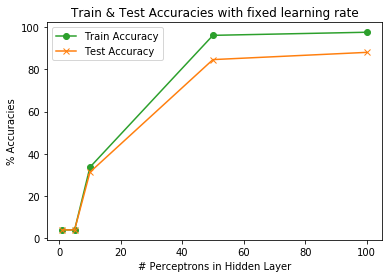

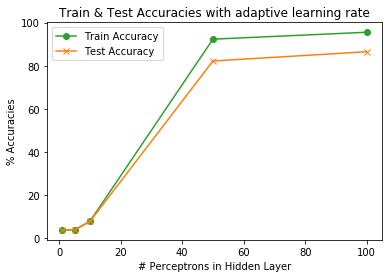

In [24]:
plotAccuracies(lr_type = "fixed")
plotAccuracies(lr_type = "adaptive")

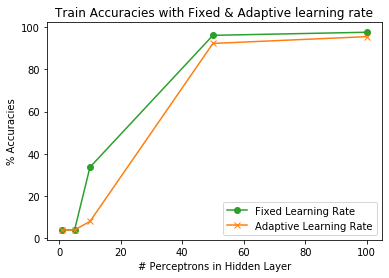

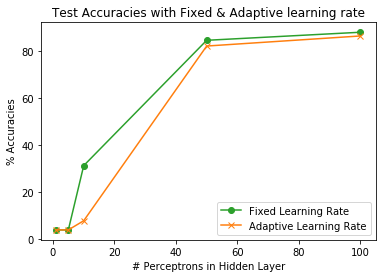

In [25]:
plotAccuraciesComparision(data_type = "Train")
plotAccuraciesComparision(data_type = "Test")

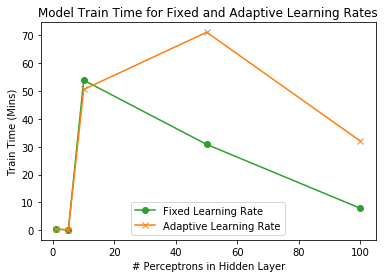

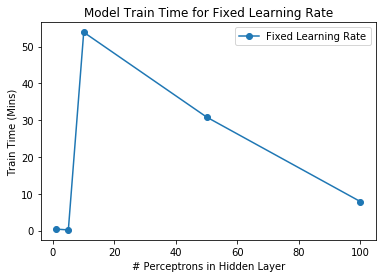

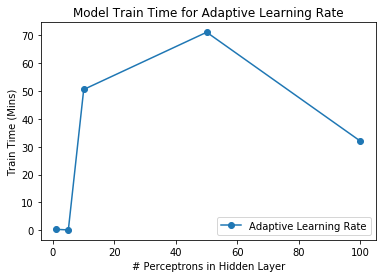

In [26]:
plotTrainingTime()

In [100]:
def prediction(net, data, lbl):
    net.forwardFeed(data)
    outputs = net.layers[-1].output
    prediction = []
    for x in outputs:
        prediction.append(np.argmax(x))
    print(len(prediction), lbl.shape)
    accu_score = accuracy_score(lbl, prediction)
    print("Accuracy= ",accu_score)
prediction(neu_net, DTest, LabelsTest)

6500 (6500,)
Accuracy=  0.9195384615384615
